## **1. Check OS Path**
---

In [13]:
#Using Google drive
#from google.colab import drive
#drive.mount('/content/gdrive')

import os
path = os.getcwd()
print(path)

D:\MyLab\GAN\DCGAN


## **2. Import the necessary libraries**
---

In [14]:
import time, multiprocessing
import numpy as np
import tensorflow as tf
import tensorlayer as tl
import matplotlib
import matplotlib.pyplot as plt
from tensorlayer.layers import Input, Dense, DeConv2d, Reshape, BatchNorm2d, Conv2d, Flatten
from glob import glob
import h5py
## enable debug logging
tl.logging.set_verbosity(tl.logging.DEBUG)

print("Versions of key libraries")
print("---")
print("tensorflow: ", tf.__version__)
print("tensorlayer: ", tl.__version__)
print("matplotlib: ", matplotlib.__version__)
print("numpy: ", np.__version__)

Versions of key libraries
---
tensorflow:  2.2.0
tensorlayer:  2.2.3
matplotlib:  3.2.2
numpy:  1.19.1


## **3. Define initial hyper parameters object**
---

In [15]:
class FLAGS(object):
    def __init__(self):
        self.n_epoch = 15 # "Epoch to train [25]"
        self.z_dim = 100 # "Num of noise value]"
        self.lr = 0.0002 # "Learning rate of for adam [0.0002]")
        self.beta1 = 0.5 # "Momentum term of adam [0.5]")
        self.batch_size = 64 # "The number of batch images [64]")
        self.output_size = 128 # "The size of the output images to produce [64]")
        self.sample_size = 64 # "The number of sample images [64]")
        self.c_dim = 3 # "Number of image channels. [3]")
        self.save_every_epoch = 1 # "The interval of saveing checkpoints.")
        self.checkpoint_dir = "checkpoint" # "Directory name to save the checkpoints")
        self.trian_dir = "result/trian" # "Directory name to save the training result "
        self.test_dir = "result/test" # "Directory name to save the test results")
        self.data_cartoon_dir = "data/anime_face" # Directory name for learning data - cartoon
        self.data_human_dir = "data/human" # Directory name for learning data - human
        assert np.sqrt(self.sample_size) % 1 == 0., 'Flag `sample_size` needs to be a perfect square'

flags = FLAGS()
flags

## **4. CheckPoint and Output directory**
---

In [4]:
cp_dir = tl.files.exists_or_mkdir(flags.checkpoint_dir) # saved model
trian_dir = tl.files.exists_or_mkdir(flags.trian_dir) #  generated image
test_dir = tl.files.exists_or_mkdir(flags.test_dir) #  generated image
print(cp_dir)
print(trian_dir)
print(test_dir)

[TL] [!] checkpoint exists ...
[TL] [!] result/trian exists ...
[TL] [!] result/test exists ...
True
True
True


## **5. Define function for data pre-processing**
---

In [5]:
def preprocess_data(data,output_size, n_epoch, batch_size):
    # dataset API and augmentation
    images_path = tl.files.load_file_list(data, regx='.*.jpg', keep_prefix=True, printable=False)
    def generator_train():
        for image_path in images_path:
            yield image_path.encode('utf-8')
    def _map_fn(image_path):
        image = tf.io.read_file(image_path)
        image = tf.image.decode_jpeg(image, channels=3)  # get RGB with 0~1
        image = tf.image.convert_image_dtype(image, dtype=tf.float32)
        #image = image[45:173, 25:153, :] # central crop
        image = tf.image.resize([image], (output_size, output_size))[0]
        image = tf.image.random_flip_left_right(image)
        image = image * 2 - 1
        return image
    train_ds = tf.data.Dataset.from_generator(generator_train, output_types=tf.string)
    ds = train_ds.shuffle(buffer_size=4096)
    ds = ds.map(_map_fn, num_parallel_calls=4)
    ds = ds.batch(batch_size)
    ds = ds.prefetch(buffer_size=2)
    return ds, images_path
    
print(preprocess_data)

<function preprocess_data at 0x000001CE63F69D08>


## **6. Define the Generator model**
___

In [6]:
def get_generator(shape,modelName,gf_dim=64): # Dimension of gen filters in first conv layer. [64]
    image_size = 128
    s16 = image_size // 16
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)

    ni = Input(shape)
    nn = Dense(n_units=(gf_dim * 8 * s16 * s16), W_init=w_init, b_init=None)(ni)
    nn = Reshape(shape=[-1, s16, s16, gf_dim*8])(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init, name=None)(nn)
    nn = DeConv2d(gf_dim * 4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d( decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim * 2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(gf_dim, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=tf.nn.relu, gamma_init=gamma_init)(nn)
    nn = DeConv2d(3, (5, 5), (2, 2), act=tf.nn.tanh, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name=modelName)

import pprint
G = get_generator([None, flags.z_dim],'generator')
Gtest = get_generator([None, flags.z_dim],'generatorTest')
pprint.pprint(G.config)

[TL] Input  _inputlayer_1: [None, 100]
[TL] Dense  dense_1: 32768 No Activation
[TL] Reshape reshape_1
[TL] BatchNorm batchnorm2d_1: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_1: n_filters: 256 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_2: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_2: n_filters: 128 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_3: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_3: n_filters: 64 strides: (2, 2) padding: SAME act: No Activation dilation: (1, 1)
[TL] BatchNorm batchnorm2d_4: decay: 0.900000 epsilon: 0.000010 act: relu is_train: False
[TL] DeConv2d deconv2d_4: n_filters: 3 strides: (2, 2) padding: SAME act: tanh dilation: (1, 1)
[TL] Input  _inputlayer_2: [None, 100]
[TL] Dense  dense_2: 32768 No Activation
[TL] Reshape reshape_2
[TL] BatchNorm bat

## **7. Define descriminator model**
---

In [7]:
def get_discriminator(shape, modelName,df_dim=64): # Dimension of discrim filters in first conv layer. [64]
    # w_init = tf.glorot_normal_initializer()
    w_init = tf.random_normal_initializer(stddev=0.02)
    gamma_init = tf.random_normal_initializer(1., 0.02)
    lrelu = lambda x : tf.nn.leaky_relu(x, 0.2)

    ni = Input(shape)
    nn = Conv2d(df_dim, (5, 5), (2, 2), act=lrelu, W_init=w_init)(ni)
    nn = Conv2d(df_dim*2, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*4, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Conv2d(df_dim*8, (5, 5), (2, 2), W_init=w_init, b_init=None)(nn)
    nn = BatchNorm2d(decay=0.9, act=lrelu, gamma_init=gamma_init)(nn)
    nn = Flatten()(nn)
    nn = Dense(n_units=1, act=tf.identity, W_init=w_init)(nn)

    return tl.models.Model(inputs=ni, outputs=nn, name=modelName)

D = get_discriminator([None, flags.output_size, flags.output_size, flags.c_dim],'discriminator')
pprint.pprint(D.config)

[TL] Input  _inputlayer_3: [None, 128, 128, 3]
[TL] Conv2d conv2d_1: n_filter: 64 filter_size: (5, 5) strides: (2, 2) pad: SAME act: <lambda>
[TL] Conv2d conv2d_2: n_filter: 128 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_9: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Conv2d conv2d_3: n_filter: 256 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_10: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Conv2d conv2d_4: n_filter: 512 filter_size: (5, 5) strides: (2, 2) pad: SAME act: No Activation
[TL] BatchNorm batchnorm2d_11: decay: 0.900000 epsilon: 0.000010 act: <lambda> is_train: False
[TL] Flatten flatten_1:
[TL] Dense  dense_3: 1 identity
{'inputs': '_inputlayer_3_node_0',
 'model_architecture': [{'args': {'dtype': 'tf.float32',
                                  'layer_type': 'normal',
                                  'name': '_inputlayer_3',
      

## **8. Load the Checkpoint**
___

In [8]:
try:
    if cp_dir:
        print("CheckPoint Exits!")
        G.load_weights('{}/G_cartoon.npz'.format(flags.checkpoint_dir), format='npz')
        D.load_weights('{}/D_cartoon.npz'.format(flags.checkpoint_dir), format='npz')
        print("Weight Loaded")
    else:
        print("CheckPoint Folder doesn't exist")
except:
    print("Weight files doesn't exist")

CheckPoint Exits!
[TL] [*] Load checkpoint/G_cartoon.npz SUCCESS!
[TL] [*] Load checkpoint/D_cartoon.npz SUCCESS!
Weight Loaded


## **9. Define model training method**
---

In [9]:
num_tiles = int(np.sqrt(flags.sample_size))

def save_epoch_history(passed_epoch): 
    try:
        f = h5py.File('{}/epoch_history_cartoon.h5'.format(flags.checkpoint_dir),'a')
        
        prev_epoch = 0
        curr_epoch = 0
        
        if "epoch_history" not in f.keys():
            f.create_dataset("epoch_history",(1,1))
        
        if "prev_epoch" in f['epoch_history'].attrs.keys():
            prev_epoch = f['epoch_history'].attrs["prev_epoch"]
            f['epoch_history'].attrs["current_epoch"] = prev_epoch + passed_epoch
            curr_epoch = f['epoch_history'].attrs["current_epoch"]
            print("Epoch History - Previous Epoch: ",prev_epoch)
            print("Epoch History - Current Epoch: ",curr_epoch)
            f['epoch_history'].attrs["prev_epoch"] = curr_epoch
            return curr_epoch
        else:
            f['epoch_history'].attrs["prev_epoch"] = passed_epoch
            print("Epoch History - Previous Epoch: ",prev_epoch)
            return  prev_epoch 
        
        f.close()
    except:
        f.close()
    
def train(data):
    images, images_path = preprocess_data(data,flags.output_size, flags.n_epoch, flags.batch_size)
    
    G.train()
    D.train()

    d_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)
    g_optimizer = tf.optimizers.Adam(flags.lr, beta_1=flags.beta1)

    n_step_epoch = int(len(images_path) // flags.batch_size)
    
    # Z = tf.distributions.Normal(0., 1.)
    for epoch in range(flags.n_epoch):
        print("Train- epoch: ",epoch)
        for step, batch_images in enumerate(images):
            if batch_images.shape[0] != flags.batch_size: # if the remaining data in this epoch < batch_size
                break
            step_time = time.time()
            with tf.GradientTape(persistent=True) as tape:
                # z = Z.sample([flags.batch_size, flags.z_dim]) 
                z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
                d_logits = D(G(z))
                d2_logits = D(batch_images)
                # discriminator: real images are labelled as 1
                d_loss_real = tl.cost.sigmoid_cross_entropy(d2_logits, tf.ones_like(d2_logits), name='dreal')
                # discriminator: images from generator (fake) are labelled as 0
                d_loss_fake = tl.cost.sigmoid_cross_entropy(d_logits, tf.zeros_like(d_logits), name='dfake')
                # combined loss for updating discriminator
                d_loss = d_loss_real + d_loss_fake
                # generator: try to fool discriminator to output 1
                g_loss = tl.cost.sigmoid_cross_entropy(d_logits, tf.ones_like(d_logits), name='gfake')

            grad = tape.gradient(g_loss, G.trainable_weights)
            g_optimizer.apply_gradients(zip(grad, G.trainable_weights))
            grad = tape.gradient(d_loss, D.trainable_weights)
            d_optimizer.apply_gradients(zip(grad, D.trainable_weights))
            del tape

            print("Epoch: [{}/{}] [{}/{}] took: {:.3f}, d_loss: {:.5f}, g_loss: {:.5f}".format(epoch, \
                  flags.n_epoch, step, n_step_epoch, time.time()-step_time, d_loss, g_loss))
        
        if np.mod(epoch, flags.save_every_epoch) == 0:
            print("epoch: ",epoch)
            print("flags.save_every_epoch: ",flags.save_every_epoch)
            print("mod: ",np.mod(epoch, flags.save_every_epoch))
            G.save_weights('{}/G_cartoon.npz'.format(flags.checkpoint_dir), format='npz')
            D.save_weights('{}/D_cartoon.npz'.format(flags.checkpoint_dir), format='npz')
            G.save('{}/G_cartoon_DCGAN_1.h5'.format(flags.checkpoint_dir),save_weights=True)
            D.save('{}/D_cartoon_DCGAN_1.h5'.format(flags.checkpoint_dir),save_weights=True)
            historic_epoch = save_epoch_history(flags.save_every_epoch)
            G.eval()
            result = G(z)
            G.train()
            tl.visualize.save_images(result.numpy(), [num_tiles, num_tiles], '{}/train_{}.png'.format(flags.trian_dir, historic_epoch))
            
print(num_tiles)
print(train)

8
<function train at 0x000001CE642921E0>


## **10. Train the model**
---
* Step 1: train both the Generator and Descriminator
* Step 2: Save new weights
* Step 3: Generate new image summary

In [10]:
train(flags.data_cartoon_dir)

Train- epoch:  0
Epoch: [0/15] [0/2187] took: 3.600, d_loss: 0.01255, g_loss: 6.71712
Epoch: [0/15] [1/2187] took: 1.391, d_loss: 1.12671, g_loss: 17.33617
Epoch: [0/15] [2/2187] took: 1.387, d_loss: 0.02587, g_loss: 7.06321
Epoch: [0/15] [3/2187] took: 1.393, d_loss: 0.40751, g_loss: 2.25951
Epoch: [0/15] [4/2187] took: 1.395, d_loss: 0.07458, g_loss: 4.64970
Epoch: [0/15] [5/2187] took: 1.396, d_loss: 0.00268, g_loss: 8.52738
Epoch: [0/15] [6/2187] took: 1.399, d_loss: 0.04626, g_loss: 10.57066
Epoch: [0/15] [7/2187] took: 1.404, d_loss: 0.06842, g_loss: 9.73906
Epoch: [0/15] [8/2187] took: 1.405, d_loss: 0.00735, g_loss: 8.07887
Epoch: [0/15] [9/2187] took: 1.405, d_loss: 0.00778, g_loss: 6.98041
Epoch: [0/15] [10/2187] took: 1.418, d_loss: 0.02956, g_loss: 6.58752
Epoch: [0/15] [11/2187] took: 1.409, d_loss: 0.01110, g_loss: 7.99903
Epoch: [0/15] [12/2187] took: 1.405, d_loss: 0.02179, g_loss: 7.23067
Epoch: [0/15] [13/2187] took: 1.410, d_loss: 0.00931, g_loss: 7.26746
Epoch: [0/1

Epoch: [0/15] [117/2187] took: 1.455, d_loss: 0.00734, g_loss: 8.03696
Epoch: [0/15] [118/2187] took: 1.453, d_loss: 0.00618, g_loss: 9.59766
Epoch: [0/15] [119/2187] took: 1.452, d_loss: 0.00679, g_loss: 9.52327
Epoch: [0/15] [120/2187] took: 1.457, d_loss: 0.00413, g_loss: 9.12611
Epoch: [0/15] [121/2187] took: 1.462, d_loss: 0.01152, g_loss: 7.42781
Epoch: [0/15] [122/2187] took: 1.461, d_loss: 0.01298, g_loss: 9.73645
Epoch: [0/15] [123/2187] took: 1.459, d_loss: 0.00283, g_loss: 9.62113
Epoch: [0/15] [124/2187] took: 1.455, d_loss: 0.00864, g_loss: 8.58698
Epoch: [0/15] [125/2187] took: 1.456, d_loss: 0.00641, g_loss: 9.36732
Epoch: [0/15] [126/2187] took: 1.457, d_loss: 0.00395, g_loss: 9.11700
Epoch: [0/15] [127/2187] took: 1.459, d_loss: 0.00654, g_loss: 8.78951
Epoch: [0/15] [128/2187] took: 1.453, d_loss: 0.01717, g_loss: 7.57303
Epoch: [0/15] [129/2187] took: 1.455, d_loss: 0.00179, g_loss: 10.77567
Epoch: [0/15] [130/2187] took: 1.455, d_loss: 0.03133, g_loss: 11.43155
Epoc

Epoch: [0/15] [233/2187] took: 1.455, d_loss: 1.31181, g_loss: 1.49727
Epoch: [0/15] [234/2187] took: 1.457, d_loss: 1.77501, g_loss: 11.96789
Epoch: [0/15] [235/2187] took: 1.453, d_loss: 0.88531, g_loss: 1.64119
Epoch: [0/15] [236/2187] took: 1.459, d_loss: 0.06682, g_loss: 5.48554
Epoch: [0/15] [237/2187] took: 1.463, d_loss: 0.16704, g_loss: 6.04619
Epoch: [0/15] [238/2187] took: 1.458, d_loss: 0.12338, g_loss: 4.57943
Epoch: [0/15] [239/2187] took: 1.464, d_loss: 0.08360, g_loss: 5.60598
Epoch: [0/15] [240/2187] took: 1.460, d_loss: 0.08612, g_loss: 5.51765
Epoch: [0/15] [241/2187] took: 1.466, d_loss: 0.26066, g_loss: 3.71499
Epoch: [0/15] [242/2187] took: 1.454, d_loss: 0.36903, g_loss: 10.12096
Epoch: [0/15] [243/2187] took: 1.464, d_loss: 0.02995, g_loss: 7.52375
Epoch: [0/15] [244/2187] took: 1.459, d_loss: 0.07872, g_loss: 4.65707
Epoch: [0/15] [245/2187] took: 1.463, d_loss: 0.14211, g_loss: 3.59686
Epoch: [0/15] [246/2187] took: 1.453, d_loss: 0.20047, g_loss: 8.84411
Epoc

Epoch: [0/15] [349/2187] took: 1.471, d_loss: 0.01577, g_loss: 8.11636
Epoch: [0/15] [350/2187] took: 1.462, d_loss: 0.03832, g_loss: 6.64351
Epoch: [0/15] [351/2187] took: 1.471, d_loss: 0.02527, g_loss: 6.77513
Epoch: [0/15] [352/2187] took: 1.462, d_loss: 0.00918, g_loss: 7.82716
Epoch: [0/15] [353/2187] took: 1.462, d_loss: 0.03832, g_loss: 6.61554
Epoch: [0/15] [354/2187] took: 1.468, d_loss: 0.06371, g_loss: 8.84147
Epoch: [0/15] [355/2187] took: 1.466, d_loss: 0.01201, g_loss: 7.08268
Epoch: [0/15] [356/2187] took: 1.458, d_loss: 0.04306, g_loss: 6.16720
Epoch: [0/15] [357/2187] took: 1.467, d_loss: 0.01315, g_loss: 7.12015
Epoch: [0/15] [358/2187] took: 1.459, d_loss: 0.00551, g_loss: 8.52750
Epoch: [0/15] [359/2187] took: 1.464, d_loss: 0.03931, g_loss: 8.59237
Epoch: [0/15] [360/2187] took: 1.455, d_loss: 0.01442, g_loss: 7.87068
Epoch: [0/15] [361/2187] took: 1.456, d_loss: 0.02126, g_loss: 6.69774
Epoch: [0/15] [362/2187] took: 1.469, d_loss: 0.02653, g_loss: 6.28586
Epoch:

Epoch: [0/15] [465/2187] took: 1.468, d_loss: 0.01762, g_loss: 8.56482
Epoch: [0/15] [466/2187] took: 1.462, d_loss: 0.04346, g_loss: 9.65375
Epoch: [0/15] [467/2187] took: 1.461, d_loss: 0.02734, g_loss: 7.92606
Epoch: [0/15] [468/2187] took: 1.468, d_loss: 0.00873, g_loss: 7.87284
Epoch: [0/15] [469/2187] took: 1.469, d_loss: 0.01209, g_loss: 8.61249
Epoch: [0/15] [470/2187] took: 1.473, d_loss: 0.01400, g_loss: 8.67469
Epoch: [0/15] [471/2187] took: 1.477, d_loss: 0.03760, g_loss: 8.09501
Epoch: [0/15] [472/2187] took: 1.481, d_loss: 0.04784, g_loss: 6.83419
Epoch: [0/15] [473/2187] took: 1.480, d_loss: 0.02679, g_loss: 5.94594
Epoch: [0/15] [474/2187] took: 1.484, d_loss: 0.01461, g_loss: 8.12760
Epoch: [0/15] [475/2187] took: 1.479, d_loss: 0.00984, g_loss: 8.20445
Epoch: [0/15] [476/2187] took: 1.510, d_loss: 0.01296, g_loss: 7.87637
Epoch: [0/15] [477/2187] took: 1.470, d_loss: 0.01841, g_loss: 8.59011
Epoch: [0/15] [478/2187] took: 1.469, d_loss: 0.02142, g_loss: 6.85278
Epoch:

Epoch: [0/15] [581/2187] took: 1.481, d_loss: 0.01907, g_loss: 10.37867
Epoch: [0/15] [582/2187] took: 1.480, d_loss: 0.01724, g_loss: 7.97272
Epoch: [0/15] [583/2187] took: 1.482, d_loss: 0.03274, g_loss: 6.60128
Epoch: [0/15] [584/2187] took: 1.471, d_loss: 0.00792, g_loss: 8.60347
Epoch: [0/15] [585/2187] took: 1.477, d_loss: 0.01140, g_loss: 8.91796
Epoch: [0/15] [586/2187] took: 1.476, d_loss: 0.02503, g_loss: 8.80597
Epoch: [0/15] [587/2187] took: 1.482, d_loss: 0.02319, g_loss: 6.95087
Epoch: [0/15] [588/2187] took: 1.473, d_loss: 0.00552, g_loss: 8.05942
Epoch: [0/15] [589/2187] took: 1.477, d_loss: 0.00354, g_loss: 8.18972
Epoch: [0/15] [590/2187] took: 1.474, d_loss: 0.00374, g_loss: 9.24830
Epoch: [0/15] [591/2187] took: 1.467, d_loss: 0.02653, g_loss: 8.91983
Epoch: [0/15] [592/2187] took: 1.476, d_loss: 0.00552, g_loss: 8.46144
Epoch: [0/15] [593/2187] took: 1.477, d_loss: 0.00427, g_loss: 8.81592
Epoch: [0/15] [594/2187] took: 1.476, d_loss: 0.00928, g_loss: 7.38051
Epoch

Epoch: [0/15] [697/2187] took: 1.479, d_loss: 0.01086, g_loss: 7.95016
Epoch: [0/15] [698/2187] took: 1.472, d_loss: 0.00609, g_loss: 9.88845
Epoch: [0/15] [699/2187] took: 1.463, d_loss: 0.01331, g_loss: 9.77823
Epoch: [0/15] [700/2187] took: 1.458, d_loss: 0.00841, g_loss: 8.32379
Epoch: [0/15] [701/2187] took: 1.466, d_loss: 0.01255, g_loss: 7.95647
Epoch: [0/15] [702/2187] took: 1.463, d_loss: 0.00423, g_loss: 9.21599
Epoch: [0/15] [703/2187] took: 1.467, d_loss: 0.00430, g_loss: 10.02468
Epoch: [0/15] [704/2187] took: 1.473, d_loss: 0.00548, g_loss: 10.45778
Epoch: [0/15] [705/2187] took: 1.467, d_loss: 0.00446, g_loss: 8.52468
Epoch: [0/15] [706/2187] took: 1.466, d_loss: 0.01637, g_loss: 9.15745
Epoch: [0/15] [707/2187] took: 1.462, d_loss: 0.00707, g_loss: 7.74859
Epoch: [0/15] [708/2187] took: 1.472, d_loss: 0.01307, g_loss: 7.32482
Epoch: [0/15] [709/2187] took: 1.462, d_loss: 0.00470, g_loss: 8.89295
Epoch: [0/15] [710/2187] took: 1.465, d_loss: 0.02007, g_loss: 10.06528
Epo

Epoch: [0/15] [813/2187] took: 1.475, d_loss: 0.02382, g_loss: 5.96269
Epoch: [0/15] [814/2187] took: 1.478, d_loss: 0.03580, g_loss: 6.46045
Epoch: [0/15] [815/2187] took: 1.482, d_loss: 0.00714, g_loss: 7.76894
Epoch: [0/15] [816/2187] took: 1.476, d_loss: 0.02880, g_loss: 7.84329
Epoch: [0/15] [817/2187] took: 1.480, d_loss: 0.02537, g_loss: 6.46412
Epoch: [0/15] [818/2187] took: 1.481, d_loss: 0.02315, g_loss: 5.83831
Epoch: [0/15] [819/2187] took: 1.479, d_loss: 0.01999, g_loss: 6.66892
Epoch: [0/15] [820/2187] took: 1.484, d_loss: 0.00679, g_loss: 8.43206
Epoch: [0/15] [821/2187] took: 1.480, d_loss: 0.02916, g_loss: 8.33778
Epoch: [0/15] [822/2187] took: 1.484, d_loss: 0.01076, g_loss: 8.09634
Epoch: [0/15] [823/2187] took: 1.475, d_loss: 0.03734, g_loss: 5.84883
Epoch: [0/15] [824/2187] took: 1.482, d_loss: 0.02927, g_loss: 7.50123
Epoch: [0/15] [825/2187] took: 1.480, d_loss: 0.01323, g_loss: 8.13655
Epoch: [0/15] [826/2187] took: 1.482, d_loss: 0.04166, g_loss: 7.09358
Epoch:

Epoch: [0/15] [929/2187] took: 1.482, d_loss: 0.12188, g_loss: 3.80745
Epoch: [0/15] [930/2187] took: 1.485, d_loss: 0.02349, g_loss: 7.63686
Epoch: [0/15] [931/2187] took: 1.487, d_loss: 0.09379, g_loss: 8.97312
Epoch: [0/15] [932/2187] took: 1.484, d_loss: 0.01657, g_loss: 7.04473
Epoch: [0/15] [933/2187] took: 1.486, d_loss: 0.04928, g_loss: 6.00472
Epoch: [0/15] [934/2187] took: 1.479, d_loss: 0.03324, g_loss: 6.20884
Epoch: [0/15] [935/2187] took: 1.471, d_loss: 0.06449, g_loss: 4.88419
Epoch: [0/15] [936/2187] took: 1.474, d_loss: 0.09307, g_loss: 7.36694
Epoch: [0/15] [937/2187] took: 1.482, d_loss: 0.09468, g_loss: 5.34511
Epoch: [0/15] [938/2187] took: 1.486, d_loss: 0.06358, g_loss: 7.95790
Epoch: [0/15] [939/2187] took: 1.486, d_loss: 0.15729, g_loss: 4.90012
Epoch: [0/15] [940/2187] took: 1.493, d_loss: 0.08469, g_loss: 7.26920
Epoch: [0/15] [941/2187] took: 1.487, d_loss: 0.05773, g_loss: 6.32630
Epoch: [0/15] [942/2187] took: 1.489, d_loss: 0.00825, g_loss: 7.73585
Epoch:

Epoch: [0/15] [1044/2187] took: 1.486, d_loss: 0.05122, g_loss: 5.80933
Epoch: [0/15] [1045/2187] took: 1.485, d_loss: 0.03825, g_loss: 7.29022
Epoch: [0/15] [1046/2187] took: 1.484, d_loss: 0.12108, g_loss: 7.01218
Epoch: [0/15] [1047/2187] took: 1.482, d_loss: 0.13740, g_loss: 3.50996
Epoch: [0/15] [1048/2187] took: 1.480, d_loss: 0.03033, g_loss: 6.59038
Epoch: [0/15] [1049/2187] took: 1.485, d_loss: 0.02700, g_loss: 7.29932
Epoch: [0/15] [1050/2187] took: 1.489, d_loss: 0.01937, g_loss: 7.72187
Epoch: [0/15] [1051/2187] took: 1.486, d_loss: 0.01311, g_loss: 6.77297
Epoch: [0/15] [1052/2187] took: 1.491, d_loss: 0.02909, g_loss: 6.73870
Epoch: [0/15] [1053/2187] took: 1.488, d_loss: 0.02256, g_loss: 6.23073
Epoch: [0/15] [1054/2187] took: 1.494, d_loss: 0.05387, g_loss: 6.61977
Epoch: [0/15] [1055/2187] took: 1.496, d_loss: 0.03039, g_loss: 5.55031
Epoch: [0/15] [1056/2187] took: 1.499, d_loss: 0.09025, g_loss: 4.97227
Epoch: [0/15] [1057/2187] took: 1.490, d_loss: 0.04733, g_loss: 

Epoch: [0/15] [1158/2187] took: 1.500, d_loss: 0.01823, g_loss: 6.78404
Epoch: [0/15] [1159/2187] took: 1.492, d_loss: 0.01203, g_loss: 7.39188
Epoch: [0/15] [1160/2187] took: 1.489, d_loss: 0.01690, g_loss: 8.23688
Epoch: [0/15] [1161/2187] took: 1.487, d_loss: 0.02775, g_loss: 7.62283
Epoch: [0/15] [1162/2187] took: 1.494, d_loss: 0.02750, g_loss: 6.48485
Epoch: [0/15] [1163/2187] took: 1.488, d_loss: 0.03351, g_loss: 6.60376
Epoch: [0/15] [1164/2187] took: 1.499, d_loss: 0.10340, g_loss: 8.52237
Epoch: [0/15] [1165/2187] took: 1.491, d_loss: 0.12711, g_loss: 4.55864
Epoch: [0/15] [1166/2187] took: 1.492, d_loss: 0.02006, g_loss: 8.75191
Epoch: [0/15] [1167/2187] took: 1.496, d_loss: 0.07526, g_loss: 9.83316
Epoch: [0/15] [1168/2187] took: 1.493, d_loss: 0.04621, g_loss: 5.45332
Epoch: [0/15] [1169/2187] took: 1.490, d_loss: 0.01363, g_loss: 6.59156
Epoch: [0/15] [1170/2187] took: 1.493, d_loss: 0.00782, g_loss: 7.93310
Epoch: [0/15] [1171/2187] took: 1.490, d_loss: 0.00634, g_loss: 

Epoch: [0/15] [1272/2187] took: 1.490, d_loss: 0.01366, g_loss: 7.86262
Epoch: [0/15] [1273/2187] took: 1.487, d_loss: 0.00786, g_loss: 8.51217
Epoch: [0/15] [1274/2187] took: 1.488, d_loss: 0.00212, g_loss: 8.91808
Epoch: [0/15] [1275/2187] took: 1.494, d_loss: 0.02832, g_loss: 9.24991
Epoch: [0/15] [1276/2187] took: 1.493, d_loss: 0.00664, g_loss: 7.17383
Epoch: [0/15] [1277/2187] took: 1.487, d_loss: 0.02476, g_loss: 6.18365
Epoch: [0/15] [1278/2187] took: 1.489, d_loss: 0.01253, g_loss: 6.83926
Epoch: [0/15] [1279/2187] took: 1.491, d_loss: 0.01500, g_loss: 8.12815
Epoch: [0/15] [1280/2187] took: 1.486, d_loss: 0.00639, g_loss: 8.41989
Epoch: [0/15] [1281/2187] took: 1.485, d_loss: 0.01090, g_loss: 7.32195
Epoch: [0/15] [1282/2187] took: 1.486, d_loss: 0.01637, g_loss: 7.79604
Epoch: [0/15] [1283/2187] took: 1.486, d_loss: 0.01361, g_loss: 6.73771
Epoch: [0/15] [1284/2187] took: 1.490, d_loss: 0.01117, g_loss: 7.14305
Epoch: [0/15] [1285/2187] took: 1.494, d_loss: 0.01719, g_loss: 

Epoch: [0/15] [1386/2187] took: 1.498, d_loss: 0.01487, g_loss: 8.67073
Epoch: [0/15] [1387/2187] took: 1.499, d_loss: 0.00946, g_loss: 7.63803
Epoch: [0/15] [1388/2187] took: 1.504, d_loss: 0.01202, g_loss: 7.67362
Epoch: [0/15] [1389/2187] took: 1.488, d_loss: 0.00771, g_loss: 7.68180
Epoch: [0/15] [1390/2187] took: 1.488, d_loss: 0.00835, g_loss: 9.48214
Epoch: [0/15] [1391/2187] took: 1.496, d_loss: 0.02241, g_loss: 9.11095
Epoch: [0/15] [1392/2187] took: 1.491, d_loss: 0.00637, g_loss: 7.53406
Epoch: [0/15] [1393/2187] took: 1.496, d_loss: 0.01069, g_loss: 6.96234
Epoch: [0/15] [1394/2187] took: 1.501, d_loss: 0.00905, g_loss: 7.16702
Epoch: [0/15] [1395/2187] took: 1.500, d_loss: 0.00659, g_loss: 8.08427
Epoch: [0/15] [1396/2187] took: 1.492, d_loss: 0.01573, g_loss: 9.03533
Epoch: [0/15] [1397/2187] took: 1.497, d_loss: 0.01536, g_loss: 7.92962
Epoch: [0/15] [1398/2187] took: 1.503, d_loss: 0.00539, g_loss: 8.34456
Epoch: [0/15] [1399/2187] took: 1.493, d_loss: 0.00748, g_loss: 

Epoch: [0/15] [1500/2187] took: 1.499, d_loss: 0.20752, g_loss: 4.72385
Epoch: [0/15] [1501/2187] took: 1.495, d_loss: 0.26442, g_loss: 3.33270
Epoch: [0/15] [1502/2187] took: 1.495, d_loss: 0.23118, g_loss: 3.51930
Epoch: [0/15] [1503/2187] took: 1.493, d_loss: 0.20234, g_loss: 4.41527
Epoch: [0/15] [1504/2187] took: 1.491, d_loss: 0.11422, g_loss: 4.69447
Epoch: [0/15] [1505/2187] took: 1.495, d_loss: 0.20602, g_loss: 3.28233
Epoch: [0/15] [1506/2187] took: 1.496, d_loss: 0.55469, g_loss: 5.78382
Epoch: [0/15] [1507/2187] took: 1.492, d_loss: 2.11366, g_loss: 0.41928
Epoch: [0/15] [1508/2187] took: 1.490, d_loss: 5.91807, g_loss: 15.36058
Epoch: [0/15] [1509/2187] took: 1.489, d_loss: 0.35264, g_loss: 2.34834
Epoch: [0/15] [1510/2187] took: 1.498, d_loss: 0.81402, g_loss: 1.24292
Epoch: [0/15] [1511/2187] took: 1.490, d_loss: 0.71204, g_loss: 5.90084
Epoch: [0/15] [1512/2187] took: 1.498, d_loss: 0.18644, g_loss: 3.71301
Epoch: [0/15] [1513/2187] took: 1.493, d_loss: 0.28752, g_loss:

Epoch: [0/15] [1614/2187] took: 1.493, d_loss: 0.09234, g_loss: 4.45074
Epoch: [0/15] [1615/2187] took: 1.499, d_loss: 0.04876, g_loss: 6.81784
Epoch: [0/15] [1616/2187] took: 1.498, d_loss: 0.04709, g_loss: 6.34631
Epoch: [0/15] [1617/2187] took: 1.492, d_loss: 0.10143, g_loss: 5.57538
Epoch: [0/15] [1618/2187] took: 1.492, d_loss: 0.06800, g_loss: 4.82663
Epoch: [0/15] [1619/2187] took: 1.495, d_loss: 0.02299, g_loss: 6.59027
Epoch: [0/15] [1620/2187] took: 1.492, d_loss: 0.03968, g_loss: 7.28241
Epoch: [0/15] [1621/2187] took: 1.497, d_loss: 0.04493, g_loss: 6.41070
Epoch: [0/15] [1622/2187] took: 1.495, d_loss: 0.03668, g_loss: 4.95361
Epoch: [0/15] [1623/2187] took: 1.494, d_loss: 0.02636, g_loss: 5.38823
Epoch: [0/15] [1624/2187] took: 1.504, d_loss: 0.02034, g_loss: 6.94820
Epoch: [0/15] [1625/2187] took: 1.503, d_loss: 0.03092, g_loss: 6.66869
Epoch: [0/15] [1626/2187] took: 1.493, d_loss: 0.03559, g_loss: 5.95821
Epoch: [0/15] [1627/2187] took: 1.501, d_loss: 0.07680, g_loss: 

Epoch: [0/15] [1728/2187] took: 1.505, d_loss: 0.02180, g_loss: 6.43577
Epoch: [0/15] [1729/2187] took: 1.497, d_loss: 0.01552, g_loss: 7.76556
Epoch: [0/15] [1730/2187] took: 1.497, d_loss: 0.02752, g_loss: 7.38433
Epoch: [0/15] [1731/2187] took: 1.499, d_loss: 0.01515, g_loss: 7.37652
Epoch: [0/15] [1732/2187] took: 1.498, d_loss: 0.02136, g_loss: 6.97177
Epoch: [0/15] [1733/2187] took: 1.503, d_loss: 0.01808, g_loss: 6.23118
Epoch: [0/15] [1734/2187] took: 1.501, d_loss: 0.02333, g_loss: 7.84406
Epoch: [0/15] [1735/2187] took: 1.492, d_loss: 0.01057, g_loss: 7.38567
Epoch: [0/15] [1736/2187] took: 1.498, d_loss: 0.01993, g_loss: 7.40563
Epoch: [0/15] [1737/2187] took: 1.498, d_loss: 0.01287, g_loss: 6.59103
Epoch: [0/15] [1738/2187] took: 1.489, d_loss: 0.00885, g_loss: 7.33196
Epoch: [0/15] [1739/2187] took: 1.497, d_loss: 0.00631, g_loss: 7.51084
Epoch: [0/15] [1740/2187] took: 1.495, d_loss: 0.01677, g_loss: 7.76333
Epoch: [0/15] [1741/2187] took: 1.497, d_loss: 0.01654, g_loss: 

Epoch: [0/15] [1842/2187] took: 1.497, d_loss: 0.01632, g_loss: 7.75608
Epoch: [0/15] [1843/2187] took: 1.501, d_loss: 0.00470, g_loss: 7.75622
Epoch: [0/15] [1844/2187] took: 1.501, d_loss: 0.01049, g_loss: 7.62223
Epoch: [0/15] [1845/2187] took: 1.490, d_loss: 0.01242, g_loss: 8.59457
Epoch: [0/15] [1846/2187] took: 1.498, d_loss: 0.01780, g_loss: 7.09938
Epoch: [0/15] [1847/2187] took: 1.498, d_loss: 0.01074, g_loss: 7.10479
Epoch: [0/15] [1848/2187] took: 1.496, d_loss: 0.02854, g_loss: 7.31070
Epoch: [0/15] [1849/2187] took: 1.494, d_loss: 0.00563, g_loss: 9.50004
Epoch: [0/15] [1850/2187] took: 1.492, d_loss: 0.02322, g_loss: 8.58152
Epoch: [0/15] [1851/2187] took: 1.490, d_loss: 0.02005, g_loss: 7.39918
Epoch: [0/15] [1852/2187] took: 1.493, d_loss: 0.02688, g_loss: 6.87238
Epoch: [0/15] [1853/2187] took: 1.493, d_loss: 0.01281, g_loss: 8.47098
Epoch: [0/15] [1854/2187] took: 1.495, d_loss: 0.01031, g_loss: 9.06487
Epoch: [0/15] [1855/2187] took: 1.495, d_loss: 0.04068, g_loss: 

Epoch: [0/15] [1956/2187] took: 1.495, d_loss: 0.00490, g_loss: 9.21607
Epoch: [0/15] [1957/2187] took: 1.493, d_loss: 0.01141, g_loss: 9.31534
Epoch: [0/15] [1958/2187] took: 1.494, d_loss: 0.01667, g_loss: 7.66427
Epoch: [0/15] [1959/2187] took: 1.499, d_loss: 0.01958, g_loss: 9.00170
Epoch: [0/15] [1960/2187] took: 1.498, d_loss: 0.00768, g_loss: 7.53877
Epoch: [0/15] [1961/2187] took: 1.495, d_loss: 0.00898, g_loss: 7.59385
Epoch: [0/15] [1962/2187] took: 1.501, d_loss: 0.00291, g_loss: 8.02128
Epoch: [0/15] [1963/2187] took: 1.496, d_loss: 0.00418, g_loss: 9.20483
Epoch: [0/15] [1964/2187] took: 1.500, d_loss: 0.02421, g_loss: 8.57340
Epoch: [0/15] [1965/2187] took: 1.501, d_loss: 0.00585, g_loss: 7.76780
Epoch: [0/15] [1966/2187] took: 1.494, d_loss: 0.01237, g_loss: 6.90524
Epoch: [0/15] [1967/2187] took: 1.500, d_loss: 0.00576, g_loss: 7.22687
Epoch: [0/15] [1968/2187] took: 1.498, d_loss: 0.00409, g_loss: 8.87848
Epoch: [0/15] [1969/2187] took: 1.499, d_loss: 0.00518, g_loss: 

Epoch: [0/15] [2070/2187] took: 1.495, d_loss: 0.15912, g_loss: 5.32392
Epoch: [0/15] [2071/2187] took: 1.498, d_loss: 0.12874, g_loss: 3.60824
Epoch: [0/15] [2072/2187] took: 1.495, d_loss: 0.15917, g_loss: 5.61658
Epoch: [0/15] [2073/2187] took: 1.499, d_loss: 0.13495, g_loss: 4.10346
Epoch: [0/15] [2074/2187] took: 1.499, d_loss: 0.12635, g_loss: 5.28274
Epoch: [0/15] [2075/2187] took: 1.501, d_loss: 0.09523, g_loss: 5.31951
Epoch: [0/15] [2076/2187] took: 1.505, d_loss: 0.20914, g_loss: 3.76837
Epoch: [0/15] [2077/2187] took: 1.493, d_loss: 0.15053, g_loss: 5.28531
Epoch: [0/15] [2078/2187] took: 1.497, d_loss: 0.19935, g_loss: 3.65374
Epoch: [0/15] [2079/2187] took: 1.500, d_loss: 0.20277, g_loss: 4.64633
Epoch: [0/15] [2080/2187] took: 1.507, d_loss: 0.61785, g_loss: 1.52961
Epoch: [0/15] [2081/2187] took: 1.505, d_loss: 1.43373, g_loss: 10.76871
Epoch: [0/15] [2082/2187] took: 1.497, d_loss: 1.31710, g_loss: 0.81814
Epoch: [0/15] [2083/2187] took: 1.507, d_loss: 0.09343, g_loss:

Epoch: [0/15] [2184/2187] took: 1.508, d_loss: 0.14402, g_loss: 5.32578
Epoch: [0/15] [2185/2187] took: 1.503, d_loss: 0.15783, g_loss: 7.42250
Epoch: [0/15] [2186/2187] took: 1.507, d_loss: 0.07169, g_loss: 5.28916
epoch:  0
flags.save_every_epoch:  1
mod:  0
[TL] [*] Saving TL weights into checkpoint/G_cartoon.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into checkpoint/D_cartoon.npz
[TL] [*] Saved


D:\MyApp\anaconda3\envs\MyGPU\lib\site-packages\numpy\core\_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


[TL] [*] Saving TL model into checkpoint/G_cartoon_DCGAN_1.h5, saving weights=True
[TL] [*] Saved TL model into checkpoint/G_cartoon_DCGAN_1.h5, saving weights=True
[TL] [*] Saving TL model into checkpoint/D_cartoon_DCGAN_1.h5, saving weights=True
[TL] [*] Saved TL model into checkpoint/D_cartoon_DCGAN_1.h5, saving weights=True
Epoch History - Previous Epoch:  109
Epoch History - Current Epoch:  110
Train- epoch:  1
Epoch: [1/15] [0/2187] took: 1.458, d_loss: 0.03207, g_loss: 5.43948
Epoch: [1/15] [1/2187] took: 1.500, d_loss: 0.03848, g_loss: 5.34860
Epoch: [1/15] [2/2187] took: 1.499, d_loss: 0.03036, g_loss: 6.29611
Epoch: [1/15] [3/2187] took: 1.498, d_loss: 0.04603, g_loss: 7.30504
Epoch: [1/15] [4/2187] took: 1.499, d_loss: 0.03415, g_loss: 7.30589
Epoch: [1/15] [5/2187] took: 1.488, d_loss: 0.06998, g_loss: 6.20062
Epoch: [1/15] [6/2187] took: 1.504, d_loss: 0.11578, g_loss: 4.84490
Epoch: [1/15] [7/2187] took: 1.496, d_loss: 0.10298, g_loss: 6.77804
Epoch: [1/15] [8/2187] took:

Epoch: [1/15] [112/2187] took: 1.493, d_loss: 0.02007, g_loss: 6.05450
Epoch: [1/15] [113/2187] took: 1.502, d_loss: 0.01465, g_loss: 7.06030
Epoch: [1/15] [114/2187] took: 1.491, d_loss: 0.02021, g_loss: 7.38043
Epoch: [1/15] [115/2187] took: 1.495, d_loss: 0.02777, g_loss: 7.81952
Epoch: [1/15] [116/2187] took: 1.493, d_loss: 0.02273, g_loss: 6.68649
Epoch: [1/15] [117/2187] took: 1.496, d_loss: 0.01099, g_loss: 6.82493
Epoch: [1/15] [118/2187] took: 1.501, d_loss: 0.01960, g_loss: 6.49604
Epoch: [1/15] [119/2187] took: 1.491, d_loss: 0.03854, g_loss: 6.90714
Epoch: [1/15] [120/2187] took: 1.493, d_loss: 0.04027, g_loss: 6.28572
Epoch: [1/15] [121/2187] took: 1.492, d_loss: 0.01560, g_loss: 7.31576
Epoch: [1/15] [122/2187] took: 1.495, d_loss: 0.01156, g_loss: 6.91852
Epoch: [1/15] [123/2187] took: 1.496, d_loss: 0.04196, g_loss: 6.69483
Epoch: [1/15] [124/2187] took: 1.486, d_loss: 0.01419, g_loss: 6.11592
Epoch: [1/15] [125/2187] took: 1.487, d_loss: 0.01442, g_loss: 6.37215
Epoch:

Epoch: [1/15] [228/2187] took: 1.493, d_loss: 0.01344, g_loss: 7.13058
Epoch: [1/15] [229/2187] took: 1.495, d_loss: 0.02185, g_loss: 7.46036
Epoch: [1/15] [230/2187] took: 1.499, d_loss: 0.02035, g_loss: 7.81218
Epoch: [1/15] [231/2187] took: 1.497, d_loss: 0.06180, g_loss: 6.29253
Epoch: [1/15] [232/2187] took: 1.497, d_loss: 0.00594, g_loss: 9.51020
Epoch: [1/15] [233/2187] took: 1.493, d_loss: 0.08759, g_loss: 10.52217
Epoch: [1/15] [234/2187] took: 1.489, d_loss: 0.03879, g_loss: 5.65427
Epoch: [1/15] [235/2187] took: 1.503, d_loss: 0.01349, g_loss: 6.70198
Epoch: [1/15] [236/2187] took: 1.500, d_loss: 0.01283, g_loss: 6.91010
Epoch: [1/15] [237/2187] took: 1.493, d_loss: 0.01479, g_loss: 8.19231
Epoch: [1/15] [238/2187] took: 1.505, d_loss: 0.01202, g_loss: 8.11650
Epoch: [1/15] [239/2187] took: 1.488, d_loss: 0.01460, g_loss: 8.26977
Epoch: [1/15] [240/2187] took: 1.497, d_loss: 0.02684, g_loss: 7.08137
Epoch: [1/15] [241/2187] took: 1.499, d_loss: 0.01064, g_loss: 8.04206
Epoch

Epoch: [1/15] [344/2187] took: 1.494, d_loss: 0.02140, g_loss: 8.20233
Epoch: [1/15] [345/2187] took: 1.500, d_loss: 0.01096, g_loss: 7.58647
Epoch: [1/15] [346/2187] took: 1.495, d_loss: 0.01520, g_loss: 8.22464
Epoch: [1/15] [347/2187] took: 1.504, d_loss: 0.00502, g_loss: 7.92217
Epoch: [1/15] [348/2187] took: 1.499, d_loss: 0.01668, g_loss: 8.42683
Epoch: [1/15] [349/2187] took: 1.500, d_loss: 0.01088, g_loss: 7.72349
Epoch: [1/15] [350/2187] took: 1.495, d_loss: 0.00646, g_loss: 8.08261
Epoch: [1/15] [351/2187] took: 1.501, d_loss: 0.00893, g_loss: 7.82382
Epoch: [1/15] [352/2187] took: 1.502, d_loss: 0.00532, g_loss: 8.16275
Epoch: [1/15] [353/2187] took: 1.505, d_loss: 0.00688, g_loss: 8.35257
Epoch: [1/15] [354/2187] took: 1.499, d_loss: 0.01697, g_loss: 9.49041
Epoch: [1/15] [355/2187] took: 1.504, d_loss: 0.00777, g_loss: 7.24671
Epoch: [1/15] [356/2187] took: 1.506, d_loss: 0.00510, g_loss: 7.39551
Epoch: [1/15] [357/2187] took: 1.497, d_loss: 0.00897, g_loss: 7.95612
Epoch:

Epoch: [1/15] [460/2187] took: 1.511, d_loss: 0.00700, g_loss: 8.46230
Epoch: [1/15] [461/2187] took: 1.507, d_loss: 0.00794, g_loss: 8.20160
Epoch: [1/15] [462/2187] took: 1.511, d_loss: 0.04182, g_loss: 8.67726
Epoch: [1/15] [463/2187] took: 1.505, d_loss: 0.02574, g_loss: 5.64069
Epoch: [1/15] [464/2187] took: 1.497, d_loss: 0.01233, g_loss: 6.82990
Epoch: [1/15] [465/2187] took: 1.499, d_loss: 0.03060, g_loss: 9.60482
Epoch: [1/15] [466/2187] took: 1.492, d_loss: 0.00602, g_loss: 7.65678
Epoch: [1/15] [467/2187] took: 1.500, d_loss: 0.00587, g_loss: 7.97175
Epoch: [1/15] [468/2187] took: 1.492, d_loss: 0.00726, g_loss: 8.04990
Epoch: [1/15] [469/2187] took: 1.496, d_loss: 0.01705, g_loss: 7.61235
Epoch: [1/15] [470/2187] took: 1.493, d_loss: 0.01165, g_loss: 9.02152
Epoch: [1/15] [471/2187] took: 1.493, d_loss: 0.00260, g_loss: 9.28405
Epoch: [1/15] [472/2187] took: 1.496, d_loss: 0.01376, g_loss: 9.03604
Epoch: [1/15] [473/2187] took: 1.499, d_loss: 0.00766, g_loss: 8.58233
Epoch:

Epoch: [1/15] [576/2187] took: 1.497, d_loss: 0.13825, g_loss: 4.62115
Epoch: [1/15] [577/2187] took: 1.504, d_loss: 0.16225, g_loss: 3.77952
Epoch: [1/15] [578/2187] took: 1.507, d_loss: 0.13943, g_loss: 3.72780
Epoch: [1/15] [579/2187] took: 1.506, d_loss: 0.13982, g_loss: 4.04970
Epoch: [1/15] [580/2187] took: 1.497, d_loss: 0.14713, g_loss: 4.33679
Epoch: [1/15] [581/2187] took: 1.506, d_loss: 0.15326, g_loss: 3.31264
Epoch: [1/15] [582/2187] took: 1.502, d_loss: 0.11117, g_loss: 3.87150
Epoch: [1/15] [583/2187] took: 1.492, d_loss: 0.16852, g_loss: 4.06855
Epoch: [1/15] [584/2187] took: 1.497, d_loss: 0.12944, g_loss: 4.38210
Epoch: [1/15] [585/2187] took: 1.491, d_loss: 0.13126, g_loss: 3.37089
Epoch: [1/15] [586/2187] took: 1.499, d_loss: 0.13508, g_loss: 4.63138
Epoch: [1/15] [587/2187] took: 1.509, d_loss: 0.19743, g_loss: 3.72224
Epoch: [1/15] [588/2187] took: 1.508, d_loss: 0.09562, g_loss: 4.23281
Epoch: [1/15] [589/2187] took: 1.503, d_loss: 0.10042, g_loss: 3.73500
Epoch:

Epoch: [1/15] [692/2187] took: 1.495, d_loss: 0.02712, g_loss: 5.93125
Epoch: [1/15] [693/2187] took: 1.488, d_loss: 0.03860, g_loss: 6.36472
Epoch: [1/15] [694/2187] took: 1.499, d_loss: 0.04136, g_loss: 5.31312
Epoch: [1/15] [695/2187] took: 1.497, d_loss: 0.05090, g_loss: 6.14583
Epoch: [1/15] [696/2187] took: 1.501, d_loss: 0.03236, g_loss: 6.98571
Epoch: [1/15] [697/2187] took: 1.498, d_loss: 0.01340, g_loss: 7.67032
Epoch: [1/15] [698/2187] took: 1.493, d_loss: 0.01246, g_loss: 6.61439
Epoch: [1/15] [699/2187] took: 1.503, d_loss: 0.02188, g_loss: 7.21681
Epoch: [1/15] [700/2187] took: 1.496, d_loss: 0.02548, g_loss: 6.68164
Epoch: [1/15] [701/2187] took: 1.497, d_loss: 0.05606, g_loss: 5.30828
Epoch: [1/15] [702/2187] took: 1.501, d_loss: 0.02340, g_loss: 6.96913
Epoch: [1/15] [703/2187] took: 1.497, d_loss: 0.04363, g_loss: 6.15050
Epoch: [1/15] [704/2187] took: 1.494, d_loss: 0.01588, g_loss: 7.10645
Epoch: [1/15] [705/2187] took: 1.495, d_loss: 0.09598, g_loss: 8.61334
Epoch:

Epoch: [1/15] [808/2187] took: 1.494, d_loss: 0.17406, g_loss: 3.88596
Epoch: [1/15] [809/2187] took: 1.495, d_loss: 0.12738, g_loss: 4.53772
Epoch: [1/15] [810/2187] took: 1.501, d_loss: 0.16597, g_loss: 3.67502
Epoch: [1/15] [811/2187] took: 1.498, d_loss: 0.16489, g_loss: 3.91406
Epoch: [1/15] [812/2187] took: 1.496, d_loss: 0.09076, g_loss: 5.32302
Epoch: [1/15] [813/2187] took: 1.497, d_loss: 0.21834, g_loss: 4.72005
Epoch: [1/15] [814/2187] took: 1.508, d_loss: 0.07784, g_loss: 4.49037
Epoch: [1/15] [815/2187] took: 1.501, d_loss: 0.12556, g_loss: 4.67316
Epoch: [1/15] [816/2187] took: 1.508, d_loss: 0.06143, g_loss: 4.65494
Epoch: [1/15] [817/2187] took: 1.501, d_loss: 0.05971, g_loss: 5.57124
Epoch: [1/15] [818/2187] took: 1.504, d_loss: 0.09815, g_loss: 4.31084
Epoch: [1/15] [819/2187] took: 1.498, d_loss: 0.25970, g_loss: 4.76148
Epoch: [1/15] [820/2187] took: 1.506, d_loss: 0.22687, g_loss: 3.01670
Epoch: [1/15] [821/2187] took: 1.498, d_loss: 0.27058, g_loss: 7.03145
Epoch:

Epoch: [1/15] [924/2187] took: 1.500, d_loss: 0.45068, g_loss: 2.00246
Epoch: [1/15] [925/2187] took: 1.493, d_loss: 0.32523, g_loss: 2.55053
Epoch: [1/15] [926/2187] took: 1.490, d_loss: 0.32631, g_loss: 3.07464
Epoch: [1/15] [927/2187] took: 1.490, d_loss: 0.44833, g_loss: 2.91934
Epoch: [1/15] [928/2187] took: 1.491, d_loss: 0.52906, g_loss: 1.77167
Epoch: [1/15] [929/2187] took: 1.492, d_loss: 0.40680, g_loss: 3.60087
Epoch: [1/15] [930/2187] took: 1.502, d_loss: 0.48346, g_loss: 2.47959
Epoch: [1/15] [931/2187] took: 1.496, d_loss: 0.62396, g_loss: 1.48565
Epoch: [1/15] [932/2187] took: 1.498, d_loss: 0.50825, g_loss: 5.15232
Epoch: [1/15] [933/2187] took: 1.502, d_loss: 0.30266, g_loss: 3.78512
Epoch: [1/15] [934/2187] took: 1.493, d_loss: 0.49521, g_loss: 1.81497
Epoch: [1/15] [935/2187] took: 1.490, d_loss: 0.41796, g_loss: 4.93570
Epoch: [1/15] [936/2187] took: 1.498, d_loss: 0.25688, g_loss: 2.96438
Epoch: [1/15] [937/2187] took: 1.496, d_loss: 0.16036, g_loss: 3.70912
Epoch:

Epoch: [1/15] [1039/2187] took: 1.502, d_loss: 0.01241, g_loss: 6.08369
Epoch: [1/15] [1040/2187] took: 1.502, d_loss: 0.11992, g_loss: 4.43560
Epoch: [1/15] [1041/2187] took: 1.500, d_loss: 0.04781, g_loss: 8.45270
Epoch: [1/15] [1042/2187] took: 1.499, d_loss: 0.07579, g_loss: 8.56042
Epoch: [1/15] [1043/2187] took: 1.493, d_loss: 0.02688, g_loss: 6.11078
Epoch: [1/15] [1044/2187] took: 1.496, d_loss: 0.04852, g_loss: 5.38820
Epoch: [1/15] [1045/2187] took: 1.503, d_loss: 0.02361, g_loss: 6.81426
Epoch: [1/15] [1046/2187] took: 1.493, d_loss: 0.06429, g_loss: 7.12336
Epoch: [1/15] [1047/2187] took: 1.490, d_loss: 0.03234, g_loss: 5.90694
Epoch: [1/15] [1048/2187] took: 1.501, d_loss: 0.02990, g_loss: 5.60757
Epoch: [1/15] [1049/2187] took: 1.499, d_loss: 0.04279, g_loss: 5.99815
Epoch: [1/15] [1050/2187] took: 1.499, d_loss: 0.02627, g_loss: 6.92575
Epoch: [1/15] [1051/2187] took: 1.493, d_loss: 0.03088, g_loss: 6.59803
Epoch: [1/15] [1052/2187] took: 1.493, d_loss: 0.03795, g_loss: 

Epoch: [1/15] [1153/2187] took: 1.502, d_loss: 0.03573, g_loss: 6.42278
Epoch: [1/15] [1154/2187] took: 1.501, d_loss: 0.01141, g_loss: 8.18811
Epoch: [1/15] [1155/2187] took: 1.497, d_loss: 0.03314, g_loss: 7.75525
Epoch: [1/15] [1156/2187] took: 1.484, d_loss: 0.01132, g_loss: 7.74780
Epoch: [1/15] [1157/2187] took: 1.493, d_loss: 0.03391, g_loss: 5.86051
Epoch: [1/15] [1158/2187] took: 1.493, d_loss: 0.01239, g_loss: 7.08628
Epoch: [1/15] [1159/2187] took: 1.493, d_loss: 0.03547, g_loss: 7.82225
Epoch: [1/15] [1160/2187] took: 1.494, d_loss: 0.03770, g_loss: 8.10523
Epoch: [1/15] [1161/2187] took: 1.495, d_loss: 0.01259, g_loss: 6.61248
Epoch: [1/15] [1162/2187] took: 1.496, d_loss: 0.02968, g_loss: 6.23320
Epoch: [1/15] [1163/2187] took: 1.493, d_loss: 0.02665, g_loss: 7.11336
Epoch: [1/15] [1164/2187] took: 1.493, d_loss: 0.01909, g_loss: 8.20305
Epoch: [1/15] [1165/2187] took: 1.500, d_loss: 0.01630, g_loss: 8.32915
Epoch: [1/15] [1166/2187] took: 1.498, d_loss: 0.01565, g_loss: 

Epoch: [1/15] [1267/2187] took: 1.499, d_loss: 0.01755, g_loss: 6.99312
Epoch: [1/15] [1268/2187] took: 1.502, d_loss: 0.00760, g_loss: 7.66201
Epoch: [1/15] [1269/2187] took: 1.506, d_loss: 0.01715, g_loss: 8.20550
Epoch: [1/15] [1270/2187] took: 1.499, d_loss: 0.01361, g_loss: 7.63515
Epoch: [1/15] [1271/2187] took: 1.502, d_loss: 0.01261, g_loss: 7.13385
Epoch: [1/15] [1272/2187] took: 1.497, d_loss: 0.00961, g_loss: 7.12742
Epoch: [1/15] [1273/2187] took: 1.498, d_loss: 0.01154, g_loss: 7.60641
Epoch: [1/15] [1274/2187] took: 1.506, d_loss: 0.02322, g_loss: 8.11894
Epoch: [1/15] [1275/2187] took: 1.501, d_loss: 0.01753, g_loss: 6.30639
Epoch: [1/15] [1276/2187] took: 1.491, d_loss: 0.02686, g_loss: 6.28302
Epoch: [1/15] [1277/2187] took: 1.494, d_loss: 0.01087, g_loss: 7.29828
Epoch: [1/15] [1278/2187] took: 1.500, d_loss: 0.01480, g_loss: 9.24386
Epoch: [1/15] [1279/2187] took: 1.495, d_loss: 0.01094, g_loss: 7.91874
Epoch: [1/15] [1280/2187] took: 1.497, d_loss: 0.00903, g_loss: 

Epoch: [1/15] [1381/2187] took: 1.493, d_loss: 0.01637, g_loss: 6.46043
Epoch: [1/15] [1382/2187] took: 1.497, d_loss: 0.00764, g_loss: 7.63292
Epoch: [1/15] [1383/2187] took: 1.496, d_loss: 0.01118, g_loss: 8.25887
Epoch: [1/15] [1384/2187] took: 1.495, d_loss: 0.02320, g_loss: 6.90195
Epoch: [1/15] [1385/2187] took: 1.496, d_loss: 0.00897, g_loss: 6.83871
Epoch: [1/15] [1386/2187] took: 1.493, d_loss: 0.01444, g_loss: 7.38852
Epoch: [1/15] [1387/2187] took: 1.491, d_loss: 0.00566, g_loss: 8.47930
Epoch: [1/15] [1388/2187] took: 1.491, d_loss: 0.01912, g_loss: 7.92663
Epoch: [1/15] [1389/2187] took: 1.500, d_loss: 0.01575, g_loss: 9.38254
Epoch: [1/15] [1390/2187] took: 1.500, d_loss: 0.00987, g_loss: 8.57767
Epoch: [1/15] [1391/2187] took: 1.487, d_loss: 0.00777, g_loss: 7.93817
Epoch: [1/15] [1392/2187] took: 1.490, d_loss: 0.01000, g_loss: 7.13027
Epoch: [1/15] [1393/2187] took: 1.499, d_loss: 0.00426, g_loss: 8.42617
Epoch: [1/15] [1394/2187] took: 1.491, d_loss: 0.00491, g_loss: 

Epoch: [1/15] [1495/2187] took: 1.496, d_loss: 0.01594, g_loss: 6.90571
Epoch: [1/15] [1496/2187] took: 1.498, d_loss: 0.01609, g_loss: 8.17374
Epoch: [1/15] [1497/2187] took: 1.498, d_loss: 0.02707, g_loss: 8.74410
Epoch: [1/15] [1498/2187] took: 1.510, d_loss: 0.00468, g_loss: 8.62742
Epoch: [1/15] [1499/2187] took: 1.502, d_loss: 0.00823, g_loss: 7.52341
Epoch: [1/15] [1500/2187] took: 1.505, d_loss: 0.00422, g_loss: 8.15219
Epoch: [1/15] [1501/2187] took: 1.507, d_loss: 0.00492, g_loss: 8.52343
Epoch: [1/15] [1502/2187] took: 1.501, d_loss: 0.06266, g_loss: 9.04207
Epoch: [1/15] [1503/2187] took: 1.497, d_loss: 0.08821, g_loss: 5.07859
Epoch: [1/15] [1504/2187] took: 1.502, d_loss: 0.00564, g_loss: 9.38070
Epoch: [1/15] [1505/2187] took: 1.490, d_loss: 0.08629, g_loss: 10.26217
Epoch: [1/15] [1506/2187] took: 1.505, d_loss: 0.00614, g_loss: 7.74208
Epoch: [1/15] [1507/2187] took: 1.501, d_loss: 0.02373, g_loss: 6.59745
Epoch: [1/15] [1508/2187] took: 1.491, d_loss: 0.03717, g_loss:

Epoch: [1/15] [1609/2187] took: 1.499, d_loss: 0.00825, g_loss: 8.89195
Epoch: [1/15] [1610/2187] took: 1.513, d_loss: 0.00255, g_loss: 8.84936
Epoch: [1/15] [1611/2187] took: 1.511, d_loss: 0.00265, g_loss: 8.51970
Epoch: [1/15] [1612/2187] took: 1.503, d_loss: 0.00303, g_loss: 8.40433
Epoch: [1/15] [1613/2187] took: 1.508, d_loss: 0.00254, g_loss: 8.97484
Epoch: [1/15] [1614/2187] took: 1.501, d_loss: 0.00689, g_loss: 8.49440
Epoch: [1/15] [1615/2187] took: 1.511, d_loss: 0.00937, g_loss: 8.29590
Epoch: [1/15] [1616/2187] took: 1.498, d_loss: 0.01570, g_loss: 8.33815
Epoch: [1/15] [1617/2187] took: 1.502, d_loss: 0.00576, g_loss: 7.78148
Epoch: [1/15] [1618/2187] took: 1.496, d_loss: 0.01105, g_loss: 7.67829
Epoch: [1/15] [1619/2187] took: 1.503, d_loss: 0.00229, g_loss: 7.79579
Epoch: [1/15] [1620/2187] took: 1.504, d_loss: 0.04710, g_loss: 7.49586
Epoch: [1/15] [1621/2187] took: 1.498, d_loss: 0.06095, g_loss: 5.20675
Epoch: [1/15] [1622/2187] took: 1.510, d_loss: 0.00685, g_loss: 

Epoch: [1/15] [1723/2187] took: 1.482, d_loss: 0.04450, g_loss: 7.53361
Epoch: [1/15] [1724/2187] took: 1.480, d_loss: 0.05679, g_loss: 7.24791
Epoch: [1/15] [1725/2187] took: 1.496, d_loss: 0.06655, g_loss: 5.47694
Epoch: [1/15] [1726/2187] took: 1.484, d_loss: 0.02129, g_loss: 6.78372
Epoch: [1/15] [1727/2187] took: 1.485, d_loss: 0.05660, g_loss: 6.71229
Epoch: [1/15] [1728/2187] took: 1.492, d_loss: 0.03873, g_loss: 5.76200
Epoch: [1/15] [1729/2187] took: 1.491, d_loss: 0.06502, g_loss: 6.20729
Epoch: [1/15] [1730/2187] took: 1.498, d_loss: 0.00825, g_loss: 8.20244
Epoch: [1/15] [1731/2187] took: 1.494, d_loss: 0.05661, g_loss: 5.68715
Epoch: [1/15] [1732/2187] took: 1.488, d_loss: 0.07095, g_loss: 5.94185
Epoch: [1/15] [1733/2187] took: 1.495, d_loss: 0.05425, g_loss: 4.62314
Epoch: [1/15] [1734/2187] took: 1.488, d_loss: 0.10023, g_loss: 6.06690
Epoch: [1/15] [1735/2187] took: 1.496, d_loss: 0.03862, g_loss: 5.25215
Epoch: [1/15] [1736/2187] took: 1.488, d_loss: 0.03069, g_loss: 

Epoch: [1/15] [1837/2187] took: 1.490, d_loss: 0.10661, g_loss: 8.24284
Epoch: [1/15] [1838/2187] took: 1.483, d_loss: 0.79633, g_loss: 1.76350
Epoch: [1/15] [1839/2187] took: 1.511, d_loss: 11.30018, g_loss: 25.69146
Epoch: [1/15] [1840/2187] took: 1.507, d_loss: 7.62998, g_loss: 0.14288
Epoch: [1/15] [1841/2187] took: 1.504, d_loss: 2.63380, g_loss: 6.17026
Epoch: [1/15] [1842/2187] took: 1.504, d_loss: 2.07198, g_loss: 0.26964
Epoch: [1/15] [1843/2187] took: 1.504, d_loss: 1.11717, g_loss: 2.12350
Epoch: [1/15] [1844/2187] took: 1.505, d_loss: 0.80067, g_loss: 1.97144
Epoch: [1/15] [1845/2187] took: 1.503, d_loss: 0.75077, g_loss: 1.13804
Epoch: [1/15] [1846/2187] took: 1.511, d_loss: 0.82377, g_loss: 1.81854
Epoch: [1/15] [1847/2187] took: 1.506, d_loss: 0.77547, g_loss: 1.29620
Epoch: [1/15] [1848/2187] took: 1.505, d_loss: 0.57111, g_loss: 2.63266
Epoch: [1/15] [1849/2187] took: 1.500, d_loss: 0.53563, g_loss: 2.00601
Epoch: [1/15] [1850/2187] took: 1.503, d_loss: 0.66441, g_loss

Epoch: [1/15] [1951/2187] took: 1.507, d_loss: 0.08367, g_loss: 5.75632
Epoch: [1/15] [1952/2187] took: 1.503, d_loss: 0.03349, g_loss: 7.83521
Epoch: [1/15] [1953/2187] took: 1.505, d_loss: 0.05636, g_loss: 7.83272
Epoch: [1/15] [1954/2187] took: 1.505, d_loss: 0.08158, g_loss: 4.53807
Epoch: [1/15] [1955/2187] took: 1.508, d_loss: 0.05613, g_loss: 7.67782
Epoch: [1/15] [1956/2187] took: 1.508, d_loss: 0.03042, g_loss: 7.69509
Epoch: [1/15] [1957/2187] took: 1.507, d_loss: 0.01619, g_loss: 7.49099
Epoch: [1/15] [1958/2187] took: 1.504, d_loss: 0.05028, g_loss: 8.17927
Epoch: [1/15] [1959/2187] took: 1.516, d_loss: 0.02754, g_loss: 6.34456
Epoch: [1/15] [1960/2187] took: 1.508, d_loss: 0.03612, g_loss: 5.94504
Epoch: [1/15] [1961/2187] took: 1.510, d_loss: 0.04408, g_loss: 7.26129
Epoch: [1/15] [1962/2187] took: 1.507, d_loss: 0.01578, g_loss: 6.48722
Epoch: [1/15] [1963/2187] took: 1.509, d_loss: 0.04287, g_loss: 6.43748
Epoch: [1/15] [1964/2187] took: 1.501, d_loss: 0.04999, g_loss: 

Epoch: [1/15] [2065/2187] took: 1.495, d_loss: 0.03523, g_loss: 5.49900
Epoch: [1/15] [2066/2187] took: 1.501, d_loss: 0.05871, g_loss: 5.61126
Epoch: [1/15] [2067/2187] took: 1.508, d_loss: 0.06135, g_loss: 5.17307
Epoch: [1/15] [2068/2187] took: 1.503, d_loss: 0.02731, g_loss: 6.00980
Epoch: [1/15] [2069/2187] took: 1.520, d_loss: 0.07824, g_loss: 6.31358
Epoch: [1/15] [2070/2187] took: 1.517, d_loss: 0.06229, g_loss: 6.20067
Epoch: [1/15] [2071/2187] took: 1.509, d_loss: 0.03813, g_loss: 4.84023
Epoch: [1/15] [2072/2187] took: 1.514, d_loss: 0.05412, g_loss: 4.59766
Epoch: [1/15] [2073/2187] took: 1.512, d_loss: 0.06399, g_loss: 5.67268
Epoch: [1/15] [2074/2187] took: 1.513, d_loss: 0.10684, g_loss: 5.75471
Epoch: [1/15] [2075/2187] took: 1.506, d_loss: 0.07714, g_loss: 5.55176
Epoch: [1/15] [2076/2187] took: 1.509, d_loss: 0.09799, g_loss: 4.96829
Epoch: [1/15] [2077/2187] took: 1.509, d_loss: 0.04166, g_loss: 6.77534
Epoch: [1/15] [2078/2187] took: 1.512, d_loss: 0.09416, g_loss: 

Epoch: [1/15] [2179/2187] took: 1.504, d_loss: 0.04207, g_loss: 7.42422
Epoch: [1/15] [2180/2187] took: 1.510, d_loss: 0.05642, g_loss: 6.29031
Epoch: [1/15] [2181/2187] took: 1.518, d_loss: 0.06144, g_loss: 5.09455
Epoch: [1/15] [2182/2187] took: 1.508, d_loss: 0.01019, g_loss: 8.06194
Epoch: [1/15] [2183/2187] took: 1.509, d_loss: 0.02799, g_loss: 8.84489
Epoch: [1/15] [2184/2187] took: 1.511, d_loss: 0.03906, g_loss: 8.18853
Epoch: [1/15] [2185/2187] took: 1.499, d_loss: 0.04460, g_loss: 6.00712
Epoch: [1/15] [2186/2187] took: 1.506, d_loss: 0.01319, g_loss: 6.27507
epoch:  1
flags.save_every_epoch:  1
mod:  0
[TL] [*] Saving TL weights into checkpoint/G_cartoon.npz
[TL] [*] Saved
[TL] [*] Saving TL weights into checkpoint/D_cartoon.npz
[TL] [*] Saved
[TL] [*] Saving TL model into checkpoint/G_cartoon_DCGAN_1.h5, saving weights=True
[TL] [*] Saved TL model into checkpoint/G_cartoon_DCGAN_1.h5, saving weights=True
[TL] [*] Saving TL model into checkpoint/D_cartoon_DCGAN_1.h5, saving 

Epoch: [2/15] [101/2187] took: 1.503, d_loss: 0.01432, g_loss: 7.72208
Epoch: [2/15] [102/2187] took: 1.504, d_loss: 0.00797, g_loss: 7.71192
Epoch: [2/15] [103/2187] took: 1.501, d_loss: 0.01191, g_loss: 7.93091
Epoch: [2/15] [104/2187] took: 1.504, d_loss: 0.00855, g_loss: 7.74770
Epoch: [2/15] [105/2187] took: 1.502, d_loss: 0.00634, g_loss: 7.44994
Epoch: [2/15] [106/2187] took: 1.504, d_loss: 0.00969, g_loss: 7.68901
Epoch: [2/15] [107/2187] took: 1.508, d_loss: 0.00713, g_loss: 7.52141
Epoch: [2/15] [108/2187] took: 1.510, d_loss: 0.04397, g_loss: 5.65662
Epoch: [2/15] [109/2187] took: 1.502, d_loss: 0.03880, g_loss: 9.28832
Epoch: [2/15] [110/2187] took: 1.514, d_loss: 0.00894, g_loss: 7.76868
Epoch: [2/15] [111/2187] took: 1.503, d_loss: 0.00632, g_loss: 7.34841
Epoch: [2/15] [112/2187] took: 1.500, d_loss: 0.00568, g_loss: 8.03384
Epoch: [2/15] [113/2187] took: 1.504, d_loss: 0.02578, g_loss: 6.61214
Epoch: [2/15] [114/2187] took: 1.503, d_loss: 0.02632, g_loss: 8.04061
Epoch:

Epoch: [2/15] [217/2187] took: 1.509, d_loss: 0.00310, g_loss: 8.40551
Epoch: [2/15] [218/2187] took: 1.500, d_loss: 0.00766, g_loss: 8.79911
Epoch: [2/15] [219/2187] took: 1.509, d_loss: 0.00461, g_loss: 8.47773
Epoch: [2/15] [220/2187] took: 1.509, d_loss: 0.01295, g_loss: 7.51458
Epoch: [2/15] [221/2187] took: 1.509, d_loss: 0.00370, g_loss: 8.26860
Epoch: [2/15] [222/2187] took: 1.510, d_loss: 0.00674, g_loss: 8.93937
Epoch: [2/15] [223/2187] took: 1.504, d_loss: 0.00698, g_loss: 8.31830
Epoch: [2/15] [224/2187] took: 1.507, d_loss: 0.01087, g_loss: 8.51662
Epoch: [2/15] [225/2187] took: 1.503, d_loss: 0.02561, g_loss: 6.90755
Epoch: [2/15] [226/2187] took: 1.508, d_loss: 0.01961, g_loss: 6.25359
Epoch: [2/15] [227/2187] took: 1.509, d_loss: 0.01493, g_loss: 7.51874
Epoch: [2/15] [228/2187] took: 1.499, d_loss: 0.00503, g_loss: 8.26874
Epoch: [2/15] [229/2187] took: 1.508, d_loss: 0.00806, g_loss: 7.65106
Epoch: [2/15] [230/2187] took: 1.498, d_loss: 0.01692, g_loss: 8.93258
Epoch:

Epoch: [2/15] [333/2187] took: 1.513, d_loss: 0.45720, g_loss: 1.57624
Epoch: [2/15] [334/2187] took: 1.511, d_loss: 0.50580, g_loss: 1.81384
Epoch: [2/15] [335/2187] took: 1.511, d_loss: 0.74856, g_loss: 2.40208
Epoch: [2/15] [336/2187] took: 1.507, d_loss: 0.61172, g_loss: 1.32240
Epoch: [2/15] [337/2187] took: 1.511, d_loss: 0.83109, g_loss: 1.11935
Epoch: [2/15] [338/2187] took: 1.513, d_loss: 1.52323, g_loss: 3.36402
Epoch: [2/15] [339/2187] took: 1.513, d_loss: 1.35233, g_loss: 0.59902
Epoch: [2/15] [340/2187] took: 1.509, d_loss: 0.64561, g_loss: 3.53840
Epoch: [2/15] [341/2187] took: 1.515, d_loss: 0.78113, g_loss: 3.92565
Epoch: [2/15] [342/2187] took: 1.512, d_loss: 1.02222, g_loss: 0.88659
Epoch: [2/15] [343/2187] took: 1.516, d_loss: 0.52801, g_loss: 3.31606
Epoch: [2/15] [344/2187] took: 1.509, d_loss: 0.46649, g_loss: 2.47373
Epoch: [2/15] [345/2187] took: 1.510, d_loss: 0.46622, g_loss: 1.63261
Epoch: [2/15] [346/2187] took: 1.507, d_loss: 0.40161, g_loss: 2.42003
Epoch:

Epoch: [2/15] [449/2187] took: 1.505, d_loss: 0.06182, g_loss: 5.62873
Epoch: [2/15] [450/2187] took: 1.516, d_loss: 0.14571, g_loss: 4.00275
Epoch: [2/15] [451/2187] took: 1.509, d_loss: 0.09300, g_loss: 4.29472
Epoch: [2/15] [452/2187] took: 1.510, d_loss: 0.14423, g_loss: 4.03824
Epoch: [2/15] [453/2187] took: 1.515, d_loss: 0.11140, g_loss: 5.41532
Epoch: [2/15] [454/2187] took: 1.516, d_loss: 0.13528, g_loss: 3.73492
Epoch: [2/15] [455/2187] took: 1.517, d_loss: 0.10358, g_loss: 4.27481
Epoch: [2/15] [456/2187] took: 1.514, d_loss: 0.08544, g_loss: 5.51866
Epoch: [2/15] [457/2187] took: 1.512, d_loss: 0.06899, g_loss: 5.59744
Epoch: [2/15] [458/2187] took: 1.517, d_loss: 0.05821, g_loss: 4.87995
Epoch: [2/15] [459/2187] took: 1.509, d_loss: 0.18153, g_loss: 3.45887
Epoch: [2/15] [460/2187] took: 1.517, d_loss: 0.08327, g_loss: 5.27150
Epoch: [2/15] [461/2187] took: 1.515, d_loss: 0.06219, g_loss: 6.80398
Epoch: [2/15] [462/2187] took: 1.503, d_loss: 0.06597, g_loss: 5.89731
Epoch:

Epoch: [2/15] [565/2187] took: 1.504, d_loss: 0.04822, g_loss: 5.20227
Epoch: [2/15] [566/2187] took: 1.504, d_loss: 0.03158, g_loss: 5.18231
Epoch: [2/15] [567/2187] took: 1.503, d_loss: 0.03926, g_loss: 6.67503
Epoch: [2/15] [568/2187] took: 1.508, d_loss: 0.02032, g_loss: 6.35541
Epoch: [2/15] [569/2187] took: 1.512, d_loss: 0.02196, g_loss: 6.13852
Epoch: [2/15] [570/2187] took: 1.512, d_loss: 0.03899, g_loss: 7.43804
Epoch: [2/15] [571/2187] took: 1.510, d_loss: 0.02993, g_loss: 7.30553
Epoch: [2/15] [572/2187] took: 1.510, d_loss: 0.05867, g_loss: 5.95696
Epoch: [2/15] [573/2187] took: 1.509, d_loss: 0.04383, g_loss: 6.05322
Epoch: [2/15] [574/2187] took: 1.511, d_loss: 0.01887, g_loss: 6.81945
Epoch: [2/15] [575/2187] took: 1.508, d_loss: 0.02470, g_loss: 6.17830
Epoch: [2/15] [576/2187] took: 1.501, d_loss: 0.01451, g_loss: 7.36973
Epoch: [2/15] [577/2187] took: 1.481, d_loss: 0.03544, g_loss: 8.11797
Epoch: [2/15] [578/2187] took: 1.489, d_loss: 0.02437, g_loss: 6.15808
Epoch:

Epoch: [2/15] [681/2187] took: 1.512, d_loss: 0.01277, g_loss: 7.44084
Epoch: [2/15] [682/2187] took: 1.511, d_loss: 0.01608, g_loss: 6.46539
Epoch: [2/15] [683/2187] took: 1.513, d_loss: 0.02804, g_loss: 7.05448
Epoch: [2/15] [684/2187] took: 1.504, d_loss: 0.02256, g_loss: 6.95089
Epoch: [2/15] [685/2187] took: 1.511, d_loss: 0.02387, g_loss: 5.79612
Epoch: [2/15] [686/2187] took: 1.510, d_loss: 0.02038, g_loss: 6.82880
Epoch: [2/15] [687/2187] took: 1.511, d_loss: 0.01358, g_loss: 6.45182
Epoch: [2/15] [688/2187] took: 1.507, d_loss: 0.02446, g_loss: 5.79515
Epoch: [2/15] [689/2187] took: 1.511, d_loss: 0.02199, g_loss: 6.73703
Epoch: [2/15] [690/2187] took: 1.507, d_loss: 0.01722, g_loss: 6.60302
Epoch: [2/15] [691/2187] took: 1.511, d_loss: 0.03774, g_loss: 6.54248
Epoch: [2/15] [692/2187] took: 1.513, d_loss: 0.03876, g_loss: 5.97925
Epoch: [2/15] [693/2187] took: 1.503, d_loss: 0.06794, g_loss: 5.07067
Epoch: [2/15] [694/2187] took: 1.512, d_loss: 0.02182, g_loss: 6.08367
Epoch:

Epoch: [2/15] [797/2187] took: 1.509, d_loss: 0.01710, g_loss: 6.34231
Epoch: [2/15] [798/2187] took: 1.509, d_loss: 0.02642, g_loss: 5.54310
Epoch: [2/15] [799/2187] took: 1.512, d_loss: 0.03897, g_loss: 7.17278
Epoch: [2/15] [800/2187] took: 1.504, d_loss: 0.01511, g_loss: 8.09834
Epoch: [2/15] [801/2187] took: 1.511, d_loss: 0.02974, g_loss: 8.09739
Epoch: [2/15] [802/2187] took: 1.511, d_loss: 0.01760, g_loss: 6.38374
Epoch: [2/15] [803/2187] took: 1.512, d_loss: 0.02125, g_loss: 6.18402
Epoch: [2/15] [804/2187] took: 1.509, d_loss: 0.07107, g_loss: 5.89238
Epoch: [2/15] [805/2187] took: 1.507, d_loss: 0.04786, g_loss: 7.67740
Epoch: [2/15] [806/2187] took: 1.509, d_loss: 0.02145, g_loss: 5.87660
Epoch: [2/15] [807/2187] took: 1.508, d_loss: 0.01786, g_loss: 6.21492
Epoch: [2/15] [808/2187] took: 1.505, d_loss: 0.01730, g_loss: 7.67624
Epoch: [2/15] [809/2187] took: 1.504, d_loss: 0.00720, g_loss: 8.35675
Epoch: [2/15] [810/2187] took: 1.510, d_loss: 0.01577, g_loss: 8.04219
Epoch:

Epoch: [2/15] [913/2187] took: 1.511, d_loss: 0.12740, g_loss: 7.88802
Epoch: [2/15] [914/2187] took: 1.510, d_loss: 0.05227, g_loss: 5.07598
Epoch: [2/15] [915/2187] took: 1.505, d_loss: 0.14156, g_loss: 4.40529
Epoch: [2/15] [916/2187] took: 1.500, d_loss: 0.06633, g_loss: 7.39159
Epoch: [2/15] [917/2187] took: 1.499, d_loss: 0.24501, g_loss: 8.84097
Epoch: [2/15] [918/2187] took: 1.501, d_loss: 0.26919, g_loss: 2.87721
Epoch: [2/15] [919/2187] took: 1.500, d_loss: 0.10240, g_loss: 6.71724
Epoch: [2/15] [920/2187] took: 1.512, d_loss: 0.04627, g_loss: 7.54235
Epoch: [2/15] [921/2187] took: 1.505, d_loss: 0.05945, g_loss: 6.28488
Epoch: [2/15] [922/2187] took: 1.509, d_loss: 0.04268, g_loss: 5.45085
Epoch: [2/15] [923/2187] took: 1.512, d_loss: 0.02181, g_loss: 6.47651
Epoch: [2/15] [924/2187] took: 1.502, d_loss: 0.05210, g_loss: 5.66061
Epoch: [2/15] [925/2187] took: 1.502, d_loss: 0.06725, g_loss: 7.05860
Epoch: [2/15] [926/2187] took: 1.502, d_loss: 0.02752, g_loss: 5.74814
Epoch:

Epoch: [2/15] [1028/2187] took: 1.503, d_loss: 0.01207, g_loss: 6.80877
Epoch: [2/15] [1029/2187] took: 1.510, d_loss: 0.01982, g_loss: 6.29014
Epoch: [2/15] [1030/2187] took: 1.507, d_loss: 0.00926, g_loss: 7.68506
Epoch: [2/15] [1031/2187] took: 1.508, d_loss: 0.02869, g_loss: 6.66809
Epoch: [2/15] [1032/2187] took: 1.507, d_loss: 0.05694, g_loss: 8.71778
Epoch: [2/15] [1033/2187] took: 1.505, d_loss: 0.00831, g_loss: 6.64833
Epoch: [2/15] [1034/2187] took: 1.508, d_loss: 0.04363, g_loss: 5.58742
Epoch: [2/15] [1035/2187] took: 1.515, d_loss: 0.01001, g_loss: 7.39778
Epoch: [2/15] [1036/2187] took: 1.510, d_loss: 0.03019, g_loss: 7.76049
Epoch: [2/15] [1037/2187] took: 1.508, d_loss: 0.01427, g_loss: 7.22091
Epoch: [2/15] [1038/2187] took: 1.507, d_loss: 0.01712, g_loss: 6.52074
Epoch: [2/15] [1039/2187] took: 1.513, d_loss: 0.01177, g_loss: 6.48006
Epoch: [2/15] [1040/2187] took: 1.509, d_loss: 0.00473, g_loss: 7.70081
Epoch: [2/15] [1041/2187] took: 1.509, d_loss: 0.02090, g_loss: 

Epoch: [2/15] [1142/2187] took: 1.513, d_loss: 0.00625, g_loss: 8.24078
Epoch: [2/15] [1143/2187] took: 1.521, d_loss: 0.02814, g_loss: 8.76754
Epoch: [2/15] [1144/2187] took: 1.508, d_loss: 0.02534, g_loss: 7.83211
Epoch: [2/15] [1145/2187] took: 1.512, d_loss: 0.01006, g_loss: 6.78008
Epoch: [2/15] [1146/2187] took: 1.502, d_loss: 0.02924, g_loss: 6.88785
Epoch: [2/15] [1147/2187] took: 1.507, d_loss: 0.04510, g_loss: 6.07963
Epoch: [2/15] [1148/2187] took: 1.516, d_loss: 0.00914, g_loss: 8.72004
Epoch: [2/15] [1149/2187] took: 1.506, d_loss: 0.11528, g_loss: 9.57080
Epoch: [2/15] [1150/2187] took: 1.522, d_loss: 0.08005, g_loss: 4.38086
Epoch: [2/15] [1151/2187] took: 1.510, d_loss: 0.01323, g_loss: 7.23956
Epoch: [2/15] [1152/2187] took: 1.521, d_loss: 0.00974, g_loss: 8.34942
Epoch: [2/15] [1153/2187] took: 1.508, d_loss: 0.04057, g_loss: 7.87643
Epoch: [2/15] [1154/2187] took: 1.512, d_loss: 0.04822, g_loss: 6.67208
Epoch: [2/15] [1155/2187] took: 1.503, d_loss: 0.06683, g_loss: 

Epoch: [2/15] [1256/2187] took: 1.503, d_loss: 0.00996, g_loss: 6.58900
Epoch: [2/15] [1257/2187] took: 1.507, d_loss: 0.01049, g_loss: 7.31813
Epoch: [2/15] [1258/2187] took: 1.507, d_loss: 0.00117, g_loss: 9.86853
Epoch: [2/15] [1259/2187] took: 1.503, d_loss: 0.00522, g_loss: 8.65666
Epoch: [2/15] [1260/2187] took: 1.505, d_loss: 0.01213, g_loss: 8.11281
Epoch: [2/15] [1261/2187] took: 1.505, d_loss: 0.02072, g_loss: 9.03119
Epoch: [2/15] [1262/2187] took: 1.509, d_loss: 0.01140, g_loss: 7.53368
Epoch: [2/15] [1263/2187] took: 1.498, d_loss: 0.01479, g_loss: 7.46911
Epoch: [2/15] [1264/2187] took: 1.499, d_loss: 0.03376, g_loss: 8.70991
Epoch: [2/15] [1265/2187] took: 1.505, d_loss: 0.00723, g_loss: 7.55883
Epoch: [2/15] [1266/2187] took: 1.506, d_loss: 0.00875, g_loss: 6.72829
Epoch: [2/15] [1267/2187] took: 1.506, d_loss: 0.01090, g_loss: 7.71739
Epoch: [2/15] [1268/2187] took: 1.502, d_loss: 0.02249, g_loss: 8.63938
Epoch: [2/15] [1269/2187] took: 1.499, d_loss: 0.00745, g_loss: 

Epoch: [2/15] [1370/2187] took: 1.509, d_loss: 0.00271, g_loss: 8.45401
Epoch: [2/15] [1371/2187] took: 1.489, d_loss: 0.00887, g_loss: 9.03348
Epoch: [2/15] [1372/2187] took: 1.487, d_loss: 0.00576, g_loss: 9.15635
Epoch: [2/15] [1373/2187] took: 1.502, d_loss: 0.02037, g_loss: 8.23070
Epoch: [2/15] [1374/2187] took: 1.503, d_loss: 0.00768, g_loss: 6.82276
Epoch: [2/15] [1375/2187] took: 1.491, d_loss: 0.00576, g_loss: 7.50932
Epoch: [2/15] [1376/2187] took: 1.496, d_loss: 0.01098, g_loss: 7.23150
Epoch: [2/15] [1377/2187] took: 1.510, d_loss: 0.01594, g_loss: 7.45351
Epoch: [2/15] [1378/2187] took: 1.507, d_loss: 0.00770, g_loss: 10.00730
Epoch: [2/15] [1379/2187] took: 1.516, d_loss: 0.05396, g_loss: 10.84512
Epoch: [2/15] [1380/2187] took: 1.507, d_loss: 0.04199, g_loss: 5.32821
Epoch: [2/15] [1381/2187] took: 1.501, d_loss: 0.00460, g_loss: 7.90161
Epoch: [2/15] [1382/2187] took: 1.512, d_loss: 0.00835, g_loss: 9.56377
Epoch: [2/15] [1383/2187] took: 1.507, d_loss: 0.00619, g_loss

Epoch: [2/15] [1484/2187] took: 1.508, d_loss: 0.00477, g_loss: 8.09352
Epoch: [2/15] [1485/2187] took: 1.501, d_loss: 0.00395, g_loss: 7.77811
Epoch: [2/15] [1486/2187] took: 1.500, d_loss: 0.01978, g_loss: 7.98273
Epoch: [2/15] [1487/2187] took: 1.500, d_loss: 0.00542, g_loss: 8.09960
Epoch: [2/15] [1488/2187] took: 1.499, d_loss: 0.00683, g_loss: 7.97349
Epoch: [2/15] [1489/2187] took: 1.502, d_loss: 0.00277, g_loss: 8.60523
Epoch: [2/15] [1490/2187] took: 1.501, d_loss: 0.00398, g_loss: 8.64985
Epoch: [2/15] [1491/2187] took: 1.501, d_loss: 0.01176, g_loss: 7.51892
Epoch: [2/15] [1492/2187] took: 1.494, d_loss: 0.00948, g_loss: 8.59829
Epoch: [2/15] [1493/2187] took: 1.503, d_loss: 0.00413, g_loss: 9.64672
Epoch: [2/15] [1494/2187] took: 1.503, d_loss: 0.00573, g_loss: 9.35409
Epoch: [2/15] [1495/2187] took: 1.494, d_loss: 0.00355, g_loss: 8.98556
Epoch: [2/15] [1496/2187] took: 1.506, d_loss: 0.00470, g_loss: 8.48670
Epoch: [2/15] [1497/2187] took: 1.500, d_loss: 0.00371, g_loss: 

Epoch: [2/15] [1598/2187] took: 1.501, d_loss: 0.01502, g_loss: 8.78682
Epoch: [2/15] [1599/2187] took: 1.510, d_loss: 0.01197, g_loss: 7.33989
Epoch: [2/15] [1600/2187] took: 1.508, d_loss: 0.01017, g_loss: 7.35637
Epoch: [2/15] [1601/2187] took: 1.506, d_loss: 0.00121, g_loss: 9.02490
Epoch: [2/15] [1602/2187] took: 1.515, d_loss: 0.01240, g_loss: 9.74615
Epoch: [2/15] [1603/2187] took: 1.507, d_loss: 0.00328, g_loss: 9.12091
Epoch: [2/15] [1604/2187] took: 1.503, d_loss: 0.00260, g_loss: 8.12844
Epoch: [2/15] [1605/2187] took: 1.501, d_loss: 0.00745, g_loss: 8.54063
Epoch: [2/15] [1606/2187] took: 1.503, d_loss: 0.02224, g_loss: 9.31651
Epoch: [2/15] [1607/2187] took: 1.506, d_loss: 0.01227, g_loss: 6.74508
Epoch: [2/15] [1608/2187] took: 1.509, d_loss: 0.00596, g_loss: 7.77934
Epoch: [2/15] [1609/2187] took: 1.502, d_loss: 0.00231, g_loss: 9.24035
Epoch: [2/15] [1610/2187] took: 1.503, d_loss: 0.00528, g_loss: 8.77548
Epoch: [2/15] [1611/2187] took: 1.501, d_loss: 0.00460, g_loss: 

Epoch: [2/15] [1712/2187] took: 1.503, d_loss: 0.00520, g_loss: 11.12709
Epoch: [2/15] [1713/2187] took: 1.502, d_loss: 0.17893, g_loss: 13.18196
Epoch: [2/15] [1714/2187] took: 1.505, d_loss: 1.64267, g_loss: 1.00785
Epoch: [2/15] [1715/2187] took: 1.503, d_loss: 18.34727, g_loss: 25.03133
Epoch: [2/15] [1716/2187] took: 1.499, d_loss: 2.78865, g_loss: 0.12992
Epoch: [2/15] [1717/2187] took: 1.502, d_loss: 1.99145, g_loss: 3.59183
Epoch: [2/15] [1718/2187] took: 1.500, d_loss: 1.68750, g_loss: 0.39658
Epoch: [2/15] [1719/2187] took: 1.499, d_loss: 0.84047, g_loss: 2.05703
Epoch: [2/15] [1720/2187] took: 1.499, d_loss: 0.79314, g_loss: 1.98093
Epoch: [2/15] [1721/2187] took: 1.503, d_loss: 1.97953, g_loss: 0.31073
Epoch: [2/15] [1722/2187] took: 1.497, d_loss: 2.30539, g_loss: 2.70794
Epoch: [2/15] [1723/2187] took: 1.502, d_loss: 2.90205, g_loss: 0.19357
Epoch: [2/15] [1724/2187] took: 1.495, d_loss: 1.64716, g_loss: 1.00662
Epoch: [2/15] [1725/2187] took: 1.498, d_loss: 1.35365, g_lo

Epoch: [2/15] [1826/2187] took: 1.508, d_loss: 0.28307, g_loss: 3.26917
Epoch: [2/15] [1827/2187] took: 1.507, d_loss: 0.11631, g_loss: 3.56701
Epoch: [2/15] [1828/2187] took: 1.505, d_loss: 0.14046, g_loss: 4.60123
Epoch: [2/15] [1829/2187] took: 1.504, d_loss: 0.18364, g_loss: 3.67236
Epoch: [2/15] [1830/2187] took: 1.514, d_loss: 0.18067, g_loss: 4.18721
Epoch: [2/15] [1831/2187] took: 1.502, d_loss: 0.21488, g_loss: 2.73536
Epoch: [2/15] [1832/2187] took: 1.507, d_loss: 0.34459, g_loss: 6.45329
Epoch: [2/15] [1833/2187] took: 1.503, d_loss: 0.41465, g_loss: 1.91089
Epoch: [2/15] [1834/2187] took: 1.504, d_loss: 0.57125, g_loss: 7.14854
Epoch: [2/15] [1835/2187] took: 1.507, d_loss: 0.39033, g_loss: 2.59710
Epoch: [2/15] [1836/2187] took: 1.512, d_loss: 0.09355, g_loss: 6.69992
Epoch: [2/15] [1837/2187] took: 1.505, d_loss: 0.05689, g_loss: 6.90296
Epoch: [2/15] [1838/2187] took: 1.509, d_loss: 0.06225, g_loss: 6.04616
Epoch: [2/15] [1839/2187] took: 1.507, d_loss: 0.07322, g_loss: 

Epoch: [2/15] [1940/2187] took: 1.500, d_loss: 0.03718, g_loss: 8.15896
Epoch: [2/15] [1941/2187] took: 1.502, d_loss: 0.03041, g_loss: 6.67347
Epoch: [2/15] [1942/2187] took: 1.498, d_loss: 0.01583, g_loss: 6.47398
Epoch: [2/15] [1943/2187] took: 1.505, d_loss: 0.00975, g_loss: 7.18520
Epoch: [2/15] [1944/2187] took: 1.508, d_loss: 0.01089, g_loss: 7.87400
Epoch: [2/15] [1945/2187] took: 1.503, d_loss: 0.00775, g_loss: 8.00830
Epoch: [2/15] [1946/2187] took: 1.498, d_loss: 0.00835, g_loss: 7.53645
Epoch: [2/15] [1947/2187] took: 1.495, d_loss: 0.04118, g_loss: 7.46297
Epoch: [2/15] [1948/2187] took: 1.502, d_loss: 0.03532, g_loss: 7.25780
Epoch: [2/15] [1949/2187] took: 1.497, d_loss: 0.03564, g_loss: 8.82662
Epoch: [2/15] [1950/2187] took: 1.504, d_loss: 0.01758, g_loss: 6.49361
Epoch: [2/15] [1951/2187] took: 1.508, d_loss: 0.03431, g_loss: 7.59338
Epoch: [2/15] [1952/2187] took: 1.494, d_loss: 0.04089, g_loss: 6.34828
Epoch: [2/15] [1953/2187] took: 1.493, d_loss: 0.00772, g_loss: 

Epoch: [2/15] [2054/2187] took: 1.506, d_loss: 0.07518, g_loss: 8.76099
Epoch: [2/15] [2055/2187] took: 1.508, d_loss: 0.02900, g_loss: 9.10345
Epoch: [2/15] [2056/2187] took: 1.506, d_loss: 0.04891, g_loss: 7.74918
Epoch: [2/15] [2057/2187] took: 1.514, d_loss: 0.10126, g_loss: 4.78136
Epoch: [2/15] [2058/2187] took: 1.501, d_loss: 0.02506, g_loss: 8.33903
Epoch: [2/15] [2059/2187] took: 1.504, d_loss: 0.04514, g_loss: 7.84871
Epoch: [2/15] [2060/2187] took: 1.502, d_loss: 0.05947, g_loss: 6.66341
Epoch: [2/15] [2061/2187] took: 1.501, d_loss: 0.08911, g_loss: 4.54519
Epoch: [2/15] [2062/2187] took: 1.508, d_loss: 0.05651, g_loss: 7.09825
Epoch: [2/15] [2063/2187] took: 1.508, d_loss: 0.01852, g_loss: 6.95237
Epoch: [2/15] [2064/2187] took: 1.495, d_loss: 0.05677, g_loss: 5.71619
Epoch: [2/15] [2065/2187] took: 1.511, d_loss: 0.05870, g_loss: 4.89946
Epoch: [2/15] [2066/2187] took: 1.508, d_loss: 0.07367, g_loss: 5.02953
Epoch: [2/15] [2067/2187] took: 1.505, d_loss: 0.04210, g_loss: 

Epoch: [2/15] [2168/2187] took: 1.506, d_loss: 0.01405, g_loss: 6.59362
Epoch: [2/15] [2169/2187] took: 1.503, d_loss: 0.01600, g_loss: 8.14415
Epoch: [2/15] [2170/2187] took: 1.494, d_loss: 0.04965, g_loss: 7.64971
Epoch: [2/15] [2171/2187] took: 1.501, d_loss: 0.05406, g_loss: 6.04258
Epoch: [2/15] [2172/2187] took: 1.505, d_loss: 0.01324, g_loss: 7.46530
Epoch: [2/15] [2173/2187] took: 1.509, d_loss: 0.03438, g_loss: 8.24476
Epoch: [2/15] [2174/2187] took: 1.510, d_loss: 0.02981, g_loss: 6.90436
Epoch: [2/15] [2175/2187] took: 1.511, d_loss: 0.00874, g_loss: 7.39470
Epoch: [2/15] [2176/2187] took: 1.520, d_loss: 0.01177, g_loss: 7.45125
Epoch: [2/15] [2177/2187] took: 1.509, d_loss: 0.05385, g_loss: 7.58736
Epoch: [2/15] [2178/2187] took: 1.508, d_loss: 0.05253, g_loss: 5.75097
Epoch: [2/15] [2179/2187] took: 1.509, d_loss: 0.01033, g_loss: 7.00895
Epoch: [2/15] [2180/2187] took: 1.514, d_loss: 0.01447, g_loss: 7.69373
Epoch: [2/15] [2181/2187] took: 1.510, d_loss: 0.02070, g_loss: 

Epoch: [3/15] [89/2187] took: 1.509, d_loss: 0.03294, g_loss: 6.41298
Epoch: [3/15] [90/2187] took: 1.516, d_loss: 0.03359, g_loss: 7.65360
Epoch: [3/15] [91/2187] took: 1.508, d_loss: 0.03143, g_loss: 7.15084
Epoch: [3/15] [92/2187] took: 1.504, d_loss: 0.02716, g_loss: 6.07502
Epoch: [3/15] [93/2187] took: 1.515, d_loss: 0.01365, g_loss: 6.63698
Epoch: [3/15] [94/2187] took: 1.503, d_loss: 0.04510, g_loss: 7.08265
Epoch: [3/15] [95/2187] took: 1.504, d_loss: 0.05374, g_loss: 6.86223
Epoch: [3/15] [96/2187] took: 1.511, d_loss: 0.10083, g_loss: 5.03964
Epoch: [3/15] [97/2187] took: 1.506, d_loss: 0.04221, g_loss: 9.38830
Epoch: [3/15] [98/2187] took: 1.503, d_loss: 0.01415, g_loss: 8.56774
Epoch: [3/15] [99/2187] took: 1.507, d_loss: 0.02346, g_loss: 7.11116
Epoch: [3/15] [100/2187] took: 1.506, d_loss: 0.06118, g_loss: 6.54057
Epoch: [3/15] [101/2187] took: 1.507, d_loss: 0.01693, g_loss: 6.44314
Epoch: [3/15] [102/2187] took: 1.508, d_loss: 0.01933, g_loss: 6.23374
Epoch: [3/15] [10

Epoch: [3/15] [205/2187] took: 1.501, d_loss: 0.09704, g_loss: 6.15938
Epoch: [3/15] [206/2187] took: 1.506, d_loss: 0.10210, g_loss: 5.51744
Epoch: [3/15] [207/2187] took: 1.506, d_loss: 0.09902, g_loss: 4.89634
Epoch: [3/15] [208/2187] took: 1.500, d_loss: 0.13678, g_loss: 5.07106
Epoch: [3/15] [209/2187] took: 1.513, d_loss: 0.21209, g_loss: 4.58293
Epoch: [3/15] [210/2187] took: 1.503, d_loss: 0.30298, g_loss: 2.64113
Epoch: [3/15] [211/2187] took: 1.507, d_loss: 0.16694, g_loss: 5.60482
Epoch: [3/15] [212/2187] took: 1.506, d_loss: 0.18085, g_loss: 4.71069
Epoch: [3/15] [213/2187] took: 1.504, d_loss: 0.12238, g_loss: 4.12686
Epoch: [3/15] [214/2187] took: 1.505, d_loss: 0.09280, g_loss: 4.57449
Epoch: [3/15] [215/2187] took: 1.506, d_loss: 0.06601, g_loss: 6.22415
Epoch: [3/15] [216/2187] took: 1.506, d_loss: 0.10533, g_loss: 6.47043
Epoch: [3/15] [217/2187] took: 1.507, d_loss: 0.05744, g_loss: 4.84666
Epoch: [3/15] [218/2187] took: 1.511, d_loss: 0.11412, g_loss: 3.81083
Epoch:

Epoch: [3/15] [321/2187] took: 1.506, d_loss: 0.08838, g_loss: 5.14972
Epoch: [3/15] [322/2187] took: 1.497, d_loss: 0.04075, g_loss: 6.54839
Epoch: [3/15] [323/2187] took: 1.505, d_loss: 0.04111, g_loss: 6.45431
Epoch: [3/15] [324/2187] took: 1.504, d_loss: 0.02058, g_loss: 6.48770
Epoch: [3/15] [325/2187] took: 1.506, d_loss: 0.03374, g_loss: 5.51087
Epoch: [3/15] [326/2187] took: 1.512, d_loss: 0.03625, g_loss: 6.38539
Epoch: [3/15] [327/2187] took: 1.501, d_loss: 0.07132, g_loss: 6.14183
Epoch: [3/15] [328/2187] took: 1.506, d_loss: 0.09116, g_loss: 4.62216
Epoch: [3/15] [329/2187] took: 1.497, d_loss: 0.06221, g_loss: 7.16968
Epoch: [3/15] [330/2187] took: 1.505, d_loss: 0.03009, g_loss: 7.22103
Epoch: [3/15] [331/2187] took: 1.507, d_loss: 0.04062, g_loss: 5.32998
Epoch: [3/15] [332/2187] took: 1.513, d_loss: 0.04097, g_loss: 6.17331
Epoch: [3/15] [333/2187] took: 1.506, d_loss: 0.05594, g_loss: 7.64021
Epoch: [3/15] [334/2187] took: 1.510, d_loss: 0.03780, g_loss: 6.16975
Epoch:

Epoch: [3/15] [437/2187] took: 1.507, d_loss: 0.01959, g_loss: 6.62767
Epoch: [3/15] [438/2187] took: 1.505, d_loss: 0.02074, g_loss: 6.50982
Epoch: [3/15] [439/2187] took: 1.516, d_loss: 0.01550, g_loss: 7.28307
Epoch: [3/15] [440/2187] took: 1.509, d_loss: 0.01112, g_loss: 8.16269
Epoch: [3/15] [441/2187] took: 1.513, d_loss: 0.00957, g_loss: 7.46011
Epoch: [3/15] [442/2187] took: 1.509, d_loss: 0.01498, g_loss: 7.51438
Epoch: [3/15] [443/2187] took: 1.515, d_loss: 0.03140, g_loss: 7.06927
Epoch: [3/15] [444/2187] took: 1.511, d_loss: 0.01033, g_loss: 6.77608
Epoch: [3/15] [445/2187] took: 1.511, d_loss: 0.02576, g_loss: 6.59331
Epoch: [3/15] [446/2187] took: 1.510, d_loss: 0.05366, g_loss: 7.88762
Epoch: [3/15] [447/2187] took: 1.511, d_loss: 0.04072, g_loss: 6.23870
Epoch: [3/15] [448/2187] took: 1.510, d_loss: 0.02270, g_loss: 5.42359
Epoch: [3/15] [449/2187] took: 1.517, d_loss: 0.02761, g_loss: 5.86728
Epoch: [3/15] [450/2187] took: 1.506, d_loss: 0.03855, g_loss: 6.68534
Epoch:

Epoch: [3/15] [553/2187] took: 1.497, d_loss: 0.02818, g_loss: 7.25749
Epoch: [3/15] [554/2187] took: 1.505, d_loss: 0.02391, g_loss: 7.83182
Epoch: [3/15] [555/2187] took: 1.498, d_loss: 0.00294, g_loss: 9.02594
Epoch: [3/15] [556/2187] took: 1.495, d_loss: 0.00778, g_loss: 8.59770
Epoch: [3/15] [557/2187] took: 1.496, d_loss: 0.02262, g_loss: 8.03921
Epoch: [3/15] [558/2187] took: 1.496, d_loss: 0.02754, g_loss: 6.08092
Epoch: [3/15] [559/2187] took: 1.492, d_loss: 0.01095, g_loss: 7.40164
Epoch: [3/15] [560/2187] took: 1.500, d_loss: 0.01015, g_loss: 7.55728
Epoch: [3/15] [561/2187] took: 1.502, d_loss: 0.03092, g_loss: 7.24439
Epoch: [3/15] [562/2187] took: 1.484, d_loss: 0.03046, g_loss: 6.35987
Epoch: [3/15] [563/2187] took: 1.496, d_loss: 0.01829, g_loss: 6.67803
Epoch: [3/15] [564/2187] took: 1.498, d_loss: 0.00991, g_loss: 8.18584
Epoch: [3/15] [565/2187] took: 1.496, d_loss: 0.00799, g_loss: 8.46178
Epoch: [3/15] [566/2187] took: 1.495, d_loss: 0.01607, g_loss: 8.68740
Epoch:

Epoch: [3/15] [669/2187] took: 1.508, d_loss: 0.00256, g_loss: 8.31252
Epoch: [3/15] [670/2187] took: 1.499, d_loss: 0.01994, g_loss: 8.35334
Epoch: [3/15] [671/2187] took: 1.510, d_loss: 0.01260, g_loss: 7.13791
Epoch: [3/15] [672/2187] took: 1.503, d_loss: 0.00977, g_loss: 7.39193
Epoch: [3/15] [673/2187] took: 1.516, d_loss: 0.01649, g_loss: 8.15920
Epoch: [3/15] [674/2187] took: 1.512, d_loss: 0.00549, g_loss: 7.91979
Epoch: [3/15] [675/2187] took: 1.512, d_loss: 0.00909, g_loss: 8.04395
Epoch: [3/15] [676/2187] took: 1.502, d_loss: 0.00937, g_loss: 7.57572
Epoch: [3/15] [677/2187] took: 1.503, d_loss: 0.02163, g_loss: 8.02754
Epoch: [3/15] [678/2187] took: 1.505, d_loss: 0.01303, g_loss: 7.21915
Epoch: [3/15] [679/2187] took: 1.517, d_loss: 0.01124, g_loss: 7.64675
Epoch: [3/15] [680/2187] took: 1.502, d_loss: 0.00637, g_loss: 7.44957
Epoch: [3/15] [681/2187] took: 1.504, d_loss: 0.00578, g_loss: 8.59531
Epoch: [3/15] [682/2187] took: 1.503, d_loss: 0.00412, g_loss: 8.14439
Epoch:

Epoch: [3/15] [785/2187] took: 1.515, d_loss: 0.01589, g_loss: 7.99946
Epoch: [3/15] [786/2187] took: 1.503, d_loss: 0.01308, g_loss: 6.94616
Epoch: [3/15] [787/2187] took: 1.503, d_loss: 0.01831, g_loss: 6.82181
Epoch: [3/15] [788/2187] took: 1.500, d_loss: 0.00395, g_loss: 8.37334
Epoch: [3/15] [789/2187] took: 1.500, d_loss: 0.00425, g_loss: 10.10923
Epoch: [3/15] [790/2187] took: 1.493, d_loss: 0.02605, g_loss: 10.62598
Epoch: [3/15] [791/2187] took: 1.501, d_loss: 0.00326, g_loss: 8.26667
Epoch: [3/15] [792/2187] took: 1.506, d_loss: 0.01851, g_loss: 6.30963
Epoch: [3/15] [793/2187] took: 1.502, d_loss: 0.00887, g_loss: 8.78499
Epoch: [3/15] [794/2187] took: 1.499, d_loss: 0.01321, g_loss: 8.17938
Epoch: [3/15] [795/2187] took: 1.502, d_loss: 0.00890, g_loss: 7.39010
Epoch: [3/15] [796/2187] took: 1.497, d_loss: 0.01002, g_loss: 7.98985
Epoch: [3/15] [797/2187] took: 1.499, d_loss: 0.00450, g_loss: 8.77479
Epoch: [3/15] [798/2187] took: 1.500, d_loss: 0.02991, g_loss: 7.86213
Epoc

Epoch: [3/15] [901/2187] took: 1.507, d_loss: 0.00771, g_loss: 9.21388
Epoch: [3/15] [902/2187] took: 1.506, d_loss: 0.00203, g_loss: 9.00333
Epoch: [3/15] [903/2187] took: 1.502, d_loss: 0.00282, g_loss: 8.54357
Epoch: [3/15] [904/2187] took: 1.505, d_loss: 0.00760, g_loss: 8.71918
Epoch: [3/15] [905/2187] took: 1.503, d_loss: 0.01179, g_loss: 9.09527
Epoch: [3/15] [906/2187] took: 1.499, d_loss: 0.00643, g_loss: 7.72580
Epoch: [3/15] [907/2187] took: 1.514, d_loss: 0.02171, g_loss: 6.84436
Epoch: [3/15] [908/2187] took: 1.512, d_loss: 0.00276, g_loss: 10.46070
Epoch: [3/15] [909/2187] took: 1.516, d_loss: 0.02718, g_loss: 11.11844
Epoch: [3/15] [910/2187] took: 1.503, d_loss: 0.01526, g_loss: 8.42863
Epoch: [3/15] [911/2187] took: 1.512, d_loss: 0.03649, g_loss: 6.47510
Epoch: [3/15] [912/2187] took: 1.504, d_loss: 0.00743, g_loss: 9.52525
Epoch: [3/15] [913/2187] took: 1.509, d_loss: 0.00909, g_loss: 10.13303
Epoch: [3/15] [914/2187] took: 1.511, d_loss: 0.00320, g_loss: 9.63418
Epo

Epoch: [3/15] [1017/2187] took: 1.509, d_loss: 0.42539, g_loss: 5.21237
Epoch: [3/15] [1018/2187] took: 1.504, d_loss: 0.46124, g_loss: 2.86816
Epoch: [3/15] [1019/2187] took: 1.507, d_loss: 0.31483, g_loss: 6.25087
Epoch: [3/15] [1020/2187] took: 1.502, d_loss: 0.15614, g_loss: 4.58234
Epoch: [3/15] [1021/2187] took: 1.510, d_loss: 0.13523, g_loss: 4.56905
Epoch: [3/15] [1022/2187] took: 1.508, d_loss: 0.15161, g_loss: 4.72523
Epoch: [3/15] [1023/2187] took: 1.513, d_loss: 0.21057, g_loss: 6.07639
Epoch: [3/15] [1024/2187] took: 1.502, d_loss: 0.48068, g_loss: 2.26479
Epoch: [3/15] [1025/2187] took: 1.508, d_loss: 0.18380, g_loss: 8.24570
Epoch: [3/15] [1026/2187] took: 1.503, d_loss: 0.27672, g_loss: 6.08146
Epoch: [3/15] [1027/2187] took: 1.503, d_loss: 0.26880, g_loss: 2.49133
Epoch: [3/15] [1028/2187] took: 1.500, d_loss: 0.15883, g_loss: 3.74180
Epoch: [3/15] [1029/2187] took: 1.502, d_loss: 0.23186, g_loss: 8.36136
Epoch: [3/15] [1030/2187] took: 1.490, d_loss: 0.09339, g_loss: 

Epoch: [3/15] [1131/2187] took: 1.516, d_loss: 0.04231, g_loss: 7.42619
Epoch: [3/15] [1132/2187] took: 1.507, d_loss: 0.03082, g_loss: 5.41150
Epoch: [3/15] [1133/2187] took: 1.502, d_loss: 0.01112, g_loss: 6.37748
Epoch: [3/15] [1134/2187] took: 1.498, d_loss: 0.01041, g_loss: 7.13371
Epoch: [3/15] [1135/2187] took: 1.494, d_loss: 0.04991, g_loss: 7.48312
Epoch: [3/15] [1136/2187] took: 1.507, d_loss: 0.02659, g_loss: 5.36686
Epoch: [3/15] [1137/2187] took: 1.500, d_loss: 0.02127, g_loss: 6.81524
Epoch: [3/15] [1138/2187] took: 1.505, d_loss: 0.01635, g_loss: 7.56246
Epoch: [3/15] [1139/2187] took: 1.502, d_loss: 0.02919, g_loss: 7.27261
Epoch: [3/15] [1140/2187] took: 1.512, d_loss: 0.02399, g_loss: 7.41008
Epoch: [3/15] [1141/2187] took: 1.502, d_loss: 0.02777, g_loss: 6.62699
Epoch: [3/15] [1142/2187] took: 1.508, d_loss: 0.02459, g_loss: 6.41336
Epoch: [3/15] [1143/2187] took: 1.503, d_loss: 0.00434, g_loss: 8.05395
Epoch: [3/15] [1144/2187] took: 1.502, d_loss: 0.02996, g_loss: 

Epoch: [3/15] [1245/2187] took: 1.496, d_loss: 0.01307, g_loss: 6.95480
Epoch: [3/15] [1246/2187] took: 1.498, d_loss: 0.04029, g_loss: 6.53782
Epoch: [3/15] [1247/2187] took: 1.506, d_loss: 0.01159, g_loss: 8.60139
Epoch: [3/15] [1248/2187] took: 1.493, d_loss: 0.02017, g_loss: 9.58817
Epoch: [3/15] [1249/2187] took: 1.497, d_loss: 0.00969, g_loss: 7.97781
Epoch: [3/15] [1250/2187] took: 1.494, d_loss: 0.00575, g_loss: 7.99603
Epoch: [3/15] [1251/2187] took: 1.494, d_loss: 0.01340, g_loss: 7.17634
Epoch: [3/15] [1252/2187] took: 1.496, d_loss: 0.00708, g_loss: 7.57415
Epoch: [3/15] [1253/2187] took: 1.504, d_loss: 0.00461, g_loss: 8.21234
Epoch: [3/15] [1254/2187] took: 1.501, d_loss: 0.00336, g_loss: 9.52632
Epoch: [3/15] [1255/2187] took: 1.504, d_loss: 0.01577, g_loss: 8.58638
Epoch: [3/15] [1256/2187] took: 1.501, d_loss: 0.00523, g_loss: 8.17942
Epoch: [3/15] [1257/2187] took: 1.498, d_loss: 0.02945, g_loss: 8.68287
Epoch: [3/15] [1258/2187] took: 1.491, d_loss: 0.01105, g_loss: 

Epoch: [3/15] [1359/2187] took: 1.506, d_loss: 0.03547, g_loss: 5.59135
Epoch: [3/15] [1360/2187] took: 1.510, d_loss: 0.02620, g_loss: 8.97476
Epoch: [3/15] [1361/2187] took: 1.497, d_loss: 0.01805, g_loss: 6.70743
Epoch: [3/15] [1362/2187] took: 1.493, d_loss: 0.01144, g_loss: 8.66550
Epoch: [3/15] [1363/2187] took: 1.502, d_loss: 0.01086, g_loss: 8.55456
Epoch: [3/15] [1364/2187] took: 1.506, d_loss: 0.00375, g_loss: 8.81711
Epoch: [3/15] [1365/2187] took: 1.505, d_loss: 0.00475, g_loss: 9.79646
Epoch: [3/15] [1366/2187] took: 1.507, d_loss: 0.00359, g_loss: 8.00765
Epoch: [3/15] [1367/2187] took: 1.498, d_loss: 0.00998, g_loss: 8.83558
Epoch: [3/15] [1368/2187] took: 1.512, d_loss: 0.01104, g_loss: 8.41258
Epoch: [3/15] [1369/2187] took: 1.506, d_loss: 0.00714, g_loss: 8.87233
Epoch: [3/15] [1370/2187] took: 1.509, d_loss: 0.01397, g_loss: 8.49301
Epoch: [3/15] [1371/2187] took: 1.499, d_loss: 0.01440, g_loss: 8.21411
Epoch: [3/15] [1372/2187] took: 1.499, d_loss: 0.00467, g_loss: 

Epoch: [3/15] [1473/2187] took: 1.504, d_loss: 0.34893, g_loss: 2.82669
Epoch: [3/15] [1474/2187] took: 1.497, d_loss: 0.33180, g_loss: 2.26803
Epoch: [3/15] [1475/2187] took: 1.509, d_loss: 0.51329, g_loss: 3.09695
Epoch: [3/15] [1476/2187] took: 1.502, d_loss: 0.28753, g_loss: 2.45609
Epoch: [3/15] [1477/2187] took: 1.498, d_loss: 0.35147, g_loss: 2.42606
Epoch: [3/15] [1478/2187] took: 1.501, d_loss: 0.30724, g_loss: 4.02942
Epoch: [3/15] [1479/2187] took: 1.505, d_loss: 0.30272, g_loss: 2.39990
Epoch: [3/15] [1480/2187] took: 1.499, d_loss: 0.28224, g_loss: 2.67356
Epoch: [3/15] [1481/2187] took: 1.497, d_loss: 0.31012, g_loss: 3.11252
Epoch: [3/15] [1482/2187] took: 1.494, d_loss: 0.22026, g_loss: 2.80864
Epoch: [3/15] [1483/2187] took: 1.504, d_loss: 0.40810, g_loss: 4.70431
Epoch: [3/15] [1484/2187] took: 1.500, d_loss: 0.87151, g_loss: 1.23393
Epoch: [3/15] [1485/2187] took: 1.499, d_loss: 1.09214, g_loss: 7.38414
Epoch: [3/15] [1486/2187] took: 1.502, d_loss: 0.43256, g_loss: 

Epoch: [3/15] [1587/2187] took: 1.505, d_loss: 0.10322, g_loss: 5.93644
Epoch: [3/15] [1588/2187] took: 1.496, d_loss: 0.06318, g_loss: 6.60068
Epoch: [3/15] [1589/2187] took: 1.507, d_loss: 0.10924, g_loss: 4.76618
Epoch: [3/15] [1590/2187] took: 1.491, d_loss: 0.06954, g_loss: 5.25919
Epoch: [3/15] [1591/2187] took: 1.495, d_loss: 0.05132, g_loss: 6.41272
Epoch: [3/15] [1592/2187] took: 1.495, d_loss: 0.02786, g_loss: 6.69197
Epoch: [3/15] [1593/2187] took: 1.499, d_loss: 0.16005, g_loss: 4.68894
Epoch: [3/15] [1594/2187] took: 1.494, d_loss: 0.03319, g_loss: 5.97876
Epoch: [3/15] [1595/2187] took: 1.498, d_loss: 0.03406, g_loss: 6.33593
Epoch: [3/15] [1596/2187] took: 1.499, d_loss: 0.08009, g_loss: 7.33047
Epoch: [3/15] [1597/2187] took: 1.496, d_loss: 0.04788, g_loss: 7.45895
Epoch: [3/15] [1598/2187] took: 1.495, d_loss: 0.13084, g_loss: 4.47179
Epoch: [3/15] [1599/2187] took: 1.496, d_loss: 0.05232, g_loss: 6.57605
Epoch: [3/15] [1600/2187] took: 1.493, d_loss: 0.16583, g_loss: 

Epoch: [3/15] [1701/2187] took: 1.505, d_loss: 0.03719, g_loss: 6.77237
Epoch: [3/15] [1702/2187] took: 1.501, d_loss: 0.14420, g_loss: 6.71616
Epoch: [3/15] [1703/2187] took: 1.500, d_loss: 0.09600, g_loss: 3.90196
Epoch: [3/15] [1704/2187] took: 1.493, d_loss: 0.02708, g_loss: 7.76477
Epoch: [3/15] [1705/2187] took: 1.501, d_loss: 0.03338, g_loss: 7.95638
Epoch: [3/15] [1706/2187] took: 1.500, d_loss: 0.04011, g_loss: 7.90612
Epoch: [3/15] [1707/2187] took: 1.506, d_loss: 0.05660, g_loss: 5.48956
Epoch: [3/15] [1708/2187] took: 1.507, d_loss: 0.05664, g_loss: 5.11968
Epoch: [3/15] [1709/2187] took: 1.512, d_loss: 0.03032, g_loss: 6.70925
Epoch: [3/15] [1710/2187] took: 1.503, d_loss: 0.01410, g_loss: 8.28997
Epoch: [3/15] [1711/2187] took: 1.507, d_loss: 0.11427, g_loss: 8.36047
Epoch: [3/15] [1712/2187] took: 1.503, d_loss: 0.05077, g_loss: 5.10809
Epoch: [3/15] [1713/2187] took: 1.502, d_loss: 0.04100, g_loss: 5.49606
Epoch: [3/15] [1714/2187] took: 1.503, d_loss: 0.04470, g_loss: 

Epoch: [3/15] [1815/2187] took: 1.497, d_loss: 0.13617, g_loss: 3.22694
Epoch: [3/15] [1816/2187] took: 1.495, d_loss: 0.12893, g_loss: 3.48674
Epoch: [3/15] [1817/2187] took: 1.490, d_loss: 0.10532, g_loss: 4.75646
Epoch: [3/15] [1818/2187] took: 1.489, d_loss: 0.14570, g_loss: 4.58842
Epoch: [3/15] [1819/2187] took: 1.495, d_loss: 0.13618, g_loss: 3.42265
Epoch: [3/15] [1820/2187] took: 1.490, d_loss: 0.12808, g_loss: 3.87612
Epoch: [3/15] [1821/2187] took: 1.490, d_loss: 0.06419, g_loss: 4.38033
Epoch: [3/15] [1822/2187] took: 1.492, d_loss: 0.12064, g_loss: 4.79656
Epoch: [3/15] [1823/2187] took: 1.492, d_loss: 0.12064, g_loss: 4.55902
Epoch: [3/15] [1824/2187] took: 1.495, d_loss: 0.10553, g_loss: 4.75449
Epoch: [3/15] [1825/2187] took: 1.496, d_loss: 0.16021, g_loss: 3.43409
Epoch: [3/15] [1826/2187] took: 1.498, d_loss: 0.09953, g_loss: 5.47361
Epoch: [3/15] [1827/2187] took: 1.495, d_loss: 0.07202, g_loss: 5.29973
Epoch: [3/15] [1828/2187] took: 1.495, d_loss: 0.06398, g_loss: 

Epoch: [3/15] [1929/2187] took: 1.497, d_loss: 0.07742, g_loss: 5.06331
Epoch: [3/15] [1930/2187] took: 1.501, d_loss: 0.01552, g_loss: 7.77219
Epoch: [3/15] [1931/2187] took: 1.503, d_loss: 0.06536, g_loss: 9.16348
Epoch: [3/15] [1932/2187] took: 1.491, d_loss: 0.02213, g_loss: 6.81174
Epoch: [3/15] [1933/2187] took: 1.498, d_loss: 0.07262, g_loss: 5.73608
Epoch: [3/15] [1934/2187] took: 1.498, d_loss: 0.00793, g_loss: 8.02318
Epoch: [3/15] [1935/2187] took: 1.494, d_loss: 0.03163, g_loss: 8.74265
Epoch: [3/15] [1936/2187] took: 1.501, d_loss: 0.03097, g_loss: 7.29065
Epoch: [3/15] [1937/2187] took: 1.498, d_loss: 0.04570, g_loss: 7.28673
Epoch: [3/15] [1938/2187] took: 1.497, d_loss: 0.01996, g_loss: 6.07426
Epoch: [3/15] [1939/2187] took: 1.505, d_loss: 0.03201, g_loss: 5.26080
Epoch: [3/15] [1940/2187] took: 1.495, d_loss: 0.00776, g_loss: 7.04413
Epoch: [3/15] [1941/2187] took: 1.498, d_loss: 0.04182, g_loss: 7.43734
Epoch: [3/15] [1942/2187] took: 1.498, d_loss: 0.01938, g_loss: 

Epoch: [3/15] [2043/2187] took: 1.486, d_loss: 0.01412, g_loss: 6.19341
Epoch: [3/15] [2044/2187] took: 1.491, d_loss: 0.02713, g_loss: 7.15104
Epoch: [3/15] [2045/2187] took: 1.483, d_loss: 0.00643, g_loss: 8.54611
Epoch: [3/15] [2046/2187] took: 1.489, d_loss: 0.02931, g_loss: 9.48889
Epoch: [3/15] [2047/2187] took: 1.495, d_loss: 0.01001, g_loss: 7.43157
Epoch: [3/15] [2048/2187] took: 1.498, d_loss: 0.02690, g_loss: 6.34822
Epoch: [3/15] [2049/2187] took: 1.502, d_loss: 0.00620, g_loss: 7.14451
Epoch: [3/15] [2050/2187] took: 1.501, d_loss: 0.02720, g_loss: 8.53757
Epoch: [3/15] [2051/2187] took: 1.500, d_loss: 0.01993, g_loss: 7.26124
Epoch: [3/15] [2052/2187] took: 1.496, d_loss: 0.01425, g_loss: 6.61984
Epoch: [3/15] [2053/2187] took: 1.494, d_loss: 0.01050, g_loss: 6.40568
Epoch: [3/15] [2054/2187] took: 1.495, d_loss: 0.01288, g_loss: 6.84546
Epoch: [3/15] [2055/2187] took: 1.499, d_loss: 0.00523, g_loss: 8.30685
Epoch: [3/15] [2056/2187] took: 1.499, d_loss: 0.02242, g_loss: 

Epoch: [3/15] [2157/2187] took: 1.497, d_loss: 0.01188, g_loss: 6.56306
Epoch: [3/15] [2158/2187] took: 1.494, d_loss: 0.00625, g_loss: 7.64776
Epoch: [3/15] [2159/2187] took: 1.500, d_loss: 0.00602, g_loss: 9.02534
Epoch: [3/15] [2160/2187] took: 1.504, d_loss: 0.00531, g_loss: 7.61962
Epoch: [3/15] [2161/2187] took: 1.502, d_loss: 0.01144, g_loss: 8.03565
Epoch: [3/15] [2162/2187] took: 1.507, d_loss: 0.00959, g_loss: 8.32805
Epoch: [3/15] [2163/2187] took: 1.502, d_loss: 0.02145, g_loss: 7.19995
Epoch: [3/15] [2164/2187] took: 1.500, d_loss: 0.00726, g_loss: 8.27277
Epoch: [3/15] [2165/2187] took: 1.499, d_loss: 0.00878, g_loss: 9.13738
Epoch: [3/15] [2166/2187] took: 1.496, d_loss: 0.01508, g_loss: 7.75253
Epoch: [3/15] [2167/2187] took: 1.496, d_loss: 0.00550, g_loss: 8.46918
Epoch: [3/15] [2168/2187] took: 1.499, d_loss: 0.01473, g_loss: 8.54606
Epoch: [3/15] [2169/2187] took: 1.492, d_loss: 0.00985, g_loss: 6.70046
Epoch: [3/15] [2170/2187] took: 1.496, d_loss: 0.01024, g_loss: 

Epoch: [4/15] [78/2187] took: 1.497, d_loss: 0.00445, g_loss: 8.85899
Epoch: [4/15] [79/2187] took: 1.497, d_loss: 0.02402, g_loss: 9.85317
Epoch: [4/15] [80/2187] took: 1.506, d_loss: 0.00925, g_loss: 7.60753
Epoch: [4/15] [81/2187] took: 1.503, d_loss: 0.01262, g_loss: 7.58671
Epoch: [4/15] [82/2187] took: 1.507, d_loss: 0.01881, g_loss: 8.89920
Epoch: [4/15] [83/2187] took: 1.514, d_loss: 0.00672, g_loss: 7.45655
Epoch: [4/15] [84/2187] took: 1.503, d_loss: 0.01459, g_loss: 7.21355
Epoch: [4/15] [85/2187] took: 1.506, d_loss: 0.00668, g_loss: 8.76098
Epoch: [4/15] [86/2187] took: 1.508, d_loss: 0.00471, g_loss: 8.69042
Epoch: [4/15] [87/2187] took: 1.508, d_loss: 0.01050, g_loss: 8.57702
Epoch: [4/15] [88/2187] took: 1.508, d_loss: 0.02273, g_loss: 7.21293
Epoch: [4/15] [89/2187] took: 1.504, d_loss: 0.00416, g_loss: 9.06369
Epoch: [4/15] [90/2187] took: 1.510, d_loss: 0.00433, g_loss: 10.23294
Epoch: [4/15] [91/2187] took: 1.506, d_loss: 0.03243, g_loss: 10.11522
Epoch: [4/15] [92/

Epoch: [4/15] [194/2187] took: 1.490, d_loss: 0.01206, g_loss: 8.01211
Epoch: [4/15] [195/2187] took: 1.495, d_loss: 0.01244, g_loss: 8.86606
Epoch: [4/15] [196/2187] took: 1.499, d_loss: 0.00573, g_loss: 8.55378
Epoch: [4/15] [197/2187] took: 1.499, d_loss: 0.00744, g_loss: 7.69462
Epoch: [4/15] [198/2187] took: 1.493, d_loss: 0.01526, g_loss: 7.44017
Epoch: [4/15] [199/2187] took: 1.495, d_loss: 0.00751, g_loss: 9.07242
Epoch: [4/15] [200/2187] took: 1.495, d_loss: 0.00667, g_loss: 9.49355
Epoch: [4/15] [201/2187] took: 1.503, d_loss: 0.00435, g_loss: 8.57823
Epoch: [4/15] [202/2187] took: 1.496, d_loss: 0.00392, g_loss: 8.90054
Epoch: [4/15] [203/2187] took: 1.507, d_loss: 0.00221, g_loss: 9.74747
Epoch: [4/15] [204/2187] took: 1.503, d_loss: 0.00817, g_loss: 8.55302
Epoch: [4/15] [205/2187] took: 1.501, d_loss: 0.01192, g_loss: 7.34428
Epoch: [4/15] [206/2187] took: 1.504, d_loss: 0.00414, g_loss: 8.83896
Epoch: [4/15] [207/2187] took: 1.494, d_loss: 0.01350, g_loss: 10.39281
Epoch

Epoch: [4/15] [310/2187] took: 1.512, d_loss: 0.98029, g_loss: 0.96988
Epoch: [4/15] [311/2187] took: 1.513, d_loss: 1.55741, g_loss: 4.96691
Epoch: [4/15] [312/2187] took: 1.518, d_loss: 1.33750, g_loss: 0.66518
Epoch: [4/15] [313/2187] took: 1.512, d_loss: 0.48295, g_loss: 4.50987
Epoch: [4/15] [314/2187] took: 1.513, d_loss: 0.38574, g_loss: 4.36787
Epoch: [4/15] [315/2187] took: 1.516, d_loss: 0.47740, g_loss: 1.79471
Epoch: [4/15] [316/2187] took: 1.510, d_loss: 0.36105, g_loss: 2.67964
Epoch: [4/15] [317/2187] took: 1.505, d_loss: 0.28544, g_loss: 3.18346
Epoch: [4/15] [318/2187] took: 1.505, d_loss: 0.36944, g_loss: 3.02510
Epoch: [4/15] [319/2187] took: 1.506, d_loss: 0.26613, g_loss: 2.22697
Epoch: [4/15] [320/2187] took: 1.504, d_loss: 0.36738, g_loss: 2.18446
Epoch: [4/15] [321/2187] took: 1.513, d_loss: 0.30761, g_loss: 3.35393
Epoch: [4/15] [322/2187] took: 1.505, d_loss: 0.26378, g_loss: 2.65504
Epoch: [4/15] [323/2187] took: 1.504, d_loss: 0.27216, g_loss: 2.67386
Epoch:

Epoch: [4/15] [426/2187] took: 1.510, d_loss: 0.05366, g_loss: 7.45588
Epoch: [4/15] [427/2187] took: 1.499, d_loss: 0.04960, g_loss: 6.22478
Epoch: [4/15] [428/2187] took: 1.503, d_loss: 0.08245, g_loss: 4.63852
Epoch: [4/15] [429/2187] took: 1.509, d_loss: 0.07669, g_loss: 4.78851
Epoch: [4/15] [430/2187] took: 1.513, d_loss: 0.03065, g_loss: 7.18016
Epoch: [4/15] [431/2187] took: 1.503, d_loss: 0.04960, g_loss: 8.38358
Epoch: [4/15] [432/2187] took: 1.509, d_loss: 0.03634, g_loss: 6.34902
Epoch: [4/15] [433/2187] took: 1.513, d_loss: 0.11681, g_loss: 4.52142
Epoch: [4/15] [434/2187] took: 1.510, d_loss: 0.29068, g_loss: 10.26935
Epoch: [4/15] [435/2187] took: 1.508, d_loss: 0.28179, g_loss: 2.98482
Epoch: [4/15] [436/2187] took: 1.506, d_loss: 0.07167, g_loss: 11.90050
Epoch: [4/15] [437/2187] took: 1.503, d_loss: 0.10550, g_loss: 13.21334
Epoch: [4/15] [438/2187] took: 1.499, d_loss: 0.01591, g_loss: 7.13259
Epoch: [4/15] [439/2187] took: 1.509, d_loss: 0.11848, g_loss: 4.37484
Epo

Epoch: [4/15] [542/2187] took: 1.508, d_loss: 0.01375, g_loss: 7.94181
Epoch: [4/15] [543/2187] took: 1.515, d_loss: 0.03914, g_loss: 8.80630
Epoch: [4/15] [544/2187] took: 1.511, d_loss: 0.04269, g_loss: 6.06471
Epoch: [4/15] [545/2187] took: 1.508, d_loss: 0.02337, g_loss: 7.64475
Epoch: [4/15] [546/2187] took: 1.514, d_loss: 0.00363, g_loss: 9.17301
Epoch: [4/15] [547/2187] took: 1.507, d_loss: 0.00455, g_loss: 8.83696
Epoch: [4/15] [548/2187] took: 1.509, d_loss: 0.04456, g_loss: 9.71256
Epoch: [4/15] [549/2187] took: 1.504, d_loss: 0.03840, g_loss: 6.14574
Epoch: [4/15] [550/2187] took: 1.505, d_loss: 0.03303, g_loss: 8.52158
Epoch: [4/15] [551/2187] took: 1.508, d_loss: 0.01023, g_loss: 7.68211
Epoch: [4/15] [552/2187] took: 1.504, d_loss: 0.04949, g_loss: 6.52180
Epoch: [4/15] [553/2187] took: 1.496, d_loss: 0.02118, g_loss: 10.10308
Epoch: [4/15] [554/2187] took: 1.499, d_loss: 0.00512, g_loss: 9.08670
Epoch: [4/15] [555/2187] took: 1.499, d_loss: 0.01725, g_loss: 7.40499
Epoch

Epoch: [4/15] [658/2187] took: 1.508, d_loss: 0.14064, g_loss: 4.02296
Epoch: [4/15] [659/2187] took: 1.502, d_loss: 0.07754, g_loss: 6.14518
Epoch: [4/15] [660/2187] took: 1.498, d_loss: 0.04606, g_loss: 5.81108
Epoch: [4/15] [661/2187] took: 1.513, d_loss: 0.09446, g_loss: 6.19127
Epoch: [4/15] [662/2187] took: 1.500, d_loss: 0.07224, g_loss: 5.34578
Epoch: [4/15] [663/2187] took: 1.512, d_loss: 0.10608, g_loss: 4.21322
Epoch: [4/15] [664/2187] took: 1.504, d_loss: 0.02507, g_loss: 6.57933
Epoch: [4/15] [665/2187] took: 1.506, d_loss: 0.12494, g_loss: 6.75091
Epoch: [4/15] [666/2187] took: 1.507, d_loss: 0.03254, g_loss: 5.26460
Epoch: [4/15] [667/2187] took: 1.512, d_loss: 0.05290, g_loss: 5.01102
Epoch: [4/15] [668/2187] took: 1.508, d_loss: 0.04332, g_loss: 7.07768
Epoch: [4/15] [669/2187] took: 1.501, d_loss: 0.04318, g_loss: 6.45051
Epoch: [4/15] [670/2187] took: 1.509, d_loss: 0.05255, g_loss: 5.48430
Epoch: [4/15] [671/2187] took: 1.505, d_loss: 0.07942, g_loss: 6.94275
Epoch:

Epoch: [4/15] [774/2187] took: 1.506, d_loss: 0.06323, g_loss: 5.70301
Epoch: [4/15] [775/2187] took: 1.495, d_loss: 0.01626, g_loss: 7.42540
Epoch: [4/15] [776/2187] took: 1.506, d_loss: 0.00784, g_loss: 8.35777
Epoch: [4/15] [777/2187] took: 1.491, d_loss: 0.02847, g_loss: 8.14988
Epoch: [4/15] [778/2187] took: 1.491, d_loss: 0.02114, g_loss: 6.60298
Epoch: [4/15] [779/2187] took: 1.495, d_loss: 0.02207, g_loss: 6.36640
Epoch: [4/15] [780/2187] took: 1.499, d_loss: 0.01236, g_loss: 6.30330
Epoch: [4/15] [781/2187] took: 1.504, d_loss: 0.03331, g_loss: 8.06348
Epoch: [4/15] [782/2187] took: 1.504, d_loss: 0.02531, g_loss: 6.21509
Epoch: [4/15] [783/2187] took: 1.494, d_loss: 0.01286, g_loss: 7.19142
Epoch: [4/15] [784/2187] took: 1.498, d_loss: 0.03328, g_loss: 8.54070
Epoch: [4/15] [785/2187] took: 1.503, d_loss: 0.02031, g_loss: 6.31636
Epoch: [4/15] [786/2187] took: 1.506, d_loss: 0.02351, g_loss: 6.23489
Epoch: [4/15] [787/2187] took: 1.509, d_loss: 0.01174, g_loss: 6.99774
Epoch:

Epoch: [4/15] [890/2187] took: 1.501, d_loss: 0.01209, g_loss: 7.76055
Epoch: [4/15] [891/2187] took: 1.502, d_loss: 0.00623, g_loss: 8.12356
Epoch: [4/15] [892/2187] took: 1.499, d_loss: 0.00911, g_loss: 7.48689
Epoch: [4/15] [893/2187] took: 1.494, d_loss: 0.01781, g_loss: 8.35119
Epoch: [4/15] [894/2187] took: 1.500, d_loss: 0.01677, g_loss: 7.25648
Epoch: [4/15] [895/2187] took: 1.496, d_loss: 0.01744, g_loss: 7.33486
Epoch: [4/15] [896/2187] took: 1.504, d_loss: 0.02155, g_loss: 9.00352
Epoch: [4/15] [897/2187] took: 1.504, d_loss: 0.01141, g_loss: 7.91921
Epoch: [4/15] [898/2187] took: 1.510, d_loss: 0.01247, g_loss: 7.06932
Epoch: [4/15] [899/2187] took: 1.498, d_loss: 0.01538, g_loss: 6.87397
Epoch: [4/15] [900/2187] took: 1.501, d_loss: 0.01088, g_loss: 8.43139
Epoch: [4/15] [901/2187] took: 1.502, d_loss: 0.00958, g_loss: 8.63264
Epoch: [4/15] [902/2187] took: 1.507, d_loss: 0.01485, g_loss: 7.87493
Epoch: [4/15] [903/2187] took: 1.500, d_loss: 0.03767, g_loss: 8.82630
Epoch:

Epoch: [4/15] [1006/2187] took: 1.506, d_loss: 0.29686, g_loss: 5.50048
Epoch: [4/15] [1007/2187] took: 1.507, d_loss: 0.47480, g_loss: 2.68821
Epoch: [4/15] [1008/2187] took: 1.504, d_loss: 0.32722, g_loss: 8.36250
Epoch: [4/15] [1009/2187] took: 1.496, d_loss: 0.07945, g_loss: 5.10544
Epoch: [4/15] [1010/2187] took: 1.504, d_loss: 0.13176, g_loss: 4.48346
Epoch: [4/15] [1011/2187] took: 1.496, d_loss: 0.08825, g_loss: 5.82032
Epoch: [4/15] [1012/2187] took: 1.502, d_loss: 0.06763, g_loss: 5.91464
Epoch: [4/15] [1013/2187] took: 1.506, d_loss: 0.10179, g_loss: 4.26681
Epoch: [4/15] [1014/2187] took: 1.501, d_loss: 0.16970, g_loss: 6.01962
Epoch: [4/15] [1015/2187] took: 1.500, d_loss: 0.08342, g_loss: 5.45825
Epoch: [4/15] [1016/2187] took: 1.501, d_loss: 0.07283, g_loss: 4.60519
Epoch: [4/15] [1017/2187] took: 1.506, d_loss: 0.06631, g_loss: 5.67467
Epoch: [4/15] [1018/2187] took: 1.500, d_loss: 0.06937, g_loss: 5.38735
Epoch: [4/15] [1019/2187] took: 1.505, d_loss: 0.08949, g_loss: 

Epoch: [4/15] [1120/2187] took: 1.501, d_loss: 0.02581, g_loss: 6.58439
Epoch: [4/15] [1121/2187] took: 1.504, d_loss: 0.01562, g_loss: 6.78881
Epoch: [4/15] [1122/2187] took: 1.500, d_loss: 0.02389, g_loss: 7.19411
Epoch: [4/15] [1123/2187] took: 1.504, d_loss: 0.07719, g_loss: 6.95696
Epoch: [4/15] [1124/2187] took: 1.506, d_loss: 0.02294, g_loss: 8.16372
Epoch: [4/15] [1125/2187] took: 1.505, d_loss: 0.02800, g_loss: 7.26820
Epoch: [4/15] [1126/2187] took: 1.513, d_loss: 0.01302, g_loss: 7.25457
Epoch: [4/15] [1127/2187] took: 1.504, d_loss: 0.01105, g_loss: 7.42587
Epoch: [4/15] [1128/2187] took: 1.504, d_loss: 0.03442, g_loss: 6.75052
Epoch: [4/15] [1129/2187] took: 1.497, d_loss: 0.02265, g_loss: 7.46104
Epoch: [4/15] [1130/2187] took: 1.499, d_loss: 0.05273, g_loss: 7.92094
Epoch: [4/15] [1131/2187] took: 1.499, d_loss: 0.02392, g_loss: 5.99226
Epoch: [4/15] [1132/2187] took: 1.504, d_loss: 0.06767, g_loss: 6.62297
Epoch: [4/15] [1133/2187] took: 1.496, d_loss: 0.01738, g_loss: 

Epoch: [4/15] [1234/2187] took: 1.504, d_loss: 0.06223, g_loss: 4.99553
Epoch: [4/15] [1235/2187] took: 1.500, d_loss: 0.10115, g_loss: 6.40607
Epoch: [4/15] [1236/2187] took: 1.493, d_loss: 0.18406, g_loss: 4.14185
Epoch: [4/15] [1237/2187] took: 1.501, d_loss: 0.11356, g_loss: 3.69027
Epoch: [4/15] [1238/2187] took: 1.502, d_loss: 0.08182, g_loss: 5.73046
Epoch: [4/15] [1239/2187] took: 1.499, d_loss: 0.13412, g_loss: 6.68101
Epoch: [4/15] [1240/2187] took: 1.503, d_loss: 0.08463, g_loss: 4.43596
Epoch: [4/15] [1241/2187] took: 1.502, d_loss: 0.08203, g_loss: 4.38689
Epoch: [4/15] [1242/2187] took: 1.505, d_loss: 0.04601, g_loss: 5.47270
Epoch: [4/15] [1243/2187] took: 1.510, d_loss: 0.07208, g_loss: 5.37388
Epoch: [4/15] [1244/2187] took: 1.500, d_loss: 0.03016, g_loss: 4.86721
Epoch: [4/15] [1245/2187] took: 1.494, d_loss: 0.18206, g_loss: 3.69029
Epoch: [4/15] [1246/2187] took: 1.502, d_loss: 0.06501, g_loss: 6.08932
Epoch: [4/15] [1247/2187] took: 1.497, d_loss: 0.09427, g_loss: 

Epoch: [4/15] [1348/2187] took: 1.508, d_loss: 0.11976, g_loss: 9.53220
Epoch: [4/15] [1349/2187] took: 1.505, d_loss: 0.08766, g_loss: 4.12036
Epoch: [4/15] [1350/2187] took: 1.504, d_loss: 0.01588, g_loss: 6.14084
Epoch: [4/15] [1351/2187] took: 1.503, d_loss: 0.06525, g_loss: 7.23288
Epoch: [4/15] [1352/2187] took: 1.512, d_loss: 0.02856, g_loss: 6.47576
Epoch: [4/15] [1353/2187] took: 1.508, d_loss: 0.05809, g_loss: 7.78493
Epoch: [4/15] [1354/2187] took: 1.506, d_loss: 0.03117, g_loss: 5.88426
Epoch: [4/15] [1355/2187] took: 1.507, d_loss: 0.03616, g_loss: 7.57386
Epoch: [4/15] [1356/2187] took: 1.511, d_loss: 0.01509, g_loss: 7.57556
Epoch: [4/15] [1357/2187] took: 1.501, d_loss: 0.01612, g_loss: 8.19350
Epoch: [4/15] [1358/2187] took: 1.506, d_loss: 0.02140, g_loss: 7.85217
Epoch: [4/15] [1359/2187] took: 1.510, d_loss: 0.01854, g_loss: 6.66341
Epoch: [4/15] [1360/2187] took: 1.508, d_loss: 0.01975, g_loss: 7.48554
Epoch: [4/15] [1361/2187] took: 1.504, d_loss: 0.01449, g_loss: 

Epoch: [4/15] [1462/2187] took: 1.491, d_loss: 0.01896, g_loss: 8.52382
Epoch: [4/15] [1463/2187] took: 1.495, d_loss: 0.02014, g_loss: 7.59333
Epoch: [4/15] [1464/2187] took: 1.490, d_loss: 0.01737, g_loss: 7.68229
Epoch: [4/15] [1465/2187] took: 1.497, d_loss: 0.01070, g_loss: 7.82914
Epoch: [4/15] [1466/2187] took: 1.496, d_loss: 0.01231, g_loss: 7.91996
Epoch: [4/15] [1467/2187] took: 1.501, d_loss: 0.03201, g_loss: 7.56499
Epoch: [4/15] [1468/2187] took: 1.500, d_loss: 0.01537, g_loss: 5.97874
Epoch: [4/15] [1469/2187] took: 1.505, d_loss: 0.03136, g_loss: 6.25858
Epoch: [4/15] [1470/2187] took: 1.492, d_loss: 0.05387, g_loss: 9.49581
Epoch: [4/15] [1471/2187] took: 1.498, d_loss: 0.00572, g_loss: 7.63078
Epoch: [4/15] [1472/2187] took: 1.499, d_loss: 0.01713, g_loss: 7.12436
Epoch: [4/15] [1473/2187] took: 1.499, d_loss: 0.00621, g_loss: 7.86059
Epoch: [4/15] [1474/2187] took: 1.506, d_loss: 0.01832, g_loss: 7.08880
Epoch: [4/15] [1475/2187] took: 1.501, d_loss: 0.01386, g_loss: 

Epoch: [4/15] [1576/2187] took: 1.489, d_loss: 0.00504, g_loss: 8.87765
Epoch: [4/15] [1577/2187] took: 1.487, d_loss: 0.01246, g_loss: 7.42727
Epoch: [4/15] [1578/2187] took: 1.493, d_loss: 0.00421, g_loss: 8.61585
Epoch: [4/15] [1579/2187] took: 1.487, d_loss: 0.01129, g_loss: 8.12167
Epoch: [4/15] [1580/2187] took: 1.489, d_loss: 0.00392, g_loss: 8.21946
Epoch: [4/15] [1581/2187] took: 1.498, d_loss: 0.00733, g_loss: 8.44124
Epoch: [4/15] [1582/2187] took: 1.497, d_loss: 0.01068, g_loss: 8.03405
Epoch: [4/15] [1583/2187] took: 1.499, d_loss: 0.00841, g_loss: 8.01975
Epoch: [4/15] [1584/2187] took: 1.493, d_loss: 0.01553, g_loss: 7.98294
Epoch: [4/15] [1585/2187] took: 1.501, d_loss: 0.00235, g_loss: 8.15629
Epoch: [4/15] [1586/2187] took: 1.499, d_loss: 0.00619, g_loss: 8.02714
Epoch: [4/15] [1587/2187] took: 1.505, d_loss: 0.00750, g_loss: 8.82714
Epoch: [4/15] [1588/2187] took: 1.501, d_loss: 0.00987, g_loss: 9.44516
Epoch: [4/15] [1589/2187] took: 1.497, d_loss: 0.00262, g_loss: 

Epoch: [4/15] [1690/2187] took: 1.500, d_loss: 0.00456, g_loss: 8.57226
Epoch: [4/15] [1691/2187] took: 1.494, d_loss: 0.02947, g_loss: 5.78799
Epoch: [4/15] [1692/2187] took: 1.508, d_loss: 0.01784, g_loss: 7.18195
Epoch: [4/15] [1693/2187] took: 1.503, d_loss: 0.01387, g_loss: 10.26530
Epoch: [4/15] [1694/2187] took: 1.503, d_loss: 0.00389, g_loss: 11.04395
Epoch: [4/15] [1695/2187] took: 1.503, d_loss: 0.00579, g_loss: 10.26295
Epoch: [4/15] [1696/2187] took: 1.504, d_loss: 0.01098, g_loss: 8.94987
Epoch: [4/15] [1697/2187] took: 1.501, d_loss: 0.01085, g_loss: 8.23690
Epoch: [4/15] [1698/2187] took: 1.495, d_loss: 0.01051, g_loss: 7.80787
Epoch: [4/15] [1699/2187] took: 1.498, d_loss: 0.00260, g_loss: 8.76407
Epoch: [4/15] [1700/2187] took: 1.497, d_loss: 0.02147, g_loss: 9.10470
Epoch: [4/15] [1701/2187] took: 1.498, d_loss: 0.00913, g_loss: 7.31702
Epoch: [4/15] [1702/2187] took: 1.496, d_loss: 0.01040, g_loss: 7.24940
Epoch: [4/15] [1703/2187] took: 1.498, d_loss: 0.01295, g_los

Epoch: [4/15] [1804/2187] took: 1.496, d_loss: 0.09043, g_loss: 6.30860
Epoch: [4/15] [1805/2187] took: 1.493, d_loss: 0.11637, g_loss: 4.26750
Epoch: [4/15] [1806/2187] took: 1.495, d_loss: 0.03352, g_loss: 6.49984
Epoch: [4/15] [1807/2187] took: 1.498, d_loss: 0.08626, g_loss: 6.74355
Epoch: [4/15] [1808/2187] took: 1.493, d_loss: 0.03120, g_loss: 5.09788
Epoch: [4/15] [1809/2187] took: 1.498, d_loss: 0.05614, g_loss: 5.33455
Epoch: [4/15] [1810/2187] took: 1.495, d_loss: 0.02794, g_loss: 6.59901
Epoch: [4/15] [1811/2187] took: 1.488, d_loss: 0.03612, g_loss: 6.94187
Epoch: [4/15] [1812/2187] took: 1.494, d_loss: 0.03075, g_loss: 6.21218
Epoch: [4/15] [1813/2187] took: 1.488, d_loss: 0.05435, g_loss: 5.53864
Epoch: [4/15] [1814/2187] took: 1.493, d_loss: 0.04507, g_loss: 5.67701
Epoch: [4/15] [1815/2187] took: 1.494, d_loss: 0.04056, g_loss: 6.22173
Epoch: [4/15] [1816/2187] took: 1.500, d_loss: 0.05147, g_loss: 5.31855
Epoch: [4/15] [1817/2187] took: 1.499, d_loss: 0.03858, g_loss: 

Epoch: [4/15] [1918/2187] took: 1.494, d_loss: 0.00446, g_loss: 8.03503
Epoch: [4/15] [1919/2187] took: 1.497, d_loss: 0.00849, g_loss: 7.09210
Epoch: [4/15] [1920/2187] took: 1.495, d_loss: 0.01995, g_loss: 7.55984
Epoch: [4/15] [1921/2187] took: 1.510, d_loss: 0.01154, g_loss: 7.52545
Epoch: [4/15] [1922/2187] took: 1.504, d_loss: 0.01676, g_loss: 8.01930
Epoch: [4/15] [1923/2187] took: 1.498, d_loss: 0.00916, g_loss: 7.47791
Epoch: [4/15] [1924/2187] took: 1.497, d_loss: 0.01081, g_loss: 8.63089
Epoch: [4/15] [1925/2187] took: 1.501, d_loss: 0.00771, g_loss: 8.46544
Epoch: [4/15] [1926/2187] took: 1.508, d_loss: 0.00778, g_loss: 7.90932
Epoch: [4/15] [1927/2187] took: 1.505, d_loss: 0.01513, g_loss: 7.60805
Epoch: [4/15] [1928/2187] took: 1.506, d_loss: 0.05078, g_loss: 7.56403
Epoch: [4/15] [1929/2187] took: 1.508, d_loss: 0.05901, g_loss: 5.45508
Epoch: [4/15] [1930/2187] took: 1.499, d_loss: 0.02676, g_loss: 8.79662
Epoch: [4/15] [1931/2187] took: 1.503, d_loss: 0.00786, g_loss: 

Epoch: [4/15] [2032/2187] took: 1.497, d_loss: 0.01212, g_loss: 9.30183
Epoch: [4/15] [2033/2187] took: 1.501, d_loss: 0.00793, g_loss: 8.46881
Epoch: [4/15] [2034/2187] took: 1.500, d_loss: 0.03356, g_loss: 7.77637
Epoch: [4/15] [2035/2187] took: 1.500, d_loss: 0.03407, g_loss: 9.67153
Epoch: [4/15] [2036/2187] took: 1.496, d_loss: 0.00857, g_loss: 8.06449
Epoch: [4/15] [2037/2187] took: 1.491, d_loss: 0.00944, g_loss: 7.37200
Epoch: [4/15] [2038/2187] took: 1.499, d_loss: 0.01910, g_loss: 7.99225
Epoch: [4/15] [2039/2187] took: 1.502, d_loss: 0.00697, g_loss: 8.09215
Epoch: [4/15] [2040/2187] took: 1.498, d_loss: 0.01052, g_loss: 8.28589
Epoch: [4/15] [2041/2187] took: 1.504, d_loss: 0.00634, g_loss: 7.62001
Epoch: [4/15] [2042/2187] took: 1.500, d_loss: 0.00652, g_loss: 7.81051
Epoch: [4/15] [2043/2187] took: 1.507, d_loss: 0.00933, g_loss: 7.52474
Epoch: [4/15] [2044/2187] took: 1.503, d_loss: 0.01380, g_loss: 8.02039
Epoch: [4/15] [2045/2187] took: 1.497, d_loss: 0.00770, g_loss: 

Epoch: [4/15] [2146/2187] took: 1.518, d_loss: 0.00596, g_loss: 9.38259
Epoch: [4/15] [2147/2187] took: 1.517, d_loss: 0.00657, g_loss: 9.87255
Epoch: [4/15] [2148/2187] took: 1.515, d_loss: 0.00164, g_loss: 9.55816
Epoch: [4/15] [2149/2187] took: 1.509, d_loss: 0.00149, g_loss: 9.30932
Epoch: [4/15] [2150/2187] took: 1.509, d_loss: 0.00268, g_loss: 9.49984
Epoch: [4/15] [2151/2187] took: 1.512, d_loss: 0.00660, g_loss: 8.47398
Epoch: [4/15] [2152/2187] took: 1.524, d_loss: 0.00607, g_loss: 9.71718
Epoch: [4/15] [2153/2187] took: 1.513, d_loss: 0.00706, g_loss: 8.85568
Epoch: [4/15] [2154/2187] took: 1.523, d_loss: 0.00839, g_loss: 8.38301
Epoch: [4/15] [2155/2187] took: 1.512, d_loss: 0.00291, g_loss: 7.92391
Epoch: [4/15] [2156/2187] took: 1.513, d_loss: 0.00705, g_loss: 8.51772
Epoch: [4/15] [2157/2187] took: 1.510, d_loss: 0.00280, g_loss: 8.65685
Epoch: [4/15] [2158/2187] took: 1.512, d_loss: 0.00448, g_loss: 9.17542
Epoch: [4/15] [2159/2187] took: 1.503, d_loss: 0.00645, g_loss: 

Epoch: [5/15] [67/2187] took: 1.516, d_loss: 0.10955, g_loss: 3.87200
Epoch: [5/15] [68/2187] took: 1.500, d_loss: 0.07371, g_loss: 5.70299
Epoch: [5/15] [69/2187] took: 1.497, d_loss: 0.05669, g_loss: 5.23963
Epoch: [5/15] [70/2187] took: 1.499, d_loss: 0.07625, g_loss: 4.84378
Epoch: [5/15] [71/2187] took: 1.491, d_loss: 0.13057, g_loss: 4.76562
Epoch: [5/15] [72/2187] took: 1.500, d_loss: 0.11757, g_loss: 4.64439
Epoch: [5/15] [73/2187] took: 1.503, d_loss: 0.15756, g_loss: 6.10742
Epoch: [5/15] [74/2187] took: 1.511, d_loss: 0.30692, g_loss: 2.70644
Epoch: [5/15] [75/2187] took: 1.505, d_loss: 0.11474, g_loss: 5.87963
Epoch: [5/15] [76/2187] took: 1.512, d_loss: 0.09117, g_loss: 5.07225
Epoch: [5/15] [77/2187] took: 1.507, d_loss: 0.09147, g_loss: 5.31551
Epoch: [5/15] [78/2187] took: 1.507, d_loss: 0.04993, g_loss: 6.05470
Epoch: [5/15] [79/2187] took: 1.502, d_loss: 0.06015, g_loss: 5.97321
Epoch: [5/15] [80/2187] took: 1.510, d_loss: 0.02036, g_loss: 6.49092
Epoch: [5/15] [81/21

Epoch: [5/15] [183/2187] took: 1.511, d_loss: 0.02838, g_loss: 5.76064
Epoch: [5/15] [184/2187] took: 1.508, d_loss: 0.08646, g_loss: 5.67690
Epoch: [5/15] [185/2187] took: 1.514, d_loss: 0.06555, g_loss: 6.28139
Epoch: [5/15] [186/2187] took: 1.508, d_loss: 0.03692, g_loss: 5.00954
Epoch: [5/15] [187/2187] took: 1.510, d_loss: 0.05294, g_loss: 4.98259
Epoch: [5/15] [188/2187] took: 1.507, d_loss: 0.11646, g_loss: 4.93489
Epoch: [5/15] [189/2187] took: 1.506, d_loss: 0.07767, g_loss: 4.76953
Epoch: [5/15] [190/2187] took: 1.505, d_loss: 0.02798, g_loss: 5.84047
Epoch: [5/15] [191/2187] took: 1.505, d_loss: 0.07335, g_loss: 5.82765
Epoch: [5/15] [192/2187] took: 1.496, d_loss: 0.05936, g_loss: 6.25306
Epoch: [5/15] [193/2187] took: 1.505, d_loss: 0.04033, g_loss: 6.14062
Epoch: [5/15] [194/2187] took: 1.506, d_loss: 0.03905, g_loss: 5.90848
Epoch: [5/15] [195/2187] took: 1.507, d_loss: 0.03094, g_loss: 5.49987
Epoch: [5/15] [196/2187] took: 1.512, d_loss: 0.06386, g_loss: 4.87063
Epoch:

Epoch: [5/15] [299/2187] took: 1.505, d_loss: 0.12814, g_loss: 3.87868
Epoch: [5/15] [300/2187] took: 1.499, d_loss: 0.13023, g_loss: 4.33133
Epoch: [5/15] [301/2187] took: 1.495, d_loss: 0.15999, g_loss: 3.46026
Epoch: [5/15] [302/2187] took: 1.501, d_loss: 0.09890, g_loss: 4.49013
Epoch: [5/15] [303/2187] took: 1.505, d_loss: 0.13991, g_loss: 4.27052
Epoch: [5/15] [304/2187] took: 1.499, d_loss: 0.07831, g_loss: 4.44806
Epoch: [5/15] [305/2187] took: 1.494, d_loss: 0.14343, g_loss: 3.65819
Epoch: [5/15] [306/2187] took: 1.497, d_loss: 0.10522, g_loss: 4.57628
Epoch: [5/15] [307/2187] took: 1.499, d_loss: 0.12845, g_loss: 3.96437
Epoch: [5/15] [308/2187] took: 1.495, d_loss: 0.09210, g_loss: 3.91792
Epoch: [5/15] [309/2187] took: 1.496, d_loss: 0.09633, g_loss: 4.21390
Epoch: [5/15] [310/2187] took: 1.492, d_loss: 0.11924, g_loss: 4.83001
Epoch: [5/15] [311/2187] took: 1.491, d_loss: 0.16453, g_loss: 3.97277
Epoch: [5/15] [312/2187] took: 1.500, d_loss: 0.16284, g_loss: 4.90276
Epoch:

Epoch: [5/15] [415/2187] took: 1.493, d_loss: 0.01508, g_loss: 7.90663
Epoch: [5/15] [416/2187] took: 1.496, d_loss: 0.02587, g_loss: 8.02134
Epoch: [5/15] [417/2187] took: 1.505, d_loss: 0.02815, g_loss: 6.88064
Epoch: [5/15] [418/2187] took: 1.492, d_loss: 0.01711, g_loss: 7.23803
Epoch: [5/15] [419/2187] took: 1.505, d_loss: 0.03168, g_loss: 6.61587
Epoch: [5/15] [420/2187] took: 1.495, d_loss: 0.03003, g_loss: 6.09405
Epoch: [5/15] [421/2187] took: 1.519, d_loss: 0.00936, g_loss: 7.57782
Epoch: [5/15] [422/2187] took: 1.519, d_loss: 0.01481, g_loss: 7.27257
Epoch: [5/15] [423/2187] took: 1.534, d_loss: 0.03967, g_loss: 8.13226
Epoch: [5/15] [424/2187] took: 1.551, d_loss: 0.02043, g_loss: 6.23024
Epoch: [5/15] [425/2187] took: 1.572, d_loss: 0.04677, g_loss: 5.70833
Epoch: [5/15] [426/2187] took: 1.514, d_loss: 0.03321, g_loss: 6.59988
Epoch: [5/15] [427/2187] took: 1.502, d_loss: 0.04417, g_loss: 8.82367
Epoch: [5/15] [428/2187] took: 1.506, d_loss: 0.01099, g_loss: 6.73213
Epoch:

Epoch: [5/15] [531/2187] took: 1.508, d_loss: 0.01714, g_loss: 6.60665
Epoch: [5/15] [532/2187] took: 1.526, d_loss: 0.00484, g_loss: 8.07790
Epoch: [5/15] [533/2187] took: 1.513, d_loss: 0.00569, g_loss: 7.91291
Epoch: [5/15] [534/2187] took: 1.525, d_loss: 0.00516, g_loss: 7.74741
Epoch: [5/15] [535/2187] took: 1.508, d_loss: 0.00900, g_loss: 7.64228
Epoch: [5/15] [536/2187] took: 1.520, d_loss: 0.01404, g_loss: 8.10449
Epoch: [5/15] [537/2187] took: 1.511, d_loss: 0.02467, g_loss: 8.63843
Epoch: [5/15] [538/2187] took: 1.518, d_loss: 0.02999, g_loss: 5.90594
Epoch: [5/15] [539/2187] took: 1.514, d_loss: 0.01288, g_loss: 7.71460
Epoch: [5/15] [540/2187] took: 1.524, d_loss: 0.00569, g_loss: 8.45270
Epoch: [5/15] [541/2187] took: 1.519, d_loss: 0.03715, g_loss: 8.07484
Epoch: [5/15] [542/2187] took: 1.522, d_loss: 0.01670, g_loss: 6.47730
Epoch: [5/15] [543/2187] took: 1.520, d_loss: 0.00790, g_loss: 7.05418
Epoch: [5/15] [544/2187] took: 1.523, d_loss: 0.02717, g_loss: 7.14274
Epoch:

Epoch: [5/15] [647/2187] took: 1.534, d_loss: 0.01045, g_loss: 7.34010
Epoch: [5/15] [648/2187] took: 1.529, d_loss: 0.02101, g_loss: 7.09077
Epoch: [5/15] [649/2187] took: 1.530, d_loss: 0.02393, g_loss: 8.23052
Epoch: [5/15] [650/2187] took: 1.528, d_loss: 0.00338, g_loss: 8.91750
Epoch: [5/15] [651/2187] took: 1.528, d_loss: 0.00773, g_loss: 7.17435
Epoch: [5/15] [652/2187] took: 1.527, d_loss: 0.00557, g_loss: 8.30150
Epoch: [5/15] [653/2187] took: 1.529, d_loss: 0.00447, g_loss: 7.83524
Epoch: [5/15] [654/2187] took: 1.532, d_loss: 0.00452, g_loss: 7.88509
Epoch: [5/15] [655/2187] took: 1.530, d_loss: 0.01061, g_loss: 8.50448
Epoch: [5/15] [656/2187] took: 1.521, d_loss: 0.00677, g_loss: 7.37343
Epoch: [5/15] [657/2187] took: 1.522, d_loss: 0.00836, g_loss: 8.17141
Epoch: [5/15] [658/2187] took: 1.524, d_loss: 0.00776, g_loss: 9.06501
Epoch: [5/15] [659/2187] took: 1.527, d_loss: 0.01634, g_loss: 8.07083
Epoch: [5/15] [660/2187] took: 1.531, d_loss: 0.01535, g_loss: 7.63684
Epoch:

Epoch: [5/15] [763/2187] took: 1.511, d_loss: 0.02018, g_loss: 7.71269
Epoch: [5/15] [764/2187] took: 1.510, d_loss: 0.00606, g_loss: 7.68009
Epoch: [5/15] [765/2187] took: 1.509, d_loss: 0.00719, g_loss: 7.17420
Epoch: [5/15] [766/2187] took: 1.509, d_loss: 0.00626, g_loss: 7.24634
Epoch: [5/15] [767/2187] took: 1.512, d_loss: 0.01650, g_loss: 8.64595
Epoch: [5/15] [768/2187] took: 1.516, d_loss: 0.01138, g_loss: 8.46484
Epoch: [5/15] [769/2187] took: 1.516, d_loss: 0.01289, g_loss: 7.00542
Epoch: [5/15] [770/2187] took: 1.511, d_loss: 0.00959, g_loss: 7.22949
Epoch: [5/15] [771/2187] took: 1.509, d_loss: 0.00432, g_loss: 7.76520
Epoch: [5/15] [772/2187] took: 1.509, d_loss: 0.00602, g_loss: 7.90049
Epoch: [5/15] [773/2187] took: 1.507, d_loss: 0.00680, g_loss: 8.41816
Epoch: [5/15] [774/2187] took: 1.514, d_loss: 0.00867, g_loss: 7.83101
Epoch: [5/15] [775/2187] took: 1.514, d_loss: 0.00828, g_loss: 8.10001
Epoch: [5/15] [776/2187] took: 1.510, d_loss: 0.00999, g_loss: 8.96807
Epoch:

Epoch: [5/15] [879/2187] took: 1.498, d_loss: 0.03165, g_loss: 6.16368
Epoch: [5/15] [880/2187] took: 1.510, d_loss: 0.00389, g_loss: 9.74534
Epoch: [5/15] [881/2187] took: 1.511, d_loss: 0.08594, g_loss: 11.16586
Epoch: [5/15] [882/2187] took: 1.510, d_loss: 0.12643, g_loss: 5.01983
Epoch: [5/15] [883/2187] took: 1.501, d_loss: 0.22007, g_loss: 11.97343
Epoch: [5/15] [884/2187] took: 1.509, d_loss: 1.80450, g_loss: 1.00772
Epoch: [5/15] [885/2187] took: 1.502, d_loss: 18.83766, g_loss: 31.59256
Epoch: [5/15] [886/2187] took: 1.509, d_loss: 4.46992, g_loss: 0.08612
Epoch: [5/15] [887/2187] took: 1.507, d_loss: 1.99124, g_loss: 3.70674
Epoch: [5/15] [888/2187] took: 1.511, d_loss: 2.20694, g_loss: 1.44327
Epoch: [5/15] [889/2187] took: 1.503, d_loss: 1.66233, g_loss: 1.38639
Epoch: [5/15] [890/2187] took: 1.511, d_loss: 1.02666, g_loss: 1.45549
Epoch: [5/15] [891/2187] took: 1.503, d_loss: 0.65070, g_loss: 1.81523
Epoch: [5/15] [892/2187] took: 1.507, d_loss: 0.70261, g_loss: 1.53122
Ep

Epoch: [5/15] [995/2187] took: 1.509, d_loss: 0.06318, g_loss: 6.83087
Epoch: [5/15] [996/2187] took: 1.508, d_loss: 0.06341, g_loss: 5.73509
Epoch: [5/15] [997/2187] took: 1.504, d_loss: 0.10573, g_loss: 4.41890
Epoch: [5/15] [998/2187] took: 1.509, d_loss: 0.07158, g_loss: 6.25887
Epoch: [5/15] [999/2187] took: 1.507, d_loss: 0.03511, g_loss: 6.50533
Epoch: [5/15] [1000/2187] took: 1.496, d_loss: 0.06570, g_loss: 5.59591
Epoch: [5/15] [1001/2187] took: 1.502, d_loss: 0.02777, g_loss: 6.51786
Epoch: [5/15] [1002/2187] took: 1.507, d_loss: 0.02375, g_loss: 5.60006
Epoch: [5/15] [1003/2187] took: 1.507, d_loss: 0.05169, g_loss: 6.15925
Epoch: [5/15] [1004/2187] took: 1.496, d_loss: 0.03601, g_loss: 7.79078
Epoch: [5/15] [1005/2187] took: 1.500, d_loss: 0.04475, g_loss: 6.66851
Epoch: [5/15] [1006/2187] took: 1.506, d_loss: 0.10512, g_loss: 4.83982
Epoch: [5/15] [1007/2187] took: 1.506, d_loss: 0.03010, g_loss: 7.71961
Epoch: [5/15] [1008/2187] took: 1.505, d_loss: 0.05905, g_loss: 8.262

Epoch: [5/15] [1109/2187] took: 1.511, d_loss: 0.02243, g_loss: 6.78863
Epoch: [5/15] [1110/2187] took: 1.503, d_loss: 0.00938, g_loss: 7.01932
Epoch: [5/15] [1111/2187] took: 1.508, d_loss: 0.01870, g_loss: 7.77058
Epoch: [5/15] [1112/2187] took: 1.495, d_loss: 0.01907, g_loss: 6.55123
Epoch: [5/15] [1113/2187] took: 1.506, d_loss: 0.02326, g_loss: 6.80922
Epoch: [5/15] [1114/2187] took: 1.507, d_loss: 0.01411, g_loss: 8.35473
Epoch: [5/15] [1115/2187] took: 1.505, d_loss: 0.03053, g_loss: 8.79363
Epoch: [5/15] [1116/2187] took: 1.502, d_loss: 0.01490, g_loss: 7.39199
Epoch: [5/15] [1117/2187] took: 1.506, d_loss: 0.03859, g_loss: 5.90902
Epoch: [5/15] [1118/2187] took: 1.502, d_loss: 0.00989, g_loss: 7.74893
Epoch: [5/15] [1119/2187] took: 1.502, d_loss: 0.08716, g_loss: 8.81918
Epoch: [5/15] [1120/2187] took: 1.511, d_loss: 0.08875, g_loss: 4.55445
Epoch: [5/15] [1121/2187] took: 1.507, d_loss: 0.01409, g_loss: 7.22433
Epoch: [5/15] [1122/2187] took: 1.514, d_loss: 0.02981, g_loss: 

Epoch: [5/15] [1223/2187] took: 1.513, d_loss: 0.01395, g_loss: 8.43927
Epoch: [5/15] [1224/2187] took: 1.517, d_loss: 0.01014, g_loss: 6.74828
Epoch: [5/15] [1225/2187] took: 1.511, d_loss: 0.00972, g_loss: 6.99784
Epoch: [5/15] [1226/2187] took: 1.507, d_loss: 0.02122, g_loss: 6.96651
Epoch: [5/15] [1227/2187] took: 1.510, d_loss: 0.00524, g_loss: 8.12286
Epoch: [5/15] [1228/2187] took: 1.512, d_loss: 0.01414, g_loss: 7.16334
Epoch: [5/15] [1229/2187] took: 1.514, d_loss: 0.00699, g_loss: 8.54585
Epoch: [5/15] [1230/2187] took: 1.512, d_loss: 0.04117, g_loss: 9.39485
Epoch: [5/15] [1231/2187] took: 1.514, d_loss: 0.01729, g_loss: 6.53382
Epoch: [5/15] [1232/2187] took: 1.512, d_loss: 0.08003, g_loss: 5.82224
Epoch: [5/15] [1233/2187] took: 1.515, d_loss: 0.03669, g_loss: 11.44909
Epoch: [5/15] [1234/2187] took: 1.508, d_loss: 0.02576, g_loss: 9.88011
Epoch: [5/15] [1235/2187] took: 1.514, d_loss: 0.00763, g_loss: 7.95446
Epoch: [5/15] [1236/2187] took: 1.507, d_loss: 0.04038, g_loss:

Epoch: [5/15] [1337/2187] took: 1.511, d_loss: 0.00265, g_loss: 8.69448
Epoch: [5/15] [1338/2187] took: 1.513, d_loss: 0.00463, g_loss: 8.13179
Epoch: [5/15] [1339/2187] took: 1.507, d_loss: 0.00194, g_loss: 8.51620
Epoch: [5/15] [1340/2187] took: 1.508, d_loss: 0.01208, g_loss: 7.45803
Epoch: [5/15] [1341/2187] took: 1.504, d_loss: 0.00274, g_loss: 8.50686
Epoch: [5/15] [1342/2187] took: 1.507, d_loss: 0.00868, g_loss: 8.75990
Epoch: [5/15] [1343/2187] took: 1.505, d_loss: 0.01385, g_loss: 7.57800
Epoch: [5/15] [1344/2187] took: 1.513, d_loss: 0.00388, g_loss: 8.88165
Epoch: [5/15] [1345/2187] took: 1.511, d_loss: 0.00439, g_loss: 8.59795
Epoch: [5/15] [1346/2187] took: 1.504, d_loss: 0.02598, g_loss: 9.43622
Epoch: [5/15] [1347/2187] took: 1.510, d_loss: 0.00399, g_loss: 7.65303
Epoch: [5/15] [1348/2187] took: 1.510, d_loss: 0.00521, g_loss: 7.41969
Epoch: [5/15] [1349/2187] took: 1.507, d_loss: 0.00701, g_loss: 7.74354
Epoch: [5/15] [1350/2187] took: 1.512, d_loss: 0.00606, g_loss: 

Epoch: [5/15] [1451/2187] took: 1.505, d_loss: 0.00222, g_loss: 10.32507
Epoch: [5/15] [1452/2187] took: 1.513, d_loss: 0.00961, g_loss: 9.88184
Epoch: [5/15] [1453/2187] took: 1.509, d_loss: 0.00406, g_loss: 8.84529
Epoch: [5/15] [1454/2187] took: 1.509, d_loss: 0.00256, g_loss: 9.01485
Epoch: [5/15] [1455/2187] took: 1.506, d_loss: 0.00278, g_loss: 8.32122
Epoch: [5/15] [1456/2187] took: 1.507, d_loss: 0.00442, g_loss: 8.89363
Epoch: [5/15] [1457/2187] took: 1.505, d_loss: 0.00125, g_loss: 9.48822
Epoch: [5/15] [1458/2187] took: 1.512, d_loss: 0.00273, g_loss: 9.72659
Epoch: [5/15] [1459/2187] took: 1.509, d_loss: 0.00482, g_loss: 8.93568
Epoch: [5/15] [1460/2187] took: 1.506, d_loss: 0.00271, g_loss: 10.58570
Epoch: [5/15] [1461/2187] took: 1.510, d_loss: 0.00594, g_loss: 10.19281
Epoch: [5/15] [1462/2187] took: 1.511, d_loss: 0.00184, g_loss: 9.16555
Epoch: [5/15] [1463/2187] took: 1.522, d_loss: 0.00449, g_loss: 8.92401
Epoch: [5/15] [1464/2187] took: 1.516, d_loss: 0.01651, g_los

Epoch: [5/15] [1565/2187] took: 1.496, d_loss: 0.20696, g_loss: 3.90463
Epoch: [5/15] [1566/2187] took: 1.505, d_loss: 0.13995, g_loss: 3.76222
Epoch: [5/15] [1567/2187] took: 1.507, d_loss: 0.07395, g_loss: 4.59640
Epoch: [5/15] [1568/2187] took: 1.510, d_loss: 0.15004, g_loss: 4.03939
Epoch: [5/15] [1569/2187] took: 1.508, d_loss: 0.19878, g_loss: 3.47767
Epoch: [5/15] [1570/2187] took: 1.507, d_loss: 0.28200, g_loss: 2.64997
Epoch: [5/15] [1571/2187] took: 1.512, d_loss: 0.11402, g_loss: 4.19047
Epoch: [5/15] [1572/2187] took: 1.502, d_loss: 0.29140, g_loss: 4.97425
Epoch: [5/15] [1573/2187] took: 1.505, d_loss: 0.29806, g_loss: 2.53766
Epoch: [5/15] [1574/2187] took: 1.504, d_loss: 0.06497, g_loss: 4.77778
Epoch: [5/15] [1575/2187] took: 1.508, d_loss: 0.14395, g_loss: 5.80904
Epoch: [5/15] [1576/2187] took: 1.500, d_loss: 0.09430, g_loss: 5.39155
Epoch: [5/15] [1577/2187] took: 1.503, d_loss: 0.15448, g_loss: 3.70834
Epoch: [5/15] [1578/2187] took: 1.494, d_loss: 0.06212, g_loss: 

Epoch: [5/15] [1679/2187] took: 1.513, d_loss: 0.08499, g_loss: 4.96283
Epoch: [5/15] [1680/2187] took: 1.517, d_loss: 0.12084, g_loss: 5.42593
Epoch: [5/15] [1681/2187] took: 1.516, d_loss: 0.08531, g_loss: 4.04564
Epoch: [5/15] [1682/2187] took: 1.523, d_loss: 0.08484, g_loss: 4.90639
Epoch: [5/15] [1683/2187] took: 1.514, d_loss: 0.08568, g_loss: 7.54967
Epoch: [5/15] [1684/2187] took: 1.504, d_loss: 0.07110, g_loss: 5.69806
Epoch: [5/15] [1685/2187] took: 1.507, d_loss: 0.09612, g_loss: 5.34147
Epoch: [5/15] [1686/2187] took: 1.509, d_loss: 0.09475, g_loss: 4.60259
Epoch: [5/15] [1687/2187] took: 1.512, d_loss: 0.04965, g_loss: 6.78312
Epoch: [5/15] [1688/2187] took: 1.508, d_loss: 0.05929, g_loss: 7.53382
Epoch: [5/15] [1689/2187] took: 1.514, d_loss: 0.03768, g_loss: 5.70609
Epoch: [5/15] [1690/2187] took: 1.516, d_loss: 0.04810, g_loss: 5.58708
Epoch: [5/15] [1691/2187] took: 1.508, d_loss: 0.04974, g_loss: 5.08799
Epoch: [5/15] [1692/2187] took: 1.515, d_loss: 0.08318, g_loss: 

Epoch: [5/15] [1793/2187] took: 1.522, d_loss: 0.09682, g_loss: 6.16250
Epoch: [5/15] [1794/2187] took: 1.514, d_loss: 0.09913, g_loss: 3.94466
Epoch: [5/15] [1795/2187] took: 1.513, d_loss: 0.06498, g_loss: 4.57582
Epoch: [5/15] [1796/2187] took: 1.505, d_loss: 0.04340, g_loss: 6.09080
Epoch: [5/15] [1797/2187] took: 1.518, d_loss: 0.05124, g_loss: 5.82858
Epoch: [5/15] [1798/2187] took: 1.508, d_loss: 0.05009, g_loss: 5.65332
Epoch: [5/15] [1799/2187] took: 1.512, d_loss: 0.06291, g_loss: 4.77118
Epoch: [5/15] [1800/2187] took: 1.505, d_loss: 0.10697, g_loss: 5.48278
Epoch: [5/15] [1801/2187] took: 1.511, d_loss: 0.07612, g_loss: 4.35909
Epoch: [5/15] [1802/2187] took: 1.509, d_loss: 0.05156, g_loss: 6.13241
Epoch: [5/15] [1803/2187] took: 1.512, d_loss: 0.08711, g_loss: 6.97986
Epoch: [5/15] [1804/2187] took: 1.516, d_loss: 0.04877, g_loss: 4.86406
Epoch: [5/15] [1805/2187] took: 1.509, d_loss: 0.04682, g_loss: 4.84464
Epoch: [5/15] [1806/2187] took: 1.513, d_loss: 0.01647, g_loss: 

Epoch: [5/15] [1907/2187] took: 1.495, d_loss: 0.01923, g_loss: 6.38953
Epoch: [5/15] [1908/2187] took: 1.506, d_loss: 0.05947, g_loss: 6.19644
Epoch: [5/15] [1909/2187] took: 1.509, d_loss: 0.02104, g_loss: 7.34080
Epoch: [5/15] [1910/2187] took: 1.497, d_loss: 0.04764, g_loss: 7.50647
Epoch: [5/15] [1911/2187] took: 1.505, d_loss: 0.01946, g_loss: 6.21605
Epoch: [5/15] [1912/2187] took: 1.503, d_loss: 0.03925, g_loss: 7.07846
Epoch: [5/15] [1913/2187] took: 1.504, d_loss: 0.01723, g_loss: 8.07730
Epoch: [5/15] [1914/2187] took: 1.500, d_loss: 0.01680, g_loss: 7.29703
Epoch: [5/15] [1915/2187] took: 1.507, d_loss: 0.02438, g_loss: 7.39287
Epoch: [5/15] [1916/2187] took: 1.505, d_loss: 0.02832, g_loss: 7.52241
Epoch: [5/15] [1917/2187] took: 1.504, d_loss: 0.01665, g_loss: 6.26507
Epoch: [5/15] [1918/2187] took: 1.514, d_loss: 0.02562, g_loss: 5.66413
Epoch: [5/15] [1919/2187] took: 1.510, d_loss: 0.06055, g_loss: 6.12143
Epoch: [5/15] [1920/2187] took: 1.508, d_loss: 0.02320, g_loss: 

Epoch: [5/15] [2021/2187] took: 1.508, d_loss: 0.03243, g_loss: 7.04230
Epoch: [5/15] [2022/2187] took: 1.509, d_loss: 0.01059, g_loss: 7.85898
Epoch: [5/15] [2023/2187] took: 1.508, d_loss: 0.01060, g_loss: 8.75706
Epoch: [5/15] [2024/2187] took: 1.515, d_loss: 0.01557, g_loss: 7.53910
Epoch: [5/15] [2025/2187] took: 1.505, d_loss: 0.01020, g_loss: 8.43951
Epoch: [5/15] [2026/2187] took: 1.521, d_loss: 0.02072, g_loss: 7.63690
Epoch: [5/15] [2027/2187] took: 1.506, d_loss: 0.01405, g_loss: 6.73217
Epoch: [5/15] [2028/2187] took: 1.510, d_loss: 0.01738, g_loss: 6.52810
Epoch: [5/15] [2029/2187] took: 1.511, d_loss: 0.01212, g_loss: 7.97676
Epoch: [5/15] [2030/2187] took: 1.505, d_loss: 0.01605, g_loss: 8.49957
Epoch: [5/15] [2031/2187] took: 1.511, d_loss: 0.00963, g_loss: 8.25050
Epoch: [5/15] [2032/2187] took: 1.508, d_loss: 0.02228, g_loss: 7.34203
Epoch: [5/15] [2033/2187] took: 1.512, d_loss: 0.02487, g_loss: 6.52076
Epoch: [5/15] [2034/2187] took: 1.522, d_loss: 0.02840, g_loss: 

Epoch: [5/15] [2135/2187] took: 1.508, d_loss: 0.14891, g_loss: 4.34593
Epoch: [5/15] [2136/2187] took: 1.498, d_loss: 0.17929, g_loss: 4.79910
Epoch: [5/15] [2137/2187] took: 1.504, d_loss: 0.15549, g_loss: 3.68109
Epoch: [5/15] [2138/2187] took: 1.506, d_loss: 0.09605, g_loss: 4.85167
Epoch: [5/15] [2139/2187] took: 1.510, d_loss: 0.03807, g_loss: 5.76342
Epoch: [5/15] [2140/2187] took: 1.506, d_loss: 0.06968, g_loss: 5.16891
Epoch: [5/15] [2141/2187] took: 1.506, d_loss: 0.07664, g_loss: 4.39247
Epoch: [5/15] [2142/2187] took: 1.511, d_loss: 0.16437, g_loss: 5.07249
Epoch: [5/15] [2143/2187] took: 1.512, d_loss: 0.08832, g_loss: 3.72393
Epoch: [5/15] [2144/2187] took: 1.500, d_loss: 0.13529, g_loss: 4.74525
Epoch: [5/15] [2145/2187] took: 1.511, d_loss: 0.07501, g_loss: 4.23323
Epoch: [5/15] [2146/2187] took: 1.509, d_loss: 0.06386, g_loss: 4.65921
Epoch: [5/15] [2147/2187] took: 1.503, d_loss: 0.19845, g_loss: 5.31365
Epoch: [5/15] [2148/2187] took: 1.510, d_loss: 0.12507, g_loss: 

Epoch: [6/15] [55/2187] took: 1.517, d_loss: 0.04612, g_loss: 6.36987
Epoch: [6/15] [56/2187] took: 1.518, d_loss: 0.02576, g_loss: 7.04293
Epoch: [6/15] [57/2187] took: 1.512, d_loss: 0.00881, g_loss: 7.13191
Epoch: [6/15] [58/2187] took: 1.514, d_loss: 0.01076, g_loss: 7.10688
Epoch: [6/15] [59/2187] took: 1.515, d_loss: 0.01761, g_loss: 6.70447
Epoch: [6/15] [60/2187] took: 1.516, d_loss: 0.01396, g_loss: 7.58129
Epoch: [6/15] [61/2187] took: 1.516, d_loss: 0.00836, g_loss: 6.81148
Epoch: [6/15] [62/2187] took: 1.520, d_loss: 0.02541, g_loss: 6.99863
Epoch: [6/15] [63/2187] took: 1.521, d_loss: 0.02509, g_loss: 7.02242
Epoch: [6/15] [64/2187] took: 1.524, d_loss: 0.01799, g_loss: 6.17669
Epoch: [6/15] [65/2187] took: 1.514, d_loss: 0.01160, g_loss: 6.65287
Epoch: [6/15] [66/2187] took: 1.521, d_loss: 0.01512, g_loss: 8.26791
Epoch: [6/15] [67/2187] took: 1.515, d_loss: 0.01600, g_loss: 7.27781
Epoch: [6/15] [68/2187] took: 1.507, d_loss: 0.01180, g_loss: 7.30309
Epoch: [6/15] [69/21

Epoch: [6/15] [171/2187] took: 1.510, d_loss: 0.05461, g_loss: 6.37350
Epoch: [6/15] [172/2187] took: 1.507, d_loss: 0.01868, g_loss: 6.35442
Epoch: [6/15] [173/2187] took: 1.509, d_loss: 0.04474, g_loss: 5.84424
Epoch: [6/15] [174/2187] took: 1.511, d_loss: 0.05014, g_loss: 6.31197
Epoch: [6/15] [175/2187] took: 1.514, d_loss: 0.07564, g_loss: 5.39635
Epoch: [6/15] [176/2187] took: 1.512, d_loss: 0.03255, g_loss: 6.35644
Epoch: [6/15] [177/2187] took: 1.515, d_loss: 0.07493, g_loss: 7.13694
Epoch: [6/15] [178/2187] took: 1.511, d_loss: 0.10483, g_loss: 6.73728
Epoch: [6/15] [179/2187] took: 1.508, d_loss: 0.08404, g_loss: 6.14299
Epoch: [6/15] [180/2187] took: 1.512, d_loss: 0.12888, g_loss: 4.68498
Epoch: [6/15] [181/2187] took: 1.516, d_loss: 0.02619, g_loss: 8.57423
Epoch: [6/15] [182/2187] took: 1.500, d_loss: 0.22310, g_loss: 8.10391
Epoch: [6/15] [183/2187] took: 1.503, d_loss: 0.24351, g_loss: 3.37595
Epoch: [6/15] [184/2187] took: 1.497, d_loss: 0.04297, g_loss: 9.01665
Epoch:

Epoch: [6/15] [287/2187] took: 1.506, d_loss: 0.01287, g_loss: 7.59990
Epoch: [6/15] [288/2187] took: 1.499, d_loss: 0.03394, g_loss: 7.03734
Epoch: [6/15] [289/2187] took: 1.498, d_loss: 0.04058, g_loss: 6.33757
Epoch: [6/15] [290/2187] took: 1.493, d_loss: 0.00562, g_loss: 8.49605
Epoch: [6/15] [291/2187] took: 1.507, d_loss: 0.05146, g_loss: 9.30559
Epoch: [6/15] [292/2187] took: 1.489, d_loss: 0.02790, g_loss: 7.15164
Epoch: [6/15] [293/2187] took: 1.502, d_loss: 0.03439, g_loss: 6.39497
Epoch: [6/15] [294/2187] took: 1.501, d_loss: 0.00620, g_loss: 7.82452
Epoch: [6/15] [295/2187] took: 1.500, d_loss: 0.01383, g_loss: 7.98679
Epoch: [6/15] [296/2187] took: 1.501, d_loss: 0.00895, g_loss: 7.47916
Epoch: [6/15] [297/2187] took: 1.504, d_loss: 0.01788, g_loss: 7.07438
Epoch: [6/15] [298/2187] took: 1.501, d_loss: 0.01618, g_loss: 7.53358
Epoch: [6/15] [299/2187] took: 1.509, d_loss: 0.04018, g_loss: 7.43677
Epoch: [6/15] [300/2187] took: 1.509, d_loss: 0.04205, g_loss: 6.33437
Epoch:

Epoch: [6/15] [403/2187] took: 1.490, d_loss: 0.00403, g_loss: 8.32141
Epoch: [6/15] [404/2187] took: 1.499, d_loss: 0.03406, g_loss: 7.79524
Epoch: [6/15] [405/2187] took: 1.495, d_loss: 0.00568, g_loss: 8.03904
Epoch: [6/15] [406/2187] took: 1.499, d_loss: 0.00560, g_loss: 8.47013
Epoch: [6/15] [407/2187] took: 1.488, d_loss: 0.02827, g_loss: 8.10965
Epoch: [6/15] [408/2187] took: 1.502, d_loss: 0.00864, g_loss: 7.84585
Epoch: [6/15] [409/2187] took: 1.509, d_loss: 0.00666, g_loss: 8.12539
Epoch: [6/15] [410/2187] took: 1.497, d_loss: 0.01655, g_loss: 7.37599
Epoch: [6/15] [411/2187] took: 1.498, d_loss: 0.01310, g_loss: 7.33643
Epoch: [6/15] [412/2187] took: 1.495, d_loss: 0.00685, g_loss: 8.46203
Epoch: [6/15] [413/2187] took: 1.501, d_loss: 0.01255, g_loss: 7.36337
Epoch: [6/15] [414/2187] took: 1.496, d_loss: 0.00549, g_loss: 9.10188
Epoch: [6/15] [415/2187] took: 1.498, d_loss: 0.00655, g_loss: 8.69450
Epoch: [6/15] [416/2187] took: 1.505, d_loss: 0.02753, g_loss: 7.94521
Epoch:

Epoch: [6/15] [519/2187] took: 1.505, d_loss: 0.01336, g_loss: 7.75616
Epoch: [6/15] [520/2187] took: 1.506, d_loss: 0.01671, g_loss: 7.79146
Epoch: [6/15] [521/2187] took: 1.501, d_loss: 0.01115, g_loss: 8.51126
Epoch: [6/15] [522/2187] took: 1.504, d_loss: 0.00412, g_loss: 8.98142
Epoch: [6/15] [523/2187] took: 1.502, d_loss: 0.00502, g_loss: 8.10888
Epoch: [6/15] [524/2187] took: 1.507, d_loss: 0.00910, g_loss: 7.25240
Epoch: [6/15] [525/2187] took: 1.502, d_loss: 0.00749, g_loss: 7.75556
Epoch: [6/15] [526/2187] took: 1.508, d_loss: 0.00973, g_loss: 7.91665
Epoch: [6/15] [527/2187] took: 1.505, d_loss: 0.00732, g_loss: 9.44429
Epoch: [6/15] [528/2187] took: 1.511, d_loss: 0.03537, g_loss: 10.34861
Epoch: [6/15] [529/2187] took: 1.501, d_loss: 0.01001, g_loss: 7.38624
Epoch: [6/15] [530/2187] took: 1.508, d_loss: 0.01344, g_loss: 6.54362
Epoch: [6/15] [531/2187] took: 1.495, d_loss: 0.02628, g_loss: 6.24071
Epoch: [6/15] [532/2187] took: 1.506, d_loss: 0.00223, g_loss: 8.78329
Epoch

Epoch: [6/15] [635/2187] took: 1.507, d_loss: 0.43326, g_loss: 3.36944
Epoch: [6/15] [636/2187] took: 1.507, d_loss: 0.35986, g_loss: 2.11469
Epoch: [6/15] [637/2187] took: 1.499, d_loss: 0.40365, g_loss: 1.92177
Epoch: [6/15] [638/2187] took: 1.506, d_loss: 0.36664, g_loss: 3.28800
Epoch: [6/15] [639/2187] took: 1.511, d_loss: 0.47326, g_loss: 1.92789
Epoch: [6/15] [640/2187] took: 1.508, d_loss: 0.34560, g_loss: 2.28604
Epoch: [6/15] [641/2187] took: 1.497, d_loss: 0.29531, g_loss: 3.06229
Epoch: [6/15] [642/2187] took: 1.499, d_loss: 0.36289, g_loss: 2.35522
Epoch: [6/15] [643/2187] took: 1.507, d_loss: 0.40210, g_loss: 2.52334
Epoch: [6/15] [644/2187] took: 1.505, d_loss: 0.35993, g_loss: 2.05099
Epoch: [6/15] [645/2187] took: 1.505, d_loss: 0.31624, g_loss: 3.28950
Epoch: [6/15] [646/2187] took: 1.509, d_loss: 0.25351, g_loss: 2.88148
Epoch: [6/15] [647/2187] took: 1.508, d_loss: 0.22250, g_loss: 3.14536
Epoch: [6/15] [648/2187] took: 1.501, d_loss: 0.35680, g_loss: 2.12502
Epoch:

Epoch: [6/15] [751/2187] took: 1.511, d_loss: 0.01381, g_loss: 7.09253
Epoch: [6/15] [752/2187] took: 1.502, d_loss: 0.08063, g_loss: 5.78933
Epoch: [6/15] [753/2187] took: 1.497, d_loss: 0.03750, g_loss: 8.54923
Epoch: [6/15] [754/2187] took: 1.498, d_loss: 0.05648, g_loss: 6.74110
Epoch: [6/15] [755/2187] took: 1.503, d_loss: 0.11441, g_loss: 4.98317
Epoch: [6/15] [756/2187] took: 1.496, d_loss: 0.06534, g_loss: 8.92497
Epoch: [6/15] [757/2187] took: 1.499, d_loss: 0.04564, g_loss: 7.56438
Epoch: [6/15] [758/2187] took: 1.510, d_loss: 0.03550, g_loss: 5.43378
Epoch: [6/15] [759/2187] took: 1.502, d_loss: 0.02318, g_loss: 6.49194
Epoch: [6/15] [760/2187] took: 1.509, d_loss: 0.02577, g_loss: 8.01452
Epoch: [6/15] [761/2187] took: 1.508, d_loss: 0.03874, g_loss: 7.40167
Epoch: [6/15] [762/2187] took: 1.514, d_loss: 0.02462, g_loss: 6.37213
Epoch: [6/15] [763/2187] took: 1.516, d_loss: 0.03085, g_loss: 6.09290
Epoch: [6/15] [764/2187] took: 1.507, d_loss: 0.08563, g_loss: 7.62707
Epoch:

Epoch: [6/15] [867/2187] took: 1.517, d_loss: 0.02446, g_loss: 6.59393
Epoch: [6/15] [868/2187] took: 1.509, d_loss: 0.00795, g_loss: 8.34491
Epoch: [6/15] [869/2187] took: 1.515, d_loss: 0.02669, g_loss: 8.01436
Epoch: [6/15] [870/2187] took: 1.520, d_loss: 0.01615, g_loss: 6.97473
Epoch: [6/15] [871/2187] took: 1.510, d_loss: 0.03093, g_loss: 7.54683
Epoch: [6/15] [872/2187] took: 1.507, d_loss: 0.01366, g_loss: 7.80636
Epoch: [6/15] [873/2187] took: 1.507, d_loss: 0.00862, g_loss: 8.31740
Epoch: [6/15] [874/2187] took: 1.502, d_loss: 0.02087, g_loss: 7.70479
Epoch: [6/15] [875/2187] took: 1.497, d_loss: 0.03736, g_loss: 6.83173
Epoch: [6/15] [876/2187] took: 1.501, d_loss: 0.02717, g_loss: 8.27604
Epoch: [6/15] [877/2187] took: 1.500, d_loss: 0.01983, g_loss: 8.08522
Epoch: [6/15] [878/2187] took: 1.494, d_loss: 0.01311, g_loss: 8.47424
Epoch: [6/15] [879/2187] took: 1.497, d_loss: 0.00584, g_loss: 7.79466
Epoch: [6/15] [880/2187] took: 1.497, d_loss: 0.00803, g_loss: 7.21426
Epoch:

Epoch: [6/15] [983/2187] took: 1.504, d_loss: 0.00842, g_loss: 8.63572
Epoch: [6/15] [984/2187] took: 1.495, d_loss: 0.01303, g_loss: 7.86446
Epoch: [6/15] [985/2187] took: 1.497, d_loss: 0.00706, g_loss: 7.99065
Epoch: [6/15] [986/2187] took: 1.504, d_loss: 0.01021, g_loss: 8.98850
Epoch: [6/15] [987/2187] took: 1.512, d_loss: 0.00382, g_loss: 8.26354
Epoch: [6/15] [988/2187] took: 1.510, d_loss: 0.00842, g_loss: 6.88727
Epoch: [6/15] [989/2187] took: 1.505, d_loss: 0.00291, g_loss: 8.77640
Epoch: [6/15] [990/2187] took: 1.509, d_loss: 0.02181, g_loss: 8.07459
Epoch: [6/15] [991/2187] took: 1.508, d_loss: 0.00946, g_loss: 9.21463
Epoch: [6/15] [992/2187] took: 1.503, d_loss: 0.00768, g_loss: 7.80724
Epoch: [6/15] [993/2187] took: 1.505, d_loss: 0.00679, g_loss: 8.01383
Epoch: [6/15] [994/2187] took: 1.517, d_loss: 0.00300, g_loss: 8.68075
Epoch: [6/15] [995/2187] took: 1.511, d_loss: 0.01078, g_loss: 8.56821
Epoch: [6/15] [996/2187] took: 1.516, d_loss: 0.00718, g_loss: 7.81865
Epoch:

Epoch: [6/15] [1098/2187] took: 1.503, d_loss: 0.01177, g_loss: 9.08558
Epoch: [6/15] [1099/2187] took: 1.508, d_loss: 0.00349, g_loss: 8.74353
Epoch: [6/15] [1100/2187] took: 1.506, d_loss: 0.00827, g_loss: 9.26114
Epoch: [6/15] [1101/2187] took: 1.499, d_loss: 0.02138, g_loss: 7.05937
Epoch: [6/15] [1102/2187] took: 1.508, d_loss: 0.00534, g_loss: 8.57562
Epoch: [6/15] [1103/2187] took: 1.497, d_loss: 0.00192, g_loss: 9.07948
Epoch: [6/15] [1104/2187] took: 1.502, d_loss: 0.00622, g_loss: 9.62768
Epoch: [6/15] [1105/2187] took: 1.507, d_loss: 0.01491, g_loss: 8.46229
Epoch: [6/15] [1106/2187] took: 1.508, d_loss: 0.01184, g_loss: 7.39536
Epoch: [6/15] [1107/2187] took: 1.498, d_loss: 0.01273, g_loss: 9.22169
Epoch: [6/15] [1108/2187] took: 1.503, d_loss: 0.00286, g_loss: 8.30769
Epoch: [6/15] [1109/2187] took: 1.497, d_loss: 0.00440, g_loss: 7.98029
Epoch: [6/15] [1110/2187] took: 1.503, d_loss: 0.00544, g_loss: 7.71615
Epoch: [6/15] [1111/2187] took: 1.503, d_loss: 0.01110, g_loss: 

Epoch: [6/15] [1212/2187] took: 1.502, d_loss: 0.00432, g_loss: 8.92651
Epoch: [6/15] [1213/2187] took: 1.509, d_loss: 0.00646, g_loss: 8.72512
Epoch: [6/15] [1214/2187] took: 1.503, d_loss: 0.00802, g_loss: 8.99949
Epoch: [6/15] [1215/2187] took: 1.502, d_loss: 0.00465, g_loss: 8.97394
Epoch: [6/15] [1216/2187] took: 1.503, d_loss: 0.00654, g_loss: 8.42961
Epoch: [6/15] [1217/2187] took: 1.508, d_loss: 0.00644, g_loss: 8.83188
Epoch: [6/15] [1218/2187] took: 1.497, d_loss: 0.00538, g_loss: 8.12259
Epoch: [6/15] [1219/2187] took: 1.496, d_loss: 0.01306, g_loss: 8.95936
Epoch: [6/15] [1220/2187] took: 1.510, d_loss: 0.03374, g_loss: 7.10938
Epoch: [6/15] [1221/2187] took: 1.505, d_loss: 0.01108, g_loss: 11.06556
Epoch: [6/15] [1222/2187] took: 1.508, d_loss: 0.00751, g_loss: 10.80680
Epoch: [6/15] [1223/2187] took: 1.507, d_loss: 0.00635, g_loss: 9.44339
Epoch: [6/15] [1224/2187] took: 1.510, d_loss: 0.00504, g_loss: 8.78021
Epoch: [6/15] [1225/2187] took: 1.502, d_loss: 0.00605, g_loss

Epoch: [6/15] [1326/2187] took: 1.504, d_loss: 0.00304, g_loss: 8.67305
Epoch: [6/15] [1327/2187] took: 1.507, d_loss: 0.00254, g_loss: 9.02001
Epoch: [6/15] [1328/2187] took: 1.510, d_loss: 0.00282, g_loss: 9.39204
Epoch: [6/15] [1329/2187] took: 1.510, d_loss: 0.00420, g_loss: 9.06438
Epoch: [6/15] [1330/2187] took: 1.507, d_loss: 0.00299, g_loss: 8.60604
Epoch: [6/15] [1331/2187] took: 1.512, d_loss: 0.00611, g_loss: 10.14823
Epoch: [6/15] [1332/2187] took: 1.510, d_loss: 0.00634, g_loss: 8.61199
Epoch: [6/15] [1333/2187] took: 1.512, d_loss: 0.00993, g_loss: 8.92963
Epoch: [6/15] [1334/2187] took: 1.506, d_loss: 0.00977, g_loss: 8.14007
Epoch: [6/15] [1335/2187] took: 1.511, d_loss: 0.00379, g_loss: 9.27075
Epoch: [6/15] [1336/2187] took: 1.514, d_loss: 0.02517, g_loss: 8.60056
Epoch: [6/15] [1337/2187] took: 1.517, d_loss: 0.01711, g_loss: 7.57975
Epoch: [6/15] [1338/2187] took: 1.511, d_loss: 0.00334, g_loss: 8.18017
Epoch: [6/15] [1339/2187] took: 1.505, d_loss: 0.00214, g_loss:

Epoch: [6/15] [1440/2187] took: 1.501, d_loss: 0.74732, g_loss: 1.05066
Epoch: [6/15] [1441/2187] took: 1.508, d_loss: 0.81301, g_loss: 2.85876
Epoch: [6/15] [1442/2187] took: 1.504, d_loss: 0.81008, g_loss: 1.34187
Epoch: [6/15] [1443/2187] took: 1.513, d_loss: 0.63333, g_loss: 1.41148
Epoch: [6/15] [1444/2187] took: 1.505, d_loss: 2.07965, g_loss: 2.97527
Epoch: [6/15] [1445/2187] took: 1.520, d_loss: 3.91366, g_loss: 0.05658
Epoch: [6/15] [1446/2187] took: 1.511, d_loss: 1.07906, g_loss: 2.88993
Epoch: [6/15] [1447/2187] took: 1.516, d_loss: 0.98144, g_loss: 2.88022
Epoch: [6/15] [1448/2187] took: 1.512, d_loss: 0.67662, g_loss: 1.40962
Epoch: [6/15] [1449/2187] took: 1.515, d_loss: 0.71626, g_loss: 1.34469
Epoch: [6/15] [1450/2187] took: 1.513, d_loss: 0.75420, g_loss: 3.00842
Epoch: [6/15] [1451/2187] took: 1.515, d_loss: 0.52968, g_loss: 1.72752
Epoch: [6/15] [1452/2187] took: 1.506, d_loss: 0.53651, g_loss: 1.76467
Epoch: [6/15] [1453/2187] took: 1.510, d_loss: 0.74371, g_loss: 

Epoch: [6/15] [1554/2187] took: 1.502, d_loss: 0.05201, g_loss: 4.91518
Epoch: [6/15] [1555/2187] took: 1.501, d_loss: 0.06970, g_loss: 5.49089
Epoch: [6/15] [1556/2187] took: 1.506, d_loss: 0.11496, g_loss: 4.49337
Epoch: [6/15] [1557/2187] took: 1.500, d_loss: 0.08617, g_loss: 6.60750
Epoch: [6/15] [1558/2187] took: 1.498, d_loss: 0.07562, g_loss: 4.87502
Epoch: [6/15] [1559/2187] took: 1.499, d_loss: 0.08687, g_loss: 5.78608
Epoch: [6/15] [1560/2187] took: 1.496, d_loss: 0.06957, g_loss: 5.32299
Epoch: [6/15] [1561/2187] took: 1.492, d_loss: 0.08094, g_loss: 4.55193
Epoch: [6/15] [1562/2187] took: 1.498, d_loss: 0.11054, g_loss: 5.33067
Epoch: [6/15] [1563/2187] took: 1.505, d_loss: 0.06711, g_loss: 6.70475
Epoch: [6/15] [1564/2187] took: 1.497, d_loss: 0.02743, g_loss: 6.06028
Epoch: [6/15] [1565/2187] took: 1.489, d_loss: 0.10986, g_loss: 5.28489
Epoch: [6/15] [1566/2187] took: 1.505, d_loss: 0.07838, g_loss: 5.42219
Epoch: [6/15] [1567/2187] took: 1.492, d_loss: 0.09835, g_loss: 

Epoch: [6/15] [1668/2187] took: 1.507, d_loss: 0.01929, g_loss: 7.22143
Epoch: [6/15] [1669/2187] took: 1.502, d_loss: 0.01385, g_loss: 6.65627
Epoch: [6/15] [1670/2187] took: 1.504, d_loss: 0.01393, g_loss: 6.93333
Epoch: [6/15] [1671/2187] took: 1.510, d_loss: 0.07803, g_loss: 7.38470
Epoch: [6/15] [1672/2187] took: 1.500, d_loss: 0.19466, g_loss: 4.26260
Epoch: [6/15] [1673/2187] took: 1.510, d_loss: 0.17753, g_loss: 11.35184
Epoch: [6/15] [1674/2187] took: 1.501, d_loss: 0.03103, g_loss: 6.28611
Epoch: [6/15] [1675/2187] took: 1.508, d_loss: 0.09523, g_loss: 5.55361
Epoch: [6/15] [1676/2187] took: 1.503, d_loss: 0.03544, g_loss: 8.16550
Epoch: [6/15] [1677/2187] took: 1.504, d_loss: 0.01764, g_loss: 7.39405
Epoch: [6/15] [1678/2187] took: 1.510, d_loss: 0.05110, g_loss: 6.57919
Epoch: [6/15] [1679/2187] took: 1.504, d_loss: 0.02143, g_loss: 8.17135
Epoch: [6/15] [1680/2187] took: 1.506, d_loss: 0.06184, g_loss: 6.69314
Epoch: [6/15] [1681/2187] took: 1.510, d_loss: 0.04318, g_loss:

Epoch: [6/15] [1782/2187] took: 1.510, d_loss: 0.00874, g_loss: 6.95628
Epoch: [6/15] [1783/2187] took: 1.509, d_loss: 0.05735, g_loss: 7.13470
Epoch: [6/15] [1784/2187] took: 1.511, d_loss: 0.01426, g_loss: 6.65490
Epoch: [6/15] [1785/2187] took: 1.504, d_loss: 0.07177, g_loss: 6.19796
Epoch: [6/15] [1786/2187] took: 1.505, d_loss: 0.01648, g_loss: 9.09237
Epoch: [6/15] [1787/2187] took: 1.515, d_loss: 0.02655, g_loss: 8.99258
Epoch: [6/15] [1788/2187] took: 1.505, d_loss: 0.00772, g_loss: 8.35807
Epoch: [6/15] [1789/2187] took: 1.504, d_loss: 0.00906, g_loss: 7.42478
Epoch: [6/15] [1790/2187] took: 1.513, d_loss: 0.00889, g_loss: 6.89252
Epoch: [6/15] [1791/2187] took: 1.504, d_loss: 0.07416, g_loss: 7.27247
Epoch: [6/15] [1792/2187] took: 1.506, d_loss: 0.01855, g_loss: 6.79843
Epoch: [6/15] [1793/2187] took: 1.508, d_loss: 0.01310, g_loss: 7.19274
Epoch: [6/15] [1794/2187] took: 1.513, d_loss: 0.03351, g_loss: 7.59996
Epoch: [6/15] [1795/2187] took: 1.514, d_loss: 0.00980, g_loss: 

Epoch: [6/15] [1896/2187] took: 1.503, d_loss: 0.01139, g_loss: 7.98772
Epoch: [6/15] [1897/2187] took: 1.504, d_loss: 0.01379, g_loss: 7.83107
Epoch: [6/15] [1898/2187] took: 1.506, d_loss: 0.00770, g_loss: 8.16757
Epoch: [6/15] [1899/2187] took: 1.500, d_loss: 0.02851, g_loss: 7.45538
Epoch: [6/15] [1900/2187] took: 1.506, d_loss: 0.00878, g_loss: 7.76992
Epoch: [6/15] [1901/2187] took: 1.498, d_loss: 0.01272, g_loss: 6.73488
Epoch: [6/15] [1902/2187] took: 1.499, d_loss: 0.01217, g_loss: 9.06292
Epoch: [6/15] [1903/2187] took: 1.497, d_loss: 0.00721, g_loss: 8.54543
Epoch: [6/15] [1904/2187] took: 1.489, d_loss: 0.02190, g_loss: 7.30875
Epoch: [6/15] [1905/2187] took: 1.504, d_loss: 0.00769, g_loss: 8.20780
Epoch: [6/15] [1906/2187] took: 1.498, d_loss: 0.01513, g_loss: 7.33573
Epoch: [6/15] [1907/2187] took: 1.500, d_loss: 0.01181, g_loss: 8.20640
Epoch: [6/15] [1908/2187] took: 1.495, d_loss: 0.00600, g_loss: 8.68591
Epoch: [6/15] [1909/2187] took: 1.499, d_loss: 0.00584, g_loss: 

Epoch: [6/15] [2010/2187] took: 1.499, d_loss: 0.00757, g_loss: 9.01328
Epoch: [6/15] [2011/2187] took: 1.501, d_loss: 0.00628, g_loss: 7.67146
Epoch: [6/15] [2012/2187] took: 1.502, d_loss: 0.02484, g_loss: 8.72217
Epoch: [6/15] [2013/2187] took: 1.500, d_loss: 0.01057, g_loss: 6.66932
Epoch: [6/15] [2014/2187] took: 1.507, d_loss: 0.01235, g_loss: 7.63159
Epoch: [6/15] [2015/2187] took: 1.507, d_loss: 0.00652, g_loss: 8.03819
Epoch: [6/15] [2016/2187] took: 1.509, d_loss: 0.00597, g_loss: 8.07855
Epoch: [6/15] [2017/2187] took: 1.500, d_loss: 0.00837, g_loss: 8.65517
Epoch: [6/15] [2018/2187] took: 1.511, d_loss: 0.00828, g_loss: 8.67361
Epoch: [6/15] [2019/2187] took: 1.504, d_loss: 0.00355, g_loss: 8.55722
Epoch: [6/15] [2020/2187] took: 1.505, d_loss: 0.00625, g_loss: 8.97220
Epoch: [6/15] [2021/2187] took: 1.504, d_loss: 0.01002, g_loss: 7.92623
Epoch: [6/15] [2022/2187] took: 1.508, d_loss: 0.00643, g_loss: 8.60305
Epoch: [6/15] [2023/2187] took: 1.502, d_loss: 0.04082, g_loss: 

Epoch: [6/15] [2124/2187] took: 1.506, d_loss: 0.01193, g_loss: 8.09015
Epoch: [6/15] [2125/2187] took: 1.507, d_loss: 0.00490, g_loss: 8.16899
Epoch: [6/15] [2126/2187] took: 1.495, d_loss: 0.03262, g_loss: 9.07540
Epoch: [6/15] [2127/2187] took: 1.512, d_loss: 0.02684, g_loss: 6.33591
Epoch: [6/15] [2128/2187] took: 1.502, d_loss: 0.00848, g_loss: 9.24591
Epoch: [6/15] [2129/2187] took: 1.507, d_loss: 0.00121, g_loss: 9.48835
Epoch: [6/15] [2130/2187] took: 1.502, d_loss: 0.00917, g_loss: 9.24208
Epoch: [6/15] [2131/2187] took: 1.496, d_loss: 0.00671, g_loss: 9.40391
Epoch: [6/15] [2132/2187] took: 1.498, d_loss: 0.00359, g_loss: 8.17157
Epoch: [6/15] [2133/2187] took: 1.503, d_loss: 0.00952, g_loss: 7.78498
Epoch: [6/15] [2134/2187] took: 1.506, d_loss: 0.00444, g_loss: 8.21566
Epoch: [6/15] [2135/2187] took: 1.503, d_loss: 0.00270, g_loss: 8.98038
Epoch: [6/15] [2136/2187] took: 1.502, d_loss: 0.00881, g_loss: 8.47108
Epoch: [6/15] [2137/2187] took: 1.501, d_loss: 0.01453, g_loss: 

Epoch: [7/15] [44/2187] took: 1.511, d_loss: 0.00444, g_loss: 8.78469
Epoch: [7/15] [45/2187] took: 1.511, d_loss: 0.00673, g_loss: 9.23368
Epoch: [7/15] [46/2187] took: 1.511, d_loss: 0.00427, g_loss: 9.25768
Epoch: [7/15] [47/2187] took: 1.512, d_loss: 0.00612, g_loss: 9.91729
Epoch: [7/15] [48/2187] took: 1.515, d_loss: 0.00792, g_loss: 9.49241
Epoch: [7/15] [49/2187] took: 1.509, d_loss: 0.00702, g_loss: 7.30734
Epoch: [7/15] [50/2187] took: 1.505, d_loss: 0.00507, g_loss: 8.26071
Epoch: [7/15] [51/2187] took: 1.510, d_loss: 0.00355, g_loss: 9.15801
Epoch: [7/15] [52/2187] took: 1.512, d_loss: 0.01084, g_loss: 8.55157
Epoch: [7/15] [53/2187] took: 1.514, d_loss: 0.00522, g_loss: 9.65646
Epoch: [7/15] [54/2187] took: 1.511, d_loss: 0.00429, g_loss: 10.08263
Epoch: [7/15] [55/2187] took: 1.515, d_loss: 0.00784, g_loss: 8.75795
Epoch: [7/15] [56/2187] took: 1.509, d_loss: 0.00735, g_loss: 7.50536
Epoch: [7/15] [57/2187] took: 1.510, d_loss: 0.00324, g_loss: 7.93066
Epoch: [7/15] [58/2

Epoch: [7/15] [161/2187] took: 1.517, d_loss: 0.69754, g_loss: 1.24135
Epoch: [7/15] [162/2187] took: 1.507, d_loss: 0.72601, g_loss: 1.06950
Epoch: [7/15] [163/2187] took: 1.512, d_loss: 1.37509, g_loss: 3.02953
Epoch: [7/15] [164/2187] took: 1.517, d_loss: 1.98436, g_loss: 0.28043
Epoch: [7/15] [165/2187] took: 1.512, d_loss: 0.84213, g_loss: 2.69019
Epoch: [7/15] [166/2187] took: 1.512, d_loss: 0.86684, g_loss: 2.25310
Epoch: [7/15] [167/2187] took: 1.509, d_loss: 0.88028, g_loss: 0.86547
Epoch: [7/15] [168/2187] took: 1.508, d_loss: 0.60271, g_loss: 1.69821
Epoch: [7/15] [169/2187] took: 1.517, d_loss: 0.80279, g_loss: 2.59242
Epoch: [7/15] [170/2187] took: 1.504, d_loss: 0.70840, g_loss: 1.16756
Epoch: [7/15] [171/2187] took: 1.501, d_loss: 0.73597, g_loss: 1.61430
Epoch: [7/15] [172/2187] took: 1.502, d_loss: 0.72160, g_loss: 2.07434
Epoch: [7/15] [173/2187] took: 1.508, d_loss: 0.74554, g_loss: 1.32020
Epoch: [7/15] [174/2187] took: 1.509, d_loss: 0.69801, g_loss: 1.74606
Epoch:

Epoch: [7/15] [277/2187] took: 1.510, d_loss: 0.09107, g_loss: 4.05837
Epoch: [7/15] [278/2187] took: 1.516, d_loss: 0.15821, g_loss: 4.81430
Epoch: [7/15] [279/2187] took: 1.512, d_loss: 0.07214, g_loss: 4.61809
Epoch: [7/15] [280/2187] took: 1.509, d_loss: 0.18141, g_loss: 3.81289
Epoch: [7/15] [281/2187] took: 1.509, d_loss: 0.08065, g_loss: 4.55872
Epoch: [7/15] [282/2187] took: 1.509, d_loss: 0.24356, g_loss: 5.91860
Epoch: [7/15] [283/2187] took: 1.509, d_loss: 0.59762, g_loss: 1.49337
Epoch: [7/15] [284/2187] took: 1.514, d_loss: 2.04949, g_loss: 11.42055
Epoch: [7/15] [285/2187] took: 1.509, d_loss: 3.78685, g_loss: 0.17200
Epoch: [7/15] [286/2187] took: 1.509, d_loss: 1.19815, g_loss: 6.47943
Epoch: [7/15] [287/2187] took: 1.507, d_loss: 0.22078, g_loss: 4.88373
Epoch: [7/15] [288/2187] took: 1.514, d_loss: 0.32308, g_loss: 3.03121
Epoch: [7/15] [289/2187] took: 1.511, d_loss: 0.16676, g_loss: 3.95360
Epoch: [7/15] [290/2187] took: 1.509, d_loss: 0.16318, g_loss: 4.46880
Epoch

Epoch: [7/15] [393/2187] took: 1.516, d_loss: 0.12247, g_loss: 8.88086
Epoch: [7/15] [394/2187] took: 1.513, d_loss: 0.03915, g_loss: 5.48439
Epoch: [7/15] [395/2187] took: 1.511, d_loss: 0.07693, g_loss: 5.48258
Epoch: [7/15] [396/2187] took: 1.508, d_loss: 0.10871, g_loss: 8.65050
Epoch: [7/15] [397/2187] took: 1.514, d_loss: 0.06214, g_loss: 5.10133
Epoch: [7/15] [398/2187] took: 1.511, d_loss: 0.02540, g_loss: 6.24173
Epoch: [7/15] [399/2187] took: 1.513, d_loss: 0.05782, g_loss: 9.31045
Epoch: [7/15] [400/2187] took: 1.507, d_loss: 0.06650, g_loss: 6.86203
Epoch: [7/15] [401/2187] took: 1.511, d_loss: 0.09960, g_loss: 3.79160
Epoch: [7/15] [402/2187] took: 1.504, d_loss: 0.08861, g_loss: 9.10542
Epoch: [7/15] [403/2187] took: 1.503, d_loss: 0.04433, g_loss: 7.37873
Epoch: [7/15] [404/2187] took: 1.509, d_loss: 0.12569, g_loss: 4.71357
Epoch: [7/15] [405/2187] took: 1.509, d_loss: 0.05567, g_loss: 8.96280
Epoch: [7/15] [406/2187] took: 1.515, d_loss: 0.04255, g_loss: 7.50395
Epoch:

Epoch: [7/15] [509/2187] took: 1.499, d_loss: 0.03733, g_loss: 5.59019
Epoch: [7/15] [510/2187] took: 1.500, d_loss: 0.04534, g_loss: 6.23680
Epoch: [7/15] [511/2187] took: 1.492, d_loss: 0.06045, g_loss: 5.97018
Epoch: [7/15] [512/2187] took: 1.496, d_loss: 0.04428, g_loss: 7.46545
Epoch: [7/15] [513/2187] took: 1.495, d_loss: 0.05717, g_loss: 6.40149
Epoch: [7/15] [514/2187] took: 1.489, d_loss: 0.06692, g_loss: 4.74352
Epoch: [7/15] [515/2187] took: 1.492, d_loss: 0.11706, g_loss: 7.11318
Epoch: [7/15] [516/2187] took: 1.499, d_loss: 0.03160, g_loss: 5.77130
Epoch: [7/15] [517/2187] took: 1.499, d_loss: 0.05635, g_loss: 6.01489
Epoch: [7/15] [518/2187] took: 1.505, d_loss: 0.03336, g_loss: 6.94278
Epoch: [7/15] [519/2187] took: 1.499, d_loss: 0.02448, g_loss: 6.99712
Epoch: [7/15] [520/2187] took: 1.504, d_loss: 0.03224, g_loss: 6.32706
Epoch: [7/15] [521/2187] took: 1.501, d_loss: 0.03376, g_loss: 7.07906
Epoch: [7/15] [522/2187] took: 1.503, d_loss: 0.04404, g_loss: 5.63897
Epoch:

Epoch: [7/15] [625/2187] took: 1.501, d_loss: 0.01762, g_loss: 7.13181
Epoch: [7/15] [626/2187] took: 1.509, d_loss: 0.00739, g_loss: 7.74083
Epoch: [7/15] [627/2187] took: 1.503, d_loss: 0.01046, g_loss: 6.73774
Epoch: [7/15] [628/2187] took: 1.505, d_loss: 0.02847, g_loss: 6.86751
Epoch: [7/15] [629/2187] took: 1.501, d_loss: 0.01769, g_loss: 6.54076
Epoch: [7/15] [630/2187] took: 1.498, d_loss: 0.03224, g_loss: 6.75051
Epoch: [7/15] [631/2187] took: 1.499, d_loss: 0.01820, g_loss: 6.55065
Epoch: [7/15] [632/2187] took: 1.494, d_loss: 0.02127, g_loss: 7.24389
Epoch: [7/15] [633/2187] took: 1.503, d_loss: 0.01114, g_loss: 8.49640
Epoch: [7/15] [634/2187] took: 1.503, d_loss: 0.01094, g_loss: 7.56041
Epoch: [7/15] [635/2187] took: 1.497, d_loss: 0.02511, g_loss: 7.83340
Epoch: [7/15] [636/2187] took: 1.498, d_loss: 0.01024, g_loss: 7.15521
Epoch: [7/15] [637/2187] took: 1.497, d_loss: 0.01804, g_loss: 7.29814
Epoch: [7/15] [638/2187] took: 1.494, d_loss: 0.02521, g_loss: 7.98463
Epoch:

Epoch: [7/15] [741/2187] took: 1.487, d_loss: 0.02647, g_loss: 8.90612
Epoch: [7/15] [742/2187] took: 1.498, d_loss: 0.01003, g_loss: 9.12138
Epoch: [7/15] [743/2187] took: 1.499, d_loss: 0.03544, g_loss: 8.44531
Epoch: [7/15] [744/2187] took: 1.501, d_loss: 0.02369, g_loss: 5.71757
Epoch: [7/15] [745/2187] took: 1.498, d_loss: 0.02157, g_loss: 6.73871
Epoch: [7/15] [746/2187] took: 1.497, d_loss: 0.01169, g_loss: 7.68117
Epoch: [7/15] [747/2187] took: 1.496, d_loss: 0.01550, g_loss: 8.69279
Epoch: [7/15] [748/2187] took: 1.494, d_loss: 0.01091, g_loss: 8.01222
Epoch: [7/15] [749/2187] took: 1.502, d_loss: 0.03775, g_loss: 7.20809
Epoch: [7/15] [750/2187] took: 1.498, d_loss: 0.00968, g_loss: 8.59327
Epoch: [7/15] [751/2187] took: 1.493, d_loss: 0.01280, g_loss: 9.60628
Epoch: [7/15] [752/2187] took: 1.500, d_loss: 0.00972, g_loss: 8.03812
Epoch: [7/15] [753/2187] took: 1.496, d_loss: 0.01935, g_loss: 7.74246
Epoch: [7/15] [754/2187] took: 1.490, d_loss: 0.00963, g_loss: 7.80228
Epoch:

Epoch: [7/15] [857/2187] took: 1.497, d_loss: 0.18253, g_loss: 3.22261
Epoch: [7/15] [858/2187] took: 1.497, d_loss: 0.24609, g_loss: 3.99380
Epoch: [7/15] [859/2187] took: 1.492, d_loss: 0.15094, g_loss: 3.60415
Epoch: [7/15] [860/2187] took: 1.502, d_loss: 0.21401, g_loss: 3.64064
Epoch: [7/15] [861/2187] took: 1.499, d_loss: 0.07251, g_loss: 5.03204
Epoch: [7/15] [862/2187] took: 1.489, d_loss: 0.09468, g_loss: 4.97865
Epoch: [7/15] [863/2187] took: 1.494, d_loss: 0.10887, g_loss: 4.53001
Epoch: [7/15] [864/2187] took: 1.498, d_loss: 0.21855, g_loss: 3.47870
Epoch: [7/15] [865/2187] took: 1.493, d_loss: 0.11890, g_loss: 6.23829
Epoch: [7/15] [866/2187] took: 1.494, d_loss: 0.16981, g_loss: 3.42683
Epoch: [7/15] [867/2187] took: 1.497, d_loss: 0.14092, g_loss: 5.21061
Epoch: [7/15] [868/2187] took: 1.496, d_loss: 0.16276, g_loss: 5.06244
Epoch: [7/15] [869/2187] took: 1.491, d_loss: 0.13513, g_loss: 3.86107
Epoch: [7/15] [870/2187] took: 1.495, d_loss: 0.13151, g_loss: 3.68980
Epoch:

Epoch: [7/15] [973/2187] took: 1.490, d_loss: 0.01559, g_loss: 7.50756
Epoch: [7/15] [974/2187] took: 1.502, d_loss: 0.01727, g_loss: 7.33324
Epoch: [7/15] [975/2187] took: 1.492, d_loss: 0.00638, g_loss: 8.23423
Epoch: [7/15] [976/2187] took: 1.497, d_loss: 0.04335, g_loss: 8.22930
Epoch: [7/15] [977/2187] took: 1.496, d_loss: 0.02369, g_loss: 6.46958
Epoch: [7/15] [978/2187] took: 1.502, d_loss: 0.01293, g_loss: 6.26037
Epoch: [7/15] [979/2187] took: 1.491, d_loss: 0.02756, g_loss: 6.56944
Epoch: [7/15] [980/2187] took: 1.489, d_loss: 0.03689, g_loss: 6.82116
Epoch: [7/15] [981/2187] took: 1.504, d_loss: 0.03469, g_loss: 5.95215
Epoch: [7/15] [982/2187] took: 1.496, d_loss: 0.01088, g_loss: 7.98116
Epoch: [7/15] [983/2187] took: 1.498, d_loss: 0.02587, g_loss: 8.28378
Epoch: [7/15] [984/2187] took: 1.496, d_loss: 0.01255, g_loss: 7.02102
Epoch: [7/15] [985/2187] took: 1.493, d_loss: 0.01436, g_loss: 6.60518
Epoch: [7/15] [986/2187] took: 1.484, d_loss: 0.01933, g_loss: 6.66448
Epoch:

Epoch: [7/15] [1088/2187] took: 1.505, d_loss: 0.04989, g_loss: 7.85200
Epoch: [7/15] [1089/2187] took: 1.505, d_loss: 0.02858, g_loss: 5.79580
Epoch: [7/15] [1090/2187] took: 1.498, d_loss: 0.03505, g_loss: 6.79225
Epoch: [7/15] [1091/2187] took: 1.495, d_loss: 0.07798, g_loss: 10.27485
Epoch: [7/15] [1092/2187] took: 1.499, d_loss: 0.02352, g_loss: 6.97231
Epoch: [7/15] [1093/2187] took: 1.502, d_loss: 0.04200, g_loss: 6.50493
Epoch: [7/15] [1094/2187] took: 1.496, d_loss: 0.02145, g_loss: 9.20619
Epoch: [7/15] [1095/2187] took: 1.499, d_loss: 0.01827, g_loss: 9.68598
Epoch: [7/15] [1096/2187] took: 1.494, d_loss: 0.04947, g_loss: 7.52367
Epoch: [7/15] [1097/2187] took: 1.497, d_loss: 0.00429, g_loss: 9.69679
Epoch: [7/15] [1098/2187] took: 1.496, d_loss: 0.05426, g_loss: 10.28901
Epoch: [7/15] [1099/2187] took: 1.494, d_loss: 0.06858, g_loss: 5.95080
Epoch: [7/15] [1100/2187] took: 1.496, d_loss: 0.00825, g_loss: 10.02228
Epoch: [7/15] [1101/2187] took: 1.501, d_loss: 0.03607, g_los

Epoch: [7/15] [1202/2187] took: 1.497, d_loss: 0.66902, g_loss: 1.73349
Epoch: [7/15] [1203/2187] took: 1.496, d_loss: 0.91697, g_loss: 1.55442
Epoch: [7/15] [1204/2187] took: 1.498, d_loss: 1.04288, g_loss: 1.40152
Epoch: [7/15] [1205/2187] took: 1.494, d_loss: 0.56546, g_loss: 2.06340
Epoch: [7/15] [1206/2187] took: 1.493, d_loss: 0.45194, g_loss: 2.56418
Epoch: [7/15] [1207/2187] took: 1.496, d_loss: 0.58811, g_loss: 1.69574
Epoch: [7/15] [1208/2187] took: 1.495, d_loss: 0.76787, g_loss: 1.86471
Epoch: [7/15] [1209/2187] took: 1.495, d_loss: 0.84642, g_loss: 1.24514
Epoch: [7/15] [1210/2187] took: 1.500, d_loss: 0.56250, g_loss: 1.86127
Epoch: [7/15] [1211/2187] took: 1.502, d_loss: 0.51618, g_loss: 2.14049
Epoch: [7/15] [1212/2187] took: 1.492, d_loss: 0.69590, g_loss: 1.78307
Epoch: [7/15] [1213/2187] took: 1.495, d_loss: 0.61859, g_loss: 1.51896
Epoch: [7/15] [1214/2187] took: 1.491, d_loss: 0.71264, g_loss: 2.60537
Epoch: [7/15] [1215/2187] took: 1.489, d_loss: 0.52503, g_loss: 

Epoch: [7/15] [1316/2187] took: 1.493, d_loss: 0.04855, g_loss: 5.78898
Epoch: [7/15] [1317/2187] took: 1.494, d_loss: 0.04983, g_loss: 7.80956
Epoch: [7/15] [1318/2187] took: 1.502, d_loss: 0.02247, g_loss: 6.64830
Epoch: [7/15] [1319/2187] took: 1.502, d_loss: 0.01644, g_loss: 6.67039
Epoch: [7/15] [1320/2187] took: 1.503, d_loss: 0.02593, g_loss: 5.70415
Epoch: [7/15] [1321/2187] took: 1.498, d_loss: 0.00784, g_loss: 7.48002
Epoch: [7/15] [1322/2187] took: 1.502, d_loss: 0.01282, g_loss: 7.50295
Epoch: [7/15] [1323/2187] took: 1.506, d_loss: 0.01799, g_loss: 6.22844
Epoch: [7/15] [1324/2187] took: 1.497, d_loss: 0.00907, g_loss: 6.92927
Epoch: [7/15] [1325/2187] took: 1.496, d_loss: 0.01852, g_loss: 6.26587
Epoch: [7/15] [1326/2187] took: 1.495, d_loss: 0.05799, g_loss: 6.39870
Epoch: [7/15] [1327/2187] took: 1.504, d_loss: 0.02296, g_loss: 6.28691
Epoch: [7/15] [1328/2187] took: 1.493, d_loss: 0.02725, g_loss: 6.02960
Epoch: [7/15] [1329/2187] took: 1.492, d_loss: 0.02850, g_loss: 

Epoch: [7/15] [1430/2187] took: 1.503, d_loss: 0.10435, g_loss: 6.12535
Epoch: [7/15] [1431/2187] took: 1.499, d_loss: 0.04236, g_loss: 5.71719
Epoch: [7/15] [1432/2187] took: 1.499, d_loss: 0.05950, g_loss: 5.44014
Epoch: [7/15] [1433/2187] took: 1.500, d_loss: 0.06506, g_loss: 4.88501
Epoch: [7/15] [1434/2187] took: 1.505, d_loss: 0.05284, g_loss: 4.94969
Epoch: [7/15] [1435/2187] took: 1.500, d_loss: 0.07769, g_loss: 6.10993
Epoch: [7/15] [1436/2187] took: 1.493, d_loss: 0.09488, g_loss: 5.84177
Epoch: [7/15] [1437/2187] took: 1.495, d_loss: 0.06002, g_loss: 5.60395
Epoch: [7/15] [1438/2187] took: 1.493, d_loss: 0.11424, g_loss: 4.18581
Epoch: [7/15] [1439/2187] took: 1.485, d_loss: 0.07116, g_loss: 5.51378
Epoch: [7/15] [1440/2187] took: 1.493, d_loss: 0.08597, g_loss: 6.96742
Epoch: [7/15] [1441/2187] took: 1.489, d_loss: 0.13665, g_loss: 4.33121
Epoch: [7/15] [1442/2187] took: 1.492, d_loss: 0.09247, g_loss: 5.97911
Epoch: [7/15] [1443/2187] took: 1.489, d_loss: 0.08404, g_loss: 

Epoch: [7/15] [1544/2187] took: 1.483, d_loss: 0.04951, g_loss: 5.60270
Epoch: [7/15] [1545/2187] took: 1.493, d_loss: 0.08325, g_loss: 8.71833
Epoch: [7/15] [1546/2187] took: 1.491, d_loss: 0.02151, g_loss: 6.27210
Epoch: [7/15] [1547/2187] took: 1.494, d_loss: 0.03859, g_loss: 5.37399
Epoch: [7/15] [1548/2187] took: 1.488, d_loss: 0.01933, g_loss: 5.82631
Epoch: [7/15] [1549/2187] took: 1.483, d_loss: 0.02056, g_loss: 6.70433
Epoch: [7/15] [1550/2187] took: 1.481, d_loss: 0.00890, g_loss: 7.84408
Epoch: [7/15] [1551/2187] took: 1.485, d_loss: 0.02111, g_loss: 7.45520
Epoch: [7/15] [1552/2187] took: 1.493, d_loss: 0.02036, g_loss: 7.78022
Epoch: [7/15] [1553/2187] took: 1.488, d_loss: 0.01880, g_loss: 6.53035
Epoch: [7/15] [1554/2187] took: 1.488, d_loss: 0.01475, g_loss: 7.37299
Epoch: [7/15] [1555/2187] took: 1.493, d_loss: 0.04266, g_loss: 7.19849
Epoch: [7/15] [1556/2187] took: 1.488, d_loss: 0.02641, g_loss: 5.63038
Epoch: [7/15] [1557/2187] took: 1.487, d_loss: 0.02117, g_loss: 

Epoch: [7/15] [1658/2187] took: 1.488, d_loss: 0.01480, g_loss: 6.71647
Epoch: [7/15] [1659/2187] took: 1.484, d_loss: 0.03275, g_loss: 6.19983
Epoch: [7/15] [1660/2187] took: 1.492, d_loss: 0.02956, g_loss: 8.50567
Epoch: [7/15] [1661/2187] took: 1.496, d_loss: 0.01694, g_loss: 7.26779
Epoch: [7/15] [1662/2187] took: 1.499, d_loss: 0.01336, g_loss: 7.05484
Epoch: [7/15] [1663/2187] took: 1.490, d_loss: 0.02705, g_loss: 8.00331
Epoch: [7/15] [1664/2187] took: 1.495, d_loss: 0.02315, g_loss: 6.73953
Epoch: [7/15] [1665/2187] took: 1.495, d_loss: 0.01214, g_loss: 7.79300
Epoch: [7/15] [1666/2187] took: 1.497, d_loss: 0.03607, g_loss: 7.64023
Epoch: [7/15] [1667/2187] took: 1.494, d_loss: 0.01318, g_loss: 6.72666
Epoch: [7/15] [1668/2187] took: 1.492, d_loss: 0.02181, g_loss: 6.99776
Epoch: [7/15] [1669/2187] took: 1.496, d_loss: 0.02963, g_loss: 6.46754
Epoch: [7/15] [1670/2187] took: 1.492, d_loss: 0.01115, g_loss: 8.21857
Epoch: [7/15] [1671/2187] took: 1.486, d_loss: 0.00906, g_loss: 

Epoch: [7/15] [1772/2187] took: 1.481, d_loss: 0.05398, g_loss: 5.80523
Epoch: [7/15] [1773/2187] took: 1.491, d_loss: 0.03348, g_loss: 5.96060
Epoch: [7/15] [1774/2187] took: 1.487, d_loss: 0.04082, g_loss: 6.27878
Epoch: [7/15] [1775/2187] took: 1.492, d_loss: 0.03330, g_loss: 7.37888
Epoch: [7/15] [1776/2187] took: 1.492, d_loss: 0.03085, g_loss: 6.18986
Epoch: [7/15] [1777/2187] took: 1.486, d_loss: 0.05494, g_loss: 6.45899
Epoch: [7/15] [1778/2187] took: 1.488, d_loss: 0.03809, g_loss: 5.77750
Epoch: [7/15] [1779/2187] took: 1.494, d_loss: 0.01955, g_loss: 6.21829
Epoch: [7/15] [1780/2187] took: 1.486, d_loss: 0.01259, g_loss: 6.94059
Epoch: [7/15] [1781/2187] took: 1.486, d_loss: 0.05162, g_loss: 7.05730
Epoch: [7/15] [1782/2187] took: 1.495, d_loss: 0.01332, g_loss: 6.33914
Epoch: [7/15] [1783/2187] took: 1.491, d_loss: 0.06065, g_loss: 5.30231
Epoch: [7/15] [1784/2187] took: 1.487, d_loss: 0.02384, g_loss: 7.30177
Epoch: [7/15] [1785/2187] took: 1.490, d_loss: 0.02549, g_loss: 

Epoch: [7/15] [1886/2187] took: 1.486, d_loss: 0.01251, g_loss: 7.24690
Epoch: [7/15] [1887/2187] took: 1.493, d_loss: 0.00853, g_loss: 7.27168
Epoch: [7/15] [1888/2187] took: 1.499, d_loss: 0.00832, g_loss: 7.00756
Epoch: [7/15] [1889/2187] took: 1.500, d_loss: 0.01177, g_loss: 7.07528
Epoch: [7/15] [1890/2187] took: 1.491, d_loss: 0.02867, g_loss: 7.71803
Epoch: [7/15] [1891/2187] took: 1.497, d_loss: 0.06367, g_loss: 6.02673
Epoch: [7/15] [1892/2187] took: 1.490, d_loss: 0.02229, g_loss: 8.77579
Epoch: [7/15] [1893/2187] took: 1.495, d_loss: 0.02073, g_loss: 8.04322
Epoch: [7/15] [1894/2187] took: 1.498, d_loss: 0.01318, g_loss: 7.16630
Epoch: [7/15] [1895/2187] took: 1.492, d_loss: 0.02033, g_loss: 6.97113
Epoch: [7/15] [1896/2187] took: 1.497, d_loss: 0.02887, g_loss: 6.38016
Epoch: [7/15] [1897/2187] took: 1.494, d_loss: 0.01741, g_loss: 7.42628
Epoch: [7/15] [1898/2187] took: 1.489, d_loss: 0.01275, g_loss: 9.08053
Epoch: [7/15] [1899/2187] took: 1.491, d_loss: 0.03434, g_loss: 

Epoch: [7/15] [2000/2187] took: 1.484, d_loss: 0.00900, g_loss: 7.99234
Epoch: [7/15] [2001/2187] took: 1.480, d_loss: 0.02896, g_loss: 8.40660
Epoch: [7/15] [2002/2187] took: 1.487, d_loss: 0.03200, g_loss: 6.29890
Epoch: [7/15] [2003/2187] took: 1.486, d_loss: 0.02167, g_loss: 7.75294
Epoch: [7/15] [2004/2187] took: 1.483, d_loss: 0.00668, g_loss: 8.52160
Epoch: [7/15] [2005/2187] took: 1.485, d_loss: 0.01801, g_loss: 9.00604
Epoch: [7/15] [2006/2187] took: 1.477, d_loss: 0.02595, g_loss: 8.12321
Epoch: [7/15] [2007/2187] took: 1.482, d_loss: 0.02439, g_loss: 6.08812
Epoch: [7/15] [2008/2187] took: 1.490, d_loss: 0.01131, g_loss: 7.82707
Epoch: [7/15] [2009/2187] took: 1.488, d_loss: 0.00871, g_loss: 8.44610
Epoch: [7/15] [2010/2187] took: 1.492, d_loss: 0.01730, g_loss: 7.34627
Epoch: [7/15] [2011/2187] took: 1.490, d_loss: 0.02154, g_loss: 8.53067
Epoch: [7/15] [2012/2187] took: 1.490, d_loss: 0.00524, g_loss: 7.75111
Epoch: [7/15] [2013/2187] took: 1.483, d_loss: 0.01318, g_loss: 

Epoch: [7/15] [2114/2187] took: 1.491, d_loss: 0.00321, g_loss: 7.99022
Epoch: [7/15] [2115/2187] took: 1.493, d_loss: 0.04719, g_loss: 6.94786
Epoch: [7/15] [2116/2187] took: 1.493, d_loss: 0.02446, g_loss: 8.90891
Epoch: [7/15] [2117/2187] took: 1.489, d_loss: 0.01299, g_loss: 8.29071
Epoch: [7/15] [2118/2187] took: 1.488, d_loss: 0.00875, g_loss: 7.41684
Epoch: [7/15] [2119/2187] took: 1.499, d_loss: 0.01257, g_loss: 7.15769
Epoch: [7/15] [2120/2187] took: 1.495, d_loss: 0.02166, g_loss: 7.48545
Epoch: [7/15] [2121/2187] took: 1.502, d_loss: 0.00758, g_loss: 8.02571
Epoch: [7/15] [2122/2187] took: 1.491, d_loss: 0.00671, g_loss: 8.33032
Epoch: [7/15] [2123/2187] took: 1.494, d_loss: 0.00264, g_loss: 8.80754
Epoch: [7/15] [2124/2187] took: 1.489, d_loss: 0.00283, g_loss: 8.70769
Epoch: [7/15] [2125/2187] took: 1.496, d_loss: 0.00905, g_loss: 8.21565
Epoch: [7/15] [2126/2187] took: 1.501, d_loss: 0.00580, g_loss: 7.94718
Epoch: [7/15] [2127/2187] took: 1.495, d_loss: 0.00459, g_loss: 

Epoch: [8/15] [34/2187] took: 1.489, d_loss: 0.00230, g_loss: 9.01574
Epoch: [8/15] [35/2187] took: 1.488, d_loss: 0.01603, g_loss: 7.35103
Epoch: [8/15] [36/2187] took: 1.494, d_loss: 0.00897, g_loss: 6.95105
Epoch: [8/15] [37/2187] took: 1.494, d_loss: 0.00917, g_loss: 7.77048
Epoch: [8/15] [38/2187] took: 1.488, d_loss: 0.01762, g_loss: 8.52063
Epoch: [8/15] [39/2187] took: 1.497, d_loss: 0.02203, g_loss: 7.13704
Epoch: [8/15] [40/2187] took: 1.492, d_loss: 0.00969, g_loss: 8.43132
Epoch: [8/15] [41/2187] took: 1.492, d_loss: 0.01116, g_loss: 9.90871
Epoch: [8/15] [42/2187] took: 1.490, d_loss: 0.01669, g_loss: 9.51620
Epoch: [8/15] [43/2187] took: 1.498, d_loss: 0.01392, g_loss: 7.44265
Epoch: [8/15] [44/2187] took: 1.496, d_loss: 0.00784, g_loss: 8.56724
Epoch: [8/15] [45/2187] took: 1.492, d_loss: 0.00998, g_loss: 9.09326
Epoch: [8/15] [46/2187] took: 1.498, d_loss: 0.01046, g_loss: 8.58012
Epoch: [8/15] [47/2187] took: 1.493, d_loss: 0.01189, g_loss: 8.12042
Epoch: [8/15] [48/21

Epoch: [8/15] [151/2187] took: 1.489, d_loss: 0.50651, g_loss: 1.89326
Epoch: [8/15] [152/2187] took: 1.495, d_loss: 0.40818, g_loss: 2.06429
Epoch: [8/15] [153/2187] took: 1.514, d_loss: 0.41401, g_loss: 3.77739
Epoch: [8/15] [154/2187] took: 1.500, d_loss: 0.29632, g_loss: 2.60077
Epoch: [8/15] [155/2187] took: 1.504, d_loss: 0.40401, g_loss: 2.01100
Epoch: [8/15] [156/2187] took: 1.508, d_loss: 0.40565, g_loss: 2.56171
Epoch: [8/15] [157/2187] took: 1.498, d_loss: 0.50368, g_loss: 3.32416
Epoch: [8/15] [158/2187] took: 1.497, d_loss: 0.28206, g_loss: 2.68925
Epoch: [8/15] [159/2187] took: 1.495, d_loss: 0.30582, g_loss: 2.58020
Epoch: [8/15] [160/2187] took: 1.509, d_loss: 0.28291, g_loss: 3.62278
Epoch: [8/15] [161/2187] took: 1.498, d_loss: 0.51546, g_loss: 2.24316
Epoch: [8/15] [162/2187] took: 1.500, d_loss: 0.43091, g_loss: 3.44847
Epoch: [8/15] [163/2187] took: 1.499, d_loss: 0.56384, g_loss: 1.36100
Epoch: [8/15] [164/2187] took: 1.498, d_loss: 0.67424, g_loss: 3.75763
Epoch:

Epoch: [8/15] [267/2187] took: 1.496, d_loss: 0.67793, g_loss: 2.68875
Epoch: [8/15] [268/2187] took: 1.494, d_loss: 1.03463, g_loss: 0.98334
Epoch: [8/15] [269/2187] took: 1.492, d_loss: 0.60650, g_loss: 3.11691
Epoch: [8/15] [270/2187] took: 1.494, d_loss: 0.52231, g_loss: 1.77939
Epoch: [8/15] [271/2187] took: 1.498, d_loss: 0.47910, g_loss: 1.71900
Epoch: [8/15] [272/2187] took: 1.496, d_loss: 0.71600, g_loss: 3.14259
Epoch: [8/15] [273/2187] took: 1.496, d_loss: 0.55926, g_loss: 1.34651
Epoch: [8/15] [274/2187] took: 1.496, d_loss: 0.50157, g_loss: 2.29682
Epoch: [8/15] [275/2187] took: 1.499, d_loss: 0.38948, g_loss: 3.24467
Epoch: [8/15] [276/2187] took: 1.492, d_loss: 0.37189, g_loss: 3.25438
Epoch: [8/15] [277/2187] took: 1.492, d_loss: 0.28648, g_loss: 2.47720
Epoch: [8/15] [278/2187] took: 1.503, d_loss: 0.24421, g_loss: 2.95276
Epoch: [8/15] [279/2187] took: 1.500, d_loss: 0.21302, g_loss: 3.42040
Epoch: [8/15] [280/2187] took: 1.496, d_loss: 0.40684, g_loss: 2.66746
Epoch:

Epoch: [8/15] [383/2187] took: 1.507, d_loss: 0.07235, g_loss: 5.16055
Epoch: [8/15] [384/2187] took: 1.510, d_loss: 0.02407, g_loss: 6.46057
Epoch: [8/15] [385/2187] took: 1.501, d_loss: 0.04080, g_loss: 6.00334
Epoch: [8/15] [386/2187] took: 1.497, d_loss: 0.06420, g_loss: 7.89573
Epoch: [8/15] [387/2187] took: 1.494, d_loss: 0.01683, g_loss: 6.18123
Epoch: [8/15] [388/2187] took: 1.499, d_loss: 0.09495, g_loss: 4.12579
Epoch: [8/15] [389/2187] took: 1.499, d_loss: 0.23107, g_loss: 9.98765
Epoch: [8/15] [390/2187] took: 1.500, d_loss: 0.18969, g_loss: 3.61474
Epoch: [8/15] [391/2187] took: 1.495, d_loss: 0.02170, g_loss: 9.90136
Epoch: [8/15] [392/2187] took: 1.506, d_loss: 0.07617, g_loss: 10.63003
Epoch: [8/15] [393/2187] took: 1.496, d_loss: 0.02765, g_loss: 7.20486
Epoch: [8/15] [394/2187] took: 1.495, d_loss: 0.09304, g_loss: 4.82327
Epoch: [8/15] [395/2187] took: 1.506, d_loss: 0.03111, g_loss: 7.29481
Epoch: [8/15] [396/2187] took: 1.502, d_loss: 0.06377, g_loss: 5.80567
Epoch

Epoch: [8/15] [499/2187] took: 1.506, d_loss: 0.10574, g_loss: 3.85209
Epoch: [8/15] [500/2187] took: 1.499, d_loss: 0.04883, g_loss: 6.03167
Epoch: [8/15] [501/2187] took: 1.498, d_loss: 0.04021, g_loss: 6.27172
Epoch: [8/15] [502/2187] took: 1.500, d_loss: 0.04796, g_loss: 5.19000
Epoch: [8/15] [503/2187] took: 1.497, d_loss: 0.19160, g_loss: 3.82852
Epoch: [8/15] [504/2187] took: 1.492, d_loss: 0.23396, g_loss: 7.73191
Epoch: [8/15] [505/2187] took: 1.491, d_loss: 0.06990, g_loss: 4.44062
Epoch: [8/15] [506/2187] took: 1.496, d_loss: 0.13413, g_loss: 3.85525
Epoch: [8/15] [507/2187] took: 1.492, d_loss: 0.05244, g_loss: 7.13852
Epoch: [8/15] [508/2187] took: 1.499, d_loss: 0.02997, g_loss: 7.15799
Epoch: [8/15] [509/2187] took: 1.494, d_loss: 0.06036, g_loss: 7.76526
Epoch: [8/15] [510/2187] took: 1.493, d_loss: 0.03849, g_loss: 5.87621
Epoch: [8/15] [511/2187] took: 1.503, d_loss: 0.11921, g_loss: 4.66127
Epoch: [8/15] [512/2187] took: 1.496, d_loss: 0.08140, g_loss: 6.68624
Epoch:

Epoch: [8/15] [615/2187] took: 1.503, d_loss: 0.01089, g_loss: 7.80687
Epoch: [8/15] [616/2187] took: 1.507, d_loss: 0.05962, g_loss: 7.66554
Epoch: [8/15] [617/2187] took: 1.506, d_loss: 0.04942, g_loss: 6.44295
Epoch: [8/15] [618/2187] took: 1.506, d_loss: 0.03985, g_loss: 7.37704
Epoch: [8/15] [619/2187] took: 1.508, d_loss: 0.01188, g_loss: 7.05903
Epoch: [8/15] [620/2187] took: 1.508, d_loss: 0.02535, g_loss: 6.33893
Epoch: [8/15] [621/2187] took: 1.512, d_loss: 0.02188, g_loss: 7.02006
Epoch: [8/15] [622/2187] took: 1.506, d_loss: 0.03016, g_loss: 7.40537
Epoch: [8/15] [623/2187] took: 1.507, d_loss: 0.07422, g_loss: 5.89187
Epoch: [8/15] [624/2187] took: 1.507, d_loss: 0.03979, g_loss: 6.10605
Epoch: [8/15] [625/2187] took: 1.500, d_loss: 0.03614, g_loss: 7.90665
Epoch: [8/15] [626/2187] took: 1.507, d_loss: 0.06009, g_loss: 6.97315
Epoch: [8/15] [627/2187] took: 1.502, d_loss: 0.07795, g_loss: 4.96062
Epoch: [8/15] [628/2187] took: 1.494, d_loss: 0.02284, g_loss: 6.68578
Epoch:

Epoch: [8/15] [731/2187] took: 1.494, d_loss: 0.00639, g_loss: 8.19849
Epoch: [8/15] [732/2187] took: 1.501, d_loss: 0.01134, g_loss: 7.61633
Epoch: [8/15] [733/2187] took: 1.498, d_loss: 0.03139, g_loss: 7.71224
Epoch: [8/15] [734/2187] took: 1.502, d_loss: 0.02879, g_loss: 6.80953
Epoch: [8/15] [735/2187] took: 1.495, d_loss: 0.01363, g_loss: 7.40415
Epoch: [8/15] [736/2187] took: 1.498, d_loss: 0.02199, g_loss: 8.51344
Epoch: [8/15] [737/2187] took: 1.499, d_loss: 0.01432, g_loss: 8.17383
Epoch: [8/15] [738/2187] took: 1.498, d_loss: 0.01342, g_loss: 7.53745
Epoch: [8/15] [739/2187] took: 1.497, d_loss: 0.00554, g_loss: 7.54228
Epoch: [8/15] [740/2187] took: 1.500, d_loss: 0.01588, g_loss: 8.29185
Epoch: [8/15] [741/2187] took: 1.503, d_loss: 0.01404, g_loss: 7.90932
Epoch: [8/15] [742/2187] took: 1.508, d_loss: 0.02277, g_loss: 7.08469
Epoch: [8/15] [743/2187] took: 1.501, d_loss: 0.01067, g_loss: 8.03192
Epoch: [8/15] [744/2187] took: 1.511, d_loss: 0.00743, g_loss: 8.39664
Epoch:

Epoch: [8/15] [847/2187] took: 1.501, d_loss: 0.00749, g_loss: 7.69034
Epoch: [8/15] [848/2187] took: 1.502, d_loss: 0.00680, g_loss: 7.74208
Epoch: [8/15] [849/2187] took: 1.500, d_loss: 0.00926, g_loss: 7.51803
Epoch: [8/15] [850/2187] took: 1.498, d_loss: 0.00504, g_loss: 9.26226
Epoch: [8/15] [851/2187] took: 1.508, d_loss: 0.00985, g_loss: 8.43938
Epoch: [8/15] [852/2187] took: 1.502, d_loss: 0.00601, g_loss: 7.80980
Epoch: [8/15] [853/2187] took: 1.507, d_loss: 0.01409, g_loss: 7.21101
Epoch: [8/15] [854/2187] took: 1.500, d_loss: 0.02304, g_loss: 8.83389
Epoch: [8/15] [855/2187] took: 1.501, d_loss: 0.00808, g_loss: 8.02044
Epoch: [8/15] [856/2187] took: 1.504, d_loss: 0.00955, g_loss: 7.63202
Epoch: [8/15] [857/2187] took: 1.508, d_loss: 0.00549, g_loss: 7.89356
Epoch: [8/15] [858/2187] took: 1.505, d_loss: 0.00666, g_loss: 8.01091
Epoch: [8/15] [859/2187] took: 1.499, d_loss: 0.00427, g_loss: 8.71863
Epoch: [8/15] [860/2187] took: 1.494, d_loss: 0.02595, g_loss: 8.60464
Epoch:

Epoch: [8/15] [963/2187] took: 1.499, d_loss: 0.07693, g_loss: 6.00720
Epoch: [8/15] [964/2187] took: 1.495, d_loss: 0.04751, g_loss: 4.83001
Epoch: [8/15] [965/2187] took: 1.502, d_loss: 0.02089, g_loss: 5.80377
Epoch: [8/15] [966/2187] took: 1.497, d_loss: 0.02981, g_loss: 5.79923
Epoch: [8/15] [967/2187] took: 1.493, d_loss: 0.04395, g_loss: 6.09778
Epoch: [8/15] [968/2187] took: 1.509, d_loss: 0.03478, g_loss: 5.33256
Epoch: [8/15] [969/2187] took: 1.500, d_loss: 0.01393, g_loss: 5.57718
Epoch: [8/15] [970/2187] took: 1.501, d_loss: 0.05561, g_loss: 5.77246
Epoch: [8/15] [971/2187] took: 1.509, d_loss: 0.02794, g_loss: 5.05816
Epoch: [8/15] [972/2187] took: 1.512, d_loss: 0.03229, g_loss: 5.68483
Epoch: [8/15] [973/2187] took: 1.503, d_loss: 0.03135, g_loss: 6.40527
Epoch: [8/15] [974/2187] took: 1.502, d_loss: 0.02909, g_loss: 6.62435
Epoch: [8/15] [975/2187] took: 1.502, d_loss: 0.07943, g_loss: 5.79384
Epoch: [8/15] [976/2187] took: 1.499, d_loss: 0.13377, g_loss: 4.06573
Epoch:

Epoch: [8/15] [1078/2187] took: 1.505, d_loss: 0.02116, g_loss: 6.57577
Epoch: [8/15] [1079/2187] took: 1.506, d_loss: 0.01618, g_loss: 7.96222
Epoch: [8/15] [1080/2187] took: 1.500, d_loss: 0.01046, g_loss: 8.32650
Epoch: [8/15] [1081/2187] took: 1.502, d_loss: 0.00909, g_loss: 8.59529
Epoch: [8/15] [1082/2187] took: 1.506, d_loss: 0.02578, g_loss: 7.08011
Epoch: [8/15] [1083/2187] took: 1.504, d_loss: 0.01112, g_loss: 7.96376
Epoch: [8/15] [1084/2187] took: 1.504, d_loss: 0.00797, g_loss: 8.13900
Epoch: [8/15] [1085/2187] took: 1.502, d_loss: 0.01361, g_loss: 8.45119
Epoch: [8/15] [1086/2187] took: 1.496, d_loss: 0.01893, g_loss: 7.87518
Epoch: [8/15] [1087/2187] took: 1.503, d_loss: 0.00509, g_loss: 8.43802
Epoch: [8/15] [1088/2187] took: 1.511, d_loss: 0.00965, g_loss: 7.63259
Epoch: [8/15] [1089/2187] took: 1.497, d_loss: 0.01999, g_loss: 7.30448
Epoch: [8/15] [1090/2187] took: 1.505, d_loss: 0.01360, g_loss: 7.56185
Epoch: [8/15] [1091/2187] took: 1.502, d_loss: 0.01603, g_loss: 

Epoch: [8/15] [1192/2187] took: 1.492, d_loss: 0.05290, g_loss: 9.88588
Epoch: [8/15] [1193/2187] took: 1.498, d_loss: 0.03395, g_loss: 5.59512
Epoch: [8/15] [1194/2187] took: 1.497, d_loss: 0.01046, g_loss: 7.63113
Epoch: [8/15] [1195/2187] took: 1.497, d_loss: 0.00520, g_loss: 8.83413
Epoch: [8/15] [1196/2187] took: 1.497, d_loss: 0.01276, g_loss: 9.86820
Epoch: [8/15] [1197/2187] took: 1.495, d_loss: 0.02625, g_loss: 9.04644
Epoch: [8/15] [1198/2187] took: 1.503, d_loss: 0.00671, g_loss: 7.17823
Epoch: [8/15] [1199/2187] took: 1.501, d_loss: 0.02041, g_loss: 7.67476
Epoch: [8/15] [1200/2187] took: 1.496, d_loss: 0.00529, g_loss: 9.12786
Epoch: [8/15] [1201/2187] took: 1.498, d_loss: 0.01751, g_loss: 9.34398
Epoch: [8/15] [1202/2187] took: 1.507, d_loss: 0.00765, g_loss: 8.25483
Epoch: [8/15] [1203/2187] took: 1.503, d_loss: 0.00750, g_loss: 6.96057
Epoch: [8/15] [1204/2187] took: 1.497, d_loss: 0.01281, g_loss: 7.75143
Epoch: [8/15] [1205/2187] took: 1.499, d_loss: 0.02737, g_loss: 

Epoch: [8/15] [1306/2187] took: 1.493, d_loss: 0.00777, g_loss: 9.76474
Epoch: [8/15] [1307/2187] took: 1.501, d_loss: 0.00316, g_loss: 9.51689
Epoch: [8/15] [1308/2187] took: 1.498, d_loss: 0.01970, g_loss: 9.26208
Epoch: [8/15] [1309/2187] took: 1.499, d_loss: 0.00899, g_loss: 7.09866
Epoch: [8/15] [1310/2187] took: 1.495, d_loss: 0.00904, g_loss: 7.60517
Epoch: [8/15] [1311/2187] took: 1.489, d_loss: 0.02982, g_loss: 7.40091
Epoch: [8/15] [1312/2187] took: 1.493, d_loss: 0.01024, g_loss: 7.38681
Epoch: [8/15] [1313/2187] took: 1.492, d_loss: 0.01335, g_loss: 8.44939
Epoch: [8/15] [1314/2187] took: 1.494, d_loss: 0.01698, g_loss: 9.58259
Epoch: [8/15] [1315/2187] took: 1.490, d_loss: 0.00243, g_loss: 8.19575
Epoch: [8/15] [1316/2187] took: 1.489, d_loss: 0.01413, g_loss: 7.93631
Epoch: [8/15] [1317/2187] took: 1.483, d_loss: 0.01563, g_loss: 8.77299
Epoch: [8/15] [1318/2187] took: 1.483, d_loss: 0.01081, g_loss: 9.55423
Epoch: [8/15] [1319/2187] took: 1.493, d_loss: 0.01519, g_loss: 

Epoch: [8/15] [1420/2187] took: 1.506, d_loss: 0.00315, g_loss: 8.51802
Epoch: [8/15] [1421/2187] took: 1.501, d_loss: 0.00450, g_loss: 9.81138
Epoch: [8/15] [1422/2187] took: 1.511, d_loss: 0.00118, g_loss: 9.57733
Epoch: [8/15] [1423/2187] took: 1.512, d_loss: 0.00235, g_loss: 9.26291
Epoch: [8/15] [1424/2187] took: 1.510, d_loss: 0.00320, g_loss: 9.26540
Epoch: [8/15] [1425/2187] took: 1.509, d_loss: 0.00955, g_loss: 8.82620
Epoch: [8/15] [1426/2187] took: 1.508, d_loss: 0.00603, g_loss: 8.61354
Epoch: [8/15] [1427/2187] took: 1.505, d_loss: 0.00274, g_loss: 8.19639
Epoch: [8/15] [1428/2187] took: 1.511, d_loss: 0.00509, g_loss: 8.77155
Epoch: [8/15] [1429/2187] took: 1.509, d_loss: 0.01494, g_loss: 9.18792
Epoch: [8/15] [1430/2187] took: 1.510, d_loss: 0.00862, g_loss: 7.11307
Epoch: [8/15] [1431/2187] took: 1.509, d_loss: 0.01716, g_loss: 7.30394
Epoch: [8/15] [1432/2187] took: 1.508, d_loss: 0.00461, g_loss: 7.95919
Epoch: [8/15] [1433/2187] took: 1.508, d_loss: 0.00379, g_loss: 

Epoch: [8/15] [1534/2187] took: 1.497, d_loss: 0.26716, g_loss: 3.00646
Epoch: [8/15] [1535/2187] took: 1.491, d_loss: 0.29894, g_loss: 3.03572
Epoch: [8/15] [1536/2187] took: 1.495, d_loss: 0.39041, g_loss: 2.65914
Epoch: [8/15] [1537/2187] took: 1.496, d_loss: 0.28712, g_loss: 2.61179
Epoch: [8/15] [1538/2187] took: 1.489, d_loss: 0.33205, g_loss: 3.39142
Epoch: [8/15] [1539/2187] took: 1.489, d_loss: 0.36144, g_loss: 2.32516
Epoch: [8/15] [1540/2187] took: 1.490, d_loss: 0.30630, g_loss: 3.02468
Epoch: [8/15] [1541/2187] took: 1.498, d_loss: 0.28367, g_loss: 3.45533
Epoch: [8/15] [1542/2187] took: 1.496, d_loss: 0.29239, g_loss: 2.47383
Epoch: [8/15] [1543/2187] took: 1.497, d_loss: 0.25913, g_loss: 2.92446
Epoch: [8/15] [1544/2187] took: 1.492, d_loss: 0.39128, g_loss: 3.79788
Epoch: [8/15] [1545/2187] took: 1.496, d_loss: 0.48947, g_loss: 1.65407
Epoch: [8/15] [1546/2187] took: 1.488, d_loss: 0.47362, g_loss: 5.09783
Epoch: [8/15] [1547/2187] took: 1.488, d_loss: 0.34872, g_loss: 

Epoch: [8/15] [1648/2187] took: 1.504, d_loss: 1.01688, g_loss: 1.68201
Epoch: [8/15] [1649/2187] took: 1.498, d_loss: 0.49036, g_loss: 9.67745
Epoch: [8/15] [1650/2187] took: 1.494, d_loss: 0.34367, g_loss: 3.18796
Epoch: [8/15] [1651/2187] took: 1.496, d_loss: 0.46749, g_loss: 2.87707
Epoch: [8/15] [1652/2187] took: 1.500, d_loss: 1.25244, g_loss: 3.00828
Epoch: [8/15] [1653/2187] took: 1.498, d_loss: 3.55989, g_loss: 0.14121
Epoch: [8/15] [1654/2187] took: 1.502, d_loss: 4.40010, g_loss: 14.33136
Epoch: [8/15] [1655/2187] took: 1.500, d_loss: 0.15408, g_loss: 3.68963
Epoch: [8/15] [1656/2187] took: 1.504, d_loss: 1.19109, g_loss: 0.93994
Epoch: [8/15] [1657/2187] took: 1.490, d_loss: 0.18252, g_loss: 7.20574
Epoch: [8/15] [1658/2187] took: 1.494, d_loss: 0.23090, g_loss: 9.57825
Epoch: [8/15] [1659/2187] took: 1.486, d_loss: 0.06438, g_loss: 6.11497
Epoch: [8/15] [1660/2187] took: 1.497, d_loss: 0.08256, g_loss: 4.40412
Epoch: [8/15] [1661/2187] took: 1.496, d_loss: 0.18537, g_loss:

Epoch: [8/15] [1762/2187] took: 1.495, d_loss: 0.05302, g_loss: 6.27017
Epoch: [8/15] [1763/2187] took: 1.494, d_loss: 0.01591, g_loss: 7.77240
Epoch: [8/15] [1764/2187] took: 1.498, d_loss: 0.02349, g_loss: 6.97244
Epoch: [8/15] [1765/2187] took: 1.497, d_loss: 0.05773, g_loss: 7.64778
Epoch: [8/15] [1766/2187] took: 1.494, d_loss: 0.03110, g_loss: 5.37496
Epoch: [8/15] [1767/2187] took: 1.492, d_loss: 0.01639, g_loss: 7.06969
Epoch: [8/15] [1768/2187] took: 1.494, d_loss: 0.01622, g_loss: 6.86164
Epoch: [8/15] [1769/2187] took: 1.495, d_loss: 0.03004, g_loss: 6.82843
Epoch: [8/15] [1770/2187] took: 1.486, d_loss: 0.02497, g_loss: 7.13754
Epoch: [8/15] [1771/2187] took: 1.497, d_loss: 0.02109, g_loss: 7.10504
Epoch: [8/15] [1772/2187] took: 1.502, d_loss: 0.02266, g_loss: 6.33097
Epoch: [8/15] [1773/2187] took: 1.495, d_loss: 0.02987, g_loss: 6.20519
Epoch: [8/15] [1774/2187] took: 1.496, d_loss: 0.05988, g_loss: 6.27365
Epoch: [8/15] [1775/2187] took: 1.499, d_loss: 0.01716, g_loss: 

Epoch: [8/15] [1876/2187] took: 1.501, d_loss: 0.03912, g_loss: 6.26825
Epoch: [8/15] [1877/2187] took: 1.501, d_loss: 0.00796, g_loss: 6.76186
Epoch: [8/15] [1878/2187] took: 1.504, d_loss: 0.01798, g_loss: 7.14637
Epoch: [8/15] [1879/2187] took: 1.493, d_loss: 0.02865, g_loss: 7.23009
Epoch: [8/15] [1880/2187] took: 1.497, d_loss: 0.02278, g_loss: 6.61435
Epoch: [8/15] [1881/2187] took: 1.493, d_loss: 0.06855, g_loss: 7.95389
Epoch: [8/15] [1882/2187] took: 1.506, d_loss: 0.10899, g_loss: 4.41609
Epoch: [8/15] [1883/2187] took: 1.514, d_loss: 0.17195, g_loss: 10.42306
Epoch: [8/15] [1884/2187] took: 1.494, d_loss: 0.06702, g_loss: 5.11683
Epoch: [8/15] [1885/2187] took: 1.496, d_loss: 0.07846, g_loss: 5.34911
Epoch: [8/15] [1886/2187] took: 1.498, d_loss: 0.05156, g_loss: 9.29700
Epoch: [8/15] [1887/2187] took: 1.499, d_loss: 0.03214, g_loss: 9.31986
Epoch: [8/15] [1888/2187] took: 1.502, d_loss: 0.01534, g_loss: 7.29226
Epoch: [8/15] [1889/2187] took: 1.504, d_loss: 0.03848, g_loss:

Epoch: [8/15] [1990/2187] took: 1.501, d_loss: 0.04372, g_loss: 6.29662
Epoch: [8/15] [1991/2187] took: 1.493, d_loss: 0.04604, g_loss: 5.67592
Epoch: [8/15] [1992/2187] took: 1.498, d_loss: 0.03157, g_loss: 5.98355
Epoch: [8/15] [1993/2187] took: 1.499, d_loss: 0.03045, g_loss: 6.57772
Epoch: [8/15] [1994/2187] took: 1.504, d_loss: 0.03217, g_loss: 6.80196
Epoch: [8/15] [1995/2187] took: 1.493, d_loss: 0.02037, g_loss: 5.68788
Epoch: [8/15] [1996/2187] took: 1.499, d_loss: 0.03073, g_loss: 6.14001
Epoch: [8/15] [1997/2187] took: 1.500, d_loss: 0.04974, g_loss: 6.33523
Epoch: [8/15] [1998/2187] took: 1.493, d_loss: 0.05745, g_loss: 6.91071
Epoch: [8/15] [1999/2187] took: 1.494, d_loss: 0.03878, g_loss: 5.90288
Epoch: [8/15] [2000/2187] took: 1.491, d_loss: 0.06035, g_loss: 5.18398
Epoch: [8/15] [2001/2187] took: 1.498, d_loss: 0.05220, g_loss: 8.87561
Epoch: [8/15] [2002/2187] took: 1.499, d_loss: 0.01615, g_loss: 6.33615
Epoch: [8/15] [2003/2187] took: 1.497, d_loss: 0.02365, g_loss: 

Epoch: [8/15] [2104/2187] took: 1.496, d_loss: 0.01619, g_loss: 8.47097
Epoch: [8/15] [2105/2187] took: 1.490, d_loss: 0.06033, g_loss: 8.23067
Epoch: [8/15] [2106/2187] took: 1.493, d_loss: 0.06198, g_loss: 5.44012
Epoch: [8/15] [2107/2187] took: 1.498, d_loss: 0.00356, g_loss: 8.49132
Epoch: [8/15] [2108/2187] took: 1.500, d_loss: 0.02276, g_loss: 9.80286
Epoch: [8/15] [2109/2187] took: 1.496, d_loss: 0.00737, g_loss: 8.84083
Epoch: [8/15] [2110/2187] took: 1.493, d_loss: 0.01497, g_loss: 8.73931
Epoch: [8/15] [2111/2187] took: 1.497, d_loss: 0.00804, g_loss: 7.53103
Epoch: [8/15] [2112/2187] took: 1.493, d_loss: 0.03187, g_loss: 6.50252
Epoch: [8/15] [2113/2187] took: 1.495, d_loss: 0.06293, g_loss: 5.58163
Epoch: [8/15] [2114/2187] took: 1.498, d_loss: 0.12590, g_loss: 9.75909
Epoch: [8/15] [2115/2187] took: 1.497, d_loss: 0.00670, g_loss: 8.21813
Epoch: [8/15] [2116/2187] took: 1.490, d_loss: 0.03239, g_loss: 6.36319
Epoch: [8/15] [2117/2187] took: 1.498, d_loss: 0.01804, g_loss: 

Epoch: [9/15] [24/2187] took: 1.492, d_loss: 0.00643, g_loss: 7.27998
Epoch: [9/15] [25/2187] took: 1.500, d_loss: 0.01248, g_loss: 8.75819
Epoch: [9/15] [26/2187] took: 1.496, d_loss: 0.00908, g_loss: 7.75120
Epoch: [9/15] [27/2187] took: 1.503, d_loss: 0.00815, g_loss: 7.13561
Epoch: [9/15] [28/2187] took: 1.492, d_loss: 0.01179, g_loss: 7.66685
Epoch: [9/15] [29/2187] took: 1.495, d_loss: 0.01111, g_loss: 7.92100
Epoch: [9/15] [30/2187] took: 1.494, d_loss: 0.00641, g_loss: 8.69479
Epoch: [9/15] [31/2187] took: 1.494, d_loss: 0.02567, g_loss: 8.44866
Epoch: [9/15] [32/2187] took: 1.490, d_loss: 0.01565, g_loss: 7.96168
Epoch: [9/15] [33/2187] took: 1.489, d_loss: 0.00945, g_loss: 7.10252
Epoch: [9/15] [34/2187] took: 1.491, d_loss: 0.02250, g_loss: 6.41569
Epoch: [9/15] [35/2187] took: 1.488, d_loss: 0.01349, g_loss: 7.67234
Epoch: [9/15] [36/2187] took: 1.487, d_loss: 0.03374, g_loss: 7.99013
Epoch: [9/15] [37/2187] took: 1.485, d_loss: 0.00987, g_loss: 8.17831
Epoch: [9/15] [38/21

Epoch: [9/15] [141/2187] took: 1.483, d_loss: 0.01233, g_loss: 6.85654
Epoch: [9/15] [142/2187] took: 1.488, d_loss: 0.00218, g_loss: 8.43075
Epoch: [9/15] [143/2187] took: 1.497, d_loss: 0.01366, g_loss: 7.37464
Epoch: [9/15] [144/2187] took: 1.490, d_loss: 0.01929, g_loss: 9.32355
Epoch: [9/15] [145/2187] took: 1.498, d_loss: 0.00344, g_loss: 8.51942
Epoch: [9/15] [146/2187] took: 1.493, d_loss: 0.02114, g_loss: 8.32366
Epoch: [9/15] [147/2187] took: 1.491, d_loss: 0.00758, g_loss: 7.60869
Epoch: [9/15] [148/2187] took: 1.494, d_loss: 0.01525, g_loss: 6.51263
Epoch: [9/15] [149/2187] took: 1.504, d_loss: 0.00646, g_loss: 8.40454
Epoch: [9/15] [150/2187] took: 1.491, d_loss: 0.01561, g_loss: 8.59101
Epoch: [9/15] [151/2187] took: 1.492, d_loss: 0.00813, g_loss: 8.69586
Epoch: [9/15] [152/2187] took: 1.499, d_loss: 0.00928, g_loss: 8.66483
Epoch: [9/15] [153/2187] took: 1.497, d_loss: 0.00883, g_loss: 8.49692
Epoch: [9/15] [154/2187] took: 1.498, d_loss: 0.00857, g_loss: 8.35602
Epoch:

Epoch: [9/15] [257/2187] took: 1.495, d_loss: 0.00802, g_loss: 6.41003
Epoch: [9/15] [258/2187] took: 1.509, d_loss: 0.04993, g_loss: 5.00279
Epoch: [9/15] [259/2187] took: 1.501, d_loss: 0.02065, g_loss: 11.99669
Epoch: [9/15] [260/2187] took: 1.501, d_loss: 0.11090, g_loss: 12.33585
Epoch: [9/15] [261/2187] took: 1.494, d_loss: 0.32833, g_loss: 2.91469
Epoch: [9/15] [262/2187] took: 1.494, d_loss: 4.00409, g_loss: 19.23445
Epoch: [9/15] [263/2187] took: 1.495, d_loss: 17.57289, g_loss: 0.00000
Epoch: [9/15] [264/2187] took: 1.493, d_loss: 1.32402, g_loss: 2.82306
Epoch: [9/15] [265/2187] took: 1.498, d_loss: 3.37999, g_loss: 4.46146
Epoch: [9/15] [266/2187] took: 1.500, d_loss: 1.87803, g_loss: 1.08774
Epoch: [9/15] [267/2187] took: 1.491, d_loss: 1.09190, g_loss: 1.12656
Epoch: [9/15] [268/2187] took: 1.498, d_loss: 1.07586, g_loss: 2.29302
Epoch: [9/15] [269/2187] took: 1.495, d_loss: 1.04544, g_loss: 0.93170
Epoch: [9/15] [270/2187] took: 1.497, d_loss: 0.88145, g_loss: 2.34937
Ep

Epoch: [9/15] [373/2187] took: 1.488, d_loss: 0.02132, g_loss: 6.11354
Epoch: [9/15] [374/2187] took: 1.489, d_loss: 0.01135, g_loss: 7.72935
Epoch: [9/15] [375/2187] took: 1.483, d_loss: 0.02094, g_loss: 7.32356
Epoch: [9/15] [376/2187] took: 1.487, d_loss: 0.02397, g_loss: 7.17373
Epoch: [9/15] [377/2187] took: 1.484, d_loss: 0.01525, g_loss: 6.57603
Epoch: [9/15] [378/2187] took: 1.494, d_loss: 0.01934, g_loss: 6.96109
Epoch: [9/15] [379/2187] took: 1.495, d_loss: 0.04515, g_loss: 7.37035
Epoch: [9/15] [380/2187] took: 1.493, d_loss: 0.02913, g_loss: 6.07221
Epoch: [9/15] [381/2187] took: 1.494, d_loss: 0.06793, g_loss: 4.67930
Epoch: [9/15] [382/2187] took: 1.492, d_loss: 0.08667, g_loss: 8.20094
Epoch: [9/15] [383/2187] took: 1.487, d_loss: 0.03107, g_loss: 5.51435
Epoch: [9/15] [384/2187] took: 1.477, d_loss: 0.05034, g_loss: 5.74572
Epoch: [9/15] [385/2187] took: 1.480, d_loss: 0.02708, g_loss: 8.51673
Epoch: [9/15] [386/2187] took: 1.478, d_loss: 0.02434, g_loss: 7.27654
Epoch:

Epoch: [9/15] [489/2187] took: 1.497, d_loss: 0.03686, g_loss: 6.59113
Epoch: [9/15] [490/2187] took: 1.498, d_loss: 0.01653, g_loss: 6.82856
Epoch: [9/15] [491/2187] took: 1.496, d_loss: 0.03167, g_loss: 7.21779
Epoch: [9/15] [492/2187] took: 1.491, d_loss: 0.03282, g_loss: 6.26707
Epoch: [9/15] [493/2187] took: 1.492, d_loss: 0.01063, g_loss: 7.23420
Epoch: [9/15] [494/2187] took: 1.495, d_loss: 0.02429, g_loss: 7.59579
Epoch: [9/15] [495/2187] took: 1.491, d_loss: 0.01594, g_loss: 7.03348
Epoch: [9/15] [496/2187] took: 1.482, d_loss: 0.01497, g_loss: 7.25281
Epoch: [9/15] [497/2187] took: 1.492, d_loss: 0.02764, g_loss: 6.37970
Epoch: [9/15] [498/2187] took: 1.484, d_loss: 0.01395, g_loss: 6.70649
Epoch: [9/15] [499/2187] took: 1.491, d_loss: 0.02774, g_loss: 6.29594
Epoch: [9/15] [500/2187] took: 1.495, d_loss: 0.03666, g_loss: 8.34450
Epoch: [9/15] [501/2187] took: 1.491, d_loss: 0.05926, g_loss: 7.25038
Epoch: [9/15] [502/2187] took: 1.489, d_loss: 0.09337, g_loss: 4.49993
Epoch:

Epoch: [9/15] [605/2187] took: 1.482, d_loss: 0.01339, g_loss: 6.35497
Epoch: [9/15] [606/2187] took: 1.471, d_loss: 0.01490, g_loss: 7.10600
Epoch: [9/15] [607/2187] took: 1.476, d_loss: 0.02765, g_loss: 7.43447
Epoch: [9/15] [608/2187] took: 1.477, d_loss: 0.01120, g_loss: 8.86252
Epoch: [9/15] [609/2187] took: 1.481, d_loss: 0.04282, g_loss: 8.22669
Epoch: [9/15] [610/2187] took: 1.481, d_loss: 0.04913, g_loss: 5.84194
Epoch: [9/15] [611/2187] took: 1.478, d_loss: 0.02240, g_loss: 7.08860
Epoch: [9/15] [612/2187] took: 1.490, d_loss: 0.02262, g_loss: 9.58948
Epoch: [9/15] [613/2187] took: 1.486, d_loss: 0.00872, g_loss: 8.35069
Epoch: [9/15] [614/2187] took: 1.489, d_loss: 0.00895, g_loss: 7.92459
Epoch: [9/15] [615/2187] took: 1.490, d_loss: 0.00879, g_loss: 8.06589
Epoch: [9/15] [616/2187] took: 1.487, d_loss: 0.01422, g_loss: 7.76677
Epoch: [9/15] [617/2187] took: 1.493, d_loss: 0.01311, g_loss: 7.82826
Epoch: [9/15] [618/2187] took: 1.490, d_loss: 0.01128, g_loss: 7.47375
Epoch:

Epoch: [9/15] [721/2187] took: 1.491, d_loss: 0.01788, g_loss: 9.04386
Epoch: [9/15] [722/2187] took: 1.487, d_loss: 0.00415, g_loss: 8.70490
Epoch: [9/15] [723/2187] took: 1.489, d_loss: 0.00662, g_loss: 8.25264
Epoch: [9/15] [724/2187] took: 1.485, d_loss: 0.01880, g_loss: 8.69441
Epoch: [9/15] [725/2187] took: 1.495, d_loss: 0.03128, g_loss: 6.79936
Epoch: [9/15] [726/2187] took: 1.483, d_loss: 0.00444, g_loss: 8.46560
Epoch: [9/15] [727/2187] took: 1.492, d_loss: 0.00753, g_loss: 8.74266
Epoch: [9/15] [728/2187] took: 1.499, d_loss: 0.01230, g_loss: 9.08655
Epoch: [9/15] [729/2187] took: 1.486, d_loss: 0.00345, g_loss: 9.11543
Epoch: [9/15] [730/2187] took: 1.488, d_loss: 0.01183, g_loss: 8.22616
Epoch: [9/15] [731/2187] took: 1.493, d_loss: 0.00175, g_loss: 8.82695
Epoch: [9/15] [732/2187] took: 1.496, d_loss: 0.02221, g_loss: 8.96228
Epoch: [9/15] [733/2187] took: 1.493, d_loss: 0.00701, g_loss: 8.14460
Epoch: [9/15] [734/2187] took: 1.494, d_loss: 0.01116, g_loss: 7.53518
Epoch:

Epoch: [9/15] [837/2187] took: 1.491, d_loss: 0.00753, g_loss: 9.90703
Epoch: [9/15] [838/2187] took: 1.491, d_loss: 0.00642, g_loss: 9.17248
Epoch: [9/15] [839/2187] took: 1.496, d_loss: 0.02442, g_loss: 10.03689
Epoch: [9/15] [840/2187] took: 1.499, d_loss: 0.01281, g_loss: 6.69555
Epoch: [9/15] [841/2187] took: 1.500, d_loss: 0.01324, g_loss: 6.99801
Epoch: [9/15] [842/2187] took: 1.499, d_loss: 0.01034, g_loss: 8.43760
Epoch: [9/15] [843/2187] took: 1.496, d_loss: 0.00525, g_loss: 8.52400
Epoch: [9/15] [844/2187] took: 1.495, d_loss: 0.03859, g_loss: 9.01679
Epoch: [9/15] [845/2187] took: 1.505, d_loss: 0.02943, g_loss: 6.18052
Epoch: [9/15] [846/2187] took: 1.506, d_loss: 0.00753, g_loss: 7.70549
Epoch: [9/15] [847/2187] took: 1.494, d_loss: 0.01999, g_loss: 8.64381
Epoch: [9/15] [848/2187] took: 1.499, d_loss: 0.00378, g_loss: 8.80440
Epoch: [9/15] [849/2187] took: 1.496, d_loss: 0.01323, g_loss: 8.29380
Epoch: [9/15] [850/2187] took: 1.491, d_loss: 0.00915, g_loss: 9.27955
Epoch

Epoch: [9/15] [953/2187] took: 1.487, d_loss: 0.32028, g_loss: 2.60902
Epoch: [9/15] [954/2187] took: 1.488, d_loss: 0.28467, g_loss: 3.18738
Epoch: [9/15] [955/2187] took: 1.486, d_loss: 0.63645, g_loss: 1.45192
Epoch: [9/15] [956/2187] took: 1.489, d_loss: 0.93911, g_loss: 4.36502
Epoch: [9/15] [957/2187] took: 1.493, d_loss: 0.94832, g_loss: 0.84808
Epoch: [9/15] [958/2187] took: 1.490, d_loss: 0.45491, g_loss: 3.37210
Epoch: [9/15] [959/2187] took: 1.485, d_loss: 0.49413, g_loss: 3.90586
Epoch: [9/15] [960/2187] took: 1.471, d_loss: 0.49292, g_loss: 1.66702
Epoch: [9/15] [961/2187] took: 1.481, d_loss: 0.23737, g_loss: 3.44786
Epoch: [9/15] [962/2187] took: 1.478, d_loss: 0.42838, g_loss: 3.93159
Epoch: [9/15] [963/2187] took: 1.486, d_loss: 0.27509, g_loss: 2.48862
Epoch: [9/15] [964/2187] took: 1.489, d_loss: 0.21482, g_loss: 2.87074
Epoch: [9/15] [965/2187] took: 1.483, d_loss: 0.27529, g_loss: 3.36623
Epoch: [9/15] [966/2187] took: 1.479, d_loss: 0.31038, g_loss: 3.43786
Epoch:

Epoch: [9/15] [1068/2187] took: 1.485, d_loss: 0.02776, g_loss: 5.20082
Epoch: [9/15] [1069/2187] took: 1.487, d_loss: 0.02799, g_loss: 6.35860
Epoch: [9/15] [1070/2187] took: 1.483, d_loss: 0.04632, g_loss: 6.44343
Epoch: [9/15] [1071/2187] took: 1.487, d_loss: 0.05435, g_loss: 7.83832
Epoch: [9/15] [1072/2187] took: 1.495, d_loss: 0.07776, g_loss: 4.68159
Epoch: [9/15] [1073/2187] took: 1.485, d_loss: 0.04061, g_loss: 7.25821
Epoch: [9/15] [1074/2187] took: 1.488, d_loss: 0.01700, g_loss: 7.31927
Epoch: [9/15] [1075/2187] took: 1.494, d_loss: 0.05706, g_loss: 5.82129
Epoch: [9/15] [1076/2187] took: 1.484, d_loss: 0.02069, g_loss: 6.67044
Epoch: [9/15] [1077/2187] took: 1.486, d_loss: 0.02385, g_loss: 7.42138
Epoch: [9/15] [1078/2187] took: 1.482, d_loss: 0.02912, g_loss: 7.44481
Epoch: [9/15] [1079/2187] took: 1.489, d_loss: 0.02240, g_loss: 7.35761
Epoch: [9/15] [1080/2187] took: 1.486, d_loss: 0.02929, g_loss: 6.43669
Epoch: [9/15] [1081/2187] took: 1.477, d_loss: 0.02114, g_loss: 

Epoch: [9/15] [1182/2187] took: 1.485, d_loss: 0.00701, g_loss: 8.77019
Epoch: [9/15] [1183/2187] took: 1.480, d_loss: 0.02987, g_loss: 7.79857
Epoch: [9/15] [1184/2187] took: 1.484, d_loss: 0.04099, g_loss: 5.71201
Epoch: [9/15] [1185/2187] took: 1.490, d_loss: 0.02341, g_loss: 7.69501
Epoch: [9/15] [1186/2187] took: 1.495, d_loss: 0.00550, g_loss: 8.27703
Epoch: [9/15] [1187/2187] took: 1.492, d_loss: 0.02400, g_loss: 8.03966
Epoch: [9/15] [1188/2187] took: 1.489, d_loss: 0.00746, g_loss: 8.26871
Epoch: [9/15] [1189/2187] took: 1.482, d_loss: 0.00590, g_loss: 7.95942
Epoch: [9/15] [1190/2187] took: 1.492, d_loss: 0.00924, g_loss: 7.83868
Epoch: [9/15] [1191/2187] took: 1.498, d_loss: 0.00455, g_loss: 7.58539
Epoch: [9/15] [1192/2187] took: 1.497, d_loss: 0.06463, g_loss: 7.95878
Epoch: [9/15] [1193/2187] took: 1.495, d_loss: 0.14675, g_loss: 3.95270
Epoch: [9/15] [1194/2187] took: 1.492, d_loss: 0.32028, g_loss: 13.51840
Epoch: [9/15] [1195/2187] took: 1.496, d_loss: 0.47934, g_loss:

Epoch: [9/15] [1296/2187] took: 1.496, d_loss: 0.02491, g_loss: 7.02590
Epoch: [9/15] [1297/2187] took: 1.501, d_loss: 0.02546, g_loss: 7.35909
Epoch: [9/15] [1298/2187] took: 1.492, d_loss: 0.02002, g_loss: 6.45696
Epoch: [9/15] [1299/2187] took: 1.497, d_loss: 0.06523, g_loss: 6.05965
Epoch: [9/15] [1300/2187] took: 1.493, d_loss: 0.04458, g_loss: 7.87864
Epoch: [9/15] [1301/2187] took: 1.497, d_loss: 0.02334, g_loss: 7.69737
Epoch: [9/15] [1302/2187] took: 1.482, d_loss: 0.02852, g_loss: 6.22188
Epoch: [9/15] [1303/2187] took: 1.492, d_loss: 0.11219, g_loss: 6.74266
Epoch: [9/15] [1304/2187] took: 1.492, d_loss: 0.22611, g_loss: 3.53056
Epoch: [9/15] [1305/2187] took: 1.499, d_loss: 0.43561, g_loss: 13.64879
Epoch: [9/15] [1306/2187] took: 1.497, d_loss: 0.51341, g_loss: 2.92312
Epoch: [9/15] [1307/2187] took: 1.487, d_loss: 0.46951, g_loss: 11.64680
Epoch: [9/15] [1308/2187] took: 1.504, d_loss: 0.07814, g_loss: 5.55392
Epoch: [9/15] [1309/2187] took: 1.502, d_loss: 0.12484, g_loss

Epoch: [9/15] [1410/2187] took: 1.497, d_loss: 0.03864, g_loss: 7.10044
Epoch: [9/15] [1411/2187] took: 1.493, d_loss: 0.02831, g_loss: 9.47481
Epoch: [9/15] [1412/2187] took: 1.493, d_loss: 0.01561, g_loss: 7.30271
Epoch: [9/15] [1413/2187] took: 1.497, d_loss: 0.03500, g_loss: 6.72016
Epoch: [9/15] [1414/2187] took: 1.501, d_loss: 0.00746, g_loss: 7.88960
Epoch: [9/15] [1415/2187] took: 1.494, d_loss: 0.02300, g_loss: 8.47079
Epoch: [9/15] [1416/2187] took: 1.486, d_loss: 0.01140, g_loss: 7.80336
Epoch: [9/15] [1417/2187] took: 1.485, d_loss: 0.04379, g_loss: 7.54265
Epoch: [9/15] [1418/2187] took: 1.485, d_loss: 0.05569, g_loss: 5.03308
Epoch: [9/15] [1419/2187] took: 1.491, d_loss: 0.01044, g_loss: 6.88945
Epoch: [9/15] [1420/2187] took: 1.490, d_loss: 0.01785, g_loss: 8.19653
Epoch: [9/15] [1421/2187] took: 1.485, d_loss: 0.01085, g_loss: 8.61230
Epoch: [9/15] [1422/2187] took: 1.491, d_loss: 0.00951, g_loss: 8.33729
Epoch: [9/15] [1423/2187] took: 1.488, d_loss: 0.02105, g_loss: 

Epoch: [9/15] [1524/2187] took: 1.483, d_loss: 0.01292, g_loss: 7.45967
Epoch: [9/15] [1525/2187] took: 1.482, d_loss: 0.00827, g_loss: 8.58605
Epoch: [9/15] [1526/2187] took: 1.487, d_loss: 0.02590, g_loss: 8.28543
Epoch: [9/15] [1527/2187] took: 1.480, d_loss: 0.00319, g_loss: 8.67487
Epoch: [9/15] [1528/2187] took: 1.485, d_loss: 0.00403, g_loss: 7.61321
Epoch: [9/15] [1529/2187] took: 1.479, d_loss: 0.00960, g_loss: 7.79234
Epoch: [9/15] [1530/2187] took: 1.494, d_loss: 0.00439, g_loss: 8.29320
Epoch: [9/15] [1531/2187] took: 1.485, d_loss: 0.00432, g_loss: 8.87716
Epoch: [9/15] [1532/2187] took: 1.484, d_loss: 0.00144, g_loss: 9.53214
Epoch: [9/15] [1533/2187] took: 1.479, d_loss: 0.00309, g_loss: 9.02829
Epoch: [9/15] [1534/2187] took: 1.484, d_loss: 0.02849, g_loss: 8.18855
Epoch: [9/15] [1535/2187] took: 1.493, d_loss: 0.01227, g_loss: 7.12636
Epoch: [9/15] [1536/2187] took: 1.483, d_loss: 0.03061, g_loss: 6.68207
Epoch: [9/15] [1537/2187] took: 1.488, d_loss: 0.02100, g_loss: 

Epoch: [9/15] [1638/2187] took: 1.486, d_loss: 0.01396, g_loss: 9.04326
Epoch: [9/15] [1639/2187] took: 1.494, d_loss: 0.01001, g_loss: 8.71921
Epoch: [9/15] [1640/2187] took: 1.486, d_loss: 0.03092, g_loss: 7.11371
Epoch: [9/15] [1641/2187] took: 1.477, d_loss: 0.04829, g_loss: 6.40004
Epoch: [9/15] [1642/2187] took: 1.481, d_loss: 0.00332, g_loss: 10.44850
Epoch: [9/15] [1643/2187] took: 1.482, d_loss: 0.03616, g_loss: 10.77118
Epoch: [9/15] [1644/2187] took: 1.477, d_loss: 0.00906, g_loss: 8.95057
Epoch: [9/15] [1645/2187] took: 1.478, d_loss: 0.03598, g_loss: 6.70912
Epoch: [9/15] [1646/2187] took: 1.483, d_loss: 0.01651, g_loss: 7.68614
Epoch: [9/15] [1647/2187] took: 1.481, d_loss: 0.01646, g_loss: 9.46314
Epoch: [9/15] [1648/2187] took: 1.490, d_loss: 0.00861, g_loss: 8.76245
Epoch: [9/15] [1649/2187] took: 1.482, d_loss: 0.00277, g_loss: 8.47620
Epoch: [9/15] [1650/2187] took: 1.485, d_loss: 0.00876, g_loss: 8.19921
Epoch: [9/15] [1651/2187] took: 1.484, d_loss: 0.00582, g_loss

Epoch: [9/15] [1752/2187] took: 1.484, d_loss: 1.43723, g_loss: 0.39633
Epoch: [9/15] [1753/2187] took: 1.485, d_loss: 1.28100, g_loss: 2.36657
Epoch: [9/15] [1754/2187] took: 1.486, d_loss: 1.06541, g_loss: 0.72429
Epoch: [9/15] [1755/2187] took: 1.490, d_loss: 1.05281, g_loss: 0.89018
Epoch: [9/15] [1756/2187] took: 1.488, d_loss: 1.15314, g_loss: 2.21000
Epoch: [9/15] [1757/2187] took: 1.493, d_loss: 0.88849, g_loss: 0.98639
Epoch: [9/15] [1758/2187] took: 1.490, d_loss: 1.06052, g_loss: 0.78966
Epoch: [9/15] [1759/2187] took: 1.487, d_loss: 1.34429, g_loss: 1.77757
Epoch: [9/15] [1760/2187] took: 1.495, d_loss: 0.94012, g_loss: 1.14999
Epoch: [9/15] [1761/2187] took: 1.485, d_loss: 0.93546, g_loss: 1.21530
Epoch: [9/15] [1762/2187] took: 1.488, d_loss: 1.11560, g_loss: 1.27307
Epoch: [9/15] [1763/2187] took: 1.492, d_loss: 1.12637, g_loss: 0.76553
Epoch: [9/15] [1764/2187] took: 1.484, d_loss: 0.88735, g_loss: 1.88346
Epoch: [9/15] [1765/2187] took: 1.488, d_loss: 0.88984, g_loss: 

Epoch: [9/15] [1866/2187] took: 1.491, d_loss: 0.05091, g_loss: 6.92742
Epoch: [9/15] [1867/2187] took: 1.492, d_loss: 0.09428, g_loss: 5.18027
Epoch: [9/15] [1868/2187] took: 1.490, d_loss: 0.07993, g_loss: 5.52950
Epoch: [9/15] [1869/2187] took: 1.488, d_loss: 0.04735, g_loss: 7.58883
Epoch: [9/15] [1870/2187] took: 1.482, d_loss: 0.10859, g_loss: 6.12772
Epoch: [9/15] [1871/2187] took: 1.489, d_loss: 0.15363, g_loss: 3.84819
Epoch: [9/15] [1872/2187] took: 1.500, d_loss: 0.09062, g_loss: 7.41482
Epoch: [9/15] [1873/2187] took: 1.491, d_loss: 0.03399, g_loss: 5.85886
Epoch: [9/15] [1874/2187] took: 1.495, d_loss: 0.07199, g_loss: 5.70715
Epoch: [9/15] [1875/2187] took: 1.486, d_loss: 0.02518, g_loss: 6.47143
Epoch: [9/15] [1876/2187] took: 1.492, d_loss: 0.25972, g_loss: 7.09697
Epoch: [9/15] [1877/2187] took: 1.489, d_loss: 1.30805, g_loss: 1.04567
Epoch: [9/15] [1878/2187] took: 1.490, d_loss: 7.83704, g_loss: 19.13464
Epoch: [9/15] [1879/2187] took: 1.485, d_loss: 3.38750, g_loss:

Epoch: [9/15] [1980/2187] took: 1.498, d_loss: 0.03121, g_loss: 6.98052
Epoch: [9/15] [1981/2187] took: 1.494, d_loss: 0.05428, g_loss: 7.59499
Epoch: [9/15] [1982/2187] took: 1.478, d_loss: 0.02261, g_loss: 6.10115
Epoch: [9/15] [1983/2187] took: 1.487, d_loss: 0.12843, g_loss: 4.97425
Epoch: [9/15] [1984/2187] took: 1.487, d_loss: 0.02260, g_loss: 7.53328
Epoch: [9/15] [1985/2187] took: 1.488, d_loss: 0.14307, g_loss: 8.79933
Epoch: [9/15] [1986/2187] took: 1.489, d_loss: 0.09913, g_loss: 4.54967
Epoch: [9/15] [1987/2187] took: 1.488, d_loss: 0.05390, g_loss: 5.63779
Epoch: [9/15] [1988/2187] took: 1.492, d_loss: 0.01437, g_loss: 8.91720
Epoch: [9/15] [1989/2187] took: 1.490, d_loss: 0.13691, g_loss: 9.25469
Epoch: [9/15] [1990/2187] took: 1.490, d_loss: 0.03779, g_loss: 5.14321
Epoch: [9/15] [1991/2187] took: 1.482, d_loss: 0.06836, g_loss: 4.42166
Epoch: [9/15] [1992/2187] took: 1.487, d_loss: 0.01440, g_loss: 8.04079
Epoch: [9/15] [1993/2187] took: 1.489, d_loss: 0.01938, g_loss: 

Epoch: [9/15] [2094/2187] took: 1.488, d_loss: 0.01812, g_loss: 7.71222
Epoch: [9/15] [2095/2187] took: 1.494, d_loss: 0.00997, g_loss: 7.53731
Epoch: [9/15] [2096/2187] took: 1.499, d_loss: 0.02056, g_loss: 6.48351
Epoch: [9/15] [2097/2187] took: 1.482, d_loss: 0.00942, g_loss: 8.50984
Epoch: [9/15] [2098/2187] took: 1.491, d_loss: 0.02849, g_loss: 8.01299
Epoch: [9/15] [2099/2187] took: 1.488, d_loss: 0.01282, g_loss: 6.93292
Epoch: [9/15] [2100/2187] took: 1.497, d_loss: 0.01217, g_loss: 7.01761
Epoch: [9/15] [2101/2187] took: 1.494, d_loss: 0.01385, g_loss: 7.78964
Epoch: [9/15] [2102/2187] took: 1.485, d_loss: 0.01947, g_loss: 7.69448
Epoch: [9/15] [2103/2187] took: 1.493, d_loss: 0.01778, g_loss: 6.72530
Epoch: [9/15] [2104/2187] took: 1.486, d_loss: 0.03733, g_loss: 8.03047
Epoch: [9/15] [2105/2187] took: 1.491, d_loss: 0.01515, g_loss: 7.12543
Epoch: [9/15] [2106/2187] took: 1.485, d_loss: 0.03248, g_loss: 7.75045
Epoch: [9/15] [2107/2187] took: 1.498, d_loss: 0.01113, g_loss: 

Epoch: [10/15] [13/2187] took: 1.485, d_loss: 0.00562, g_loss: 7.33969
Epoch: [10/15] [14/2187] took: 1.485, d_loss: 0.00527, g_loss: 8.10036
Epoch: [10/15] [15/2187] took: 1.482, d_loss: 0.01323, g_loss: 7.30680
Epoch: [10/15] [16/2187] took: 1.476, d_loss: 0.00448, g_loss: 8.20762
Epoch: [10/15] [17/2187] took: 1.486, d_loss: 0.00413, g_loss: 8.96207
Epoch: [10/15] [18/2187] took: 1.483, d_loss: 0.01680, g_loss: 8.74214
Epoch: [10/15] [19/2187] took: 1.487, d_loss: 0.00739, g_loss: 7.78269
Epoch: [10/15] [20/2187] took: 1.479, d_loss: 0.02049, g_loss: 7.21743
Epoch: [10/15] [21/2187] took: 1.481, d_loss: 0.01190, g_loss: 7.38282
Epoch: [10/15] [22/2187] took: 1.487, d_loss: 0.01757, g_loss: 7.47805
Epoch: [10/15] [23/2187] took: 1.479, d_loss: 0.01360, g_loss: 7.88825
Epoch: [10/15] [24/2187] took: 1.475, d_loss: 0.04623, g_loss: 8.74198
Epoch: [10/15] [25/2187] took: 1.482, d_loss: 0.04356, g_loss: 4.93596
Epoch: [10/15] [26/2187] took: 1.492, d_loss: 0.02472, g_loss: 6.81122
Epoch:

Epoch: [10/15] [128/2187] took: 1.492, d_loss: 0.17390, g_loss: 4.94218
Epoch: [10/15] [129/2187] took: 1.503, d_loss: 0.16318, g_loss: 5.38293
Epoch: [10/15] [130/2187] took: 1.488, d_loss: 0.14743, g_loss: 5.46853
Epoch: [10/15] [131/2187] took: 1.488, d_loss: 0.10153, g_loss: 4.26010
Epoch: [10/15] [132/2187] took: 1.492, d_loss: 0.07549, g_loss: 5.02378
Epoch: [10/15] [133/2187] took: 1.493, d_loss: 0.11519, g_loss: 4.53629
Epoch: [10/15] [134/2187] took: 1.493, d_loss: 0.14715, g_loss: 4.94719
Epoch: [10/15] [135/2187] took: 1.495, d_loss: 0.09567, g_loss: 4.35498
Epoch: [10/15] [136/2187] took: 1.490, d_loss: 0.08273, g_loss: 5.53215
Epoch: [10/15] [137/2187] took: 1.484, d_loss: 0.11693, g_loss: 5.04832
Epoch: [10/15] [138/2187] took: 1.496, d_loss: 0.16013, g_loss: 4.48499
Epoch: [10/15] [139/2187] took: 1.485, d_loss: 0.06905, g_loss: 4.55385
Epoch: [10/15] [140/2187] took: 1.493, d_loss: 0.12563, g_loss: 5.03207
Epoch: [10/15] [141/2187] took: 1.488, d_loss: 0.11383, g_loss: 

Epoch: [10/15] [242/2187] took: 1.497, d_loss: 0.06280, g_loss: 6.25105
Epoch: [10/15] [243/2187] took: 1.495, d_loss: 0.07347, g_loss: 4.68741
Epoch: [10/15] [244/2187] took: 1.491, d_loss: 0.04653, g_loss: 6.47347
Epoch: [10/15] [245/2187] took: 1.504, d_loss: 0.05798, g_loss: 5.90838
Epoch: [10/15] [246/2187] took: 1.495, d_loss: 0.12167, g_loss: 4.45066
Epoch: [10/15] [247/2187] took: 1.495, d_loss: 0.06940, g_loss: 4.43405
Epoch: [10/15] [248/2187] took: 1.492, d_loss: 0.04396, g_loss: 5.97633
Epoch: [10/15] [249/2187] took: 1.500, d_loss: 0.02627, g_loss: 7.06789
Epoch: [10/15] [250/2187] took: 1.498, d_loss: 0.10710, g_loss: 7.73590
Epoch: [10/15] [251/2187] took: 1.495, d_loss: 0.02606, g_loss: 5.05130
Epoch: [10/15] [252/2187] took: 1.493, d_loss: 0.11705, g_loss: 3.96551
Epoch: [10/15] [253/2187] took: 1.496, d_loss: 0.04982, g_loss: 6.62341
Epoch: [10/15] [254/2187] took: 1.496, d_loss: 0.06124, g_loss: 7.37911
Epoch: [10/15] [255/2187] took: 1.499, d_loss: 0.03433, g_loss: 

Epoch: [10/15] [356/2187] took: 1.493, d_loss: 0.00885, g_loss: 7.13947
Epoch: [10/15] [357/2187] took: 1.494, d_loss: 0.00947, g_loss: 7.43053
Epoch: [10/15] [358/2187] took: 1.489, d_loss: 0.03724, g_loss: 6.70020
Epoch: [10/15] [359/2187] took: 1.485, d_loss: 0.01796, g_loss: 6.42242
Epoch: [10/15] [360/2187] took: 1.489, d_loss: 0.02978, g_loss: 5.54423
Epoch: [10/15] [361/2187] took: 1.479, d_loss: 0.01632, g_loss: 7.30831
Epoch: [10/15] [362/2187] took: 1.487, d_loss: 0.00899, g_loss: 7.21398
Epoch: [10/15] [363/2187] took: 1.489, d_loss: 0.02422, g_loss: 6.85729
Epoch: [10/15] [364/2187] took: 1.478, d_loss: 0.00511, g_loss: 8.15208
Epoch: [10/15] [365/2187] took: 1.493, d_loss: 0.01951, g_loss: 8.20418
Epoch: [10/15] [366/2187] took: 1.489, d_loss: 0.02171, g_loss: 7.52232
Epoch: [10/15] [367/2187] took: 1.491, d_loss: 0.02996, g_loss: 6.13517
Epoch: [10/15] [368/2187] took: 1.486, d_loss: 0.00709, g_loss: 6.51671
Epoch: [10/15] [369/2187] took: 1.490, d_loss: 0.01654, g_loss: 

Epoch: [10/15] [470/2187] took: 1.488, d_loss: 0.02346, g_loss: 8.10159
Epoch: [10/15] [471/2187] took: 1.484, d_loss: 0.01132, g_loss: 6.72460
Epoch: [10/15] [472/2187] took: 1.483, d_loss: 0.00754, g_loss: 7.01471
Epoch: [10/15] [473/2187] took: 1.487, d_loss: 0.00536, g_loss: 8.01478
Epoch: [10/15] [474/2187] took: 1.481, d_loss: 0.00454, g_loss: 8.08373
Epoch: [10/15] [475/2187] took: 1.480, d_loss: 0.01050, g_loss: 7.77010
Epoch: [10/15] [476/2187] took: 1.483, d_loss: 0.00758, g_loss: 8.45416
Epoch: [10/15] [477/2187] took: 1.480, d_loss: 0.01089, g_loss: 8.06744
Epoch: [10/15] [478/2187] took: 1.494, d_loss: 0.01441, g_loss: 8.48768
Epoch: [10/15] [479/2187] took: 1.479, d_loss: 0.00936, g_loss: 7.77614
Epoch: [10/15] [480/2187] took: 1.481, d_loss: 0.05092, g_loss: 7.11864
Epoch: [10/15] [481/2187] took: 1.487, d_loss: 0.01421, g_loss: 8.35988
Epoch: [10/15] [482/2187] took: 1.487, d_loss: 0.02154, g_loss: 7.89255
Epoch: [10/15] [483/2187] took: 1.483, d_loss: 0.01608, g_loss: 

Epoch: [10/15] [584/2187] took: 1.485, d_loss: 0.02312, g_loss: 7.37274
Epoch: [10/15] [585/2187] took: 1.479, d_loss: 0.01763, g_loss: 10.08770
Epoch: [10/15] [586/2187] took: 1.483, d_loss: 0.02100, g_loss: 9.46603
Epoch: [10/15] [587/2187] took: 1.475, d_loss: 0.05031, g_loss: 7.22220
Epoch: [10/15] [588/2187] took: 1.492, d_loss: 0.00888, g_loss: 8.11886
Epoch: [10/15] [589/2187] took: 1.478, d_loss: 0.01404, g_loss: 8.86954
Epoch: [10/15] [590/2187] took: 1.483, d_loss: 0.01664, g_loss: 8.74877
Epoch: [10/15] [591/2187] took: 1.487, d_loss: 0.01031, g_loss: 7.74243
Epoch: [10/15] [592/2187] took: 1.486, d_loss: 0.01198, g_loss: 6.95053
Epoch: [10/15] [593/2187] took: 1.488, d_loss: 0.00776, g_loss: 7.17403
Epoch: [10/15] [594/2187] took: 1.483, d_loss: 0.01079, g_loss: 9.16443
Epoch: [10/15] [595/2187] took: 1.484, d_loss: 0.00735, g_loss: 8.82104
Epoch: [10/15] [596/2187] took: 1.488, d_loss: 0.02471, g_loss: 8.91975
Epoch: [10/15] [597/2187] took: 1.483, d_loss: 0.02043, g_loss:

Epoch: [10/15] [698/2187] took: 1.482, d_loss: 0.00871, g_loss: 8.99673
Epoch: [10/15] [699/2187] took: 1.487, d_loss: 0.00911, g_loss: 8.28284
Epoch: [10/15] [700/2187] took: 1.489, d_loss: 0.01938, g_loss: 8.73504
Epoch: [10/15] [701/2187] took: 1.486, d_loss: 0.01104, g_loss: 10.26089
Epoch: [10/15] [702/2187] took: 1.478, d_loss: 0.00738, g_loss: 9.40432
Epoch: [10/15] [703/2187] took: 1.481, d_loss: 0.01029, g_loss: 9.57548
Epoch: [10/15] [704/2187] took: 1.481, d_loss: 0.00696, g_loss: 8.60624
Epoch: [10/15] [705/2187] took: 1.483, d_loss: 0.01166, g_loss: 8.71643
Epoch: [10/15] [706/2187] took: 1.480, d_loss: 0.00476, g_loss: 8.98594
Epoch: [10/15] [707/2187] took: 1.489, d_loss: 0.02552, g_loss: 9.00400
Epoch: [10/15] [708/2187] took: 1.488, d_loss: 0.00959, g_loss: 6.81203
Epoch: [10/15] [709/2187] took: 1.484, d_loss: 0.01310, g_loss: 6.80494
Epoch: [10/15] [710/2187] took: 1.487, d_loss: 0.00697, g_loss: 7.92418
Epoch: [10/15] [711/2187] took: 1.482, d_loss: 0.00841, g_loss:

Epoch: [10/15] [812/2187] took: 1.488, d_loss: 0.01211, g_loss: 6.73989
Epoch: [10/15] [813/2187] took: 1.491, d_loss: 0.04162, g_loss: 7.85539
Epoch: [10/15] [814/2187] took: 1.496, d_loss: 0.11350, g_loss: 11.96492
Epoch: [10/15] [815/2187] took: 1.491, d_loss: 0.42057, g_loss: 2.64517
Epoch: [10/15] [816/2187] took: 1.495, d_loss: 7.60046, g_loss: 24.33478
Epoch: [10/15] [817/2187] took: 1.490, d_loss: 14.98645, g_loss: 0.00000
Epoch: [10/15] [818/2187] took: 1.495, d_loss: 1.69184, g_loss: 6.58470
Epoch: [10/15] [819/2187] took: 1.492, d_loss: 1.30699, g_loss: 1.87548
Epoch: [10/15] [820/2187] took: 1.496, d_loss: 0.96098, g_loss: 1.18116
Epoch: [10/15] [821/2187] took: 1.495, d_loss: 0.97119, g_loss: 3.93563
Epoch: [10/15] [822/2187] took: 1.498, d_loss: 1.01573, g_loss: 0.86149
Epoch: [10/15] [823/2187] took: 1.495, d_loss: 1.11573, g_loss: 2.24798
Epoch: [10/15] [824/2187] took: 1.501, d_loss: 0.85712, g_loss: 1.21753
Epoch: [10/15] [825/2187] took: 1.488, d_loss: 0.47191, g_los

Epoch: [10/15] [926/2187] took: 1.483, d_loss: 0.04142, g_loss: 6.00090
Epoch: [10/15] [927/2187] took: 1.483, d_loss: 0.01660, g_loss: 7.06434
Epoch: [10/15] [928/2187] took: 1.492, d_loss: 0.01201, g_loss: 7.34458
Epoch: [10/15] [929/2187] took: 1.490, d_loss: 0.02860, g_loss: 7.74011
Epoch: [10/15] [930/2187] took: 1.491, d_loss: 0.02779, g_loss: 5.76921
Epoch: [10/15] [931/2187] took: 1.485, d_loss: 0.04127, g_loss: 6.17563
Epoch: [10/15] [932/2187] took: 1.481, d_loss: 0.07160, g_loss: 7.78631
Epoch: [10/15] [933/2187] took: 1.476, d_loss: 0.08253, g_loss: 5.11454
Epoch: [10/15] [934/2187] took: 1.488, d_loss: 0.02294, g_loss: 7.22850
Epoch: [10/15] [935/2187] took: 1.483, d_loss: 0.05769, g_loss: 7.71161
Epoch: [10/15] [936/2187] took: 1.485, d_loss: 0.01165, g_loss: 7.30020
Epoch: [10/15] [937/2187] took: 1.486, d_loss: 0.05145, g_loss: 5.61627
Epoch: [10/15] [938/2187] took: 1.483, d_loss: 0.01261, g_loss: 8.35655
Epoch: [10/15] [939/2187] took: 1.490, d_loss: 0.01319, g_loss: 

Epoch: [10/15] [1040/2187] took: 1.485, d_loss: 0.02534, g_loss: 7.46766
Epoch: [10/15] [1041/2187] took: 1.491, d_loss: 0.01077, g_loss: 7.73662
Epoch: [10/15] [1042/2187] took: 1.490, d_loss: 0.04186, g_loss: 7.53033
Epoch: [10/15] [1043/2187] took: 1.501, d_loss: 0.03626, g_loss: 6.37762
Epoch: [10/15] [1044/2187] took: 1.500, d_loss: 0.01153, g_loss: 7.42366
Epoch: [10/15] [1045/2187] took: 1.503, d_loss: 0.00896, g_loss: 7.73882
Epoch: [10/15] [1046/2187] took: 1.503, d_loss: 0.01861, g_loss: 8.74095
Epoch: [10/15] [1047/2187] took: 1.498, d_loss: 0.02295, g_loss: 7.01050
Epoch: [10/15] [1048/2187] took: 1.495, d_loss: 0.04465, g_loss: 7.14409
Epoch: [10/15] [1049/2187] took: 1.495, d_loss: 0.01429, g_loss: 7.25094
Epoch: [10/15] [1050/2187] took: 1.496, d_loss: 0.02643, g_loss: 7.69070
Epoch: [10/15] [1051/2187] took: 1.497, d_loss: 0.01795, g_loss: 7.70853
Epoch: [10/15] [1052/2187] took: 1.500, d_loss: 0.01239, g_loss: 8.14315
Epoch: [10/15] [1053/2187] took: 1.494, d_loss: 0.0

Epoch: [10/15] [1153/2187] took: 1.482, d_loss: 0.01251, g_loss: 8.04899
Epoch: [10/15] [1154/2187] took: 1.481, d_loss: 0.00880, g_loss: 8.99180
Epoch: [10/15] [1155/2187] took: 1.486, d_loss: 0.00265, g_loss: 9.11402
Epoch: [10/15] [1156/2187] took: 1.489, d_loss: 0.00907, g_loss: 7.84918
Epoch: [10/15] [1157/2187] took: 1.496, d_loss: 0.03053, g_loss: 7.33671
Epoch: [10/15] [1158/2187] took: 1.491, d_loss: 0.01670, g_loss: 9.55501
Epoch: [10/15] [1159/2187] took: 1.488, d_loss: 0.02304, g_loss: 9.65069
Epoch: [10/15] [1160/2187] took: 1.496, d_loss: 0.01436, g_loss: 6.97396
Epoch: [10/15] [1161/2187] took: 1.490, d_loss: 0.03972, g_loss: 6.22830
Epoch: [10/15] [1162/2187] took: 1.488, d_loss: 0.00785, g_loss: 9.53106
Epoch: [10/15] [1163/2187] took: 1.491, d_loss: 0.00754, g_loss: 9.64861
Epoch: [10/15] [1164/2187] took: 1.500, d_loss: 0.01110, g_loss: 10.23684
Epoch: [10/15] [1165/2187] took: 1.500, d_loss: 0.00789, g_loss: 8.73924
Epoch: [10/15] [1166/2187] took: 1.496, d_loss: 0.

Epoch: [10/15] [1266/2187] took: 1.481, d_loss: 0.04556, g_loss: 11.70019
Epoch: [10/15] [1267/2187] took: 1.484, d_loss: 0.00529, g_loss: 8.83058
Epoch: [10/15] [1268/2187] took: 1.489, d_loss: 0.03209, g_loss: 6.62243
Epoch: [10/15] [1269/2187] took: 1.487, d_loss: 0.00820, g_loss: 8.33496
Epoch: [10/15] [1270/2187] took: 1.488, d_loss: 0.00587, g_loss: 10.45701
Epoch: [10/15] [1271/2187] took: 1.492, d_loss: 0.02467, g_loss: 9.33106
Epoch: [10/15] [1272/2187] took: 1.498, d_loss: 0.01022, g_loss: 7.83381
Epoch: [10/15] [1273/2187] took: 1.483, d_loss: 0.01593, g_loss: 7.30287
Epoch: [10/15] [1274/2187] took: 1.491, d_loss: 0.00755, g_loss: 7.55305
Epoch: [10/15] [1275/2187] took: 1.476, d_loss: 0.00347, g_loss: 8.68987
Epoch: [10/15] [1276/2187] took: 1.478, d_loss: 0.00753, g_loss: 9.43186
Epoch: [10/15] [1277/2187] took: 1.477, d_loss: 0.00457, g_loss: 10.01554
Epoch: [10/15] [1278/2187] took: 1.485, d_loss: 0.01268, g_loss: 9.27278
Epoch: [10/15] [1279/2187] took: 1.486, d_loss: 

Epoch: [10/15] [1379/2187] took: 1.487, d_loss: 0.00480, g_loss: 10.16440
Epoch: [10/15] [1380/2187] took: 1.491, d_loss: 0.00496, g_loss: 9.34215
Epoch: [10/15] [1381/2187] took: 1.481, d_loss: 0.00599, g_loss: 9.54274
Epoch: [10/15] [1382/2187] took: 1.493, d_loss: 0.00240, g_loss: 8.98630
Epoch: [10/15] [1383/2187] took: 1.487, d_loss: 0.00328, g_loss: 8.68357
Epoch: [10/15] [1384/2187] took: 1.487, d_loss: 0.00409, g_loss: 9.70263
Epoch: [10/15] [1385/2187] took: 1.487, d_loss: 0.00744, g_loss: 8.07538
Epoch: [10/15] [1386/2187] took: 1.482, d_loss: 0.00575, g_loss: 8.91936
Epoch: [10/15] [1387/2187] took: 1.478, d_loss: 0.00871, g_loss: 9.53265
Epoch: [10/15] [1388/2187] took: 1.487, d_loss: 0.00329, g_loss: 9.51061
Epoch: [10/15] [1389/2187] took: 1.479, d_loss: 0.00601, g_loss: 8.21287
Epoch: [10/15] [1390/2187] took: 1.487, d_loss: 0.00512, g_loss: 8.41986
Epoch: [10/15] [1391/2187] took: 1.484, d_loss: 0.00322, g_loss: 8.25732
Epoch: [10/15] [1392/2187] took: 1.482, d_loss: 0.

Epoch: [10/15] [1492/2187] took: 1.498, d_loss: 0.48620, g_loss: 2.09060
Epoch: [10/15] [1493/2187] took: 1.491, d_loss: 0.37756, g_loss: 3.86141
Epoch: [10/15] [1494/2187] took: 1.496, d_loss: 0.30703, g_loss: 2.37500
Epoch: [10/15] [1495/2187] took: 1.485, d_loss: 0.20637, g_loss: 3.78327
Epoch: [10/15] [1496/2187] took: 1.491, d_loss: 0.20812, g_loss: 3.20376
Epoch: [10/15] [1497/2187] took: 1.480, d_loss: 0.18377, g_loss: 3.46028
Epoch: [10/15] [1498/2187] took: 1.496, d_loss: 0.20562, g_loss: 3.39419
Epoch: [10/15] [1499/2187] took: 1.493, d_loss: 0.28570, g_loss: 3.31436
Epoch: [10/15] [1500/2187] took: 1.497, d_loss: 0.33700, g_loss: 2.36209
Epoch: [10/15] [1501/2187] took: 1.488, d_loss: 0.48634, g_loss: 4.62923
Epoch: [10/15] [1502/2187] took: 1.487, d_loss: 0.44407, g_loss: 1.85557
Epoch: [10/15] [1503/2187] took: 1.489, d_loss: 0.34096, g_loss: 4.90549
Epoch: [10/15] [1504/2187] took: 1.486, d_loss: 0.36810, g_loss: 3.08858
Epoch: [10/15] [1505/2187] took: 1.488, d_loss: 0.2

Epoch: [10/15] [1605/2187] took: 1.497, d_loss: 0.01927, g_loss: 6.92247
Epoch: [10/15] [1606/2187] took: 1.492, d_loss: 0.09016, g_loss: 7.04665
Epoch: [10/15] [1607/2187] took: 1.498, d_loss: 0.04788, g_loss: 5.61028
Epoch: [10/15] [1608/2187] took: 1.503, d_loss: 0.02504, g_loss: 6.66587
Epoch: [10/15] [1609/2187] took: 1.509, d_loss: 0.07367, g_loss: 8.15537
Epoch: [10/15] [1610/2187] took: 1.489, d_loss: 0.13393, g_loss: 3.86367
Epoch: [10/15] [1611/2187] took: 1.489, d_loss: 0.07654, g_loss: 10.09175
Epoch: [10/15] [1612/2187] took: 1.490, d_loss: 0.02124, g_loss: 8.66081
Epoch: [10/15] [1613/2187] took: 1.496, d_loss: 0.00832, g_loss: 7.68425
Epoch: [10/15] [1614/2187] took: 1.495, d_loss: 0.02814, g_loss: 6.65035
Epoch: [10/15] [1615/2187] took: 1.499, d_loss: 0.02102, g_loss: 7.72552
Epoch: [10/15] [1616/2187] took: 1.498, d_loss: 0.01521, g_loss: 7.75451
Epoch: [10/15] [1617/2187] took: 1.501, d_loss: 0.07494, g_loss: 8.18486
Epoch: [10/15] [1618/2187] took: 1.493, d_loss: 0.

Epoch: [10/15] [1718/2187] took: 1.493, d_loss: 0.49375, g_loss: 1.86243
Epoch: [10/15] [1719/2187] took: 1.494, d_loss: 0.46280, g_loss: 2.25547
Epoch: [10/15] [1720/2187] took: 1.493, d_loss: 0.24968, g_loss: 3.60305
Epoch: [10/15] [1721/2187] took: 1.495, d_loss: 0.30819, g_loss: 2.72695
Epoch: [10/15] [1722/2187] took: 1.495, d_loss: 0.23184, g_loss: 3.19594
Epoch: [10/15] [1723/2187] took: 1.490, d_loss: 0.26028, g_loss: 3.35492
Epoch: [10/15] [1724/2187] took: 1.495, d_loss: 0.24898, g_loss: 2.97785
Epoch: [10/15] [1725/2187] took: 1.498, d_loss: 0.26239, g_loss: 4.40196
Epoch: [10/15] [1726/2187] took: 1.493, d_loss: 0.23870, g_loss: 3.05164
Epoch: [10/15] [1727/2187] took: 1.496, d_loss: 0.20166, g_loss: 3.00282
Epoch: [10/15] [1728/2187] took: 1.490, d_loss: 0.30709, g_loss: 4.35156
Epoch: [10/15] [1729/2187] took: 1.498, d_loss: 0.29205, g_loss: 2.82813
Epoch: [10/15] [1730/2187] took: 1.502, d_loss: 0.18165, g_loss: 3.60139
Epoch: [10/15] [1731/2187] took: 1.493, d_loss: 0.5

Epoch: [10/15] [1831/2187] took: 1.486, d_loss: 0.04664, g_loss: 9.71679
Epoch: [10/15] [1832/2187] took: 1.490, d_loss: 0.03702, g_loss: 9.25628
Epoch: [10/15] [1833/2187] took: 1.485, d_loss: 0.02329, g_loss: 7.69456
Epoch: [10/15] [1834/2187] took: 1.487, d_loss: 0.05222, g_loss: 6.59268
Epoch: [10/15] [1835/2187] took: 1.485, d_loss: 0.02316, g_loss: 5.83383
Epoch: [10/15] [1836/2187] took: 1.489, d_loss: 0.02360, g_loss: 5.62069
Epoch: [10/15] [1837/2187] took: 1.492, d_loss: 0.05944, g_loss: 6.60755
Epoch: [10/15] [1838/2187] took: 1.485, d_loss: 0.01630, g_loss: 8.63357
Epoch: [10/15] [1839/2187] took: 1.483, d_loss: 0.05548, g_loss: 8.15719
Epoch: [10/15] [1840/2187] took: 1.488, d_loss: 0.03457, g_loss: 6.43183
Epoch: [10/15] [1841/2187] took: 1.486, d_loss: 0.02194, g_loss: 6.57316
Epoch: [10/15] [1842/2187] took: 1.490, d_loss: 0.02929, g_loss: 5.89627
Epoch: [10/15] [1843/2187] took: 1.485, d_loss: 0.04510, g_loss: 6.76035
Epoch: [10/15] [1844/2187] took: 1.488, d_loss: 0.0

Epoch: [10/15] [1944/2187] took: 1.492, d_loss: 0.02411, g_loss: 6.16863
Epoch: [10/15] [1945/2187] took: 1.491, d_loss: 0.02988, g_loss: 7.32477
Epoch: [10/15] [1946/2187] took: 1.493, d_loss: 0.02365, g_loss: 7.26014
Epoch: [10/15] [1947/2187] took: 1.484, d_loss: 0.00530, g_loss: 9.31975
Epoch: [10/15] [1948/2187] took: 1.488, d_loss: 0.01432, g_loss: 8.46999
Epoch: [10/15] [1949/2187] took: 1.488, d_loss: 0.01779, g_loss: 9.38189
Epoch: [10/15] [1950/2187] took: 1.485, d_loss: 0.01577, g_loss: 7.27918
Epoch: [10/15] [1951/2187] took: 1.490, d_loss: 0.01105, g_loss: 8.21932
Epoch: [10/15] [1952/2187] took: 1.496, d_loss: 0.01169, g_loss: 7.79698
Epoch: [10/15] [1953/2187] took: 1.490, d_loss: 0.00553, g_loss: 8.89116
Epoch: [10/15] [1954/2187] took: 1.492, d_loss: 0.00935, g_loss: 9.02954
Epoch: [10/15] [1955/2187] took: 1.495, d_loss: 0.01051, g_loss: 9.13489
Epoch: [10/15] [1956/2187] took: 1.492, d_loss: 0.04896, g_loss: 7.48990
Epoch: [10/15] [1957/2187] took: 1.485, d_loss: 0.0

Epoch: [10/15] [2057/2187] took: 1.494, d_loss: 0.01668, g_loss: 8.56287
Epoch: [10/15] [2058/2187] took: 1.494, d_loss: 0.02739, g_loss: 8.95150
Epoch: [10/15] [2059/2187] took: 1.494, d_loss: 0.00702, g_loss: 8.64006
Epoch: [10/15] [2060/2187] took: 1.491, d_loss: 0.02141, g_loss: 6.62084
Epoch: [10/15] [2061/2187] took: 1.485, d_loss: 0.01131, g_loss: 8.08340
Epoch: [10/15] [2062/2187] took: 1.491, d_loss: 0.00348, g_loss: 8.70144
Epoch: [10/15] [2063/2187] took: 1.487, d_loss: 0.00810, g_loss: 9.25927
Epoch: [10/15] [2064/2187] took: 1.496, d_loss: 0.02005, g_loss: 9.37793
Epoch: [10/15] [2065/2187] took: 1.489, d_loss: 0.01750, g_loss: 6.95559
Epoch: [10/15] [2066/2187] took: 1.495, d_loss: 0.00512, g_loss: 8.09429
Epoch: [10/15] [2067/2187] took: 1.494, d_loss: 0.01184, g_loss: 9.12622
Epoch: [10/15] [2068/2187] took: 1.495, d_loss: 0.00623, g_loss: 9.01523
Epoch: [10/15] [2069/2187] took: 1.489, d_loss: 0.01174, g_loss: 7.43960
Epoch: [10/15] [2070/2187] took: 1.493, d_loss: 0.0

Epoch: [10/15] [2170/2187] took: 1.502, d_loss: 0.01187, g_loss: 6.49142
Epoch: [10/15] [2171/2187] took: 1.490, d_loss: 0.02079, g_loss: 6.60754
Epoch: [10/15] [2172/2187] took: 1.490, d_loss: 0.00469, g_loss: 7.73814
Epoch: [10/15] [2173/2187] took: 1.490, d_loss: 0.01897, g_loss: 9.91975
Epoch: [10/15] [2174/2187] took: 1.488, d_loss: 0.03127, g_loss: 7.68038
Epoch: [10/15] [2175/2187] took: 1.494, d_loss: 0.02614, g_loss: 10.15058
Epoch: [10/15] [2176/2187] took: 1.494, d_loss: 0.00771, g_loss: 7.34881
Epoch: [10/15] [2177/2187] took: 1.498, d_loss: 0.01426, g_loss: 6.79671
Epoch: [10/15] [2178/2187] took: 1.499, d_loss: 0.00318, g_loss: 9.00402
Epoch: [10/15] [2179/2187] took: 1.495, d_loss: 0.03581, g_loss: 8.41533
Epoch: [10/15] [2180/2187] took: 1.500, d_loss: 0.01184, g_loss: 6.44987
Epoch: [10/15] [2181/2187] took: 1.499, d_loss: 0.00670, g_loss: 7.12512
Epoch: [10/15] [2182/2187] took: 1.489, d_loss: 0.00484, g_loss: 7.81664
Epoch: [10/15] [2183/2187] took: 1.499, d_loss: 0.

Epoch: [11/15] [90/2187] took: 1.430, d_loss: 0.01246, g_loss: 9.37044
Epoch: [11/15] [91/2187] took: 1.443, d_loss: 0.00311, g_loss: 8.38209
Epoch: [11/15] [92/2187] took: 1.435, d_loss: 0.00371, g_loss: 8.07235
Epoch: [11/15] [93/2187] took: 1.434, d_loss: 0.00954, g_loss: 7.56175
Epoch: [11/15] [94/2187] took: 1.438, d_loss: 0.00749, g_loss: 8.41683
Epoch: [11/15] [95/2187] took: 1.440, d_loss: 0.00682, g_loss: 8.17898
Epoch: [11/15] [96/2187] took: 1.443, d_loss: 0.00256, g_loss: 9.35668
Epoch: [11/15] [97/2187] took: 1.443, d_loss: 0.00315, g_loss: 9.96450
Epoch: [11/15] [98/2187] took: 1.446, d_loss: 0.01399, g_loss: 7.96018
Epoch: [11/15] [99/2187] took: 1.442, d_loss: 0.00756, g_loss: 9.42804
Epoch: [11/15] [100/2187] took: 1.448, d_loss: 0.00780, g_loss: 9.33772
Epoch: [11/15] [101/2187] took: 1.440, d_loss: 0.01243, g_loss: 9.16788
Epoch: [11/15] [102/2187] took: 1.442, d_loss: 0.00492, g_loss: 8.56458
Epoch: [11/15] [103/2187] took: 1.443, d_loss: 0.00129, g_loss: 8.89748
Ep

Epoch: [11/15] [204/2187] took: 1.452, d_loss: 0.20223, g_loss: 3.55727
Epoch: [11/15] [205/2187] took: 1.450, d_loss: 0.34360, g_loss: 4.99913
Epoch: [11/15] [206/2187] took: 1.458, d_loss: 0.45285, g_loss: 1.80715
Epoch: [11/15] [207/2187] took: 1.453, d_loss: 0.53116, g_loss: 6.64766
Epoch: [11/15] [208/2187] took: 1.455, d_loss: 0.21849, g_loss: 2.77244
Epoch: [11/15] [209/2187] took: 1.458, d_loss: 0.10408, g_loss: 3.99973
Epoch: [11/15] [210/2187] took: 1.460, d_loss: 0.09197, g_loss: 5.10403
Epoch: [11/15] [211/2187] took: 1.466, d_loss: 0.04437, g_loss: 5.42785
Epoch: [11/15] [212/2187] took: 1.489, d_loss: 0.17341, g_loss: 5.13772
Epoch: [11/15] [213/2187] took: 1.470, d_loss: 0.27113, g_loss: 2.83006
Epoch: [11/15] [214/2187] took: 1.478, d_loss: 0.11171, g_loss: 5.18603
Epoch: [11/15] [215/2187] took: 1.488, d_loss: 0.16190, g_loss: 4.81346
Epoch: [11/15] [216/2187] took: 1.488, d_loss: 0.05969, g_loss: 4.93877
Epoch: [11/15] [217/2187] took: 1.482, d_loss: 0.12132, g_loss: 

Epoch: [11/15] [318/2187] took: 1.464, d_loss: 0.08153, g_loss: 5.35020
Epoch: [11/15] [319/2187] took: 1.465, d_loss: 0.08753, g_loss: 5.80660
Epoch: [11/15] [320/2187] took: 1.467, d_loss: 0.04935, g_loss: 5.76732
Epoch: [11/15] [321/2187] took: 1.464, d_loss: 0.10166, g_loss: 4.55156
Epoch: [11/15] [322/2187] took: 1.468, d_loss: 0.05278, g_loss: 6.00251
Epoch: [11/15] [323/2187] took: 1.458, d_loss: 0.10433, g_loss: 7.52312
Epoch: [11/15] [324/2187] took: 1.464, d_loss: 0.07364, g_loss: 5.49409
Epoch: [11/15] [325/2187] took: 1.466, d_loss: 0.13163, g_loss: 4.20490
Epoch: [11/15] [326/2187] took: 1.465, d_loss: 0.04238, g_loss: 6.66350
Epoch: [11/15] [327/2187] took: 1.466, d_loss: 0.07024, g_loss: 7.04590
Epoch: [11/15] [328/2187] took: 1.465, d_loss: 0.03303, g_loss: 5.73460
Epoch: [11/15] [329/2187] took: 1.461, d_loss: 0.13656, g_loss: 4.28672
Epoch: [11/15] [330/2187] took: 1.464, d_loss: 0.09693, g_loss: 7.45828
Epoch: [11/15] [331/2187] took: 1.463, d_loss: 0.05555, g_loss: 

Epoch: [11/15] [432/2187] took: 1.460, d_loss: 0.02575, g_loss: 6.25157
Epoch: [11/15] [433/2187] took: 1.463, d_loss: 0.13958, g_loss: 4.11399
Epoch: [11/15] [434/2187] took: 1.468, d_loss: 0.03621, g_loss: 8.21125
Epoch: [11/15] [435/2187] took: 1.460, d_loss: 0.10829, g_loss: 10.37715
Epoch: [11/15] [436/2187] took: 1.452, d_loss: 0.04923, g_loss: 7.57368
Epoch: [11/15] [437/2187] took: 1.456, d_loss: 0.04719, g_loss: 5.46977
Epoch: [11/15] [438/2187] took: 1.458, d_loss: 0.05876, g_loss: 6.53034
Epoch: [11/15] [439/2187] took: 1.466, d_loss: 0.03781, g_loss: 8.15828
Epoch: [11/15] [440/2187] took: 1.460, d_loss: 0.01358, g_loss: 7.71963
Epoch: [11/15] [441/2187] took: 1.467, d_loss: 0.04759, g_loss: 6.54273
Epoch: [11/15] [442/2187] took: 1.461, d_loss: 0.02723, g_loss: 8.74689
Epoch: [11/15] [443/2187] took: 1.471, d_loss: 0.04354, g_loss: 8.84101
Epoch: [11/15] [444/2187] took: 1.464, d_loss: 0.01487, g_loss: 6.65606
Epoch: [11/15] [445/2187] took: 1.474, d_loss: 0.03134, g_loss:

Epoch: [11/15] [546/2187] took: 1.472, d_loss: 0.05749, g_loss: 6.33080
Epoch: [11/15] [547/2187] took: 1.463, d_loss: 0.00530, g_loss: 8.19711
Epoch: [11/15] [548/2187] took: 1.465, d_loss: 0.01192, g_loss: 9.12625
Epoch: [11/15] [549/2187] took: 1.471, d_loss: 0.00879, g_loss: 8.52793
Epoch: [11/15] [550/2187] took: 1.472, d_loss: 0.01655, g_loss: 8.51867
Epoch: [11/15] [551/2187] took: 1.471, d_loss: 0.02083, g_loss: 6.93491
Epoch: [11/15] [552/2187] took: 1.467, d_loss: 0.02227, g_loss: 8.41345
Epoch: [11/15] [553/2187] took: 1.469, d_loss: 0.03165, g_loss: 6.73546
Epoch: [11/15] [554/2187] took: 1.474, d_loss: 0.00888, g_loss: 8.32476
Epoch: [11/15] [555/2187] took: 1.471, d_loss: 0.00747, g_loss: 8.74067
Epoch: [11/15] [556/2187] took: 1.473, d_loss: 0.01940, g_loss: 8.68169
Epoch: [11/15] [557/2187] took: 1.464, d_loss: 0.01398, g_loss: 7.79703
Epoch: [11/15] [558/2187] took: 1.470, d_loss: 0.02443, g_loss: 7.50139
Epoch: [11/15] [559/2187] took: 1.461, d_loss: 0.01439, g_loss: 

Epoch: [11/15] [660/2187] took: 1.464, d_loss: 0.00371, g_loss: 9.86257
Epoch: [11/15] [661/2187] took: 1.472, d_loss: 0.02843, g_loss: 10.59576
Epoch: [11/15] [662/2187] took: 1.459, d_loss: 0.00590, g_loss: 8.14313
Epoch: [11/15] [663/2187] took: 1.471, d_loss: 0.03352, g_loss: 6.85661
Epoch: [11/15] [664/2187] took: 1.463, d_loss: 0.02793, g_loss: 8.97153
Epoch: [11/15] [665/2187] took: 1.465, d_loss: 0.00837, g_loss: 7.90015
Epoch: [11/15] [666/2187] took: 1.476, d_loss: 0.00457, g_loss: 7.47920
Epoch: [11/15] [667/2187] took: 1.463, d_loss: 0.00382, g_loss: 8.43622
Epoch: [11/15] [668/2187] took: 1.465, d_loss: 0.01778, g_loss: 7.68088
Epoch: [11/15] [669/2187] took: 1.458, d_loss: 0.01474, g_loss: 9.15687
Epoch: [11/15] [670/2187] took: 1.467, d_loss: 0.00617, g_loss: 8.63676
Epoch: [11/15] [671/2187] took: 1.463, d_loss: 0.01392, g_loss: 8.43987
Epoch: [11/15] [672/2187] took: 1.467, d_loss: 0.03252, g_loss: 8.58162
Epoch: [11/15] [673/2187] took: 1.470, d_loss: 0.01175, g_loss:

Epoch: [11/15] [774/2187] took: 1.473, d_loss: 0.30953, g_loss: 2.99263
Epoch: [11/15] [775/2187] took: 1.472, d_loss: 0.21889, g_loss: 3.93968
Epoch: [11/15] [776/2187] took: 1.475, d_loss: 0.19863, g_loss: 3.93981
Epoch: [11/15] [777/2187] took: 1.472, d_loss: 0.16857, g_loss: 2.72845
Epoch: [11/15] [778/2187] took: 1.480, d_loss: 0.09889, g_loss: 4.20289
Epoch: [11/15] [779/2187] took: 1.475, d_loss: 0.14843, g_loss: 4.81871
Epoch: [11/15] [780/2187] took: 1.472, d_loss: 0.06795, g_loss: 4.46286
Epoch: [11/15] [781/2187] took: 1.469, d_loss: 0.17478, g_loss: 3.17763
Epoch: [11/15] [782/2187] took: 1.469, d_loss: 0.13354, g_loss: 4.10098
Epoch: [11/15] [783/2187] took: 1.473, d_loss: 0.15318, g_loss: 5.14260
Epoch: [11/15] [784/2187] took: 1.473, d_loss: 0.08967, g_loss: 4.73082
Epoch: [11/15] [785/2187] took: 1.478, d_loss: 0.21949, g_loss: 3.27690
Epoch: [11/15] [786/2187] took: 1.478, d_loss: 0.14407, g_loss: 4.06013
Epoch: [11/15] [787/2187] took: 1.477, d_loss: 0.13865, g_loss: 

Epoch: [11/15] [888/2187] took: 1.478, d_loss: 0.02380, g_loss: 7.44284
Epoch: [11/15] [889/2187] took: 1.482, d_loss: 0.01676, g_loss: 6.62707
Epoch: [11/15] [890/2187] took: 1.472, d_loss: 0.01029, g_loss: 6.92659
Epoch: [11/15] [891/2187] took: 1.477, d_loss: 0.04748, g_loss: 6.04169
Epoch: [11/15] [892/2187] took: 1.479, d_loss: 0.03477, g_loss: 9.04467
Epoch: [11/15] [893/2187] took: 1.474, d_loss: 0.01509, g_loss: 9.03777
Epoch: [11/15] [894/2187] took: 1.482, d_loss: 0.04753, g_loss: 7.83416
Epoch: [11/15] [895/2187] took: 1.484, d_loss: 0.06237, g_loss: 5.61785
Epoch: [11/15] [896/2187] took: 1.479, d_loss: 0.01143, g_loss: 6.54710
Epoch: [11/15] [897/2187] took: 1.474, d_loss: 0.03329, g_loss: 8.76646
Epoch: [11/15] [898/2187] took: 1.469, d_loss: 0.00717, g_loss: 8.50135
Epoch: [11/15] [899/2187] took: 1.476, d_loss: 0.02273, g_loss: 7.72434
Epoch: [11/15] [900/2187] took: 1.479, d_loss: 0.03013, g_loss: 5.67155
Epoch: [11/15] [901/2187] took: 1.482, d_loss: 0.01118, g_loss: 

Epoch: [11/15] [1002/2187] took: 1.471, d_loss: 0.02122, g_loss: 8.56717
Epoch: [11/15] [1003/2187] took: 1.474, d_loss: 0.01799, g_loss: 9.07615
Epoch: [11/15] [1004/2187] took: 1.472, d_loss: 0.01045, g_loss: 7.35485
Epoch: [11/15] [1005/2187] took: 1.477, d_loss: 0.00400, g_loss: 8.06228
Epoch: [11/15] [1006/2187] took: 1.479, d_loss: 0.01012, g_loss: 7.62155
Epoch: [11/15] [1007/2187] took: 1.471, d_loss: 0.00361, g_loss: 8.66084
Epoch: [11/15] [1008/2187] took: 1.476, d_loss: 0.00722, g_loss: 8.91484
Epoch: [11/15] [1009/2187] took: 1.480, d_loss: 0.00651, g_loss: 8.66552
Epoch: [11/15] [1010/2187] took: 1.478, d_loss: 0.00945, g_loss: 9.13257
Epoch: [11/15] [1011/2187] took: 1.606, d_loss: 0.01111, g_loss: 7.88226
Epoch: [11/15] [1012/2187] took: 1.281, d_loss: 0.01186, g_loss: 6.54543
Epoch: [11/15] [1013/2187] took: 1.282, d_loss: 0.01129, g_loss: 8.09478
Epoch: [11/15] [1014/2187] took: 1.286, d_loss: 0.00379, g_loss: 8.33418
Epoch: [11/15] [1015/2187] took: 1.290, d_loss: 0.0

Epoch: [11/15] [1115/2187] took: 0.764, d_loss: 0.02038, g_loss: 8.02174
Epoch: [11/15] [1116/2187] took: 0.763, d_loss: 0.00581, g_loss: 9.82547
Epoch: [11/15] [1117/2187] took: 0.761, d_loss: 0.05416, g_loss: 9.92077
Epoch: [11/15] [1118/2187] took: 0.764, d_loss: 0.04216, g_loss: 4.61319
Epoch: [11/15] [1119/2187] took: 0.763, d_loss: 0.01353, g_loss: 7.70987
Epoch: [11/15] [1120/2187] took: 0.764, d_loss: 0.08027, g_loss: 9.89533
Epoch: [11/15] [1121/2187] took: 0.764, d_loss: 0.06793, g_loss: 5.34206
Epoch: [11/15] [1122/2187] took: 0.761, d_loss: 0.02690, g_loss: 10.54640
Epoch: [11/15] [1123/2187] took: 0.763, d_loss: 0.01138, g_loss: 10.07899
Epoch: [11/15] [1124/2187] took: 0.765, d_loss: 0.01846, g_loss: 8.70597
Epoch: [11/15] [1125/2187] took: 0.762, d_loss: 0.02320, g_loss: 8.22448
Epoch: [11/15] [1126/2187] took: 0.761, d_loss: 0.00647, g_loss: 7.91180
Epoch: [11/15] [1127/2187] took: 0.761, d_loss: 0.01740, g_loss: 7.57081
Epoch: [11/15] [1128/2187] took: 0.764, d_loss: 0

Epoch: [11/15] [1228/2187] took: 0.766, d_loss: 0.85562, g_loss: 1.73042
Epoch: [11/15] [1229/2187] took: 0.768, d_loss: 0.86803, g_loss: 1.36114
Epoch: [11/15] [1230/2187] took: 0.767, d_loss: 0.79981, g_loss: 1.31247
Epoch: [11/15] [1231/2187] took: 0.767, d_loss: 0.84312, g_loss: 2.65156
Epoch: [11/15] [1232/2187] took: 0.767, d_loss: 1.21273, g_loss: 0.56967
Epoch: [11/15] [1233/2187] took: 0.768, d_loss: 0.96016, g_loss: 3.36436
Epoch: [11/15] [1234/2187] took: 0.768, d_loss: 0.91658, g_loss: 0.92862
Epoch: [11/15] [1235/2187] took: 0.767, d_loss: 0.66556, g_loss: 1.61979
Epoch: [11/15] [1236/2187] took: 0.767, d_loss: 0.84201, g_loss: 1.93624
Epoch: [11/15] [1237/2187] took: 0.767, d_loss: 0.77732, g_loss: 1.21829
Epoch: [11/15] [1238/2187] took: 0.766, d_loss: 0.66744, g_loss: 2.42102
Epoch: [11/15] [1239/2187] took: 0.767, d_loss: 0.74199, g_loss: 0.98950
Epoch: [11/15] [1240/2187] took: 0.768, d_loss: 0.59074, g_loss: 3.08076
Epoch: [11/15] [1241/2187] took: 0.767, d_loss: 0.4

Epoch: [11/15] [1341/2187] took: 0.768, d_loss: 0.04853, g_loss: 6.05030
Epoch: [11/15] [1342/2187] took: 0.766, d_loss: 0.04066, g_loss: 5.74584
Epoch: [11/15] [1343/2187] took: 0.767, d_loss: 0.04463, g_loss: 5.95811
Epoch: [11/15] [1344/2187] took: 0.767, d_loss: 0.07013, g_loss: 7.01102
Epoch: [11/15] [1345/2187] took: 0.767, d_loss: 0.04038, g_loss: 6.19881
Epoch: [11/15] [1346/2187] took: 0.768, d_loss: 0.04285, g_loss: 5.65829
Epoch: [11/15] [1347/2187] took: 0.767, d_loss: 0.11843, g_loss: 5.40043
Epoch: [11/15] [1348/2187] took: 0.768, d_loss: 0.03949, g_loss: 5.71852
Epoch: [11/15] [1349/2187] took: 0.766, d_loss: 0.07111, g_loss: 6.95955
Epoch: [11/15] [1350/2187] took: 0.767, d_loss: 0.06993, g_loss: 5.59295
Epoch: [11/15] [1351/2187] took: 0.766, d_loss: 0.05082, g_loss: 4.68534
Epoch: [11/15] [1352/2187] took: 0.768, d_loss: 0.03474, g_loss: 6.24226
Epoch: [11/15] [1353/2187] took: 0.767, d_loss: 0.06603, g_loss: 7.73100
Epoch: [11/15] [1354/2187] took: 0.767, d_loss: 0.0

Epoch: [11/15] [1454/2187] took: 0.767, d_loss: 0.10595, g_loss: 4.77880
Epoch: [11/15] [1455/2187] took: 0.765, d_loss: 0.02427, g_loss: 8.05571
Epoch: [11/15] [1456/2187] took: 0.763, d_loss: 0.04130, g_loss: 9.38358
Epoch: [11/15] [1457/2187] took: 0.765, d_loss: 0.02683, g_loss: 6.80373
Epoch: [11/15] [1458/2187] took: 0.762, d_loss: 0.04227, g_loss: 6.41282
Epoch: [11/15] [1459/2187] took: 0.765, d_loss: 0.05764, g_loss: 8.19106
Epoch: [11/15] [1460/2187] took: 0.766, d_loss: 0.05024, g_loss: 5.62777
Epoch: [11/15] [1461/2187] took: 0.766, d_loss: 0.01696, g_loss: 8.19181
Epoch: [11/15] [1462/2187] took: 0.766, d_loss: 0.04957, g_loss: 7.67649
Epoch: [11/15] [1463/2187] took: 0.766, d_loss: 0.01779, g_loss: 7.62730
Epoch: [11/15] [1464/2187] took: 0.764, d_loss: 0.01110, g_loss: 8.95037
Epoch: [11/15] [1465/2187] took: 0.762, d_loss: 0.04477, g_loss: 6.96550
Epoch: [11/15] [1466/2187] took: 0.763, d_loss: 0.02043, g_loss: 8.30308
Epoch: [11/15] [1467/2187] took: 0.766, d_loss: 0.0

Epoch: [11/15] [1567/2187] took: 0.769, d_loss: 0.22309, g_loss: 4.77477
Epoch: [11/15] [1568/2187] took: 0.767, d_loss: 0.37883, g_loss: 2.29811
Epoch: [11/15] [1569/2187] took: 0.767, d_loss: 0.52692, g_loss: 8.60300
Epoch: [11/15] [1570/2187] took: 0.766, d_loss: 0.06486, g_loss: 4.52492
Epoch: [11/15] [1571/2187] took: 0.767, d_loss: 0.34504, g_loss: 2.59196
Epoch: [11/15] [1572/2187] took: 0.766, d_loss: 0.04458, g_loss: 8.25524
Epoch: [11/15] [1573/2187] took: 0.766, d_loss: 0.19685, g_loss: 8.88548
Epoch: [11/15] [1574/2187] took: 0.767, d_loss: 0.03713, g_loss: 5.28027
Epoch: [11/15] [1575/2187] took: 0.769, d_loss: 0.26715, g_loss: 3.14630
Epoch: [11/15] [1576/2187] took: 0.767, d_loss: 0.19124, g_loss: 6.22576
Epoch: [11/15] [1577/2187] took: 0.766, d_loss: 0.09112, g_loss: 5.72254
Epoch: [11/15] [1578/2187] took: 0.770, d_loss: 0.06599, g_loss: 4.64026
Epoch: [11/15] [1579/2187] took: 0.770, d_loss: 0.07415, g_loss: 4.94841
Epoch: [11/15] [1580/2187] took: 0.769, d_loss: 0.1

Epoch: [11/15] [1680/2187] took: 0.765, d_loss: 0.01712, g_loss: 8.07325
Epoch: [11/15] [1681/2187] took: 0.763, d_loss: 0.01490, g_loss: 7.92865
Epoch: [11/15] [1682/2187] took: 0.763, d_loss: 0.03224, g_loss: 6.41831
Epoch: [11/15] [1683/2187] took: 0.765, d_loss: 0.00863, g_loss: 7.44018
Epoch: [11/15] [1684/2187] took: 0.765, d_loss: 0.02129, g_loss: 7.47786
Epoch: [11/15] [1685/2187] took: 0.765, d_loss: 0.04743, g_loss: 7.81086
Epoch: [11/15] [1686/2187] took: 0.768, d_loss: 0.06848, g_loss: 4.92799
Epoch: [11/15] [1687/2187] took: 0.767, d_loss: 0.02701, g_loss: 8.74593
Epoch: [11/15] [1688/2187] took: 0.766, d_loss: 0.01018, g_loss: 7.81692
Epoch: [11/15] [1689/2187] took: 0.766, d_loss: 0.00908, g_loss: 7.03371
Epoch: [11/15] [1690/2187] took: 0.765, d_loss: 0.01238, g_loss: 8.01844
Epoch: [11/15] [1691/2187] took: 0.764, d_loss: 0.01015, g_loss: 6.69110
Epoch: [11/15] [1692/2187] took: 0.761, d_loss: 0.02520, g_loss: 6.24995
Epoch: [11/15] [1693/2187] took: 0.763, d_loss: 0.0

Epoch: [11/15] [1793/2187] took: 0.773, d_loss: 0.02006, g_loss: 7.52564
Epoch: [11/15] [1794/2187] took: 0.773, d_loss: 0.02691, g_loss: 6.47616
Epoch: [11/15] [1795/2187] took: 0.770, d_loss: 0.07134, g_loss: 7.21311
Epoch: [11/15] [1796/2187] took: 0.774, d_loss: 0.02771, g_loss: 6.23635
Epoch: [11/15] [1797/2187] took: 0.775, d_loss: 0.03756, g_loss: 6.17481
Epoch: [11/15] [1798/2187] took: 0.767, d_loss: 0.02622, g_loss: 7.78457
Epoch: [11/15] [1799/2187] took: 0.764, d_loss: 0.03762, g_loss: 7.40598
Epoch: [11/15] [1800/2187] took: 0.767, d_loss: 0.04311, g_loss: 8.70108
Epoch: [11/15] [1801/2187] took: 0.768, d_loss: 0.02965, g_loss: 6.75408
Epoch: [11/15] [1802/2187] took: 0.769, d_loss: 0.02650, g_loss: 6.67525
Epoch: [11/15] [1803/2187] took: 0.765, d_loss: 0.03410, g_loss: 7.25680
Epoch: [11/15] [1804/2187] took: 0.767, d_loss: 0.01529, g_loss: 6.62685
Epoch: [11/15] [1805/2187] took: 0.766, d_loss: 0.03497, g_loss: 6.22456
Epoch: [11/15] [1806/2187] took: 0.769, d_loss: 0.0

Epoch: [11/15] [1906/2187] took: 0.767, d_loss: 0.03059, g_loss: 8.11486
Epoch: [11/15] [1907/2187] took: 0.767, d_loss: 0.00704, g_loss: 7.79064
Epoch: [11/15] [1908/2187] took: 0.769, d_loss: 0.00610, g_loss: 7.21086
Epoch: [11/15] [1909/2187] took: 0.768, d_loss: 0.01248, g_loss: 8.25251
Epoch: [11/15] [1910/2187] took: 0.766, d_loss: 0.01077, g_loss: 7.66980
Epoch: [11/15] [1911/2187] took: 0.772, d_loss: 0.02472, g_loss: 7.17888
Epoch: [11/15] [1912/2187] took: 0.770, d_loss: 0.01255, g_loss: 8.94035
Epoch: [11/15] [1913/2187] took: 0.780, d_loss: 0.01349, g_loss: 8.25613
Epoch: [11/15] [1914/2187] took: 0.766, d_loss: 0.00700, g_loss: 7.66854
Epoch: [11/15] [1915/2187] took: 0.762, d_loss: 0.00818, g_loss: 7.63185
Epoch: [11/15] [1916/2187] took: 0.766, d_loss: 0.00949, g_loss: 7.72406
Epoch: [11/15] [1917/2187] took: 0.765, d_loss: 0.00907, g_loss: 7.55152
Epoch: [11/15] [1918/2187] took: 0.768, d_loss: 0.02335, g_loss: 7.64042
Epoch: [11/15] [1919/2187] took: 0.764, d_loss: 0.0

Epoch: [11/15] [2019/2187] took: 0.766, d_loss: 0.01688, g_loss: 8.16998
Epoch: [11/15] [2020/2187] took: 0.766, d_loss: 0.00717, g_loss: 7.59108
Epoch: [11/15] [2021/2187] took: 0.770, d_loss: 0.00849, g_loss: 7.57695
Epoch: [11/15] [2022/2187] took: 0.766, d_loss: 0.00436, g_loss: 9.19120
Epoch: [11/15] [2023/2187] took: 0.766, d_loss: 0.00360, g_loss: 8.50257
Epoch: [11/15] [2024/2187] took: 0.765, d_loss: 0.00616, g_loss: 8.52586
Epoch: [11/15] [2025/2187] took: 0.766, d_loss: 0.01677, g_loss: 8.68779
Epoch: [11/15] [2026/2187] took: 0.773, d_loss: 0.00650, g_loss: 7.20723
Epoch: [11/15] [2027/2187] took: 0.769, d_loss: 0.00897, g_loss: 6.89285
Epoch: [11/15] [2028/2187] took: 0.766, d_loss: 0.03071, g_loss: 7.15605
Epoch: [11/15] [2029/2187] took: 0.769, d_loss: 0.02767, g_loss: 10.58284
Epoch: [11/15] [2030/2187] took: 0.774, d_loss: 0.00688, g_loss: 9.33553
Epoch: [11/15] [2031/2187] took: 0.762, d_loss: 0.01854, g_loss: 9.22875
Epoch: [11/15] [2032/2187] took: 0.763, d_loss: 0.

Epoch: [11/15] [2132/2187] took: 0.770, d_loss: 0.00234, g_loss: 8.27765
Epoch: [11/15] [2133/2187] took: 0.766, d_loss: 0.00332, g_loss: 8.36129
Epoch: [11/15] [2134/2187] took: 0.770, d_loss: 0.00617, g_loss: 7.90526
Epoch: [11/15] [2135/2187] took: 0.764, d_loss: 0.00638, g_loss: 8.53425
Epoch: [11/15] [2136/2187] took: 0.766, d_loss: 0.00462, g_loss: 9.00424
Epoch: [11/15] [2137/2187] took: 0.767, d_loss: 0.00265, g_loss: 8.52814
Epoch: [11/15] [2138/2187] took: 0.766, d_loss: 0.00392, g_loss: 8.93853
Epoch: [11/15] [2139/2187] took: 0.767, d_loss: 0.01042, g_loss: 9.56200
Epoch: [11/15] [2140/2187] took: 0.766, d_loss: 0.00547, g_loss: 8.04855
Epoch: [11/15] [2141/2187] took: 0.767, d_loss: 0.00575, g_loss: 7.99801
Epoch: [11/15] [2142/2187] took: 0.766, d_loss: 0.00794, g_loss: 8.41131
Epoch: [11/15] [2143/2187] took: 0.767, d_loss: 0.00419, g_loss: 8.40585
Epoch: [11/15] [2144/2187] took: 0.767, d_loss: 0.01557, g_loss: 8.98244
Epoch: [11/15] [2145/2187] took: 0.769, d_loss: 0.0

Epoch: [12/15] [51/2187] took: 0.767, d_loss: 0.00817, g_loss: 7.21985
Epoch: [12/15] [52/2187] took: 0.767, d_loss: 0.01446, g_loss: 7.31639
Epoch: [12/15] [53/2187] took: 0.767, d_loss: 0.00239, g_loss: 9.45735
Epoch: [12/15] [54/2187] took: 0.767, d_loss: 0.00198, g_loss: 9.25872
Epoch: [12/15] [55/2187] took: 0.768, d_loss: 0.00447, g_loss: 9.85930
Epoch: [12/15] [56/2187] took: 0.769, d_loss: 0.00340, g_loss: 9.54611
Epoch: [12/15] [57/2187] took: 0.769, d_loss: 0.00547, g_loss: 9.71177
Epoch: [12/15] [58/2187] took: 0.766, d_loss: 0.01150, g_loss: 8.94439
Epoch: [12/15] [59/2187] took: 0.766, d_loss: 0.00753, g_loss: 8.29335
Epoch: [12/15] [60/2187] took: 0.768, d_loss: 0.00455, g_loss: 7.56105
Epoch: [12/15] [61/2187] took: 0.769, d_loss: 0.00546, g_loss: 7.13920
Epoch: [12/15] [62/2187] took: 0.767, d_loss: 0.00468, g_loss: 8.54463
Epoch: [12/15] [63/2187] took: 0.768, d_loss: 0.01122, g_loss: 9.32862
Epoch: [12/15] [64/2187] took: 0.767, d_loss: 0.00206, g_loss: 8.30191
Epoch:

Epoch: [12/15] [166/2187] took: 0.763, d_loss: 0.00837, g_loss: 8.96867
Epoch: [12/15] [167/2187] took: 0.762, d_loss: 0.01124, g_loss: 9.68687
Epoch: [12/15] [168/2187] took: 0.767, d_loss: 0.00366, g_loss: 9.36181
Epoch: [12/15] [169/2187] took: 0.765, d_loss: 0.00992, g_loss: 9.15347
Epoch: [12/15] [170/2187] took: 0.765, d_loss: 0.00331, g_loss: 8.36353
Epoch: [12/15] [171/2187] took: 0.767, d_loss: 0.00693, g_loss: 7.98891
Epoch: [12/15] [172/2187] took: 0.767, d_loss: 0.00367, g_loss: 8.22724
Epoch: [12/15] [173/2187] took: 0.767, d_loss: 0.00118, g_loss: 9.48925
Epoch: [12/15] [174/2187] took: 0.768, d_loss: 0.00775, g_loss: 9.05045
Epoch: [12/15] [175/2187] took: 0.765, d_loss: 0.00205, g_loss: 9.89407
Epoch: [12/15] [176/2187] took: 0.765, d_loss: 0.00250, g_loss: 10.69713
Epoch: [12/15] [177/2187] took: 0.763, d_loss: 0.00686, g_loss: 9.28843
Epoch: [12/15] [178/2187] took: 0.761, d_loss: 0.01177, g_loss: 9.90881
Epoch: [12/15] [179/2187] took: 0.764, d_loss: 0.01529, g_loss:

Epoch: [12/15] [280/2187] took: 0.765, d_loss: 0.00522, g_loss: 8.67188
Epoch: [12/15] [281/2187] took: 0.766, d_loss: 0.00818, g_loss: 9.32838
Epoch: [12/15] [282/2187] took: 0.767, d_loss: 0.00301, g_loss: 9.27779
Epoch: [12/15] [283/2187] took: 0.767, d_loss: 0.00724, g_loss: 10.40759
Epoch: [12/15] [284/2187] took: 0.767, d_loss: 0.00275, g_loss: 9.14264
Epoch: [12/15] [285/2187] took: 0.765, d_loss: 0.00507, g_loss: 8.21514
Epoch: [12/15] [286/2187] took: 0.764, d_loss: 0.00375, g_loss: 9.28268
Epoch: [12/15] [287/2187] took: 0.760, d_loss: 0.01094, g_loss: 8.67534
Epoch: [12/15] [288/2187] took: 0.766, d_loss: 0.00598, g_loss: 8.32320
Epoch: [12/15] [289/2187] took: 0.765, d_loss: 0.01431, g_loss: 8.74210
Epoch: [12/15] [290/2187] took: 0.767, d_loss: 0.01316, g_loss: 11.48293
Epoch: [12/15] [291/2187] took: 0.767, d_loss: 0.01359, g_loss: 10.89662
Epoch: [12/15] [292/2187] took: 0.767, d_loss: 0.00899, g_loss: 8.65401
Epoch: [12/15] [293/2187] took: 0.766, d_loss: 0.00717, g_los

Epoch: [12/15] [394/2187] took: 0.766, d_loss: 0.01017, g_loss: 7.77234
Epoch: [12/15] [395/2187] took: 0.768, d_loss: 0.00825, g_loss: 10.15349
Epoch: [12/15] [396/2187] took: 0.766, d_loss: 0.00362, g_loss: 9.63546
Epoch: [12/15] [397/2187] took: 0.765, d_loss: 0.02023, g_loss: 8.98871
Epoch: [12/15] [398/2187] took: 0.763, d_loss: 0.00409, g_loss: 8.88991
Epoch: [12/15] [399/2187] took: 0.761, d_loss: 0.00108, g_loss: 10.77154
Epoch: [12/15] [400/2187] took: 0.767, d_loss: 0.00251, g_loss: 10.47709
Epoch: [12/15] [401/2187] took: 0.766, d_loss: 0.00234, g_loss: 10.70942
Epoch: [12/15] [402/2187] took: 0.767, d_loss: 0.00271, g_loss: 10.61620
Epoch: [12/15] [403/2187] took: 0.769, d_loss: 0.00275, g_loss: 10.37339
Epoch: [12/15] [404/2187] took: 0.767, d_loss: 0.00326, g_loss: 11.14029
Epoch: [12/15] [405/2187] took: 0.768, d_loss: 0.00206, g_loss: 9.52651
Epoch: [12/15] [406/2187] took: 0.767, d_loss: 0.00235, g_loss: 9.30912
Epoch: [12/15] [407/2187] took: 0.765, d_loss: 0.00339, g

Epoch: [12/15] [508/2187] took: 0.770, d_loss: 0.01224, g_loss: 11.46268
Epoch: [12/15] [509/2187] took: 0.765, d_loss: 0.00201, g_loss: 9.34655
Epoch: [12/15] [510/2187] took: 0.788, d_loss: 0.00978, g_loss: 8.27015
Epoch: [12/15] [511/2187] took: 0.767, d_loss: 0.00676, g_loss: 9.04712
Epoch: [12/15] [512/2187] took: 0.768, d_loss: 0.00397, g_loss: 10.11406
Epoch: [12/15] [513/2187] took: 0.767, d_loss: 0.00373, g_loss: 10.74692
Epoch: [12/15] [514/2187] took: 0.769, d_loss: 0.00195, g_loss: 11.30594
Epoch: [12/15] [515/2187] took: 0.768, d_loss: 0.00080, g_loss: 10.05321
Epoch: [12/15] [516/2187] took: 0.767, d_loss: 0.00240, g_loss: 9.92423
Epoch: [12/15] [517/2187] took: 0.768, d_loss: 0.01650, g_loss: 10.13412
Epoch: [12/15] [518/2187] took: 0.767, d_loss: 0.01597, g_loss: 7.27579
Epoch: [12/15] [519/2187] took: 0.766, d_loss: 0.00096, g_loss: 9.89131
Epoch: [12/15] [520/2187] took: 0.767, d_loss: 0.00307, g_loss: 9.47657
Epoch: [12/15] [521/2187] took: 0.768, d_loss: 0.00235, g_

Epoch: [12/15] [622/2187] took: 0.768, d_loss: 0.00160, g_loss: 10.29498
Epoch: [12/15] [623/2187] took: 0.765, d_loss: 0.00536, g_loss: 9.19475
Epoch: [12/15] [624/2187] took: 0.768, d_loss: 0.00589, g_loss: 8.44444
Epoch: [12/15] [625/2187] took: 0.766, d_loss: 0.00954, g_loss: 9.72345
Epoch: [12/15] [626/2187] took: 0.768, d_loss: 0.00207, g_loss: 8.88581
Epoch: [12/15] [627/2187] took: 0.768, d_loss: 0.00560, g_loss: 9.24124
Epoch: [12/15] [628/2187] took: 0.770, d_loss: 0.00248, g_loss: 9.80397
Epoch: [12/15] [629/2187] took: 0.765, d_loss: 0.00092, g_loss: 9.82724
Epoch: [12/15] [630/2187] took: 0.768, d_loss: 0.00166, g_loss: 9.43435
Epoch: [12/15] [631/2187] took: 0.764, d_loss: 0.00268, g_loss: 9.96474
Epoch: [12/15] [632/2187] took: 0.767, d_loss: 0.00212, g_loss: 9.52761
Epoch: [12/15] [633/2187] took: 0.767, d_loss: 0.00149, g_loss: 10.28870
Epoch: [12/15] [634/2187] took: 0.768, d_loss: 0.00372, g_loss: 9.83800
Epoch: [12/15] [635/2187] took: 0.767, d_loss: 0.00371, g_loss

Epoch: [12/15] [736/2187] took: 0.769, d_loss: 0.11333, g_loss: 3.91147
Epoch: [12/15] [737/2187] took: 0.766, d_loss: 0.28840, g_loss: 3.74539
Epoch: [12/15] [738/2187] took: 0.766, d_loss: 0.11223, g_loss: 4.77948
Epoch: [12/15] [739/2187] took: 0.767, d_loss: 0.22144, g_loss: 4.79218
Epoch: [12/15] [740/2187] took: 0.774, d_loss: 0.14719, g_loss: 3.89750
Epoch: [12/15] [741/2187] took: 0.774, d_loss: 0.17377, g_loss: 3.78662
Epoch: [12/15] [742/2187] took: 0.770, d_loss: 0.26254, g_loss: 3.22395
Epoch: [12/15] [743/2187] took: 0.768, d_loss: 0.48574, g_loss: 4.24870
Epoch: [12/15] [744/2187] took: 0.767, d_loss: 0.28962, g_loss: 2.65474
Epoch: [12/15] [745/2187] took: 0.768, d_loss: 0.10604, g_loss: 3.61060
Epoch: [12/15] [746/2187] took: 0.765, d_loss: 0.18825, g_loss: 4.27474
Epoch: [12/15] [747/2187] took: 0.767, d_loss: 0.19498, g_loss: 3.91283
Epoch: [12/15] [748/2187] took: 0.766, d_loss: 0.16535, g_loss: 3.84818
Epoch: [12/15] [749/2187] took: 0.769, d_loss: 0.20627, g_loss: 

Epoch: [12/15] [850/2187] took: 0.769, d_loss: 0.64913, g_loss: 2.65717
Epoch: [12/15] [851/2187] took: 0.767, d_loss: 0.59273, g_loss: 1.40081
Epoch: [12/15] [852/2187] took: 0.767, d_loss: 0.44617, g_loss: 2.58813
Epoch: [12/15] [853/2187] took: 0.765, d_loss: 0.40200, g_loss: 2.40685
Epoch: [12/15] [854/2187] took: 0.775, d_loss: 0.54896, g_loss: 1.82339
Epoch: [12/15] [855/2187] took: 0.764, d_loss: 0.94080, g_loss: 3.68996
Epoch: [12/15] [856/2187] took: 0.764, d_loss: 1.61825, g_loss: 0.55894
Epoch: [12/15] [857/2187] took: 0.766, d_loss: 0.92766, g_loss: 5.60577
Epoch: [12/15] [858/2187] took: 0.768, d_loss: 0.39065, g_loss: 2.71203
Epoch: [12/15] [859/2187] took: 0.770, d_loss: 0.43864, g_loss: 1.99497
Epoch: [12/15] [860/2187] took: 0.766, d_loss: 0.37877, g_loss: 2.88926
Epoch: [12/15] [861/2187] took: 0.765, d_loss: 0.37171, g_loss: 3.13400
Epoch: [12/15] [862/2187] took: 0.767, d_loss: 0.33477, g_loss: 2.44127
Epoch: [12/15] [863/2187] took: 0.767, d_loss: 0.34004, g_loss: 

Epoch: [12/15] [964/2187] took: 0.769, d_loss: 0.89720, g_loss: 3.13252
Epoch: [12/15] [965/2187] took: 0.770, d_loss: 0.41848, g_loss: 3.81208
Epoch: [12/15] [966/2187] took: 0.774, d_loss: 0.21349, g_loss: 2.75952
Epoch: [12/15] [967/2187] took: 0.774, d_loss: 0.25451, g_loss: 3.46060
Epoch: [12/15] [968/2187] took: 0.768, d_loss: 0.20335, g_loss: 4.33669
Epoch: [12/15] [969/2187] took: 0.771, d_loss: 0.29476, g_loss: 4.01008
Epoch: [12/15] [970/2187] took: 0.782, d_loss: 0.34271, g_loss: 2.27483
Epoch: [12/15] [971/2187] took: 0.771, d_loss: 0.33001, g_loss: 5.01332
Epoch: [12/15] [972/2187] took: 0.767, d_loss: 0.16633, g_loss: 3.71599
Epoch: [12/15] [973/2187] took: 0.774, d_loss: 0.25925, g_loss: 2.78548
Epoch: [12/15] [974/2187] took: 0.775, d_loss: 0.36373, g_loss: 3.76295
Epoch: [12/15] [975/2187] took: 0.770, d_loss: 0.26201, g_loss: 3.59452
Epoch: [12/15] [976/2187] took: 0.768, d_loss: 0.27137, g_loss: 2.90502
Epoch: [12/15] [977/2187] took: 0.766, d_loss: 0.38811, g_loss: 

Epoch: [12/15] [1077/2187] took: 0.776, d_loss: 0.14103, g_loss: 5.88731
Epoch: [12/15] [1078/2187] took: 0.779, d_loss: 0.10010, g_loss: 4.95657
Epoch: [12/15] [1079/2187] took: 0.777, d_loss: 0.05625, g_loss: 4.72174
Epoch: [12/15] [1080/2187] took: 0.773, d_loss: 0.09933, g_loss: 4.34808
Epoch: [12/15] [1081/2187] took: 0.775, d_loss: 0.05730, g_loss: 6.58372
Epoch: [12/15] [1082/2187] took: 0.773, d_loss: 0.19524, g_loss: 6.32739
Epoch: [12/15] [1083/2187] took: 0.774, d_loss: 0.27924, g_loss: 3.26578
Epoch: [12/15] [1084/2187] took: 0.776, d_loss: 0.04429, g_loss: 5.27714
Epoch: [12/15] [1085/2187] took: 0.776, d_loss: 0.04908, g_loss: 5.94605
Epoch: [12/15] [1086/2187] took: 0.775, d_loss: 0.25601, g_loss: 6.87373
Epoch: [12/15] [1087/2187] took: 0.777, d_loss: 0.21550, g_loss: 3.45684
Epoch: [12/15] [1088/2187] took: 0.772, d_loss: 0.21450, g_loss: 3.80100
Epoch: [12/15] [1089/2187] took: 0.773, d_loss: 0.06175, g_loss: 5.77198
Epoch: [12/15] [1090/2187] took: 0.776, d_loss: 0.1

Epoch: [12/15] [1190/2187] took: 0.768, d_loss: 0.02776, g_loss: 5.85944
Epoch: [12/15] [1191/2187] took: 0.771, d_loss: 0.02603, g_loss: 6.79113
Epoch: [12/15] [1192/2187] took: 0.770, d_loss: 0.06832, g_loss: 7.41053
Epoch: [12/15] [1193/2187] took: 0.771, d_loss: 0.01629, g_loss: 6.40267
Epoch: [12/15] [1194/2187] took: 0.772, d_loss: 0.02845, g_loss: 5.91844
Epoch: [12/15] [1195/2187] took: 0.770, d_loss: 0.02724, g_loss: 6.99323
Epoch: [12/15] [1196/2187] took: 0.771, d_loss: 0.01754, g_loss: 7.61319
Epoch: [12/15] [1197/2187] took: 0.770, d_loss: 0.01177, g_loss: 7.01820
Epoch: [12/15] [1198/2187] took: 0.779, d_loss: 0.05604, g_loss: 6.39920
Epoch: [12/15] [1199/2187] took: 0.774, d_loss: 0.01555, g_loss: 7.02232
Epoch: [12/15] [1200/2187] took: 0.774, d_loss: 0.06756, g_loss: 7.70756
Epoch: [12/15] [1201/2187] took: 0.775, d_loss: 0.02591, g_loss: 7.12284
Epoch: [12/15] [1202/2187] took: 0.773, d_loss: 0.01144, g_loss: 7.13859
Epoch: [12/15] [1203/2187] took: 0.769, d_loss: 0.0

Epoch: [12/15] [1303/2187] took: 0.778, d_loss: 0.02981, g_loss: 5.90570
Epoch: [12/15] [1304/2187] took: 0.775, d_loss: 0.07141, g_loss: 6.06149
Epoch: [12/15] [1305/2187] took: 0.776, d_loss: 0.02061, g_loss: 9.25012
Epoch: [12/15] [1306/2187] took: 0.776, d_loss: 0.12184, g_loss: 8.91697
Epoch: [12/15] [1307/2187] took: 0.777, d_loss: 0.12968, g_loss: 4.52856
Epoch: [12/15] [1308/2187] took: 0.774, d_loss: 0.01356, g_loss: 7.83416
Epoch: [12/15] [1309/2187] took: 0.771, d_loss: 0.01425, g_loss: 9.31707
Epoch: [12/15] [1310/2187] took: 0.777, d_loss: 0.04950, g_loss: 9.96282
Epoch: [12/15] [1311/2187] took: 0.776, d_loss: 0.02222, g_loss: 6.02707
Epoch: [12/15] [1312/2187] took: 0.779, d_loss: 0.02056, g_loss: 6.66544
Epoch: [12/15] [1313/2187] took: 0.779, d_loss: 0.01554, g_loss: 6.49771
Epoch: [12/15] [1314/2187] took: 0.778, d_loss: 0.00680, g_loss: 7.86672
Epoch: [12/15] [1315/2187] took: 0.777, d_loss: 0.01170, g_loss: 8.97027
Epoch: [12/15] [1316/2187] took: 0.781, d_loss: 0.0

Epoch: [12/15] [1416/2187] took: 0.778, d_loss: 0.00727, g_loss: 7.79911
Epoch: [12/15] [1417/2187] took: 0.778, d_loss: 0.01309, g_loss: 6.97722
Epoch: [12/15] [1418/2187] took: 0.773, d_loss: 0.03863, g_loss: 7.07706
Epoch: [12/15] [1419/2187] took: 0.777, d_loss: 0.01740, g_loss: 6.97180
Epoch: [12/15] [1420/2187] took: 0.775, d_loss: 0.03201, g_loss: 7.79212
Epoch: [12/15] [1421/2187] took: 0.775, d_loss: 0.00735, g_loss: 7.27255
Epoch: [12/15] [1422/2187] took: 0.775, d_loss: 0.08938, g_loss: 5.61228
Epoch: [12/15] [1423/2187] took: 0.772, d_loss: 0.10471, g_loss: 11.26549
Epoch: [12/15] [1424/2187] took: 0.772, d_loss: 0.01446, g_loss: 8.24795
Epoch: [12/15] [1425/2187] took: 0.777, d_loss: 0.01598, g_loss: 6.67750
Epoch: [12/15] [1426/2187] took: 0.772, d_loss: 0.01039, g_loss: 6.93517
Epoch: [12/15] [1427/2187] took: 0.774, d_loss: 0.01369, g_loss: 7.63980
Epoch: [12/15] [1428/2187] took: 0.775, d_loss: 0.00666, g_loss: 9.62066
Epoch: [12/15] [1429/2187] took: 0.775, d_loss: 0.

Epoch: [12/15] [1529/2187] took: 0.771, d_loss: 0.51071, g_loss: 1.55483
Epoch: [12/15] [1530/2187] took: 0.774, d_loss: 0.59757, g_loss: 4.48288
Epoch: [12/15] [1531/2187] took: 0.769, d_loss: 0.32037, g_loss: 3.16731
Epoch: [12/15] [1532/2187] took: 0.771, d_loss: 0.74688, g_loss: 1.30946
Epoch: [12/15] [1533/2187] took: 0.768, d_loss: 0.94859, g_loss: 5.45824
Epoch: [12/15] [1534/2187] took: 0.769, d_loss: 0.36443, g_loss: 2.48119
Epoch: [12/15] [1535/2187] took: 0.775, d_loss: 0.34754, g_loss: 2.15361
Epoch: [12/15] [1536/2187] took: 0.773, d_loss: 0.20856, g_loss: 4.62589
Epoch: [12/15] [1537/2187] took: 0.770, d_loss: 0.19254, g_loss: 4.26272
Epoch: [12/15] [1538/2187] took: 0.769, d_loss: 0.56005, g_loss: 4.78046
Epoch: [12/15] [1539/2187] took: 0.772, d_loss: 0.85563, g_loss: 1.51941
Epoch: [12/15] [1540/2187] took: 0.773, d_loss: 0.31426, g_loss: 5.90998
Epoch: [12/15] [1541/2187] took: 0.775, d_loss: 0.31557, g_loss: 5.70098
Epoch: [12/15] [1542/2187] took: 0.769, d_loss: 0.3

Epoch: [12/15] [1642/2187] took: 0.771, d_loss: 0.02074, g_loss: 8.58211
Epoch: [12/15] [1643/2187] took: 0.768, d_loss: 0.05459, g_loss: 8.04049
Epoch: [12/15] [1644/2187] took: 0.770, d_loss: 0.02571, g_loss: 7.01424
Epoch: [12/15] [1645/2187] took: 0.778, d_loss: 0.05383, g_loss: 5.24601
Epoch: [12/15] [1646/2187] took: 0.772, d_loss: 0.02988, g_loss: 8.66725
Epoch: [12/15] [1647/2187] took: 0.771, d_loss: 0.00794, g_loss: 9.35895
Epoch: [12/15] [1648/2187] took: 0.770, d_loss: 0.01317, g_loss: 7.82322
Epoch: [12/15] [1649/2187] took: 0.772, d_loss: 0.00508, g_loss: 8.43443
Epoch: [12/15] [1650/2187] took: 0.776, d_loss: 0.00825, g_loss: 8.00027
Epoch: [12/15] [1651/2187] took: 0.771, d_loss: 0.01691, g_loss: 7.56388
Epoch: [12/15] [1652/2187] took: 0.770, d_loss: 0.00789, g_loss: 7.85444
Epoch: [12/15] [1653/2187] took: 0.770, d_loss: 0.00959, g_loss: 7.45456
Epoch: [12/15] [1654/2187] took: 0.777, d_loss: 0.02868, g_loss: 6.88989
Epoch: [12/15] [1655/2187] took: 0.772, d_loss: 0.0

Epoch: [12/15] [1755/2187] took: 0.771, d_loss: 0.01552, g_loss: 7.80878
Epoch: [12/15] [1756/2187] took: 0.771, d_loss: 0.01795, g_loss: 7.67902
Epoch: [12/15] [1757/2187] took: 0.773, d_loss: 0.00824, g_loss: 8.16371
Epoch: [12/15] [1758/2187] took: 0.777, d_loss: 0.01311, g_loss: 8.88912
Epoch: [12/15] [1759/2187] took: 0.772, d_loss: 0.01608, g_loss: 8.04936
Epoch: [12/15] [1760/2187] took: 0.774, d_loss: 0.01721, g_loss: 7.93456
Epoch: [12/15] [1761/2187] took: 0.774, d_loss: 0.00944, g_loss: 8.30287
Epoch: [12/15] [1762/2187] took: 0.773, d_loss: 0.02025, g_loss: 8.64042
Epoch: [12/15] [1763/2187] took: 0.773, d_loss: 0.00497, g_loss: 7.74261
Epoch: [12/15] [1764/2187] took: 0.774, d_loss: 0.02366, g_loss: 6.97627
Epoch: [12/15] [1765/2187] took: 0.774, d_loss: 0.01378, g_loss: 8.67303
Epoch: [12/15] [1766/2187] took: 0.772, d_loss: 0.00409, g_loss: 8.76028
Epoch: [12/15] [1767/2187] took: 0.772, d_loss: 0.01027, g_loss: 8.03298
Epoch: [12/15] [1768/2187] took: 0.771, d_loss: 0.0

Epoch: [12/15] [1868/2187] took: 0.774, d_loss: 0.03475, g_loss: 9.30724
Epoch: [12/15] [1869/2187] took: 0.777, d_loss: 0.01186, g_loss: 5.79625
Epoch: [12/15] [1870/2187] took: 0.775, d_loss: 0.04655, g_loss: 5.61276
Epoch: [12/15] [1871/2187] took: 0.769, d_loss: 0.00631, g_loss: 8.38875
Epoch: [12/15] [1872/2187] took: 0.774, d_loss: 0.03212, g_loss: 10.99471
Epoch: [12/15] [1873/2187] took: 0.773, d_loss: 0.00332, g_loss: 8.51658
Epoch: [12/15] [1874/2187] took: 0.769, d_loss: 0.01647, g_loss: 6.39917
Epoch: [12/15] [1875/2187] took: 0.771, d_loss: 0.02353, g_loss: 7.33029
Epoch: [12/15] [1876/2187] took: 0.772, d_loss: 0.00780, g_loss: 7.51500
Epoch: [12/15] [1877/2187] took: 0.775, d_loss: 0.02018, g_loss: 7.03414
Epoch: [12/15] [1878/2187] took: 0.801, d_loss: 0.01392, g_loss: 8.54409
Epoch: [12/15] [1879/2187] took: 0.800, d_loss: 0.00430, g_loss: 9.45837
Epoch: [12/15] [1880/2187] took: 0.773, d_loss: 0.00593, g_loss: 8.05227
Epoch: [12/15] [1881/2187] took: 0.781, d_loss: 0.

Epoch: [12/15] [1981/2187] took: 0.781, d_loss: 0.01754, g_loss: 7.79636
Epoch: [12/15] [1982/2187] took: 0.786, d_loss: 0.05019, g_loss: 6.12744
Epoch: [12/15] [1983/2187] took: 0.776, d_loss: 0.01951, g_loss: 10.24962
Epoch: [12/15] [1984/2187] took: 0.777, d_loss: 0.00847, g_loss: 10.16481
Epoch: [12/15] [1985/2187] took: 0.779, d_loss: 0.00992, g_loss: 9.81018
Epoch: [12/15] [1986/2187] took: 0.775, d_loss: 0.01766, g_loss: 7.89803
Epoch: [12/15] [1987/2187] took: 0.783, d_loss: 0.00729, g_loss: 8.14811
Epoch: [12/15] [1988/2187] took: 0.780, d_loss: 0.00280, g_loss: 9.97196
Epoch: [12/15] [1989/2187] took: 0.773, d_loss: 0.00294, g_loss: 9.17213
Epoch: [12/15] [1990/2187] took: 0.779, d_loss: 0.00710, g_loss: 8.37164
Epoch: [12/15] [1991/2187] took: 0.777, d_loss: 0.00525, g_loss: 8.84655
Epoch: [12/15] [1992/2187] took: 0.778, d_loss: 0.02344, g_loss: 8.97606
Epoch: [12/15] [1993/2187] took: 0.773, d_loss: 0.01126, g_loss: 6.52336
Epoch: [12/15] [1994/2187] took: 0.780, d_loss: 0

Epoch: [12/15] [2094/2187] took: 0.777, d_loss: 0.00768, g_loss: 9.01661
Epoch: [12/15] [2095/2187] took: 0.778, d_loss: 0.03879, g_loss: 10.21228
Epoch: [12/15] [2096/2187] took: 0.776, d_loss: 0.01773, g_loss: 7.24493
Epoch: [12/15] [2097/2187] took: 0.781, d_loss: 0.00666, g_loss: 8.27906
Epoch: [12/15] [2098/2187] took: 0.779, d_loss: 0.00900, g_loss: 9.55470
Epoch: [12/15] [2099/2187] took: 0.779, d_loss: 0.01044, g_loss: 9.79901
Epoch: [12/15] [2100/2187] took: 0.777, d_loss: 0.01208, g_loss: 8.38885
Epoch: [12/15] [2101/2187] took: 0.776, d_loss: 0.01322, g_loss: 7.17425
Epoch: [12/15] [2102/2187] took: 0.778, d_loss: 0.00143, g_loss: 9.12463
Epoch: [12/15] [2103/2187] took: 0.776, d_loss: 0.01757, g_loss: 10.61628
Epoch: [12/15] [2104/2187] took: 0.776, d_loss: 0.00998, g_loss: 7.56230
Epoch: [12/15] [2105/2187] took: 0.783, d_loss: 0.01506, g_loss: 7.65693
Epoch: [12/15] [2106/2187] took: 0.775, d_loss: 0.01334, g_loss: 10.26770
Epoch: [12/15] [2107/2187] took: 0.781, d_loss: 

Epoch: [13/15] [12/2187] took: 0.777, d_loss: 0.34035, g_loss: 2.32000
Epoch: [13/15] [13/2187] took: 0.786, d_loss: 0.16670, g_loss: 4.71355
Epoch: [13/15] [14/2187] took: 0.782, d_loss: 0.14199, g_loss: 4.29481
Epoch: [13/15] [15/2187] took: 0.779, d_loss: 0.18003, g_loss: 3.51881
Epoch: [13/15] [16/2187] took: 0.781, d_loss: 0.28997, g_loss: 2.39563
Epoch: [13/15] [17/2187] took: 0.775, d_loss: 0.13805, g_loss: 5.40635
Epoch: [13/15] [18/2187] took: 0.771, d_loss: 0.12920, g_loss: 4.53603
Epoch: [13/15] [19/2187] took: 0.783, d_loss: 0.13934, g_loss: 4.02583
Epoch: [13/15] [20/2187] took: 0.781, d_loss: 0.32933, g_loss: 3.17637
Epoch: [13/15] [21/2187] took: 0.777, d_loss: 0.38008, g_loss: 2.93873
Epoch: [13/15] [22/2187] took: 0.783, d_loss: 0.36654, g_loss: 5.80970
Epoch: [13/15] [23/2187] took: 0.778, d_loss: 0.21376, g_loss: 3.34973
Epoch: [13/15] [24/2187] took: 0.772, d_loss: 0.13843, g_loss: 4.96834
Epoch: [13/15] [25/2187] took: 0.770, d_loss: 0.16595, g_loss: 4.62249
Epoch:

Epoch: [13/15] [127/2187] took: 0.781, d_loss: 0.33140, g_loss: 2.28423
Epoch: [13/15] [128/2187] took: 0.778, d_loss: 0.38224, g_loss: 3.40389
Epoch: [13/15] [129/2187] took: 0.779, d_loss: 0.27762, g_loss: 2.51815
Epoch: [13/15] [130/2187] took: 0.782, d_loss: 0.35977, g_loss: 2.44306
Epoch: [13/15] [131/2187] took: 0.781, d_loss: 0.45539, g_loss: 3.46364
Epoch: [13/15] [132/2187] took: 0.780, d_loss: 0.50587, g_loss: 1.84644
Epoch: [13/15] [133/2187] took: 0.777, d_loss: 0.42937, g_loss: 3.49723
Epoch: [13/15] [134/2187] took: 0.781, d_loss: 0.28723, g_loss: 3.41541
Epoch: [13/15] [135/2187] took: 0.780, d_loss: 0.29747, g_loss: 2.55456
Epoch: [13/15] [136/2187] took: 0.780, d_loss: 0.22324, g_loss: 3.49051
Epoch: [13/15] [137/2187] took: 0.780, d_loss: 0.24604, g_loss: 3.24204
Epoch: [13/15] [138/2187] took: 0.778, d_loss: 0.41590, g_loss: 2.20973
Epoch: [13/15] [139/2187] took: 0.778, d_loss: 0.35021, g_loss: 4.48722
Epoch: [13/15] [140/2187] took: 0.778, d_loss: 0.39607, g_loss: 

Epoch: [13/15] [241/2187] took: 0.779, d_loss: 0.21805, g_loss: 8.79131
Epoch: [13/15] [242/2187] took: 0.780, d_loss: 0.09986, g_loss: 4.74861
Epoch: [13/15] [243/2187] took: 0.778, d_loss: 0.03451, g_loss: 5.84477
Epoch: [13/15] [244/2187] took: 0.783, d_loss: 0.05280, g_loss: 5.98606
Epoch: [13/15] [245/2187] took: 0.782, d_loss: 0.02389, g_loss: 7.42462
Epoch: [13/15] [246/2187] took: 0.781, d_loss: 0.06291, g_loss: 7.72770
Epoch: [13/15] [247/2187] took: 0.776, d_loss: 0.02979, g_loss: 5.56290
Epoch: [13/15] [248/2187] took: 0.782, d_loss: 0.03433, g_loss: 5.66931
Epoch: [13/15] [249/2187] took: 0.781, d_loss: 0.03473, g_loss: 6.19801
Epoch: [13/15] [250/2187] took: 0.781, d_loss: 0.01290, g_loss: 7.20222
Epoch: [13/15] [251/2187] took: 0.778, d_loss: 0.01554, g_loss: 6.46835
Epoch: [13/15] [252/2187] took: 0.779, d_loss: 0.01527, g_loss: 7.29074
Epoch: [13/15] [253/2187] took: 0.780, d_loss: 0.10560, g_loss: 6.60406
Epoch: [13/15] [254/2187] took: 0.773, d_loss: 0.11223, g_loss: 

Epoch: [13/15] [355/2187] took: 0.781, d_loss: 0.01727, g_loss: 7.53064
Epoch: [13/15] [356/2187] took: 0.784, d_loss: 0.02083, g_loss: 6.65331
Epoch: [13/15] [357/2187] took: 0.779, d_loss: 0.02390, g_loss: 7.43869
Epoch: [13/15] [358/2187] took: 0.777, d_loss: 0.05674, g_loss: 7.53163
Epoch: [13/15] [359/2187] took: 0.773, d_loss: 0.01586, g_loss: 7.03109
Epoch: [13/15] [360/2187] took: 0.778, d_loss: 0.01353, g_loss: 7.48373
Epoch: [13/15] [361/2187] took: 0.779, d_loss: 0.01318, g_loss: 7.25755
Epoch: [13/15] [362/2187] took: 0.783, d_loss: 0.01176, g_loss: 7.97769
Epoch: [13/15] [363/2187] took: 0.781, d_loss: 0.05254, g_loss: 8.07529
Epoch: [13/15] [364/2187] took: 0.775, d_loss: 0.03619, g_loss: 5.99245
Epoch: [13/15] [365/2187] took: 0.774, d_loss: 0.02007, g_loss: 8.14368
Epoch: [13/15] [366/2187] took: 0.780, d_loss: 0.00871, g_loss: 7.77458
Epoch: [13/15] [367/2187] took: 0.777, d_loss: 0.01071, g_loss: 7.79849
Epoch: [13/15] [368/2187] took: 0.780, d_loss: 0.04432, g_loss: 

Epoch: [13/15] [469/2187] took: 0.775, d_loss: 0.01605, g_loss: 6.12463
Epoch: [13/15] [470/2187] took: 0.776, d_loss: 0.01876, g_loss: 7.03676
Epoch: [13/15] [471/2187] took: 0.778, d_loss: 0.01346, g_loss: 8.13974
Epoch: [13/15] [472/2187] took: 0.775, d_loss: 0.03977, g_loss: 8.73977
Epoch: [13/15] [473/2187] took: 0.776, d_loss: 0.01489, g_loss: 6.89829
Epoch: [13/15] [474/2187] took: 0.781, d_loss: 0.00199, g_loss: 8.38895
Epoch: [13/15] [475/2187] took: 0.780, d_loss: 0.00631, g_loss: 7.53485
Epoch: [13/15] [476/2187] took: 0.781, d_loss: 0.02646, g_loss: 7.08712
Epoch: [13/15] [477/2187] took: 0.777, d_loss: 0.02186, g_loss: 8.20597
Epoch: [13/15] [478/2187] took: 0.778, d_loss: 0.01811, g_loss: 7.73892
Epoch: [13/15] [479/2187] took: 0.773, d_loss: 0.01798, g_loss: 6.46498
Epoch: [13/15] [480/2187] took: 0.783, d_loss: 0.00433, g_loss: 8.21736
Epoch: [13/15] [481/2187] took: 0.777, d_loss: 0.00498, g_loss: 8.65947
Epoch: [13/15] [482/2187] took: 0.779, d_loss: 0.00999, g_loss: 

Epoch: [13/15] [583/2187] took: 0.780, d_loss: 0.00459, g_loss: 8.26231
Epoch: [13/15] [584/2187] took: 0.782, d_loss: 0.00571, g_loss: 8.43768
Epoch: [13/15] [585/2187] took: 0.779, d_loss: 0.00456, g_loss: 8.93511
Epoch: [13/15] [586/2187] took: 0.781, d_loss: 0.01001, g_loss: 8.12547
Epoch: [13/15] [587/2187] took: 0.776, d_loss: 0.01163, g_loss: 9.33514
Epoch: [13/15] [588/2187] took: 0.783, d_loss: 0.02162, g_loss: 7.91595
Epoch: [13/15] [589/2187] took: 0.782, d_loss: 0.00498, g_loss: 8.15766
Epoch: [13/15] [590/2187] took: 0.787, d_loss: 0.04982, g_loss: 9.76255
Epoch: [13/15] [591/2187] took: 0.781, d_loss: 0.01948, g_loss: 6.57009
Epoch: [13/15] [592/2187] took: 0.778, d_loss: 0.03679, g_loss: 7.11381
Epoch: [13/15] [593/2187] took: 0.777, d_loss: 0.00309, g_loss: 9.60514
Epoch: [13/15] [594/2187] took: 0.785, d_loss: 0.02271, g_loss: 10.46751
Epoch: [13/15] [595/2187] took: 0.774, d_loss: 0.00267, g_loss: 9.04112
Epoch: [13/15] [596/2187] took: 0.780, d_loss: 0.01435, g_loss:

Epoch: [13/15] [697/2187] took: 0.779, d_loss: 0.01734, g_loss: 9.79604
Epoch: [13/15] [698/2187] took: 0.781, d_loss: 0.01367, g_loss: 7.01428
Epoch: [13/15] [699/2187] took: 0.778, d_loss: 0.01320, g_loss: 6.90002
Epoch: [13/15] [700/2187] took: 0.779, d_loss: 0.00222, g_loss: 9.37104
Epoch: [13/15] [701/2187] took: 0.776, d_loss: 0.00244, g_loss: 10.79145
Epoch: [13/15] [702/2187] took: 0.780, d_loss: 0.01106, g_loss: 9.64593
Epoch: [13/15] [703/2187] took: 0.775, d_loss: 0.00500, g_loss: 9.21204
Epoch: [13/15] [704/2187] took: 0.778, d_loss: 0.02319, g_loss: 8.30087
Epoch: [13/15] [705/2187] took: 0.777, d_loss: 0.01880, g_loss: 7.51860
Epoch: [13/15] [706/2187] took: 0.779, d_loss: 0.00309, g_loss: 9.27239
Epoch: [13/15] [707/2187] took: 0.778, d_loss: 0.01102, g_loss: 9.35938
Epoch: [13/15] [708/2187] took: 0.778, d_loss: 0.00381, g_loss: 10.04600
Epoch: [13/15] [709/2187] took: 0.783, d_loss: 0.00576, g_loss: 9.34317
Epoch: [13/15] [710/2187] took: 0.778, d_loss: 0.00308, g_loss

Epoch: [13/15] [811/2187] took: 0.784, d_loss: 0.07430, g_loss: 5.04435
Epoch: [13/15] [812/2187] took: 0.774, d_loss: 0.14238, g_loss: 3.95914
Epoch: [13/15] [813/2187] took: 0.780, d_loss: 0.19405, g_loss: 4.66266
Epoch: [13/15] [814/2187] took: 0.776, d_loss: 0.17479, g_loss: 4.22549
Epoch: [13/15] [815/2187] took: 0.774, d_loss: 0.12705, g_loss: 3.92195
Epoch: [13/15] [816/2187] took: 0.775, d_loss: 0.25440, g_loss: 5.84500
Epoch: [13/15] [817/2187] took: 0.784, d_loss: 0.29026, g_loss: 2.46709
Epoch: [13/15] [818/2187] took: 0.787, d_loss: 0.19531, g_loss: 6.29306
Epoch: [13/15] [819/2187] took: 0.775, d_loss: 0.09793, g_loss: 6.33742
Epoch: [13/15] [820/2187] took: 0.777, d_loss: 0.25026, g_loss: 3.39888
Epoch: [13/15] [821/2187] took: 0.780, d_loss: 0.06769, g_loss: 5.84886
Epoch: [13/15] [822/2187] took: 0.785, d_loss: 0.04453, g_loss: 6.62440
Epoch: [13/15] [823/2187] took: 0.777, d_loss: 0.07061, g_loss: 6.33289
Epoch: [13/15] [824/2187] took: 0.780, d_loss: 0.06350, g_loss: 

Epoch: [13/15] [925/2187] took: 0.772, d_loss: 0.01963, g_loss: 7.74304
Epoch: [13/15] [926/2187] took: 0.783, d_loss: 0.00772, g_loss: 6.99437
Epoch: [13/15] [927/2187] took: 0.774, d_loss: 0.03047, g_loss: 6.81975
Epoch: [13/15] [928/2187] took: 0.778, d_loss: 0.02019, g_loss: 6.92687
Epoch: [13/15] [929/2187] took: 0.777, d_loss: 0.02883, g_loss: 7.40881
Epoch: [13/15] [930/2187] took: 0.775, d_loss: 0.02359, g_loss: 5.95045
Epoch: [13/15] [931/2187] took: 0.777, d_loss: 0.03171, g_loss: 6.21983
Epoch: [13/15] [932/2187] took: 0.779, d_loss: 0.01539, g_loss: 7.80618
Epoch: [13/15] [933/2187] took: 0.771, d_loss: 0.03458, g_loss: 7.35897
Epoch: [13/15] [934/2187] took: 0.781, d_loss: 0.01526, g_loss: 7.14225
Epoch: [13/15] [935/2187] took: 0.773, d_loss: 0.03174, g_loss: 6.46386
Epoch: [13/15] [936/2187] took: 0.772, d_loss: 0.11965, g_loss: 6.27583
Epoch: [13/15] [937/2187] took: 0.777, d_loss: 0.19470, g_loss: 3.99024
Epoch: [13/15] [938/2187] took: 0.776, d_loss: 0.13085, g_loss: 

Epoch: [13/15] [1039/2187] took: 0.782, d_loss: 0.02943, g_loss: 11.62561
Epoch: [13/15] [1040/2187] took: 0.781, d_loss: 0.00865, g_loss: 10.42212
Epoch: [13/15] [1041/2187] took: 0.779, d_loss: 0.00454, g_loss: 9.28479
Epoch: [13/15] [1042/2187] took: 0.782, d_loss: 0.03761, g_loss: 7.64077
Epoch: [13/15] [1043/2187] took: 0.780, d_loss: 0.00553, g_loss: 8.67914
Epoch: [13/15] [1044/2187] took: 0.779, d_loss: 0.03095, g_loss: 9.36621
Epoch: [13/15] [1045/2187] took: 0.780, d_loss: 0.01163, g_loss: 8.29029
Epoch: [13/15] [1046/2187] took: 0.787, d_loss: 0.00831, g_loss: 7.84072
Epoch: [13/15] [1047/2187] took: 0.775, d_loss: 0.06615, g_loss: 6.45608
Epoch: [13/15] [1048/2187] took: 0.787, d_loss: 0.02589, g_loss: 9.94028
Epoch: [13/15] [1049/2187] took: 0.775, d_loss: 0.00518, g_loss: 8.64502
Epoch: [13/15] [1050/2187] took: 0.785, d_loss: 0.01333, g_loss: 9.02070
Epoch: [13/15] [1051/2187] took: 0.777, d_loss: 0.00453, g_loss: 8.37565
Epoch: [13/15] [1052/2187] took: 0.778, d_loss: 0

Epoch: [13/15] [1152/2187] took: 0.774, d_loss: 0.32028, g_loss: 2.54240
Epoch: [13/15] [1153/2187] took: 0.777, d_loss: 0.81868, g_loss: 3.31586
Epoch: [13/15] [1154/2187] took: 0.776, d_loss: 1.67121, g_loss: 0.39474
Epoch: [13/15] [1155/2187] took: 0.775, d_loss: 1.69189, g_loss: 6.82044
Epoch: [13/15] [1156/2187] took: 0.778, d_loss: 0.46057, g_loss: 2.21850
Epoch: [13/15] [1157/2187] took: 0.778, d_loss: 0.66658, g_loss: 1.36097
Epoch: [13/15] [1158/2187] took: 0.781, d_loss: 0.29099, g_loss: 3.88608
Epoch: [13/15] [1159/2187] took: 0.776, d_loss: 0.47133, g_loss: 4.75013
Epoch: [13/15] [1160/2187] took: 0.775, d_loss: 0.28788, g_loss: 2.46524
Epoch: [13/15] [1161/2187] took: 0.781, d_loss: 0.26757, g_loss: 2.70077
Epoch: [13/15] [1162/2187] took: 0.779, d_loss: 0.25574, g_loss: 3.12621
Epoch: [13/15] [1163/2187] took: 0.778, d_loss: 0.32598, g_loss: 3.64826
Epoch: [13/15] [1164/2187] took: 0.771, d_loss: 0.20446, g_loss: 3.73062
Epoch: [13/15] [1165/2187] took: 0.774, d_loss: 0.2

Epoch: [13/15] [1265/2187] took: 0.777, d_loss: 0.02230, g_loss: 6.62757
Epoch: [13/15] [1266/2187] took: 0.780, d_loss: 0.01746, g_loss: 7.42487
Epoch: [13/15] [1267/2187] took: 0.775, d_loss: 0.01760, g_loss: 7.15789
Epoch: [13/15] [1268/2187] took: 0.782, d_loss: 0.02042, g_loss: 6.86976
Epoch: [13/15] [1269/2187] took: 0.775, d_loss: 0.05797, g_loss: 6.68688
Epoch: [13/15] [1270/2187] took: 0.777, d_loss: 0.08646, g_loss: 6.76110
Epoch: [13/15] [1271/2187] took: 0.787, d_loss: 0.03253, g_loss: 7.03420
Epoch: [13/15] [1272/2187] took: 0.780, d_loss: 0.02990, g_loss: 8.19863
Epoch: [13/15] [1273/2187] took: 0.784, d_loss: 0.01432, g_loss: 7.42577
Epoch: [13/15] [1274/2187] took: 0.793, d_loss: 0.02214, g_loss: 8.02818
Epoch: [13/15] [1275/2187] took: 0.783, d_loss: 0.01908, g_loss: 6.55811
Epoch: [13/15] [1276/2187] took: 0.784, d_loss: 0.01429, g_loss: 6.87774
Epoch: [13/15] [1277/2187] took: 0.790, d_loss: 0.00798, g_loss: 7.29047
Epoch: [13/15] [1278/2187] took: 0.784, d_loss: 0.0

Epoch: [13/15] [1378/2187] took: 0.784, d_loss: 0.13018, g_loss: 5.95972
Epoch: [13/15] [1379/2187] took: 0.781, d_loss: 0.06116, g_loss: 5.01337
Epoch: [13/15] [1380/2187] took: 0.782, d_loss: 0.12593, g_loss: 3.87684
Epoch: [13/15] [1381/2187] took: 0.779, d_loss: 0.12400, g_loss: 5.75592
Epoch: [13/15] [1382/2187] took: 0.783, d_loss: 0.08361, g_loss: 5.34778
Epoch: [13/15] [1383/2187] took: 0.779, d_loss: 0.11853, g_loss: 5.12468
Epoch: [13/15] [1384/2187] took: 0.778, d_loss: 0.10768, g_loss: 4.22939
Epoch: [13/15] [1385/2187] took: 0.787, d_loss: 0.05952, g_loss: 5.34910
Epoch: [13/15] [1386/2187] took: 0.772, d_loss: 0.09107, g_loss: 5.63831
Epoch: [13/15] [1387/2187] took: 0.781, d_loss: 0.04991, g_loss: 5.64280
Epoch: [13/15] [1388/2187] took: 0.774, d_loss: 0.04981, g_loss: 5.23358
Epoch: [13/15] [1389/2187] took: 0.783, d_loss: 0.07466, g_loss: 6.18567
Epoch: [13/15] [1390/2187] took: 0.779, d_loss: 0.07321, g_loss: 5.75263
Epoch: [13/15] [1391/2187] took: 0.774, d_loss: 0.1

Epoch: [13/15] [1491/2187] took: 0.776, d_loss: 0.01259, g_loss: 7.21654
Epoch: [13/15] [1492/2187] took: 0.783, d_loss: 0.01383, g_loss: 6.35987
Epoch: [13/15] [1493/2187] took: 0.776, d_loss: 0.01196, g_loss: 6.46878
Epoch: [13/15] [1494/2187] took: 0.786, d_loss: 0.01577, g_loss: 7.32793
Epoch: [13/15] [1495/2187] took: 0.777, d_loss: 0.00862, g_loss: 7.61533
Epoch: [13/15] [1496/2187] took: 0.780, d_loss: 0.01141, g_loss: 7.77921
Epoch: [13/15] [1497/2187] took: 0.777, d_loss: 0.03273, g_loss: 7.30897
Epoch: [13/15] [1498/2187] took: 0.777, d_loss: 0.00604, g_loss: 8.18503
Epoch: [13/15] [1499/2187] took: 0.780, d_loss: 0.01707, g_loss: 7.64975
Epoch: [13/15] [1500/2187] took: 0.776, d_loss: 0.02358, g_loss: 7.37018
Epoch: [13/15] [1501/2187] took: 0.781, d_loss: 0.01003, g_loss: 6.60218
Epoch: [13/15] [1502/2187] took: 0.781, d_loss: 0.05568, g_loss: 6.02564
Epoch: [13/15] [1503/2187] took: 0.775, d_loss: 0.12811, g_loss: 8.50739
Epoch: [13/15] [1504/2187] took: 0.782, d_loss: 0.2

Epoch: [13/15] [1604/2187] took: 0.775, d_loss: 0.00950, g_loss: 9.06310
Epoch: [13/15] [1605/2187] took: 0.778, d_loss: 0.01647, g_loss: 8.32228
Epoch: [13/15] [1606/2187] took: 0.786, d_loss: 0.01611, g_loss: 7.40391
Epoch: [13/15] [1607/2187] took: 0.778, d_loss: 0.01096, g_loss: 7.80505
Epoch: [13/15] [1608/2187] took: 0.784, d_loss: 0.00708, g_loss: 8.27783
Epoch: [13/15] [1609/2187] took: 0.775, d_loss: 0.00315, g_loss: 8.28240
Epoch: [13/15] [1610/2187] took: 0.779, d_loss: 0.01509, g_loss: 7.86645
Epoch: [13/15] [1611/2187] took: 0.775, d_loss: 0.00934, g_loss: 8.02736
Epoch: [13/15] [1612/2187] took: 0.777, d_loss: 0.00969, g_loss: 8.77582
Epoch: [13/15] [1613/2187] took: 0.772, d_loss: 0.00836, g_loss: 7.69422
Epoch: [13/15] [1614/2187] took: 0.777, d_loss: 0.00383, g_loss: 7.76993
Epoch: [13/15] [1615/2187] took: 0.778, d_loss: 0.04577, g_loss: 7.46264
Epoch: [13/15] [1616/2187] took: 0.778, d_loss: 0.01155, g_loss: 6.44818
Epoch: [13/15] [1617/2187] took: 0.780, d_loss: 0.0

Epoch: [13/15] [1717/2187] took: 0.777, d_loss: 0.80165, g_loss: 1.13411
Epoch: [13/15] [1718/2187] took: 0.781, d_loss: 0.77751, g_loss: 1.48063
Epoch: [13/15] [1719/2187] took: 0.775, d_loss: 1.06264, g_loss: 1.59814
Epoch: [13/15] [1720/2187] took: 0.777, d_loss: 1.04535, g_loss: 0.83717
Epoch: [13/15] [1721/2187] took: 0.772, d_loss: 0.83131, g_loss: 3.01887
Epoch: [13/15] [1722/2187] took: 0.781, d_loss: 0.67994, g_loss: 1.18178
Epoch: [13/15] [1723/2187] took: 0.782, d_loss: 0.57192, g_loss: 1.56462
Epoch: [13/15] [1724/2187] took: 0.778, d_loss: 0.83381, g_loss: 2.35042
Epoch: [13/15] [1725/2187] took: 0.781, d_loss: 1.18773, g_loss: 0.66974
Epoch: [13/15] [1726/2187] took: 0.784, d_loss: 1.06997, g_loss: 3.17574
Epoch: [13/15] [1727/2187] took: 0.781, d_loss: 0.78505, g_loss: 1.18639
Epoch: [13/15] [1728/2187] took: 0.780, d_loss: 0.52368, g_loss: 1.79091
Epoch: [13/15] [1729/2187] took: 0.781, d_loss: 0.68425, g_loss: 3.04106
Epoch: [13/15] [1730/2187] took: 0.785, d_loss: 0.6

Epoch: [13/15] [1830/2187] took: 0.781, d_loss: 0.03955, g_loss: 7.38507
Epoch: [13/15] [1831/2187] took: 0.782, d_loss: 0.01353, g_loss: 6.26851
Epoch: [13/15] [1832/2187] took: 0.787, d_loss: 0.01154, g_loss: 6.39323
Epoch: [13/15] [1833/2187] took: 0.781, d_loss: 0.04035, g_loss: 5.48430
Epoch: [13/15] [1834/2187] took: 0.784, d_loss: 0.02091, g_loss: 5.81747
Epoch: [13/15] [1835/2187] took: 0.777, d_loss: 0.03317, g_loss: 6.28186
Epoch: [13/15] [1836/2187] took: 0.779, d_loss: 0.11228, g_loss: 8.05684
Epoch: [13/15] [1837/2187] took: 0.784, d_loss: 0.06778, g_loss: 4.52683
Epoch: [13/15] [1838/2187] took: 0.782, d_loss: 0.07094, g_loss: 6.37987
Epoch: [13/15] [1839/2187] took: 0.783, d_loss: 0.02356, g_loss: 8.59545
Epoch: [13/15] [1840/2187] took: 0.781, d_loss: 0.12457, g_loss: 9.31189
Epoch: [13/15] [1841/2187] took: 0.782, d_loss: 0.17148, g_loss: 3.81365
Epoch: [13/15] [1842/2187] took: 0.785, d_loss: 0.01086, g_loss: 7.80018
Epoch: [13/15] [1843/2187] took: 0.787, d_loss: 0.0

Epoch: [13/15] [1943/2187] took: 0.776, d_loss: 0.02003, g_loss: 9.59570
Epoch: [13/15] [1944/2187] took: 0.779, d_loss: 0.01300, g_loss: 7.11853
Epoch: [13/15] [1945/2187] took: 0.782, d_loss: 0.00640, g_loss: 7.56373
Epoch: [13/15] [1946/2187] took: 0.775, d_loss: 0.01442, g_loss: 7.54861
Epoch: [13/15] [1947/2187] took: 0.780, d_loss: 0.01786, g_loss: 7.87577
Epoch: [13/15] [1948/2187] took: 0.779, d_loss: 0.02579, g_loss: 7.75978
Epoch: [13/15] [1949/2187] took: 0.779, d_loss: 0.00871, g_loss: 7.24373
Epoch: [13/15] [1950/2187] took: 0.775, d_loss: 0.00956, g_loss: 8.17252
Epoch: [13/15] [1951/2187] took: 0.778, d_loss: 0.03822, g_loss: 6.36674
Epoch: [13/15] [1952/2187] took: 0.776, d_loss: 0.01737, g_loss: 8.23212
Epoch: [13/15] [1953/2187] took: 0.776, d_loss: 0.00989, g_loss: 9.07366
Epoch: [13/15] [1954/2187] took: 0.775, d_loss: 0.08375, g_loss: 8.46236
Epoch: [13/15] [1955/2187] took: 0.777, d_loss: 0.13642, g_loss: 4.38674
Epoch: [13/15] [1956/2187] took: 0.778, d_loss: 0.0

Epoch: [13/15] [2056/2187] took: 0.786, d_loss: 0.00408, g_loss: 8.41845
Epoch: [13/15] [2057/2187] took: 0.793, d_loss: 0.00307, g_loss: 8.90245
Epoch: [13/15] [2058/2187] took: 0.793, d_loss: 0.00791, g_loss: 8.93918
Epoch: [13/15] [2059/2187] took: 0.783, d_loss: 0.00492, g_loss: 7.95771
Epoch: [13/15] [2060/2187] took: 0.784, d_loss: 0.01569, g_loss: 8.12170
Epoch: [13/15] [2061/2187] took: 0.784, d_loss: 0.00655, g_loss: 8.94775
Epoch: [13/15] [2062/2187] took: 0.780, d_loss: 0.01832, g_loss: 8.92335
Epoch: [13/15] [2063/2187] took: 0.779, d_loss: 0.03691, g_loss: 7.30848
Epoch: [13/15] [2064/2187] took: 0.777, d_loss: 0.00290, g_loss: 8.39796
Epoch: [13/15] [2065/2187] took: 0.780, d_loss: 0.00554, g_loss: 9.33970
Epoch: [13/15] [2066/2187] took: 0.777, d_loss: 0.00109, g_loss: 9.76760
Epoch: [13/15] [2067/2187] took: 0.778, d_loss: 0.00189, g_loss: 10.40005
Epoch: [13/15] [2068/2187] took: 0.780, d_loss: 0.02606, g_loss: 9.52131
Epoch: [13/15] [2069/2187] took: 0.772, d_loss: 0.

Epoch: [13/15] [2168/2187] took: 0.775, d_loss: 0.00255, g_loss: 9.81926
Epoch: [13/15] [2169/2187] took: 0.775, d_loss: 0.00400, g_loss: 10.03929
Epoch: [13/15] [2170/2187] took: 0.777, d_loss: 0.00529, g_loss: 9.93120
Epoch: [13/15] [2171/2187] took: 0.775, d_loss: 0.00227, g_loss: 8.75396
Epoch: [13/15] [2172/2187] took: 0.772, d_loss: 0.00323, g_loss: 8.61860
Epoch: [13/15] [2173/2187] took: 0.779, d_loss: 0.00349, g_loss: 8.85827
Epoch: [13/15] [2174/2187] took: 0.776, d_loss: 0.00380, g_loss: 8.91556
Epoch: [13/15] [2175/2187] took: 0.774, d_loss: 0.00312, g_loss: 10.16158
Epoch: [13/15] [2176/2187] took: 0.777, d_loss: 0.00612, g_loss: 8.40921
Epoch: [13/15] [2177/2187] took: 0.781, d_loss: 0.00402, g_loss: 9.06382
Epoch: [13/15] [2178/2187] took: 0.774, d_loss: 0.00192, g_loss: 8.80343
Epoch: [13/15] [2179/2187] took: 0.774, d_loss: 0.00995, g_loss: 8.22834
Epoch: [13/15] [2180/2187] took: 0.781, d_loss: 0.01366, g_loss: 9.28167
Epoch: [13/15] [2181/2187] took: 0.780, d_loss: 0

Epoch: [14/15] [88/2187] took: 0.774, d_loss: 0.00483, g_loss: 8.31170
Epoch: [14/15] [89/2187] took: 0.776, d_loss: 0.01692, g_loss: 7.30548
Epoch: [14/15] [90/2187] took: 0.777, d_loss: 0.00313, g_loss: 8.71656
Epoch: [14/15] [91/2187] took: 0.780, d_loss: 0.00653, g_loss: 8.63900
Epoch: [14/15] [92/2187] took: 0.775, d_loss: 0.00446, g_loss: 10.56293
Epoch: [14/15] [93/2187] took: 0.783, d_loss: 0.00082, g_loss: 11.27739
Epoch: [14/15] [94/2187] took: 0.779, d_loss: 0.00289, g_loss: 10.74072
Epoch: [14/15] [95/2187] took: 0.773, d_loss: 0.00975, g_loss: 9.70049
Epoch: [14/15] [96/2187] took: 0.777, d_loss: 0.00339, g_loss: 9.07769
Epoch: [14/15] [97/2187] took: 0.777, d_loss: 0.00260, g_loss: 9.55644
Epoch: [14/15] [98/2187] took: 0.778, d_loss: 0.01573, g_loss: 9.13180
Epoch: [14/15] [99/2187] took: 0.780, d_loss: 0.05084, g_loss: 6.75312
Epoch: [14/15] [100/2187] took: 0.779, d_loss: 0.03174, g_loss: 11.28859
Epoch: [14/15] [101/2187] took: 0.777, d_loss: 0.01476, g_loss: 11.41689

Epoch: [14/15] [202/2187] took: 0.783, d_loss: 0.01232, g_loss: 10.00778
Epoch: [14/15] [203/2187] took: 0.780, d_loss: 0.00386, g_loss: 7.91165
Epoch: [14/15] [204/2187] took: 0.780, d_loss: 0.00919, g_loss: 7.43704
Epoch: [14/15] [205/2187] took: 0.782, d_loss: 0.00524, g_loss: 9.31965
Epoch: [14/15] [206/2187] took: 0.774, d_loss: 0.00154, g_loss: 9.80912
Epoch: [14/15] [207/2187] took: 0.780, d_loss: 0.00640, g_loss: 10.45463
Epoch: [14/15] [208/2187] took: 0.775, d_loss: 0.00409, g_loss: 9.04401
Epoch: [14/15] [209/2187] took: 0.782, d_loss: 0.00147, g_loss: 10.62673
Epoch: [14/15] [210/2187] took: 0.780, d_loss: 0.00414, g_loss: 9.99844
Epoch: [14/15] [211/2187] took: 0.776, d_loss: 0.00363, g_loss: 8.85802
Epoch: [14/15] [212/2187] took: 0.778, d_loss: 0.00277, g_loss: 9.03906
Epoch: [14/15] [213/2187] took: 0.774, d_loss: 0.00519, g_loss: 8.92037
Epoch: [14/15] [214/2187] took: 0.775, d_loss: 0.00353, g_loss: 8.97463
Epoch: [14/15] [215/2187] took: 0.780, d_loss: 0.00202, g_los

Epoch: [14/15] [316/2187] took: 0.777, d_loss: 0.00685, g_loss: 9.51580
Epoch: [14/15] [317/2187] took: 0.779, d_loss: 0.00345, g_loss: 9.21768
Epoch: [14/15] [318/2187] took: 0.774, d_loss: 0.00424, g_loss: 8.82181
Epoch: [14/15] [319/2187] took: 0.779, d_loss: 0.00263, g_loss: 9.01274
Epoch: [14/15] [320/2187] took: 0.779, d_loss: 0.00184, g_loss: 9.53250
Epoch: [14/15] [321/2187] took: 0.778, d_loss: 0.00111, g_loss: 10.46605
Epoch: [14/15] [322/2187] took: 0.781, d_loss: 0.00436, g_loss: 11.34396
Epoch: [14/15] [323/2187] took: 0.782, d_loss: 0.01447, g_loss: 10.69783
Epoch: [14/15] [324/2187] took: 0.783, d_loss: 0.00288, g_loss: 8.62002
Epoch: [14/15] [325/2187] took: 0.781, d_loss: 0.02652, g_loss: 6.37940
Epoch: [14/15] [326/2187] took: 0.782, d_loss: 0.00353, g_loss: 10.85881
Epoch: [14/15] [327/2187] took: 0.778, d_loss: 0.01704, g_loss: 13.08070
Epoch: [14/15] [328/2187] took: 0.779, d_loss: 0.00888, g_loss: 10.97066
Epoch: [14/15] [329/2187] took: 0.777, d_loss: 0.00602, g_

Epoch: [14/15] [430/2187] took: 0.774, d_loss: 0.13428, g_loss: 3.65392
Epoch: [14/15] [431/2187] took: 0.775, d_loss: 0.20413, g_loss: 3.16269
Epoch: [14/15] [432/2187] took: 0.779, d_loss: 0.31537, g_loss: 3.84012
Epoch: [14/15] [433/2187] took: 0.778, d_loss: 0.21593, g_loss: 3.24539
Epoch: [14/15] [434/2187] took: 0.780, d_loss: 0.18782, g_loss: 4.83214
Epoch: [14/15] [435/2187] took: 0.778, d_loss: 0.23019, g_loss: 3.28879
Epoch: [14/15] [436/2187] took: 0.779, d_loss: 0.27501, g_loss: 3.23256
Epoch: [14/15] [437/2187] took: 0.777, d_loss: 0.44879, g_loss: 4.30840
Epoch: [14/15] [438/2187] took: 0.775, d_loss: 0.71327, g_loss: 1.49379
Epoch: [14/15] [439/2187] took: 0.777, d_loss: 1.18826, g_loss: 7.37709
Epoch: [14/15] [440/2187] took: 0.777, d_loss: 0.58338, g_loss: 1.56201
Epoch: [14/15] [441/2187] took: 0.777, d_loss: 0.19979, g_loss: 4.65142
Epoch: [14/15] [442/2187] took: 0.782, d_loss: 0.15475, g_loss: 5.23994
Epoch: [14/15] [443/2187] took: 0.778, d_loss: 0.25495, g_loss: 

Epoch: [14/15] [544/2187] took: 0.778, d_loss: 0.06341, g_loss: 8.67874
Epoch: [14/15] [545/2187] took: 0.774, d_loss: 0.03802, g_loss: 8.66601
Epoch: [14/15] [546/2187] took: 0.778, d_loss: 0.04839, g_loss: 7.32638
Epoch: [14/15] [547/2187] took: 0.777, d_loss: 0.03621, g_loss: 5.42050
Epoch: [14/15] [548/2187] took: 0.778, d_loss: 0.03955, g_loss: 5.75254
Epoch: [14/15] [549/2187] took: 0.779, d_loss: 0.02392, g_loss: 7.82506
Epoch: [14/15] [550/2187] took: 0.781, d_loss: 0.07774, g_loss: 8.21911
Epoch: [14/15] [551/2187] took: 0.778, d_loss: 0.05230, g_loss: 4.97765
Epoch: [14/15] [552/2187] took: 0.775, d_loss: 0.04232, g_loss: 5.51480
Epoch: [14/15] [553/2187] took: 0.775, d_loss: 0.05559, g_loss: 7.31836
Epoch: [14/15] [554/2187] took: 0.781, d_loss: 0.01126, g_loss: 8.09786
Epoch: [14/15] [555/2187] took: 0.777, d_loss: 0.08461, g_loss: 7.52719
Epoch: [14/15] [556/2187] took: 0.776, d_loss: 0.06838, g_loss: 4.94371
Epoch: [14/15] [557/2187] took: 0.775, d_loss: 0.02853, g_loss: 

Epoch: [14/15] [658/2187] took: 0.779, d_loss: 0.32888, g_loss: 9.71301
Epoch: [14/15] [659/2187] took: 0.779, d_loss: 0.56998, g_loss: 2.34067
Epoch: [14/15] [660/2187] took: 0.775, d_loss: 0.64478, g_loss: 13.97689
Epoch: [14/15] [661/2187] took: 0.777, d_loss: 0.03547, g_loss: 5.92633
Epoch: [14/15] [662/2187] took: 0.774, d_loss: 0.56046, g_loss: 2.63007
Epoch: [14/15] [663/2187] took: 0.778, d_loss: 0.19736, g_loss: 10.27281
Epoch: [14/15] [664/2187] took: 0.775, d_loss: 0.03298, g_loss: 8.82282
Epoch: [14/15] [665/2187] took: 0.776, d_loss: 0.10686, g_loss: 6.51535
Epoch: [14/15] [666/2187] took: 0.771, d_loss: 0.07428, g_loss: 5.15640
Epoch: [14/15] [667/2187] took: 0.785, d_loss: 0.09350, g_loss: 4.78835
Epoch: [14/15] [668/2187] took: 0.774, d_loss: 0.18275, g_loss: 6.20622
Epoch: [14/15] [669/2187] took: 0.781, d_loss: 0.07759, g_loss: 6.38180
Epoch: [14/15] [670/2187] took: 0.780, d_loss: 0.08498, g_loss: 5.45563
Epoch: [14/15] [671/2187] took: 0.777, d_loss: 0.04151, g_loss

Epoch: [14/15] [772/2187] took: 0.782, d_loss: 0.01694, g_loss: 7.60104
Epoch: [14/15] [773/2187] took: 0.784, d_loss: 0.03571, g_loss: 7.31214
Epoch: [14/15] [774/2187] took: 0.783, d_loss: 0.02376, g_loss: 5.66184
Epoch: [14/15] [775/2187] took: 0.782, d_loss: 0.00834, g_loss: 7.04453
Epoch: [14/15] [776/2187] took: 0.782, d_loss: 0.01921, g_loss: 7.74723
Epoch: [14/15] [777/2187] took: 0.783, d_loss: 0.02290, g_loss: 8.49806
Epoch: [14/15] [778/2187] took: 0.780, d_loss: 0.02340, g_loss: 7.35477
Epoch: [14/15] [779/2187] took: 0.779, d_loss: 0.01785, g_loss: 6.21485
Epoch: [14/15] [780/2187] took: 0.781, d_loss: 0.04313, g_loss: 6.25798
Epoch: [14/15] [781/2187] took: 0.779, d_loss: 0.04811, g_loss: 9.43239
Epoch: [14/15] [782/2187] took: 0.780, d_loss: 0.02247, g_loss: 7.92469
Epoch: [14/15] [783/2187] took: 0.780, d_loss: 0.02065, g_loss: 6.76427
Epoch: [14/15] [784/2187] took: 0.777, d_loss: 0.01805, g_loss: 7.39898
Epoch: [14/15] [785/2187] took: 0.778, d_loss: 0.00793, g_loss: 

Epoch: [14/15] [886/2187] took: 0.778, d_loss: 0.06962, g_loss: 4.77983
Epoch: [14/15] [887/2187] took: 0.781, d_loss: 0.09360, g_loss: 4.41440
Epoch: [14/15] [888/2187] took: 0.780, d_loss: 0.14718, g_loss: 4.46504
Epoch: [14/15] [889/2187] took: 0.784, d_loss: 0.05835, g_loss: 4.77849
Epoch: [14/15] [890/2187] took: 0.778, d_loss: 0.08222, g_loss: 5.16806
Epoch: [14/15] [891/2187] took: 0.780, d_loss: 0.09769, g_loss: 5.06470
Epoch: [14/15] [892/2187] took: 0.775, d_loss: 0.10318, g_loss: 5.91759
Epoch: [14/15] [893/2187] took: 0.778, d_loss: 0.10291, g_loss: 4.92544
Epoch: [14/15] [894/2187] took: 0.781, d_loss: 0.07286, g_loss: 5.39030
Epoch: [14/15] [895/2187] took: 0.778, d_loss: 0.06809, g_loss: 5.21944
Epoch: [14/15] [896/2187] took: 0.786, d_loss: 0.10446, g_loss: 4.74522
Epoch: [14/15] [897/2187] took: 0.775, d_loss: 0.07742, g_loss: 5.30829
Epoch: [14/15] [898/2187] took: 0.781, d_loss: 0.05816, g_loss: 5.48223
Epoch: [14/15] [899/2187] took: 0.774, d_loss: 0.02408, g_loss: 

Epoch: [14/15] [1000/2187] took: 0.774, d_loss: 0.04785, g_loss: 7.15940
Epoch: [14/15] [1001/2187] took: 0.777, d_loss: 0.08864, g_loss: 5.90633
Epoch: [14/15] [1002/2187] took: 0.783, d_loss: 0.02210, g_loss: 6.20979
Epoch: [14/15] [1003/2187] took: 0.776, d_loss: 0.03101, g_loss: 8.18783
Epoch: [14/15] [1004/2187] took: 0.779, d_loss: 0.03380, g_loss: 7.62319
Epoch: [14/15] [1005/2187] took: 0.778, d_loss: 0.01955, g_loss: 7.22253
Epoch: [14/15] [1006/2187] took: 0.777, d_loss: 0.01385, g_loss: 6.66649
Epoch: [14/15] [1007/2187] took: 0.777, d_loss: 0.03089, g_loss: 8.03553
Epoch: [14/15] [1008/2187] took: 0.787, d_loss: 0.01941, g_loss: 7.64874
Epoch: [14/15] [1009/2187] took: 0.778, d_loss: 0.01064, g_loss: 7.26598
Epoch: [14/15] [1010/2187] took: 0.775, d_loss: 0.02192, g_loss: 8.02797
Epoch: [14/15] [1011/2187] took: 0.774, d_loss: 0.00477, g_loss: 8.41451
Epoch: [14/15] [1012/2187] took: 0.780, d_loss: 0.02836, g_loss: 7.87061
Epoch: [14/15] [1013/2187] took: 0.777, d_loss: 0.0

Epoch: [14/15] [1113/2187] took: 0.778, d_loss: 0.02992, g_loss: 7.35729
Epoch: [14/15] [1114/2187] took: 0.783, d_loss: 0.02354, g_loss: 8.49081
Epoch: [14/15] [1115/2187] took: 0.783, d_loss: 0.01138, g_loss: 8.41979
Epoch: [14/15] [1116/2187] took: 0.775, d_loss: 0.01362, g_loss: 7.53247
Epoch: [14/15] [1117/2187] took: 0.782, d_loss: 0.01009, g_loss: 7.86537
Epoch: [14/15] [1118/2187] took: 0.785, d_loss: 0.01958, g_loss: 7.49832
Epoch: [14/15] [1119/2187] took: 0.782, d_loss: 0.00839, g_loss: 7.87640
Epoch: [14/15] [1120/2187] took: 0.780, d_loss: 0.01390, g_loss: 7.67443
Epoch: [14/15] [1121/2187] took: 0.783, d_loss: 0.00961, g_loss: 7.68923
Epoch: [14/15] [1122/2187] took: 0.778, d_loss: 0.04342, g_loss: 9.44035
Epoch: [14/15] [1123/2187] took: 0.779, d_loss: 0.01557, g_loss: 6.51957
Epoch: [14/15] [1124/2187] took: 0.782, d_loss: 0.01585, g_loss: 6.48388
Epoch: [14/15] [1125/2187] took: 0.782, d_loss: 0.02075, g_loss: 7.54910
Epoch: [14/15] [1126/2187] took: 0.777, d_loss: 0.0

Epoch: [14/15] [1226/2187] took: 0.774, d_loss: 0.00724, g_loss: 9.86604
Epoch: [14/15] [1227/2187] took: 0.785, d_loss: 0.02642, g_loss: 10.05555
Epoch: [14/15] [1228/2187] took: 0.775, d_loss: 0.00733, g_loss: 8.34428
Epoch: [14/15] [1229/2187] took: 0.786, d_loss: 0.02331, g_loss: 7.33685
Epoch: [14/15] [1230/2187] took: 0.778, d_loss: 0.05094, g_loss: 5.39717
Epoch: [14/15] [1231/2187] took: 0.789, d_loss: 0.00418, g_loss: 10.51840
Epoch: [14/15] [1232/2187] took: 0.775, d_loss: 0.08200, g_loss: 11.61587
Epoch: [14/15] [1233/2187] took: 0.778, d_loss: 0.03767, g_loss: 6.56746
Epoch: [14/15] [1234/2187] took: 0.785, d_loss: 0.00720, g_loss: 7.28494
Epoch: [14/15] [1235/2187] took: 0.778, d_loss: 0.00672, g_loss: 7.83523
Epoch: [14/15] [1236/2187] took: 0.777, d_loss: 0.01629, g_loss: 8.39319
Epoch: [14/15] [1237/2187] took: 0.781, d_loss: 0.01331, g_loss: 7.81531
Epoch: [14/15] [1238/2187] took: 0.783, d_loss: 0.00630, g_loss: 7.95170
Epoch: [14/15] [1239/2187] took: 0.784, d_loss: 

Epoch: [14/15] [1339/2187] took: 0.779, d_loss: 0.00790, g_loss: 8.13679
Epoch: [14/15] [1340/2187] took: 0.779, d_loss: 0.00131, g_loss: 8.62429
Epoch: [14/15] [1341/2187] took: 0.776, d_loss: 0.01651, g_loss: 7.84757
Epoch: [14/15] [1342/2187] took: 0.778, d_loss: 0.00966, g_loss: 9.40407
Epoch: [14/15] [1343/2187] took: 0.777, d_loss: 0.01231, g_loss: 9.00699
Epoch: [14/15] [1344/2187] took: 0.772, d_loss: 0.00505, g_loss: 8.91694
Epoch: [14/15] [1345/2187] took: 0.777, d_loss: 0.00577, g_loss: 8.16823
Epoch: [14/15] [1346/2187] took: 0.777, d_loss: 0.00291, g_loss: 8.49725
Epoch: [14/15] [1347/2187] took: 0.780, d_loss: 0.00431, g_loss: 9.27439
Epoch: [14/15] [1348/2187] took: 0.782, d_loss: 0.00742, g_loss: 9.11342
Epoch: [14/15] [1349/2187] took: 0.782, d_loss: 0.00420, g_loss: 8.82458
Epoch: [14/15] [1350/2187] took: 0.781, d_loss: 0.01122, g_loss: 8.20835
Epoch: [14/15] [1351/2187] took: 0.780, d_loss: 0.00338, g_loss: 8.29250
Epoch: [14/15] [1352/2187] took: 0.777, d_loss: 0.0

Epoch: [14/15] [1452/2187] took: 0.776, d_loss: 0.04560, g_loss: 5.41257
Epoch: [14/15] [1453/2187] took: 0.777, d_loss: 0.04332, g_loss: 6.47355
Epoch: [14/15] [1454/2187] took: 0.774, d_loss: 0.02132, g_loss: 7.70897
Epoch: [14/15] [1455/2187] took: 0.781, d_loss: 0.13839, g_loss: 7.23605
Epoch: [14/15] [1456/2187] took: 0.777, d_loss: 0.03553, g_loss: 5.48091
Epoch: [14/15] [1457/2187] took: 0.780, d_loss: 0.07038, g_loss: 4.90994
Epoch: [14/15] [1458/2187] took: 0.781, d_loss: 0.06654, g_loss: 7.31977
Epoch: [14/15] [1459/2187] took: 0.774, d_loss: 0.11684, g_loss: 6.67793
Epoch: [14/15] [1460/2187] took: 0.782, d_loss: 0.09221, g_loss: 4.62219
Epoch: [14/15] [1461/2187] took: 0.773, d_loss: 0.03751, g_loss: 7.17310
Epoch: [14/15] [1462/2187] took: 0.782, d_loss: 0.08279, g_loss: 7.06241
Epoch: [14/15] [1463/2187] took: 0.777, d_loss: 0.03439, g_loss: 5.77776
Epoch: [14/15] [1464/2187] took: 0.778, d_loss: 0.05177, g_loss: 4.81037
Epoch: [14/15] [1465/2187] took: 0.780, d_loss: 0.0

Epoch: [14/15] [1565/2187] took: 0.784, d_loss: 0.01022, g_loss: 8.54632
Epoch: [14/15] [1566/2187] took: 0.780, d_loss: 0.05972, g_loss: 9.11405
Epoch: [14/15] [1567/2187] took: 0.779, d_loss: 0.01788, g_loss: 6.92869
Epoch: [14/15] [1568/2187] took: 0.776, d_loss: 0.02635, g_loss: 6.92970
Epoch: [14/15] [1569/2187] took: 0.776, d_loss: 0.00523, g_loss: 8.33292
Epoch: [14/15] [1570/2187] took: 0.783, d_loss: 0.02883, g_loss: 7.67989
Epoch: [14/15] [1571/2187] took: 0.780, d_loss: 0.01160, g_loss: 7.23733
Epoch: [14/15] [1572/2187] took: 0.790, d_loss: 0.06393, g_loss: 6.67235
Epoch: [14/15] [1573/2187] took: 0.784, d_loss: 0.03583, g_loss: 10.72161
Epoch: [14/15] [1574/2187] took: 0.782, d_loss: 0.01273, g_loss: 9.62546
Epoch: [14/15] [1575/2187] took: 0.782, d_loss: 0.02792, g_loss: 7.57088
Epoch: [14/15] [1576/2187] took: 0.784, d_loss: 0.01116, g_loss: 9.00775
Epoch: [14/15] [1577/2187] took: 0.778, d_loss: 0.00486, g_loss: 8.34604
Epoch: [14/15] [1578/2187] took: 0.781, d_loss: 0.

Epoch: [14/15] [1678/2187] took: 0.778, d_loss: 0.00601, g_loss: 7.46630
Epoch: [14/15] [1679/2187] took: 0.777, d_loss: 0.00578, g_loss: 10.21480
Epoch: [14/15] [1680/2187] took: 0.779, d_loss: 0.01707, g_loss: 8.84336
Epoch: [14/15] [1681/2187] took: 0.773, d_loss: 0.00441, g_loss: 9.87230
Epoch: [14/15] [1682/2187] took: 0.779, d_loss: 0.00613, g_loss: 9.08195
Epoch: [14/15] [1683/2187] took: 0.773, d_loss: 0.00677, g_loss: 9.04978
Epoch: [14/15] [1684/2187] took: 0.782, d_loss: 0.02754, g_loss: 9.50136
Epoch: [14/15] [1685/2187] took: 0.780, d_loss: 0.04093, g_loss: 5.89251
Epoch: [14/15] [1686/2187] took: 0.783, d_loss: 0.00579, g_loss: 8.55613
Epoch: [14/15] [1687/2187] took: 0.779, d_loss: 0.02120, g_loss: 9.72947
Epoch: [14/15] [1688/2187] took: 0.784, d_loss: 0.01230, g_loss: 8.37376
Epoch: [14/15] [1689/2187] took: 0.780, d_loss: 0.00640, g_loss: 7.62933
Epoch: [14/15] [1690/2187] took: 0.783, d_loss: 0.01335, g_loss: 7.72922
Epoch: [14/15] [1691/2187] took: 0.779, d_loss: 0.

Epoch: [14/15] [1791/2187] took: 0.773, d_loss: 1.08232, g_loss: 1.05562
Epoch: [14/15] [1792/2187] took: 0.776, d_loss: 0.00730, g_loss: 6.95689
Epoch: [14/15] [1793/2187] took: 0.777, d_loss: 0.00788, g_loss: 10.39685
Epoch: [14/15] [1794/2187] took: 0.776, d_loss: 0.04064, g_loss: 5.87541
Epoch: [14/15] [1795/2187] took: 0.781, d_loss: 0.23551, g_loss: 3.76404
Epoch: [14/15] [1796/2187] took: 0.786, d_loss: 0.63133, g_loss: 2.16408
Epoch: [14/15] [1797/2187] took: 0.781, d_loss: 4.14864, g_loss: 7.60123
Epoch: [14/15] [1798/2187] took: 0.811, d_loss: 8.31710, g_loss: 0.00187
Epoch: [14/15] [1799/2187] took: 0.800, d_loss: 0.33246, g_loss: 7.96852
Epoch: [14/15] [1800/2187] took: 0.785, d_loss: 0.72914, g_loss: 10.23944
Epoch: [14/15] [1801/2187] took: 0.778, d_loss: 0.09804, g_loss: 5.57893
Epoch: [14/15] [1802/2187] took: 0.777, d_loss: 0.40338, g_loss: 2.03787
Epoch: [14/15] [1803/2187] took: 0.778, d_loss: 0.06254, g_loss: 6.54098
Epoch: [14/15] [1804/2187] took: 0.781, d_loss: 0

Epoch: [14/15] [1904/2187] took: 0.767, d_loss: 0.03571, g_loss: 7.12895
Epoch: [14/15] [1905/2187] took: 0.767, d_loss: 0.03397, g_loss: 7.04678
Epoch: [14/15] [1906/2187] took: 0.766, d_loss: 0.02717, g_loss: 7.55881
Epoch: [14/15] [1907/2187] took: 0.765, d_loss: 0.03524, g_loss: 6.56663
Epoch: [14/15] [1908/2187] took: 0.765, d_loss: 0.12541, g_loss: 6.33562
Epoch: [14/15] [1909/2187] took: 0.763, d_loss: 0.09150, g_loss: 5.40181
Epoch: [14/15] [1910/2187] took: 0.763, d_loss: 0.05523, g_loss: 6.32855
Epoch: [14/15] [1911/2187] took: 0.765, d_loss: 0.05607, g_loss: 9.41601
Epoch: [14/15] [1912/2187] took: 0.765, d_loss: 0.04743, g_loss: 8.34249
Epoch: [14/15] [1913/2187] took: 0.766, d_loss: 0.01244, g_loss: 6.52976
Epoch: [14/15] [1914/2187] took: 0.767, d_loss: 0.03149, g_loss: 5.64909
Epoch: [14/15] [1915/2187] took: 0.764, d_loss: 0.04691, g_loss: 6.24027
Epoch: [14/15] [1916/2187] took: 0.763, d_loss: 0.01771, g_loss: 7.95151
Epoch: [14/15] [1917/2187] took: 0.764, d_loss: 0.0

Epoch: [14/15] [2017/2187] took: 0.767, d_loss: 0.01423, g_loss: 6.52953
Epoch: [14/15] [2018/2187] took: 0.766, d_loss: 0.02841, g_loss: 8.38298
Epoch: [14/15] [2019/2187] took: 0.766, d_loss: 0.01847, g_loss: 6.56689
Epoch: [14/15] [2020/2187] took: 0.767, d_loss: 0.02388, g_loss: 7.48456
Epoch: [14/15] [2021/2187] took: 0.766, d_loss: 0.02088, g_loss: 6.86504
Epoch: [14/15] [2022/2187] took: 0.768, d_loss: 0.05235, g_loss: 7.62649
Epoch: [14/15] [2023/2187] took: 0.770, d_loss: 0.06150, g_loss: 5.25506
Epoch: [14/15] [2024/2187] took: 0.767, d_loss: 0.01416, g_loss: 8.14136
Epoch: [14/15] [2025/2187] took: 0.766, d_loss: 0.02233, g_loss: 8.12785
Epoch: [14/15] [2026/2187] took: 0.767, d_loss: 0.00978, g_loss: 8.12595
Epoch: [14/15] [2027/2187] took: 0.767, d_loss: 0.04227, g_loss: 8.27606
Epoch: [14/15] [2028/2187] took: 0.768, d_loss: 0.01367, g_loss: 6.49011
Epoch: [14/15] [2029/2187] took: 0.770, d_loss: 0.02683, g_loss: 6.61061
Epoch: [14/15] [2030/2187] took: 0.770, d_loss: 0.0

Epoch: [14/15] [2130/2187] took: 0.766, d_loss: 0.01884, g_loss: 8.38389
Epoch: [14/15] [2131/2187] took: 0.765, d_loss: 0.00777, g_loss: 8.09421
Epoch: [14/15] [2132/2187] took: 0.765, d_loss: 0.00509, g_loss: 7.76761
Epoch: [14/15] [2133/2187] took: 0.763, d_loss: 0.00741, g_loss: 6.98032
Epoch: [14/15] [2134/2187] took: 0.762, d_loss: 0.00494, g_loss: 7.89404
Epoch: [14/15] [2135/2187] took: 0.764, d_loss: 0.00441, g_loss: 7.98297
Epoch: [14/15] [2136/2187] took: 0.765, d_loss: 0.00809, g_loss: 7.75526
Epoch: [14/15] [2137/2187] took: 0.764, d_loss: 0.00800, g_loss: 7.95678
Epoch: [14/15] [2138/2187] took: 0.764, d_loss: 0.00914, g_loss: 7.70855
Epoch: [14/15] [2139/2187] took: 0.763, d_loss: 0.00391, g_loss: 8.04445
Epoch: [14/15] [2140/2187] took: 0.762, d_loss: 0.00465, g_loss: 8.51250
Epoch: [14/15] [2141/2187] took: 0.765, d_loss: 0.01111, g_loss: 8.53292
Epoch: [14/15] [2142/2187] took: 0.766, d_loss: 0.01206, g_loss: 7.38553
Epoch: [14/15] [2143/2187] took: 0.767, d_loss: 0.0

## **11. Load Model and Generate Images**
---

[TL] [*] Load checkpoint/G_cartoon.npz SUCCESS!


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


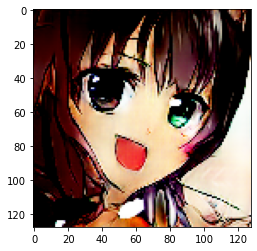

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


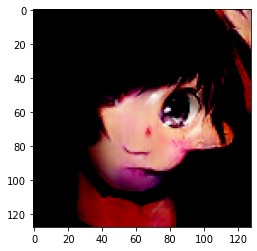

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


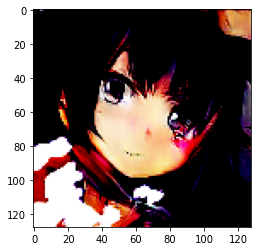

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


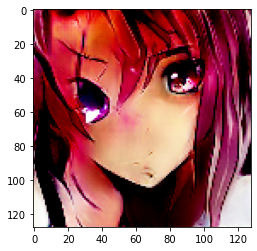

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


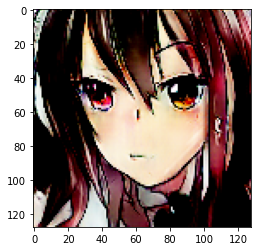

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


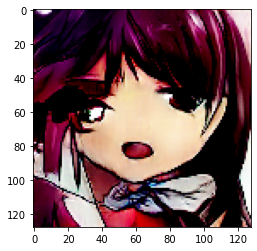

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


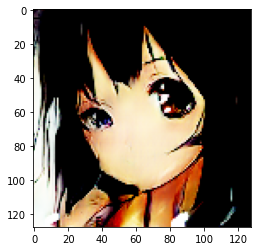

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


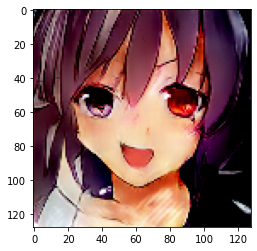

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


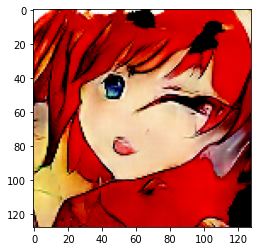

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


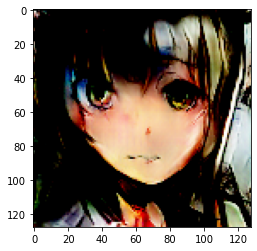

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


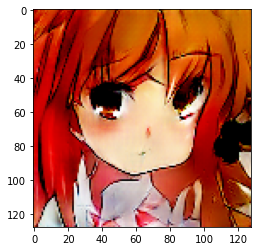

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


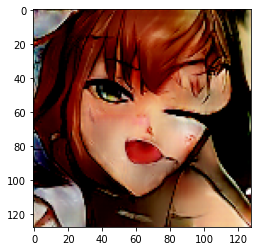

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


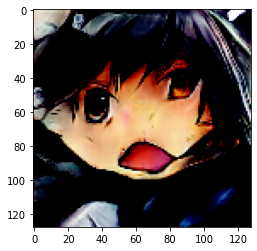

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


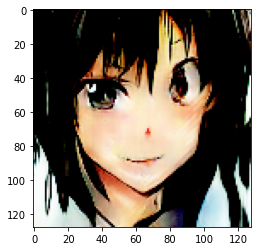

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


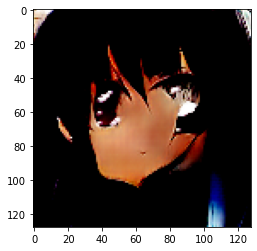

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


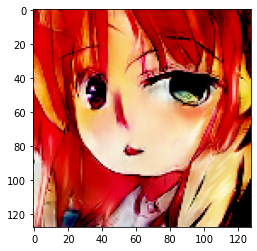

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


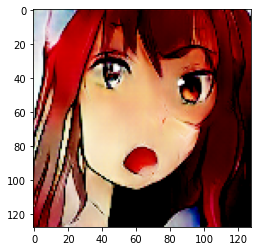

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


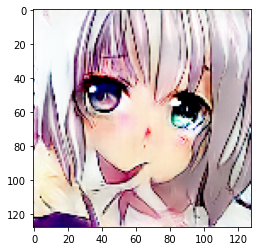

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


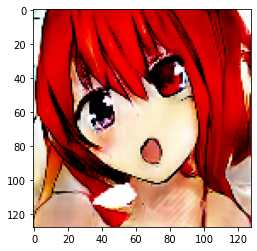

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


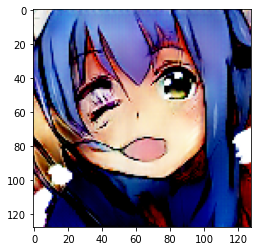

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


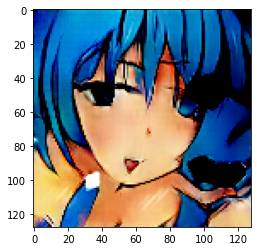

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


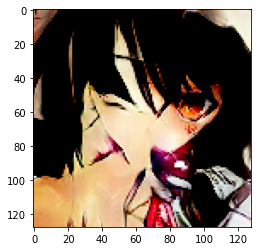

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


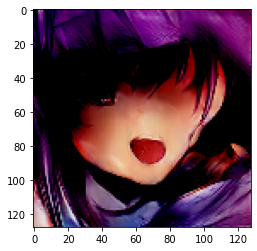

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


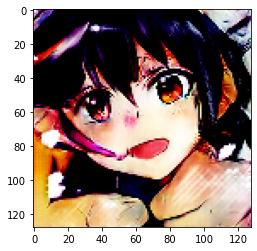

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


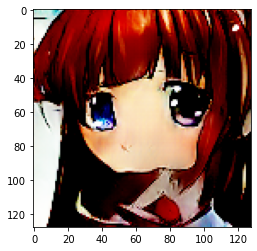

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


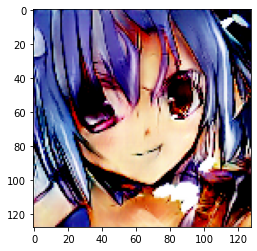

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


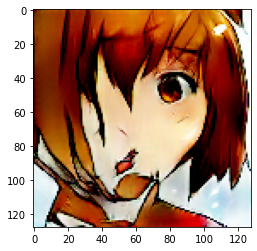

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


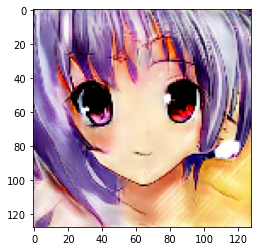

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


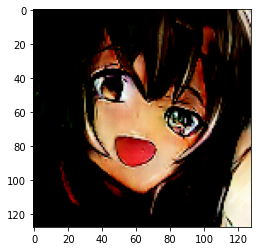

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


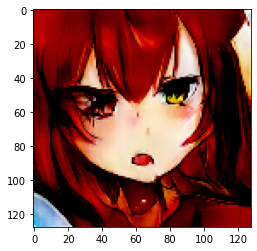

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


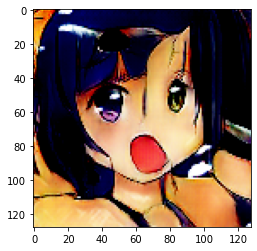

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


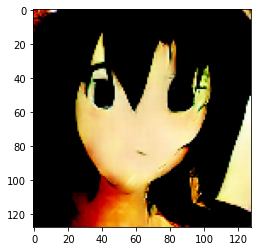

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


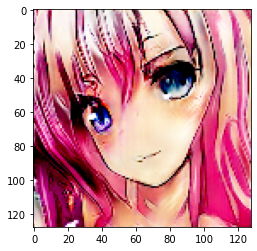

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


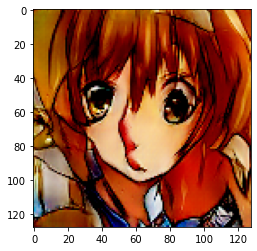

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


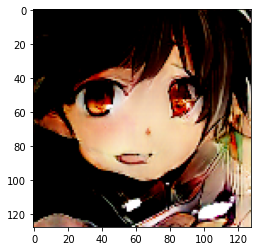

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


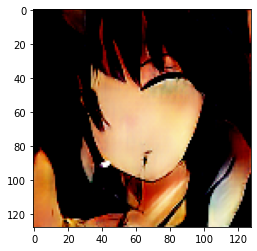

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


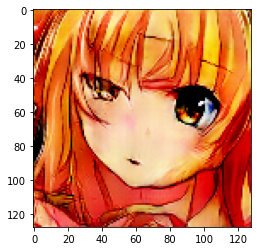

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


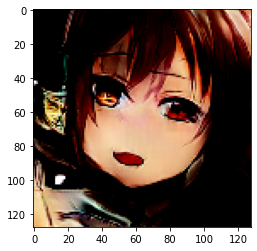

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


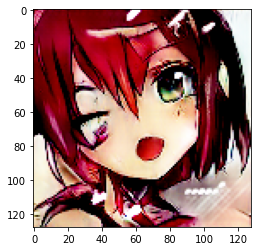

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


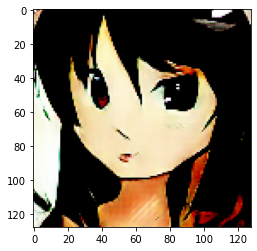

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


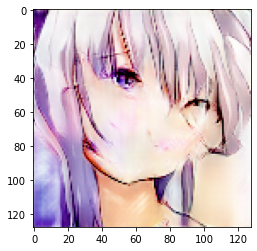

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


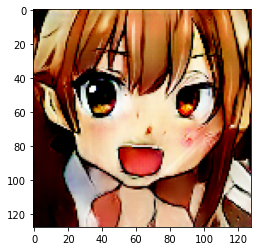

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


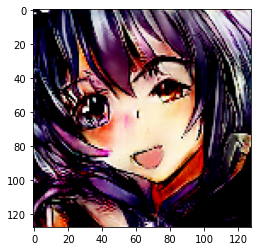

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


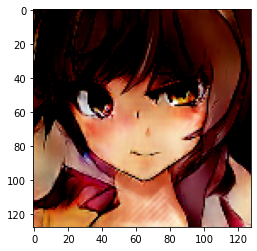

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


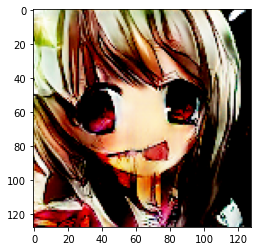

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


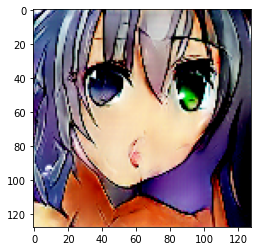

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


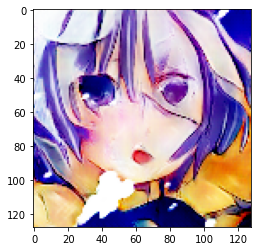

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


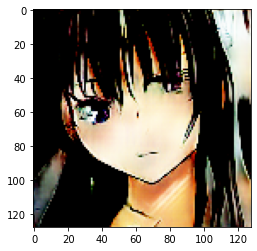

In [22]:
Gtest.load_weights('{}/G_cartoon.npz'.format(flags.checkpoint_dir), format='npz')
Gtest.eval()
z = np.random.normal(loc=0.0, scale=1.0, size=[flags.batch_size, flags.z_dim]).astype(np.float32)
result = Gtest(z)
#tl.visualize.images2d(result)
for img in result:
    plt.imshow(img)
    plt.show()

## **12. Display individual Images**
---

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


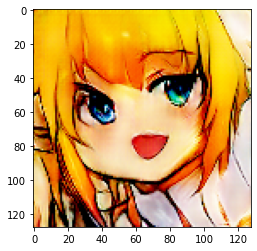

In [17]:
#tl.visualize.frame(result[3])
plt.imshow(result[2])
plt.show()

## **13. Save the images**
---

In [18]:
print(len(result))
i = 0
for img in result:
    i = i+1
    tl.visualize.save_image(img, '{}/Test{}.png'.format(flags.test_dir, i))

Lossy conversion from float32 to uint8. Range [-0.995794415473938, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9999883770942688, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9969149827957153, 0.9993886351585388]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9230979681015015, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9819539785385132, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.994164228439331, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9727092385292053, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversi

64


Lossy conversion from float32 to uint8. Range [-1.0, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.999613344669342, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9922856092453003, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9765931367874146, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9999999403953552, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9999935626983643, 1.0]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float32 to uint8. Range [-0.9917213320732117, 0.9958698153495789]. Convert image to uint8 prior to saving to suppress this warning.
Lossy conversion from float3